## Import libraries and initialize parameters

In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [2]:
# set parameters
test_index = 11840
end_test_index = 15787
# testVal = 19434
testVal = 3947

update_frequency = 10

filename = 'threshold_T1.csv'

# threshold that will accept a prediction as valid
threshold = 0.02

# splitting the dataset 80%
skipVal = 15787
endVal = 19734

## Helper Functions

In [3]:
def set_validation_data(index):
    """
    Helper function to read validation data

    Args:
        index (int): Index of datapoint
    Returns:
        boolean: Returns false if datapoint is a validation point
    """
    if (test_index + 1) <= index < end_test_index:
        return False
    elif index == 0:
        return False
    else:
        return True

In [4]:
def set_testing_data(index):
    """
    Helper function to read testing data

    Args:
        index (int): Index of datapoint
    Returns:
        boolean: Returns false if datapoint is a validation point
    """
    if index >= end_test_index:
        return False
    elif index == 0:
        return False
    else:
        return True

In [5]:
def calculate_mean_squared(predicted_val, actual_val):
    """

    Calculates mean squared error

    Args:
        predicted_val (int): Predicted value
        actual_val (int): Actual value

    Returns:
        mse (int): Mean squared error

    """
    # mse = math.sqrt(abs(actual_val - predicted_val))
    mse = pow((actual_val - predicted_val), 2)
    return mse

In [6]:
def check_abnormal_data(prediction, flag_dictionary, 
                        current_data, timestamp, 
                        true_positive, true_negative, 
                        false_positive, false_negative, 
                        flags):
    """

    Compare new data against the predicted timestamp.
    Places the timestamp of the data in true_positive, true_negative, 
        false_positive or false_negative.

    Args:
        prediction (int): Predicted next timestamp
        flag_dictionary (dict[int]): Dictionary that contains T/F flags that
            determine if datapoint is valid or not
        current_data (int): Data to be checked
        timestamp (int): Timestamp of the data to be checked
        true_positive (arr[int]): List of true positive timestamps
        true_negative (arr[int]): List of true negative timestamps
        false_positive (arr[int]): List of false positive timestamps
        false_negative (arr[int]): List of flase negative timestamps
        flags (arr[int]): list of T/F flags

    Returns:
        flags (arr[int]): list of T/F flags
        true_positive (arr[int]): List of true positive timestamps
        true_negative (arr[int]): List of true negative timestamps
        false_positive (arr[int]): List of false positive timestamps
        false_negative (arr[int]): List of flase negative timestamps
        output_flag (bool): Returns True if prediction was invalid 
            and False if prediction is valid

    """
    
    # determine limits of validation
    upper_limit = prediction * (1 + threshold)
    lower_limit = prediction * (1 - threshold)

    print('Next_time_stamp_raw ' + str(prediction))
    print('Upper limit ' + str(upper_limit))
    print('Lower limit ' + str(lower_limit))
    
    # Compare data
    output_flag = None
    if float(current_data) > upper_limit or float(current_data) < lower_limit:
        flags.append(True)
        output_flag = True
        if timestamp in flag_dictionary:
            true_negative.append(timestamp)
        else:
            false_negative.append(timestamp)
    else:
        output_flag = False
        flags.append(False)
        if timestamp in flag_dictionary:
            false_positive.append(timestamp)
        else:
            true_positive.append(timestamp)
    
    return flags, true_positive, true_negative,\
        false_positive, false_negative, output_flag

In [7]:
def check_abnormal_test_data(prediction, current_data, 
                        timestamp, flags, valid_data):
    """

    Compare new data against the predicted timestamp.

    Args:
        prediction (int): Predicted next timestamp
        current_data (int): Data to be checked
        timestamp (int): Timestamp of the data to be checked
        predicted_invalid (arr[int]): list of predicted invalid data
        flags (arr[int]): list of T/F flags
        valid_data (arr[int]): list of valid data

    Returns:
        flags (arr[int]): list of T/F flags
        valid_data (arr[int]): List of valid data
        output_flag (bool): Returns True if prediction was invalid 
            and False if prediction is valid

    """
    
    # Calculate thresholds
    upper_limit = prediction * (1 + threshold)
    lower_limit = prediction * (1 - threshold)

    print('Next_time_stamp_raw ' + str(prediction))
    print('Upper limit ' + str(upper_limit))
    print('Lower limit ' + str(lower_limit))
    
    # Compare data
    output_flag = None
    if float(current_data) > upper_limit or float(current_data) < lower_limit:
        flags.append(True)
        output_flag = True
    else:
        output_flag = False
        flags.append(False)
        valid_data.append(current_data)
    
    return flags, valid_data, output_flag

In [8]:
def predict(results, index):
        """

    Predict next timestamp.

    Args:
        results (SARIMA model): SARIMA model
        index (int): Index at which model must predict

    Returns:
        prediction (int): Predicted model

    """
        
    pred0 = results.get_prediction(start= test_index + index, dynamic=False)
    pred0_ci = pred0.conf_int()
    prediction = (pred0_ci.values[0][0] + pred0_ci.values[0][1])/2
    return prediction

# this function will predict a range in which the datapoint will be
# for the sake of this project, i am averaging these values

## Load data

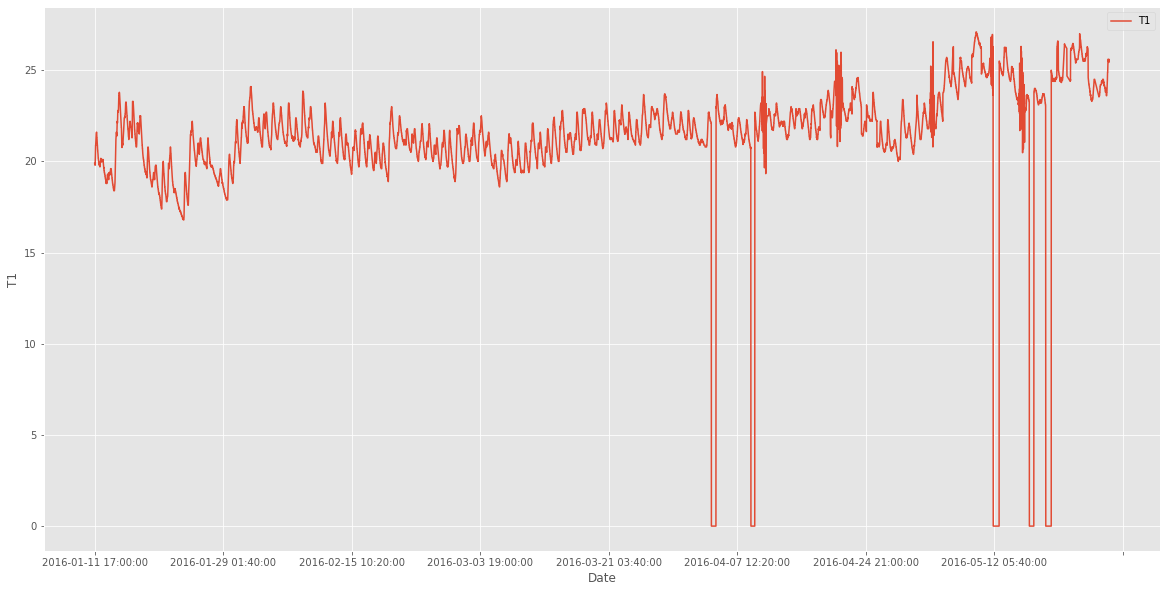

In [22]:
# Load the data
# 3947
data = pd.read_csv(filename, usecols=['date', 'T1'], index_col=0)

# Load timestamps and flags for testing data
series = pd.read_csv(filename, sep=',', header=0, index_col=0, squeeze=True, skiprows=lambda x: set_validation_data(x), usecols=['date', 'T1_class'])

# seperate the data into individual arrays
timestamps = series.index
flag = series.values

# initialize dictionary
flag_dictionary = {}
for x in range(len(timestamps)):
    if flag[x] == True:
        flag_dictionary[timestamps[x]] = True

# Plot the data
data.plot()
plt.ylabel('T1')
plt.xlabel('Date')
plt.show()

In [24]:
train_data = data[1:test_index]
test_data = data[(test_index + 1):end_test_index]

                            T1
date                          
2016-04-02 22:30:00  21.000000
2016-04-02 22:40:00  21.000000
2016-04-02 22:50:00  21.000000
2016-04-02 23:00:00  21.000000
2016-04-02 23:10:00  21.000000
...                        ...
2016-04-30 07:20:00  21.390000
2016-04-30 07:30:00  21.290000
2016-04-30 07:40:00  21.356667
2016-04-30 07:50:00  21.390000
2016-04-30 08:00:00  21.390000

[3946 rows x 1 columns]


## Create model

In [11]:
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=(2,1,1),
                                seasonal_order=(0,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


Once the model has been fitted, we can check if does what we expect and if the assumptions we made are violated. To do this, we can use the $plot\_diagnostics$ method.

In [12]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

## Validation

In [ ]:
# VALIDATION

i = 0
ind = 1

true_positive = []
true_negative = []
false_positive = []
false_negative = []

mse_values_validation = []
predicted_invalid_validation = []
flags_validation = []
valid_data_validation = []
current_data = []
predictions_validation = []

for validation_data in test_data.values:
    current_data.append(validation_data)
    
    # add new data point to array of data
    train_data = data[(1 + ind): (test_index + ind)]
    
    # predict next timestamp
    prediction = predict(results, ind)
    predictions_validation.append(prediction)
    
    # calculate mse
    mse = calculate_mean_squared(prediction, validation_data)
    mse_values_validation.append(mse)
    
    # compare new data to predicted timestamp
    flags, true_positive, true_negative, false_positive,\
            false_negative, output_flag = check_abnormal_data(prediction, 
                                                 flag_dictionary, 
                                                 validation_data, 
                                                 timestamps[ind - 1], 
                                                 true_positive, 
                                                 true_negative, 
                                                 false_positive, 
                                                 false_negative, 
                                                 flags_validation)
    
    if i == update_frequency:
        mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=(2,1,1),
                                seasonal_order=(0,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

        results = mod.fit()
        i = 0
    ind = ind + 1
    i = i + 1

# plot data
plt.figure()
plt.subplot(111)
plt.plot(current_data, label='Current Data')
plt.plot(mse_values_validation, label='mse')    
plt.legend()
plt.show()

plt.figure()
plt.subplot(111)
plt.plot(current_data, label='Current Data')
plt.plot(predictions_validation, label='Prediction')    
plt.legend()
plt.show()


## Export Data

In [26]:
# Export data
tp = pd.DataFrame(true_positive)
tp.to_csv('truePositive.csv')
tn = pd.DataFrame(true_negative)
tn.to_csv('trueNegative.csv')
fp = pd.DataFrame(false_positive)
fp.to_csv('falsePositive.csv')
fn = pd.DataFrame(false_negative)
fn.to_csv('falseNegative.csv')
mseExport = pd.DataFrame(mse_values_validation)
mseExport.to_csv('mseExport.csv')
# pred_inv = pd.DataFrame(predicted_invalid)
# pred_inv.to_csv("predicted_invalid.csv")
# print(test_data.values)
data_export_vals = {
        'Date': timestamps,
        'T1': current_data,
        'T1_e': mse_values_validation,
        'T1_c': flags_validation
    }
data_export = pd.DataFrame(data_export_vals)
data_export.to_csv("T1_report_final.csv", index=False)

## Testing

In [28]:
# TESTING
# load test data (last 20%)
series = pd.read_csv(filename, sep=',', header=0, index_col=0, usecols=['date', 'T1'], squeeze=True, skiprows=lambda x: set_testing_data(x))
timestamps = series.index
testing_data = series.values


mse_values_testing = []
predicted_invalid_testing = []
flags_testing = []
valid_data_testing = []

current_data_testing = []
predictions_testing = []

i = 0
j = 0
ind = 1
for test_data in testing_data:
    current_data_testing.append(test_data)

    # add new data point to array of data
    train_data = data[(test_index + ind): (end_test_index + ind)]

    # predict next timestamp
    prediction = predict(results, ind)
    predictions_testing.append(prediction)

    # calculate mse
    mse = calculate_mean_squared(prediction, test_data)
    mse_values_testing.append(mse)

    # Compare new data to predicted timestamp
    flags, valid_data, output_flag = check_abnormal_test_data(prediction, test_data, timestamps[ind - 1],
                                             flags_testing,   
                                             valid_data_testing)

#     # this is used for clustering
#     if output_flag == True:
#         predicted_invalid_testing.append([timestamps[s[ind - 1], ind - 1]])

    # upadte the model with new datapoints
    if i == update_frequency:
        mod = sm.tsa.statespace.SARIMAX(train_data,
                            order=(2,1,1),
                            seasonal_order=(0,0,0,12),
                            enforce_stationarity=False,
                            enforce_invertibility=False)

        results = mod.fit()
        i = 0
    ind = ind + 1
    i = i + 1

                            T1
date                          
2016-04-02 22:30:00  21.000000
2016-04-02 22:40:00  21.000000
2016-04-02 22:50:00  21.000000
2016-04-02 23:00:00  21.000000
2016-04-02 23:10:00  21.000000
...                        ...
2016-04-30 07:30:00  21.290000
2016-04-30 07:40:00  21.356667
2016-04-30 07:50:00  21.390000
2016-04-30 08:00:00  21.390000
2016-04-30 08:10:00  21.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.3896992770118
Upper limit 21.817493262552038
Lower limit 20.961905291471563
                            T1
date                          
2016-04-02 22:40:00  21.000000
2016-04-02 22:50:00  21.000000
2016-04-02 23:00:00  21.000000
2016-04-02 23:10:00  21.000000
2016-04-02 23:20:00  21.000000
...                        ...
2016-04-30 07:40:00  21.356667
2016-04-30 07:50:00  21.390000
2016-04-30 08:00:00  21.390000
2016-04-30 08:10:00  21.390000
2016-04-30 08:20:00  21.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.389712001814683
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-03 00:20:00  20.890000
2016-04-03 00:30:00  20.890000
2016-04-03 00:40:00  20.890000
2016-04-03 00:50:00  20.890000
2016-04-03 01:00:00  20.890000
...                        ...
2016-04-30 09:20:00  21.323333
2016-04-30 09:30:00  21.323333
2016-04-30 09:40:00  21.290000
2016-04-30 09:50:00  21.356667
2016-04-30 10:00:00  21.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.352334062437905
Upper limit 21.779380743686662
Lower limit 20.925287381189147
                            T1
date                          
2016-04-03 00:30:00  20.890000
2016-04-03 00:40:00  20.890000
2016-04-03 00:50:00  20.890000
2016-04-03 01:00:00  20.890000
2016-04-03 01:10:00  20.890000
...                        ...
2016-04-30 09:30:00  21.323333
2016-04-30 09:40:00  21.290000
2016-04-30 09:50:00  21.356667
2016-04-30 10:00:00  21.390000
2016-04-30 10:10:00  21.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.352334062437905
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-03 02:00:00  20.89
2016-04-03 02:10:00  20.89
2016-04-03 02:20:00  20.89
2016-04-03 02:30:00  20.89
2016-04-03 02:40:00  20.89
...                    ...
2016-04-30 11:00:00  21.39
2016-04-30 11:10:00  21.39
2016-04-30 11:20:00  21.39
2016-04-30 11:30:00  21.50
2016-04-30 11:40:00  21.50

[3947 rows x 1 columns]
Next_time_stamp_raw 21.491870178950307
Upper limit 21.921707582529315
Lower limit 21.0620327753713
                        T1
date                      
2016-04-03 02:10:00  20.89
2016-04-03 02:20:00  20.89
2016-04-03 02:30:00  20.89
2016-04-03 02:40:00  20.89
2016-04-03 02:50:00  20.89
...                    ...
2016-04-30 11:10:00  21.39
2016-04-30 11:20:00  21.39
2016-04-30 11:30:00  21.50
2016-04-30 11:40:00  21.50
2016-04-30 11:50:00  21.50

[3947 rows x 1 columns]
Next_time_stamp_raw 21.491870178950315
Upper limit 21.921707582529322
Lower limit 21.062032775371307
                        T1
date                 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-03 03:40:00  20.790000
2016-04-03 03:50:00  20.790000
2016-04-03 04:00:00  20.790000
2016-04-03 04:10:00  20.790000
2016-04-03 04:20:00  20.790000
...                        ...
2016-04-30 12:40:00  21.500000
2016-04-30 12:50:00  21.533333
2016-04-30 13:00:00  21.600000
2016-04-30 13:10:00  21.633333
2016-04-30 13:20:00  21.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.629829966107962
Upper limit 22.062426565430123
Lower limit 21.197233366785802
                            T1
date                          
2016-04-03 03:50:00  20.790000
2016-04-03 04:00:00  20.790000
2016-04-03 04:10:00  20.790000
2016-04-03 04:20:00  20.790000
2016-04-03 04:30:00  20.790000
...                        ...
2016-04-30 12:50:00  21.533333
2016-04-30 13:00:00  21.600000
2016-04-30 13:10:00  21.633333
2016-04-30 13:20:00  21.700000
2016-04-30 13:30:00  21.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.62982996610797
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-03 05:20:00  20.790000
2016-04-03 05:30:00  20.790000
2016-04-03 05:40:00  20.790000
2016-04-03 05:50:00  20.790000
2016-04-03 06:00:00  20.790000
...                        ...
2016-04-30 14:20:00  21.790000
2016-04-30 14:30:00  21.856667
2016-04-30 14:40:00  21.890000
2016-04-30 14:50:00  21.890000
2016-04-30 15:00:00  21.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.889689430874697
Upper limit 22.32748321949219
Lower limit 21.451895642257202
                            T1
date                          
2016-04-03 05:30:00  20.790000
2016-04-03 05:40:00  20.790000
2016-04-03 05:50:00  20.790000
2016-04-03 06:00:00  20.790000
2016-04-03 06:10:00  20.790000
...                        ...
2016-04-30 14:30:00  21.856667
2016-04-30 14:40:00  21.890000
2016-04-30 14:50:00  21.890000
2016-04-30 15:00:00  21.890000
2016-04-30 15:10:00  21.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.889689430874697
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-03 07:00:00  20.790000
2016-04-03 07:10:00  20.790000
2016-04-03 07:20:00  20.790000
2016-04-03 07:30:00  20.790000
2016-04-03 07:40:00  20.790000
...                        ...
2016-04-30 16:00:00  21.890000
2016-04-30 16:10:00  21.890000
2016-04-30 16:20:00  21.890000
2016-04-30 16:30:00  21.890000
2016-04-30 16:40:00  21.926667

[3947 rows x 1 columns]
Next_time_stamp_raw 21.889999999805433
Upper limit 22.32779999980154
Lower limit 21.452199999809324
                            T1
date                          
2016-04-03 07:10:00  20.790000
2016-04-03 07:20:00  20.790000
2016-04-03 07:30:00  20.790000
2016-04-03 07:40:00  20.790000
2016-04-03 07:50:00  20.790000
...                        ...
2016-04-30 16:10:00  21.890000
2016-04-30 16:20:00  21.890000
2016-04-30 16:30:00  21.890000
2016-04-30 16:40:00  21.926667
2016-04-30 16:50:00  22.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.88999999980544
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-03 08:40:00  20.823333
2016-04-03 08:50:00  20.823333
2016-04-03 09:00:00  20.823333
2016-04-03 09:10:00  20.890000
2016-04-03 09:20:00  20.890000
...                        ...
2016-04-30 17:40:00  22.000000
2016-04-30 17:50:00  22.000000
2016-04-30 18:00:00  22.000000
2016-04-30 18:10:00  22.000000
2016-04-30 18:20:00  21.926667

[3947 rows x 1 columns]
Next_time_stamp_raw 22.00003872435319
Upper limit 22.440039498840253
Lower limit 21.560037949866125
                            T1
date                          
2016-04-03 08:50:00  20.823333
2016-04-03 09:00:00  20.823333
2016-04-03 09:10:00  20.890000
2016-04-03 09:20:00  20.890000
2016-04-03 09:30:00  20.890000
...                        ...
2016-04-30 17:50:00  22.000000
2016-04-30 18:00:00  22.000000
2016-04-30 18:10:00  22.000000
2016-04-30 18:20:00  21.926667
2016-04-30 18:30:00  21.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.000038724353175
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-03 10:20:00  21.10
2016-04-03 10:30:00  21.10
2016-04-03 10:40:00  21.20
2016-04-03 10:50:00  21.20
2016-04-03 11:00:00  21.23
...                    ...
2016-04-30 19:20:00  21.89
2016-04-30 19:30:00  21.79
2016-04-30 19:40:00  21.79
2016-04-30 19:50:00  21.79
2016-04-30 20:00:00  21.73

[3947 rows x 1 columns]
Next_time_stamp_raw 21.78957457255253
Upper limit 22.225366064003584
Lower limit 21.35378308110148
                        T1
date                      
2016-04-03 10:30:00  21.10
2016-04-03 10:40:00  21.20
2016-04-03 10:50:00  21.20
2016-04-03 11:00:00  21.23
2016-04-03 11:10:00  21.29
...                    ...
2016-04-30 19:30:00  21.79
2016-04-30 19:40:00  21.79
2016-04-30 19:50:00  21.79
2016-04-30 20:00:00  21.73
2016-04-30 20:10:00  21.70

[3947 rows x 1 columns]
Next_time_stamp_raw 21.78957457255253
Upper limit 22.225366064003584
Lower limit 21.35378308110148
                            T1
date               

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-03 12:00:00  21.600000
2016-04-03 12:10:00  21.700000
2016-04-03 12:20:00  21.760000
2016-04-03 12:30:00  21.890000
2016-04-03 12:40:00  21.963333
...                        ...
2016-04-30 21:00:00  21.600000
2016-04-30 21:10:00  21.533333
2016-04-30 21:20:00  21.500000
2016-04-30 21:30:00  21.500000
2016-04-30 21:40:00  21.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.500305588800863
Upper limit 21.93031170057688
Lower limit 21.070299477024847
                            T1
date                          
2016-04-03 12:10:00  21.700000
2016-04-03 12:20:00  21.760000
2016-04-03 12:30:00  21.890000
2016-04-03 12:40:00  21.963333
2016-04-03 12:50:00  22.000000
...                        ...
2016-04-30 21:10:00  21.533333
2016-04-30 21:20:00  21.500000
2016-04-30 21:30:00  21.500000
2016-04-30 21:40:00  21.500000
2016-04-30 21:50:00  21.426667

[3947 rows x 1 columns]
Next_time_stamp_raw 21.500305588800863
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-03 13:40:00  22.356667
2016-04-03 13:50:00  22.390000
2016-04-03 14:00:00  22.463333
2016-04-03 14:10:00  22.533333
2016-04-03 14:20:00  22.600000
...                        ...
2016-04-30 22:40:00  21.290000
2016-04-30 22:50:00  21.290000
2016-04-30 23:00:00  21.290000
2016-04-30 23:10:00  21.290000
2016-04-30 23:20:00  21.260000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.290017675440495
Upper limit 21.715818028949304
Lower limit 20.864217321931687
                            T1
date                          
2016-04-03 13:50:00  22.390000
2016-04-03 14:00:00  22.463333
2016-04-03 14:10:00  22.533333
2016-04-03 14:20:00  22.600000
2016-04-03 14:30:00  22.600000
...                        ...
2016-04-30 22:50:00  21.290000
2016-04-30 23:00:00  21.290000
2016-04-30 23:10:00  21.290000
2016-04-30 23:20:00  21.260000
2016-04-30 23:30:00  21.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.290017675440488
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-03 15:20:00  22.700000
2016-04-03 15:30:00  22.700000
2016-04-03 15:40:00  22.700000
2016-04-03 15:50:00  22.700000
2016-04-03 16:00:00  22.700000
...                        ...
2016-05-01 00:20:00  21.133333
2016-05-01 00:30:00  21.100000
2016-05-01 00:40:00  21.100000
2016-05-01 00:50:00  21.066667
2016-05-01 01:00:00  21.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.068995646106075
Upper limit 21.490375559028198
Lower limit 20.64761573318395
                            T1
date                          
2016-04-03 15:30:00  22.700000
2016-04-03 15:40:00  22.700000
2016-04-03 15:50:00  22.700000
2016-04-03 16:00:00  22.700000
2016-04-03 16:10:00  22.700000
...                        ...
2016-05-01 00:30:00  21.100000
2016-05-01 00:40:00  21.100000
2016-05-01 00:50:00  21.066667
2016-05-01 01:00:00  21.000000
2016-05-01 01:10:00  21.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.068995646106075
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-03 17:00:00  22.600000
2016-04-03 17:10:00  22.600000
2016-04-03 17:20:00  22.500000
2016-04-03 17:30:00  22.500000
2016-04-03 17:40:00  22.500000
...                        ...
2016-05-01 02:00:00  20.890000
2016-05-01 02:10:00  20.856667
2016-05-01 02:20:00  20.790000
2016-05-01 02:30:00  20.790000
2016-05-01 02:40:00  20.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 20.791045337395254
Upper limit 21.20686624414316
Lower limit 20.375224430647346
                            T1
date                          
2016-04-03 17:10:00  22.600000
2016-04-03 17:20:00  22.500000
2016-04-03 17:30:00  22.500000
2016-04-03 17:40:00  22.500000
2016-04-03 17:50:00  22.500000
...                        ...
2016-05-01 02:10:00  20.856667
2016-05-01 02:20:00  20.790000
2016-05-01 02:30:00  20.790000
2016-05-01 02:40:00  20.790000
2016-05-01 02:50:00  20.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 20.791045337395254
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-03 18:40:00  22.390000
2016-04-03 18:50:00  22.390000
2016-04-03 19:00:00  22.390000
2016-04-03 19:10:00  22.390000
2016-04-03 19:20:00  22.390000
...                        ...
2016-05-01 03:40:00  20.700000
2016-05-01 03:50:00  20.700000
2016-05-01 04:00:00  20.700000
2016-05-01 04:10:00  20.633333
2016-05-01 04:20:00  20.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 20.6382643146406
Upper limit 21.051029600933415
Lower limit 20.225499028347787
                            T1
date                          
2016-04-03 18:50:00  22.390000
2016-04-03 19:00:00  22.390000
2016-04-03 19:10:00  22.390000
2016-04-03 19:20:00  22.390000
2016-04-03 19:30:00  22.290000
...                        ...
2016-05-01 03:50:00  20.700000
2016-05-01 04:00:00  20.700000
2016-05-01 04:10:00  20.633333
2016-05-01 04:20:00  20.600000
2016-05-01 04:30:00  20.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 20.638264314640608
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                       T1
date                     
2016-04-03 20:20:00  22.2
2016-04-03 20:30:00  22.2
2016-04-03 20:40:00  22.2
2016-04-03 20:50:00  22.2
2016-04-03 21:00:00  22.2
...                   ...
2016-05-01 05:20:00  20.5
2016-05-01 05:30:00  20.5
2016-05-01 05:40:00  20.5
2016-05-01 05:50:00  20.5
2016-05-01 06:00:00  20.5

[3947 rows x 1 columns]
Next_time_stamp_raw 20.500017638800685
Upper limit 20.910017991576698
Lower limit 20.090017286024672
                       T1
date                     
2016-04-03 20:30:00  22.2
2016-04-03 20:40:00  22.2
2016-04-03 20:50:00  22.2
2016-04-03 21:00:00  22.2
2016-04-03 21:10:00  22.2
...                   ...
2016-05-01 05:30:00  20.5
2016-05-01 05:40:00  20.5
2016-05-01 05:50:00  20.5
2016-05-01 06:00:00  20.5
2016-05-01 06:10:00  20.5

[3947 rows x 1 columns]
Next_time_stamp_raw 20.50001763880067
Upper limit 20.910017991576684
Lower limit 20.090017286024658
                            T1
date                          
2016-04-03 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-03 22:00:00  22.200000
2016-04-03 22:10:00  22.200000
2016-04-03 22:20:00  22.200000
2016-04-03 22:30:00  22.200000
2016-04-03 22:40:00  22.133333
...                        ...
2016-05-01 07:00:00  20.390000
2016-05-01 07:10:00  20.390000
2016-05-01 07:20:00  20.390000
2016-05-01 07:30:00  20.390000
2016-05-01 07:40:00  20.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 20.390004355634645
Upper limit 20.79780444274734
Lower limit 19.98220426852195
                            T1
date                          
2016-04-03 22:10:00  22.200000
2016-04-03 22:20:00  22.200000
2016-04-03 22:30:00  22.200000
2016-04-03 22:40:00  22.133333
2016-04-03 22:50:00  22.133333
...                        ...
2016-05-01 07:10:00  20.390000
2016-05-01 07:20:00  20.390000
2016-05-01 07:30:00  20.390000
2016-05-01 07:40:00  20.390000
2016-05-01 07:50:00  20.463333

[3947 rows x 1 columns]
Next_time_stamp_raw 20.390004355634645
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-03 23:40:00  22.100000
2016-04-03 23:50:00  22.100000
2016-04-04 00:00:00   0.000000
2016-04-04 00:10:00   0.000000
2016-04-04 00:20:00   0.000000
...                        ...
2016-05-01 08:40:00  20.600000
2016-05-01 08:50:00  20.600000
2016-05-01 09:00:00  20.600000
2016-05-01 09:10:00  20.600000
2016-05-01 09:20:00  20.666667

[3947 rows x 1 columns]
Next_time_stamp_raw 20.599969008649396
Upper limit 21.011968388822385
Lower limit 20.187969628476406
                            T1
date                          
2016-04-03 23:50:00  22.100000
2016-04-04 00:00:00   0.000000
2016-04-04 00:10:00   0.000000
2016-04-04 00:20:00   0.000000
2016-04-04 00:30:00   0.000000
...                        ...
2016-05-01 08:50:00  20.600000
2016-05-01 09:00:00  20.600000
2016-05-01 09:10:00  20.600000
2016-05-01 09:20:00  20.666667
2016-05-01 09:30:00  20.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 20.599969008649396
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-04 01:20:00   0.000000
2016-04-04 01:30:00   0.000000
2016-04-04 01:40:00   0.000000
2016-04-04 01:50:00   0.000000
2016-04-04 02:00:00   0.000000
...                        ...
2016-05-01 10:20:00  20.823333
2016-05-01 10:30:00  20.890000
2016-05-01 10:40:00  20.890000
2016-05-01 10:50:00  20.963333
2016-05-01 11:00:00  21.033333

[3947 rows x 1 columns]
Next_time_stamp_raw 20.956983991913702
Upper limit 21.376123671751976
Lower limit 20.53784431207543
                            T1
date                          
2016-04-04 01:30:00   0.000000
2016-04-04 01:40:00   0.000000
2016-04-04 01:50:00   0.000000
2016-04-04 02:00:00   0.000000
2016-04-04 02:10:00   0.000000
...                        ...
2016-05-01 10:30:00  20.890000
2016-05-01 10:40:00  20.890000
2016-05-01 10:50:00  20.963333
2016-05-01 11:00:00  21.033333
2016-05-01 11:10:00  21.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 20.956983991913702
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-04 03:00:00   0.000000
2016-04-04 03:10:00   0.000000
2016-04-04 03:20:00   0.000000
2016-04-04 03:30:00   0.000000
2016-04-04 03:40:00   0.000000
...                        ...
2016-05-01 12:00:00  21.200000
2016-05-01 12:10:00  21.200000
2016-05-01 12:20:00  21.230000
2016-05-01 12:30:00  21.290000
2016-05-01 12:40:00  21.323333

[3947 rows x 1 columns]
Next_time_stamp_raw 21.28371892364406
Upper limit 21.70939330211694
Lower limit 20.85804454517118
                            T1
date                          
2016-04-04 03:10:00   0.000000
2016-04-04 03:20:00   0.000000
2016-04-04 03:30:00   0.000000
2016-04-04 03:40:00   0.000000
2016-04-04 03:50:00   0.000000
...                        ...
2016-05-01 12:10:00  21.200000
2016-05-01 12:20:00  21.230000
2016-05-01 12:30:00  21.290000
2016-05-01 12:40:00  21.323333
2016-05-01 12:50:00  21.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.283718923644052
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-04 04:40:00   0.000000
2016-04-04 04:50:00   0.000000
2016-04-04 05:00:00   0.000000
2016-04-04 05:10:00   0.000000
2016-04-04 05:20:00   0.000000
...                        ...
2016-05-01 13:40:00  21.600000
2016-05-01 13:50:00  21.633333
2016-05-01 14:00:00  21.700000
2016-05-01 14:10:00  21.700000
2016-05-01 14:20:00  21.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.69859636819676
Upper limit 22.132568295560695
Lower limit 21.264624440832826
                            T1
date                          
2016-04-04 04:50:00   0.000000
2016-04-04 05:00:00   0.000000
2016-04-04 05:10:00   0.000000
2016-04-04 05:20:00   0.000000
2016-04-04 05:30:00   0.000000
...                        ...
2016-05-01 13:50:00  21.633333
2016-05-01 14:00:00  21.700000
2016-05-01 14:10:00  21.700000
2016-05-01 14:20:00  21.700000
2016-05-01 14:30:00  21.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.69859636819676
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-04 06:20:00   0.00
2016-04-04 06:30:00   0.00
2016-04-04 06:40:00   0.00
2016-04-04 06:50:00   0.00
2016-04-04 07:00:00   0.00
...                    ...
2016-05-01 15:20:00  21.89
2016-05-01 15:30:00  22.00
2016-05-01 15:40:00  22.00
2016-05-01 15:50:00  22.10
2016-05-01 16:00:00  22.10

[3947 rows x 1 columns]
Next_time_stamp_raw 22.091299978289257
Upper limit 22.533125977855043
Lower limit 21.64947397872347
                            T1
date                          
2016-04-04 06:30:00   0.000000
2016-04-04 06:40:00   0.000000
2016-04-04 06:50:00   0.000000
2016-04-04 07:00:00   0.000000
2016-04-04 07:10:00   0.000000
...                        ...
2016-05-01 15:30:00  22.000000
2016-05-01 15:40:00  22.000000
2016-05-01 15:50:00  22.100000
2016-05-01 16:00:00  22.100000
2016-05-01 16:10:00  22.133333

[3947 rows x 1 columns]
Next_time_stamp_raw 22.09129997828927
Upper limit 22.533125977855057
Lower limit 21.649473978723

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-04 08:00:00   0.000000
2016-04-04 08:10:00   0.000000
2016-04-04 08:20:00   0.000000
2016-04-04 08:30:00   0.000000
2016-04-04 08:40:00   0.000000
...                        ...
2016-05-01 17:00:00  22.390000
2016-05-01 17:10:00  22.390000
2016-05-01 17:20:00  22.390000
2016-05-01 17:30:00  22.463333
2016-05-01 17:40:00  22.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.456488815903647
Upper limit 22.90561859222172
Lower limit 22.007359039585573
                            T1
date                          
2016-04-04 08:10:00   0.000000
2016-04-04 08:20:00   0.000000
2016-04-04 08:30:00   0.000000
2016-04-04 08:40:00   0.000000
2016-04-04 08:50:00   0.000000
...                        ...
2016-05-01 17:10:00  22.390000
2016-05-01 17:20:00  22.390000
2016-05-01 17:30:00  22.463333
2016-05-01 17:40:00  22.500000
2016-05-01 17:50:00  22.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.456488815903647
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-04 09:40:00   0.000000
2016-04-04 09:50:00   0.000000
2016-04-04 10:00:00   0.000000
2016-04-04 10:10:00   0.000000
2016-04-04 10:20:00   0.000000
...                        ...
2016-05-01 18:40:00  23.633333
2016-05-01 18:50:00  23.426667
2016-05-01 19:00:00  23.356667
2016-05-01 19:10:00  23.290000
2016-05-01 19:20:00  23.260000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.29670938453164
Upper limit 23.76264357222227
Lower limit 22.830775196841007
                            T1
date                          
2016-04-04 09:50:00   0.000000
2016-04-04 10:00:00   0.000000
2016-04-04 10:10:00   0.000000
2016-04-04 10:20:00   0.000000
2016-04-04 10:30:00   0.000000
...                        ...
2016-05-01 18:50:00  23.426667
2016-05-01 19:00:00  23.356667
2016-05-01 19:10:00  23.290000
2016-05-01 19:20:00  23.260000
2016-05-01 19:30:00  23.175000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.29670938453164
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-04 11:20:00   0.000000
2016-04-04 11:30:00   0.000000
2016-04-04 11:40:00   0.000000
2016-04-04 11:50:00   0.000000
2016-04-04 12:00:00   0.000000
...                        ...
2016-05-01 20:20:00  23.000000
2016-05-01 20:30:00  23.000000
2016-05-01 20:40:00  22.926667
2016-05-01 20:50:00  22.890000
2016-05-01 21:00:00  22.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.89513227699534
Upper limit 23.353034922535247
Lower limit 22.437229631455434
                            T1
date                          
2016-04-04 11:30:00   0.000000
2016-04-04 11:40:00   0.000000
2016-04-04 11:50:00   0.000000
2016-04-04 12:00:00   0.000000
2016-04-04 12:10:00   0.000000
...                        ...
2016-05-01 20:30:00  23.000000
2016-05-01 20:40:00  22.926667
2016-05-01 20:50:00  22.890000
2016-05-01 21:00:00  22.890000
2016-05-01 21:10:00  22.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.895132276995326
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-04 13:00:00   0.000000
2016-04-04 13:10:00   0.000000
2016-04-04 13:20:00   0.000000
2016-04-04 13:30:00   0.000000
2016-04-04 13:40:00   0.000000
...                        ...
2016-05-01 22:00:00  22.633333
2016-05-01 22:10:00  22.600000
2016-05-01 22:20:00  22.533333
2016-05-01 22:30:00  22.500000
2016-05-01 22:40:00  22.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.50450443003517
Upper limit 22.954594518635872
Lower limit 22.054414341434466
                            T1
date                          
2016-04-04 13:10:00   0.000000
2016-04-04 13:20:00   0.000000
2016-04-04 13:30:00   0.000000
2016-04-04 13:40:00   0.000000
2016-04-04 13:50:00   0.000000
...                        ...
2016-05-01 22:10:00  22.600000
2016-05-01 22:20:00  22.533333
2016-05-01 22:30:00  22.500000
2016-05-01 22:40:00  22.500000
2016-05-01 22:50:00  22.445000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.50450443003517
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-04 14:40:00   0.000000
2016-04-04 14:50:00   0.000000
2016-04-04 15:00:00   0.000000
2016-04-04 15:10:00  22.890000
2016-04-04 15:20:00  22.890000
...                        ...
2016-05-01 23:40:00  22.200000
2016-05-01 23:50:00  22.200000
2016-05-02 00:00:00  22.200000
2016-05-02 00:10:00  22.133333
2016-05-02 00:20:00  22.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.13894505575834
Upper limit 22.58172395687351
Lower limit 21.696166154643173
                            T1
date                          
2016-04-04 14:50:00   0.000000
2016-04-04 15:00:00   0.000000
2016-04-04 15:10:00  22.890000
2016-04-04 15:20:00  22.890000
2016-04-04 15:30:00  23.000000
...                        ...
2016-05-01 23:50:00  22.200000
2016-05-02 00:00:00  22.200000
2016-05-02 00:10:00  22.133333
2016-05-02 00:20:00  22.100000
2016-05-02 00:30:00  22.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.13894505575834
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-04 16:20:00  23.100000
2016-04-04 16:30:00  23.323333
2016-04-04 16:40:00  23.390000
2016-04-04 16:50:00  23.426667
2016-04-04 17:00:00  23.500000
...                        ...
2016-05-02 01:20:00  21.890000
2016-05-02 01:30:00  21.823333
2016-05-02 01:40:00  21.790000
2016-05-02 01:50:00  21.730000
2016-05-02 02:00:00  21.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.738551528298203
Upper limit 22.173322558864168
Lower limit 21.303780497732237
                            T1
date                          
2016-04-04 16:30:00  23.323333
2016-04-04 16:40:00  23.390000
2016-04-04 16:50:00  23.426667
2016-04-04 17:00:00  23.500000
2016-04-04 17:10:00  23.500000
...                        ...
2016-05-02 01:30:00  21.823333
2016-05-02 01:40:00  21.790000
2016-05-02 01:50:00  21.730000
2016-05-02 02:00:00  21.700000
2016-05-02 02:10:00  21.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.738551528298203
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-04 18:00:00  23.533333
2016-04-04 18:10:00  23.600000
2016-04-04 18:20:00  23.600000
2016-04-04 18:30:00  23.600000
2016-04-04 18:40:00  23.666667
...                        ...
2016-05-02 03:00:00  21.500000
2016-05-02 03:10:00  21.500000
2016-05-02 03:20:00  21.500000
2016-05-02 03:30:00  21.390000
2016-05-02 03:40:00  21.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.404343249967766
Upper limit 21.83243011496712
Lower limit 20.976256384968412
                            T1
date                          
2016-04-04 18:10:00  23.600000
2016-04-04 18:20:00  23.600000
2016-04-04 18:30:00  23.600000
2016-04-04 18:40:00  23.666667
2016-04-04 18:50:00  23.600000
...                        ...
2016-05-02 03:10:00  21.500000
2016-05-02 03:20:00  21.500000
2016-05-02 03:30:00  21.390000
2016-05-02 03:40:00  21.390000
2016-05-02 03:50:00  21.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.404343249967766
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-04 19:40:00  23.500000
2016-04-04 19:50:00  23.426667
2016-04-04 20:00:00  23.390000
2016-04-04 20:10:00  23.390000
2016-04-04 20:20:00  23.340000
...                        ...
2016-05-02 04:40:00  21.230000
2016-05-02 04:50:00  21.200000
2016-05-02 05:00:00  21.200000
2016-05-02 05:10:00  21.200000
2016-05-02 05:20:00  21.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.199875243708448
Upper limit 21.623872748582617
Lower limit 20.77587773883428
                            T1
date                          
2016-04-04 19:50:00  23.426667
2016-04-04 20:00:00  23.390000
2016-04-04 20:10:00  23.390000
2016-04-04 20:20:00  23.340000
2016-04-04 20:30:00  23.290000
...                        ...
2016-05-02 04:50:00  21.200000
2016-05-02 05:00:00  21.200000
2016-05-02 05:10:00  21.200000
2016-05-02 05:20:00  21.200000
2016-05-02 05:30:00  21.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.199875243708448
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-04 21:20:00  23.200000
2016-04-04 21:30:00  23.100000
2016-04-04 21:40:00  23.100000
2016-04-04 21:50:00  23.066667
2016-04-04 22:00:00  23.000000
...                        ...
2016-05-02 06:20:00  21.200000
2016-05-02 06:30:00  21.200000
2016-05-02 06:40:00  21.200000
2016-05-02 06:50:00  21.200000
2016-05-02 07:00:00  21.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.1999999999895
Upper limit 21.62399999998929
Lower limit 20.77599999998971
                            T1
date                          
2016-04-04 21:30:00  23.100000
2016-04-04 21:40:00  23.100000
2016-04-04 21:50:00  23.066667
2016-04-04 22:00:00  23.000000
2016-04-04 22:10:00  22.963333
...                        ...
2016-05-02 06:30:00  21.200000
2016-05-02 06:40:00  21.200000
2016-05-02 06:50:00  21.200000
2016-05-02 07:00:00  21.200000
2016-05-02 07:10:00  21.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.1999999999895
Upper limi

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-04 23:00:00  22.79
2016-04-04 23:10:00  22.70
2016-04-04 23:20:00  22.70
2016-04-04 23:30:00  22.70
2016-04-04 23:40:00  22.70
...                    ...
2016-05-02 08:00:00  21.20
2016-05-02 08:10:00  21.26
2016-05-02 08:20:00  21.29
2016-05-02 08:30:00  21.29
2016-05-02 08:40:00  21.29

[3947 rows x 1 columns]
Next_time_stamp_raw 21.28936392354221
Upper limit 21.715151202013057
Lower limit 20.863576645071365
                            T1
date                          
2016-04-04 23:10:00  22.700000
2016-04-04 23:20:00  22.700000
2016-04-04 23:30:00  22.700000
2016-04-04 23:40:00  22.700000
2016-04-04 23:50:00  22.633333
...                        ...
2016-05-02 08:10:00  21.260000
2016-05-02 08:20:00  21.290000
2016-05-02 08:30:00  21.290000
2016-05-02 08:40:00  21.290000
2016-05-02 08:50:00  21.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.28936392354221
Upper limit 21.715151202013057
Lower limit 20.863576645071

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 00:40:00  22.566667
2016-04-05 00:50:00  22.500000
2016-04-05 01:00:00  22.500000
2016-04-05 01:10:00  22.500000
2016-04-05 01:20:00  22.500000
...                        ...
2016-05-02 09:40:00  21.500000
2016-05-02 09:50:00  21.600000
2016-05-02 10:00:00  21.600000
2016-05-02 10:10:00  21.633333
2016-05-02 10:20:00  21.633333

[3947 rows x 1 columns]
Next_time_stamp_raw 21.629658190439145
Upper limit 22.062251354247927
Lower limit 21.197065026630362
                            T1
date                          
2016-04-05 00:50:00  22.500000
2016-04-05 01:00:00  22.500000
2016-04-05 01:10:00  22.500000
2016-04-05 01:20:00  22.500000
2016-04-05 01:30:00  22.500000
...                        ...
2016-05-02 09:50:00  21.600000
2016-05-02 10:00:00  21.600000
2016-05-02 10:10:00  21.633333
2016-05-02 10:20:00  21.633333
2016-05-02 10:30:00  21.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.629658190439145
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 02:20:00  22.390000
2016-04-05 02:30:00  22.390000
2016-04-05 02:40:00  22.290000
2016-04-05 02:50:00  22.290000
2016-04-05 03:00:00  22.290000
...                        ...
2016-05-02 11:20:00  21.790000
2016-05-02 11:30:00  21.890000
2016-05-02 11:40:00  21.890000
2016-05-02 11:50:00  21.890000
2016-05-02 12:00:00  21.926667

[3947 rows x 1 columns]
Next_time_stamp_raw 21.890690567411397
Upper limit 22.328504378759625
Lower limit 21.45287675606317
                            T1
date                          
2016-04-05 02:30:00  22.390000
2016-04-05 02:40:00  22.290000
2016-04-05 02:50:00  22.290000
2016-04-05 03:00:00  22.290000
2016-04-05 03:10:00  22.290000
...                        ...
2016-05-02 11:30:00  21.890000
2016-05-02 11:40:00  21.890000
2016-05-02 11:50:00  21.890000
2016-05-02 12:00:00  21.926667
2016-05-02 12:10:00  22.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.890690567411397
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 04:00:00  22.200000
2016-04-05 04:10:00  22.200000
2016-04-05 04:20:00  22.200000
2016-04-05 04:30:00  22.200000
2016-04-05 04:40:00  22.133333
...                        ...
2016-05-02 13:00:00  22.200000
2016-05-02 13:10:00  22.260000
2016-05-02 13:20:00  22.290000
2016-05-02 13:30:00  22.356667
2016-05-02 13:40:00  22.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.347341759898242
Upper limit 22.79428859509621
Lower limit 21.900394924700276
                            T1
date                          
2016-04-05 04:10:00  22.200000
2016-04-05 04:20:00  22.200000
2016-04-05 04:30:00  22.200000
2016-04-05 04:40:00  22.133333
2016-04-05 04:50:00  22.166667
...                        ...
2016-05-02 13:10:00  22.260000
2016-05-02 13:20:00  22.290000
2016-05-02 13:30:00  22.356667
2016-05-02 13:40:00  22.390000
2016-05-02 13:50:00  22.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.347341759898242
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 05:40:00  22.100000
2016-04-05 05:50:00  22.100000
2016-04-05 06:00:00  22.100000
2016-04-05 06:10:00  22.000000
2016-04-05 06:20:00  22.000000
...                        ...
2016-05-02 14:40:00  22.500000
2016-05-02 14:50:00  22.566667
2016-05-02 15:00:00  22.600000
2016-05-02 15:10:00  22.600000
2016-05-02 15:20:00  22.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.599294559391524
Upper limit 23.051280450579355
Lower limit 22.147308668203692
                            T1
date                          
2016-04-05 05:50:00  22.100000
2016-04-05 06:00:00  22.100000
2016-04-05 06:10:00  22.000000
2016-04-05 06:20:00  22.000000
2016-04-05 06:30:00  22.000000
...                        ...
2016-05-02 14:50:00  22.566667
2016-05-02 15:00:00  22.600000
2016-05-02 15:10:00  22.600000
2016-05-02 15:20:00  22.600000
2016-05-02 15:30:00  22.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.599294559391524
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 07:20:00  22.100000
2016-04-05 07:30:00  22.166667
2016-04-05 07:40:00  22.200000
2016-04-05 07:50:00  22.200000
2016-04-05 08:00:00  22.200000
...                        ...
2016-05-02 16:20:00  22.700000
2016-05-02 16:30:00  22.700000
2016-05-02 16:40:00  22.700000
2016-05-02 16:50:00  22.700000
2016-05-02 17:00:00  22.633333

[3947 rows x 1 columns]
Next_time_stamp_raw 22.699893043665583
Upper limit 23.153890904538894
Lower limit 22.24589518279227
                            T1
date                          
2016-04-05 07:30:00  22.166667
2016-04-05 07:40:00  22.200000
2016-04-05 07:50:00  22.200000
2016-04-05 08:00:00  22.200000
2016-04-05 08:10:00  22.200000
...                        ...
2016-05-02 16:30:00  22.700000
2016-05-02 16:40:00  22.700000
2016-05-02 16:50:00  22.700000
2016-05-02 17:00:00  22.633333
2016-05-02 17:10:00  22.633333

[3947 rows x 1 columns]
Next_time_stamp_raw 22.699893043665583
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 09:00:00  22.200000
2016-04-05 09:10:00  22.200000
2016-04-05 09:20:00  22.230000
2016-04-05 09:30:00  22.222500
2016-04-05 09:40:00  22.200000
...                        ...
2016-05-02 18:00:00  22.963333
2016-05-02 18:10:00  23.066667
2016-05-02 18:20:00  23.200000
2016-05-02 18:30:00  23.200000
2016-05-02 18:40:00  23.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.195995787630522
Upper limit 23.659915703383135
Lower limit 22.73207587187791
                            T1
date                          
2016-04-05 09:10:00  22.200000
2016-04-05 09:20:00  22.230000
2016-04-05 09:30:00  22.222500
2016-04-05 09:40:00  22.200000
2016-04-05 09:50:00  22.260000
...                        ...
2016-05-02 18:10:00  23.066667
2016-05-02 18:20:00  23.200000
2016-05-02 18:30:00  23.200000
2016-05-02 18:40:00  23.200000
2016-05-02 18:50:00  23.133333

[3947 rows x 1 columns]
Next_time_stamp_raw 23.195995787630522
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 10:40:00  22.133333
2016-04-05 10:50:00  22.100000
2016-04-05 11:00:00  22.100000
2016-04-05 11:10:00  22.100000
2016-04-05 11:20:00  22.033333
...                        ...
2016-05-02 19:40:00  23.066667
2016-05-02 19:50:00  23.000000
2016-05-02 20:00:00  23.000000
2016-05-02 20:10:00  23.000000
2016-05-02 20:20:00  22.926667

[3947 rows x 1 columns]
Next_time_stamp_raw 22.9995881667069
Upper limit 23.459579930041038
Lower limit 22.539596403372762
                            T1
date                          
2016-04-05 10:50:00  22.100000
2016-04-05 11:00:00  22.100000
2016-04-05 11:10:00  22.100000
2016-04-05 11:20:00  22.033333
2016-04-05 11:30:00  22.100000
...                        ...
2016-05-02 19:50:00  23.000000
2016-05-02 20:00:00  23.000000
2016-05-02 20:10:00  23.000000
2016-05-02 20:20:00  22.926667
2016-05-02 20:30:00  22.926667

[3947 rows x 1 columns]
Next_time_stamp_raw 22.9995881667069
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 12:20:00  22.100000
2016-04-05 12:30:00  22.100000
2016-04-05 12:40:00  22.100000
2016-04-05 12:50:00  22.100000
2016-04-05 13:00:00  22.066667
...                        ...
2016-05-02 21:20:00  22.790000
2016-05-02 21:30:00  22.790000
2016-05-02 21:40:00  22.790000
2016-05-02 21:50:00  22.722500
2016-05-02 22:00:00  22.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.73144734451951
Upper limit 23.1860762914099
Lower limit 22.276818397629118
                            T1
date                          
2016-04-05 12:30:00  22.100000
2016-04-05 12:40:00  22.100000
2016-04-05 12:50:00  22.100000
2016-04-05 13:00:00  22.066667
2016-04-05 13:10:00  22.066667
...                        ...
2016-05-02 21:30:00  22.790000
2016-05-02 21:40:00  22.790000
2016-05-02 21:50:00  22.722500
2016-05-02 22:00:00  22.700000
2016-05-02 22:10:00  22.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.73144734451951
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 14:00:00  22.133333
2016-04-05 14:10:00  22.200000
2016-04-05 14:20:00  22.200000
2016-04-05 14:30:00  22.200000
2016-04-05 14:40:00  22.260000
...                        ...
2016-05-02 23:00:00  22.600000
2016-05-02 23:10:00  22.500000
2016-05-02 23:20:00  22.500000
2016-05-02 23:30:00  22.500000
2016-05-02 23:40:00  22.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.499318189224496
Upper limit 22.949304553008986
Lower limit 22.049331825440007
                        T1
date                      
2016-04-05 14:10:00  22.20
2016-04-05 14:20:00  22.20
2016-04-05 14:30:00  22.20
2016-04-05 14:40:00  22.26
2016-04-05 14:50:00  22.26
...                    ...
2016-05-02 23:10:00  22.50
2016-05-02 23:20:00  22.50
2016-05-02 23:30:00  22.50
2016-05-02 23:40:00  22.50
2016-05-02 23:50:00  22.50

[3947 rows x 1 columns]
Next_time_stamp_raw 22.499318189224496
Upper limit 22.949304553008986
Lower limit 22.0493318254

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 15:40:00  22.290000
2016-04-05 15:50:00  22.356667
2016-04-05 16:00:00  22.390000
2016-04-05 16:10:00  22.417500
2016-04-05 16:20:00  22.426667
...                        ...
2016-05-03 00:40:00  22.390000
2016-05-03 00:50:00  22.356667
2016-05-03 01:00:00  22.290000
2016-05-03 01:10:00  22.290000
2016-05-03 01:20:00  22.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.29209120267339
Upper limit 22.737933026726857
Lower limit 21.846249378619923
                            T1
date                          
2016-04-05 15:50:00  22.356667
2016-04-05 16:00:00  22.390000
2016-04-05 16:10:00  22.417500
2016-04-05 16:20:00  22.426667
2016-04-05 16:30:00  22.290000
...                        ...
2016-05-03 00:50:00  22.356667
2016-05-03 01:00:00  22.290000
2016-05-03 01:10:00  22.290000
2016-05-03 01:20:00  22.290000
2016-05-03 01:30:00  22.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.292091202673376
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 17:20:00  22.500000
2016-04-05 17:30:00  22.633333
2016-04-05 17:40:00  22.700000
2016-04-05 17:50:00  22.823333
2016-04-05 18:00:00  22.890000
...                        ...
2016-05-03 02:20:00  22.200000
2016-05-03 02:30:00  22.200000
2016-05-03 02:40:00  22.100000
2016-05-03 02:50:00  22.100000
2016-05-03 03:00:00  22.066667

[3947 rows x 1 columns]
Next_time_stamp_raw 22.1034855750938
Upper limit 22.545555286595675
Lower limit 21.661415863591923
                            T1
date                          
2016-04-05 17:30:00  22.633333
2016-04-05 17:40:00  22.700000
2016-04-05 17:50:00  22.823333
2016-04-05 18:00:00  22.890000
2016-04-05 18:10:00  22.926667
...                        ...
2016-05-03 02:30:00  22.200000
2016-05-03 02:40:00  22.100000
2016-05-03 02:50:00  22.100000
2016-05-03 03:00:00  22.066667
2016-05-03 03:10:00  22.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.103485575093814
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 19:00:00  22.926667
2016-04-05 19:10:00  22.890000
2016-04-05 19:20:00  22.963333
2016-04-05 19:30:00  23.000000
2016-04-05 19:40:00  23.000000
...                        ...
2016-05-03 04:00:00  21.890000
2016-05-03 04:10:00  21.890000
2016-05-03 04:20:00  21.890000
2016-05-03 04:30:00  21.856667
2016-05-03 04:40:00  21.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.861001802269058
Upper limit 22.29822183831444
Lower limit 21.423781766223676
                            T1
date                          
2016-04-05 19:10:00  22.890000
2016-04-05 19:20:00  22.963333
2016-04-05 19:30:00  23.000000
2016-04-05 19:40:00  23.000000
2016-04-05 19:50:00  23.000000
...                        ...
2016-05-03 04:10:00  21.890000
2016-05-03 04:20:00  21.890000
2016-05-03 04:30:00  21.856667
2016-05-03 04:40:00  21.790000
2016-05-03 04:50:00  21.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.861001802269058
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-05 20:40:00  23.000000
2016-04-05 20:50:00  23.000000
2016-04-05 21:00:00  23.100000
2016-04-05 21:10:00  23.033333
2016-04-05 21:20:00  23.066667
...                        ...
2016-05-03 05:40:00  21.790000
2016-05-03 05:50:00  21.790000
2016-05-03 06:00:00  21.790000
2016-05-03 06:10:00  21.790000
2016-05-03 06:20:00  21.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.790000004790357
Upper limit 22.225800004886164
Lower limit 21.35420000469455
                            T1
date                          
2016-04-05 20:50:00  23.000000
2016-04-05 21:00:00  23.100000
2016-04-05 21:10:00  23.033333
2016-04-05 21:20:00  23.066667
2016-04-05 21:30:00  23.000000
...                        ...
2016-05-03 05:50:00  21.790000
2016-05-03 06:00:00  21.790000
2016-05-03 06:10:00  21.790000
2016-05-03 06:20:00  21.790000
2016-05-03 06:30:00  21.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.790000004790357
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-05 22:20:00  22.89
2016-04-05 22:30:00  22.89
2016-04-05 22:40:00  22.84
2016-04-05 22:50:00  22.79
2016-04-05 23:00:00  22.79
...                    ...
2016-05-03 07:20:00  21.79
2016-05-03 07:30:00  21.79
2016-05-03 07:40:00  21.79
2016-05-03 07:50:00  21.79
2016-05-03 08:00:00  21.79

[3947 rows x 1 columns]
Next_time_stamp_raw 21.790000000000006
Upper limit 22.225800000000007
Lower limit 21.354200000000006
                        T1
date                      
2016-04-05 22:30:00  22.89
2016-04-05 22:40:00  22.84
2016-04-05 22:50:00  22.79
2016-04-05 23:00:00  22.79
2016-04-05 23:10:00  22.79
...                    ...
2016-05-03 07:30:00  21.79
2016-05-03 07:40:00  21.79
2016-05-03 07:50:00  21.79
2016-05-03 08:00:00  21.79
2016-05-03 08:10:00  21.79

[3947 rows x 1 columns]
Next_time_stamp_raw 21.789999999999992
Upper limit 22.225799999999992
Lower limit 21.35419999999999
                        T1
date                

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 00:00:00  22.633333
2016-04-06 00:10:00  22.600000
2016-04-06 00:20:00  22.600000
2016-04-06 00:30:00  22.600000
2016-04-06 00:40:00  22.533333
...                        ...
2016-05-03 09:00:00  21.856667
2016-05-03 09:10:00  21.856667
2016-05-03 09:20:00  21.890000
2016-05-03 09:30:00  21.890000
2016-05-03 09:40:00  22.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.888749313131413
Upper limit 22.32652429939404
Lower limit 21.450974326868785
                            T1
date                          
2016-04-06 00:10:00  22.600000
2016-04-06 00:20:00  22.600000
2016-04-06 00:30:00  22.600000
2016-04-06 00:40:00  22.533333
2016-04-06 00:50:00  22.500000
...                        ...
2016-05-03 09:10:00  21.856667
2016-05-03 09:20:00  21.890000
2016-05-03 09:30:00  21.890000
2016-05-03 09:40:00  22.000000
2016-05-03 09:50:00  22.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.888749313131413
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 01:40:00  22.390000
2016-04-06 01:50:00  22.290000
2016-04-06 02:00:00  22.290000
2016-04-06 02:10:00  22.290000
2016-04-06 02:20:00  22.200000
...                        ...
2016-05-03 10:40:00  22.133333
2016-05-03 10:50:00  22.200000
2016-05-03 11:00:00  22.200000
2016-05-03 11:10:00  22.200000
2016-05-03 11:20:00  22.260000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.200409536161416
Upper limit 22.644417726884644
Lower limit 21.75640134543819
                        T1
date                      
2016-04-06 01:50:00  22.29
2016-04-06 02:00:00  22.29
2016-04-06 02:10:00  22.29
2016-04-06 02:20:00  22.20
2016-04-06 02:30:00  22.20
...                    ...
2016-05-03 10:50:00  22.20
2016-05-03 11:00:00  22.20
2016-05-03 11:10:00  22.20
2016-05-03 11:20:00  22.26
2016-05-03 11:30:00  22.29

[3947 rows x 1 columns]
Next_time_stamp_raw 22.200409536161416
Upper limit 22.644417726884644
Lower limit 21.75640134543

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 03:20:00  22.100000
2016-04-06 03:30:00  22.100000
2016-04-06 03:40:00  22.066667
2016-04-06 03:50:00  22.066667
2016-04-06 04:00:00  22.000000
...                        ...
2016-05-03 12:20:00  22.500000
2016-05-03 12:30:00  22.533333
2016-05-03 12:40:00  22.600000
2016-05-03 12:50:00  22.600000
2016-05-03 13:00:00  22.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.59793704634687
Upper limit 23.049895787273808
Lower limit 22.145978305419934
                            T1
date                          
2016-04-06 03:30:00  22.100000
2016-04-06 03:40:00  22.066667
2016-04-06 03:50:00  22.066667
2016-04-06 04:00:00  22.000000
2016-04-06 04:10:00  22.000000
...                        ...
2016-05-03 12:30:00  22.533333
2016-05-03 12:40:00  22.600000
2016-05-03 12:50:00  22.600000
2016-05-03 13:00:00  22.600000
2016-05-03 13:10:00  22.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.59793704634687
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 05:00:00  21.890000
2016-04-06 05:10:00  21.890000
2016-04-06 05:20:00  21.840000
2016-04-06 05:30:00  21.790000
2016-04-06 05:40:00  21.790000
...                        ...
2016-05-03 14:00:00  22.890000
2016-05-03 14:10:00  22.945000
2016-05-03 14:20:00  23.000000
2016-05-03 14:30:00  23.417415
2016-05-03 14:40:00  23.152959

[3947 rows x 1 columns]
Next_time_stamp_raw 23.361410733394834
Upper limit 23.828638948062732
Lower limit 22.894182518726936
                            T1
date                          
2016-04-06 05:10:00  21.890000
2016-04-06 05:20:00  21.840000
2016-04-06 05:30:00  21.790000
2016-04-06 05:40:00  21.790000
2016-04-06 05:50:00  21.790000
...                        ...
2016-05-03 14:10:00  22.945000
2016-05-03 14:20:00  23.000000
2016-05-03 14:30:00  23.417415
2016-05-03 14:40:00  23.152959
2016-05-03 14:50:00  23.780152

[3947 rows x 1 columns]
Next_time_stamp_raw 23.361410733394834
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 06:40:00  21.700000
2016-04-06 06:50:00  21.700000
2016-04-06 07:00:00  21.700000
2016-04-06 07:10:00  21.700000
2016-04-06 07:20:00  21.760000
...                        ...
2016-05-03 15:40:00  22.564390
2016-05-03 15:50:00  24.766588
2016-05-03 16:00:00  21.613352
2016-05-03 16:10:00  24.500937
2016-05-03 16:20:00  22.553193

[3947 rows x 1 columns]
Next_time_stamp_raw 24.22088731465294
Upper limit 24.705305060946
Lower limit 23.736469568359883
                            T1
date                          
2016-04-06 06:50:00  21.700000
2016-04-06 07:00:00  21.700000
2016-04-06 07:10:00  21.700000
2016-04-06 07:20:00  21.760000
2016-04-06 07:30:00  21.790000
...                        ...
2016-05-03 15:50:00  24.766588
2016-05-03 16:00:00  21.613352
2016-05-03 16:10:00  24.500937
2016-05-03 16:20:00  22.553193
2016-05-03 16:30:00  24.230441

[3947 rows x 1 columns]
Next_time_stamp_raw 24.22088731465294
Upper lim

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 08:20:00  21.856667
2016-04-06 08:30:00  21.890000
2016-04-06 08:40:00  21.890000
2016-04-06 08:50:00  21.890000
2016-04-06 09:00:00  21.890000
...                        ...
2016-05-03 17:20:00  22.090754
2016-05-03 17:30:00  23.936398
2016-05-03 17:40:00  23.512849
2016-05-03 17:50:00  23.436440
2016-05-03 18:00:00  24.130133

[3947 rows x 1 columns]
Next_time_stamp_raw 23.45923943328029
Upper limit 23.928424221945896
Lower limit 22.99005464461468
                            T1
date                          
2016-04-06 08:30:00  21.890000
2016-04-06 08:40:00  21.890000
2016-04-06 08:50:00  21.890000
2016-04-06 09:00:00  21.890000
2016-04-06 09:10:00  21.890000
...                        ...
2016-05-03 17:30:00  23.936398
2016-05-03 17:40:00  23.512849
2016-05-03 17:50:00  23.436440
2016-05-03 18:00:00  24.130133
2016-05-03 18:10:00  24.783894

[3947 rows x 1 columns]
Next_time_stamp_raw 23.45923943328029
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 10:00:00  21.926667
2016-04-06 10:10:00  22.000000
2016-04-06 10:20:00  22.000000
2016-04-06 10:30:00  22.000000
2016-04-06 10:40:00  22.000000
...                        ...
2016-05-03 19:00:00  23.876090
2016-05-03 19:10:00  24.233189
2016-05-03 19:20:00  24.177522
2016-05-03 19:30:00  23.585066
2016-05-03 19:40:00  23.892105

[3947 rows x 1 columns]
Next_time_stamp_raw 23.677453242073668
Upper limit 24.151002306915142
Lower limit 23.203904177232193
                            T1
date                          
2016-04-06 10:10:00  22.000000
2016-04-06 10:20:00  22.000000
2016-04-06 10:30:00  22.000000
2016-04-06 10:40:00  22.000000
2016-04-06 10:50:00  22.000000
...                        ...
2016-05-03 19:10:00  24.233189
2016-05-03 19:20:00  24.177522
2016-05-03 19:30:00  23.585066
2016-05-03 19:40:00  23.892105
2016-05-03 19:50:00  24.513978

[3947 rows x 1 columns]
Next_time_stamp_raw 23.677453242073653
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 11:40:00  21.926667
2016-04-06 11:50:00  21.890000
2016-04-06 12:00:00  21.963333
2016-04-06 12:10:00  21.963333
2016-04-06 12:20:00  21.890000
...                        ...
2016-05-03 20:40:00  23.493663
2016-05-03 20:50:00  23.349680
2016-05-03 21:00:00  21.960502
2016-05-03 21:10:00  23.278611
2016-05-03 21:20:00  23.148668

[3947 rows x 1 columns]
Next_time_stamp_raw 23.12332560862083
Upper limit 23.585792120793247
Lower limit 22.660859096448416
                            T1
date                          
2016-04-06 11:50:00  21.890000
2016-04-06 12:00:00  21.963333
2016-04-06 12:10:00  21.963333
2016-04-06 12:20:00  21.890000
2016-04-06 12:30:00  22.000000
...                        ...
2016-05-03 20:50:00  23.349680
2016-05-03 21:00:00  21.960502
2016-05-03 21:10:00  23.278611
2016-05-03 21:20:00  23.148668
2016-05-03 21:30:00  23.323785

[3947 rows x 1 columns]
Next_time_stamp_raw 23.12332560862083
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 13:20:00  22.000000
2016-04-06 13:30:00  22.000000
2016-04-06 13:40:00  22.000000
2016-04-06 13:50:00  22.000000
2016-04-06 14:00:00  21.926667
...                        ...
2016-05-03 22:20:00  21.904882
2016-05-03 22:30:00  20.790619
2016-05-03 22:40:00  21.023022
2016-05-03 22:50:00  26.559268
2016-05-03 23:00:00  22.719653

[3947 rows x 1 columns]
Next_time_stamp_raw 25.653997824744323
Upper limit 26.16707778123921
Lower limit 25.140917868249435
                            T1
date                          
2016-04-06 13:30:00  22.000000
2016-04-06 13:40:00  22.000000
2016-04-06 13:50:00  22.000000
2016-04-06 14:00:00  21.926667
2016-04-06 14:10:00  21.890000
...                        ...
2016-05-03 22:30:00  20.790619
2016-05-03 22:40:00  21.023022
2016-05-03 22:50:00  26.559268
2016-05-03 23:00:00  22.719653
2016-05-03 23:10:00  23.492571

[3947 rows x 1 columns]
Next_time_stamp_raw 25.653997824744323
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 15:00:00  21.890000
2016-04-06 15:10:00  21.890000
2016-04-06 15:20:00  21.890000
2016-04-06 15:30:00  21.890000
2016-04-06 15:40:00  21.890000
...                        ...
2016-05-04 00:00:00  22.305190
2016-05-04 00:10:00  22.704284
2016-05-04 00:20:00  22.637738
2016-05-04 00:30:00  23.147002
2016-05-04 00:40:00  22.469657

[3947 rows x 1 columns]
Next_time_stamp_raw 23.06010351906353
Upper limit 23.521305589444804
Lower limit 22.59890144868226
                            T1
date                          
2016-04-06 15:10:00  21.890000
2016-04-06 15:20:00  21.890000
2016-04-06 15:30:00  21.890000
2016-04-06 15:40:00  21.890000
2016-04-06 15:50:00  21.890000
...                        ...
2016-05-04 00:10:00  22.704284
2016-05-04 00:20:00  22.637738
2016-05-04 00:30:00  23.147002
2016-05-04 00:40:00  22.469657
2016-05-04 00:50:00  22.790504

[3947 rows x 1 columns]
Next_time_stamp_raw 23.06010351906353
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 16:40:00  21.890000
2016-04-06 16:50:00  21.890000
2016-04-06 17:00:00  21.790000
2016-04-06 17:10:00  21.790000
2016-04-06 17:20:00  21.856667
...                        ...
2016-05-04 01:40:00  23.520571
2016-05-04 01:50:00  22.684200
2016-05-04 02:00:00  23.075739
2016-05-04 02:10:00  23.439380
2016-05-04 02:20:00  22.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.36440094455442
Upper limit 23.831688963445508
Lower limit 22.89711292566333
                            T1
date                          
2016-04-06 16:50:00  21.890000
2016-04-06 17:00:00  21.790000
2016-04-06 17:10:00  21.790000
2016-04-06 17:20:00  21.856667
2016-04-06 17:30:00  21.790000
...                        ...
2016-05-04 01:50:00  22.684200
2016-05-04 02:00:00  23.075739
2016-05-04 02:10:00  23.439380
2016-05-04 02:20:00  22.290000
2016-05-04 02:30:00  22.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.364400944554404
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 18:20:00  21.890000
2016-04-06 18:30:00  22.000000
2016-04-06 18:40:00  22.000000
2016-04-06 18:50:00  22.066667
2016-04-06 19:00:00  22.133333
...                        ...
2016-05-04 03:20:00  22.200000
2016-05-04 03:30:00  22.133333
2016-05-04 03:40:00  22.100000
2016-05-04 03:50:00  22.100000
2016-05-04 04:00:00  22.066667

[3947 rows x 1 columns]
Next_time_stamp_raw 22.101760408654357
Upper limit 22.543795616827445
Lower limit 21.65972520048127
                            T1
date                          
2016-04-06 18:30:00  22.000000
2016-04-06 18:40:00  22.000000
2016-04-06 18:50:00  22.066667
2016-04-06 19:00:00  22.133333
2016-04-06 19:10:00  22.100000
...                        ...
2016-05-04 03:30:00  22.133333
2016-05-04 03:40:00  22.100000
2016-05-04 03:50:00  22.100000
2016-05-04 04:00:00  22.066667
2016-05-04 04:10:00  22.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.101760408654357
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 20:00:00  22.100000
2016-04-06 20:10:00  22.066667
2016-04-06 20:20:00  22.000000
2016-04-06 20:30:00  22.000000
2016-04-06 20:40:00  22.000000
...                        ...
2016-05-04 05:00:00  21.890000
2016-05-04 05:10:00  21.890000
2016-05-04 05:20:00  21.890000
2016-05-04 05:30:00  21.890000
2016-05-04 05:40:00  21.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.890053332730787
Upper limit 22.3278543993854
Lower limit 21.452252266076172
                            T1
date                          
2016-04-06 20:10:00  22.066667
2016-04-06 20:20:00  22.000000
2016-04-06 20:30:00  22.000000
2016-04-06 20:40:00  22.000000
2016-04-06 20:50:00  22.000000
...                        ...
2016-05-04 05:10:00  21.890000
2016-05-04 05:20:00  21.890000
2016-05-04 05:30:00  21.890000
2016-05-04 05:40:00  21.890000
2016-05-04 05:50:00  21.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.890053332730787
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-06 21:40:00  21.79
2016-04-06 21:50:00  21.79
2016-04-06 22:00:00  21.76
2016-04-06 22:10:00  21.70
2016-04-06 22:20:00  21.70
...                    ...
2016-05-04 06:40:00  21.89
2016-05-04 06:50:00  21.89
2016-05-04 07:00:00  21.89
2016-05-04 07:10:00  21.89
2016-05-04 07:20:00  21.89

[3947 rows x 1 columns]
Next_time_stamp_raw 21.890000000000825
Upper limit 22.327800000000842
Lower limit 21.452200000000808
                        T1
date                      
2016-04-06 21:50:00  21.79
2016-04-06 22:00:00  21.76
2016-04-06 22:10:00  21.70
2016-04-06 22:20:00  21.70
2016-04-06 22:30:00  21.70
...                    ...
2016-05-04 06:50:00  21.89
2016-05-04 07:00:00  21.89
2016-05-04 07:10:00  21.89
2016-05-04 07:20:00  21.89
2016-05-04 07:30:00  21.79

[3947 rows x 1 columns]
Next_time_stamp_raw 21.890000000000825
Upper limit 22.327800000000842
Lower limit 21.452200000000808
                            T1
date           

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-06 23:20:00  21.500000
2016-04-06 23:30:00  21.500000
2016-04-06 23:40:00  21.500000
2016-04-06 23:50:00  21.426667
2016-04-07 00:00:00  21.390000
...                        ...
2016-05-04 08:20:00  21.823333
2016-05-04 08:30:00  21.890000
2016-05-04 08:40:00  21.890000
2016-05-04 08:50:00  22.000000
2016-05-04 09:00:00  22.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.980446444385095
Upper limit 22.420055373272795
Lower limit 21.540837515497394
                            T1
date                          
2016-04-06 23:30:00  21.500000
2016-04-06 23:40:00  21.500000
2016-04-06 23:50:00  21.426667
2016-04-07 00:00:00  21.390000
2016-04-07 00:10:00  21.390000
...                        ...
2016-05-04 08:30:00  21.890000
2016-05-04 08:40:00  21.890000
2016-05-04 08:50:00  22.000000
2016-05-04 09:00:00  22.000000
2016-05-04 09:10:00  22.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.980446444385095
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-07 01:00:00  21.356667
2016-04-07 01:10:00  21.290000
2016-04-07 01:20:00  21.290000
2016-04-07 01:30:00  21.290000
2016-04-07 01:40:00  21.290000
...                        ...
2016-05-04 10:00:00  22.426667
2016-05-04 10:10:00  22.500000
2016-05-04 10:20:00  22.500000
2016-05-04 10:30:00  22.500000
2016-05-04 10:40:00  22.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.499367067415605
Upper limit 22.949354408763917
Lower limit 22.049379726067293
                            T1
date                          
2016-04-07 01:10:00  21.290000
2016-04-07 01:20:00  21.290000
2016-04-07 01:30:00  21.290000
2016-04-07 01:40:00  21.290000
2016-04-07 01:50:00  21.200000
...                        ...
2016-05-04 10:10:00  22.500000
2016-05-04 10:20:00  22.500000
2016-05-04 10:30:00  22.500000
2016-05-04 10:40:00  22.600000
2016-05-04 10:50:00  22.533333

[3947 rows x 1 columns]
Next_time_stamp_raw 22.499367067415605
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-07 02:40:00  21.200000
2016-04-07 02:50:00  21.200000
2016-04-07 03:00:00  21.133333
2016-04-07 03:10:00  21.100000
2016-04-07 03:20:00  21.100000
...                        ...
2016-05-04 11:40:00  22.500000
2016-05-04 11:50:00  22.566667
2016-05-04 12:00:00  22.600000
2016-05-04 12:10:00  22.600000
2016-05-04 12:20:00  22.633333

[3947 rows x 1 columns]
Next_time_stamp_raw 22.598244428701832
Upper limit 23.05020931727587
Lower limit 22.146279540127797
                            T1
date                          
2016-04-07 02:50:00  21.200000
2016-04-07 03:00:00  21.133333
2016-04-07 03:10:00  21.100000
2016-04-07 03:20:00  21.100000
2016-04-07 03:30:00  21.100000
...                        ...
2016-05-04 11:50:00  22.566667
2016-05-04 12:00:00  22.600000
2016-05-04 12:10:00  22.600000
2016-05-04 12:20:00  22.633333
2016-05-04 12:30:00  22.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.59824442870182
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-07 04:20:00  21.000000
2016-04-07 04:30:00  21.000000
2016-04-07 04:40:00  21.000000
2016-04-07 04:50:00  20.926667
2016-04-07 05:00:00  20.890000
...                        ...
2016-05-04 13:20:00  23.000000
2016-05-04 13:30:00  23.033333
2016-05-04 13:40:00  23.100000
2016-05-04 13:50:00  23.200000
2016-05-04 14:00:00  23.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.179698919759105
Upper limit 23.643292898154286
Lower limit 22.716104941363923
                            T1
date                          
2016-04-07 04:30:00  21.000000
2016-04-07 04:40:00  21.000000
2016-04-07 04:50:00  20.926667
2016-04-07 05:00:00  20.890000
2016-04-07 05:10:00  20.890000
...                        ...
2016-05-04 13:30:00  23.033333
2016-05-04 13:40:00  23.100000
2016-05-04 13:50:00  23.200000
2016-05-04 14:00:00  23.200000
2016-05-04 14:10:00  23.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.179698919759105
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-07 06:00:00  20.790000
2016-04-07 06:10:00  20.790000
2016-04-07 06:20:00  20.790000
2016-04-07 06:30:00  20.790000
2016-04-07 06:40:00  20.790000
...                        ...
2016-05-04 15:00:00  23.500000
2016-05-04 15:10:00  23.500000
2016-05-04 15:20:00  23.566667
2016-05-04 15:30:00  23.600000
2016-05-04 15:40:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.59156176477552
Upper limit 24.06339300007103
Lower limit 23.11973052948001
                            T1
date                          
2016-04-07 06:10:00  20.790000
2016-04-07 06:20:00  20.790000
2016-04-07 06:30:00  20.790000
2016-04-07 06:40:00  20.790000
2016-04-07 06:50:00  20.790000
...                        ...
2016-05-04 15:10:00  23.500000
2016-05-04 15:20:00  23.566667
2016-05-04 15:30:00  23.600000
2016-05-04 15:40:00  23.600000
2016-05-04 15:50:00  23.633333

[3947 rows x 1 columns]
Next_time_stamp_raw 23.59156176477552
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-07 07:40:00  20.89
2016-04-07 07:50:00  20.89
2016-04-07 08:00:00  20.89
2016-04-07 08:10:00  20.89
2016-04-07 08:20:00  20.89
...                    ...
2016-05-04 16:40:00  23.70
2016-05-04 16:50:00  23.70
2016-05-04 17:00:00  23.70
2016-05-04 17:10:00  23.70
2016-05-04 17:20:00  23.70

[3947 rows x 1 columns]
Next_time_stamp_raw 23.69999994391584
Upper limit 24.173999942794158
Lower limit 23.225999945037525
                        T1
date                      
2016-04-07 07:50:00  20.89
2016-04-07 08:00:00  20.89
2016-04-07 08:10:00  20.89
2016-04-07 08:20:00  20.89
2016-04-07 08:30:00  20.89
...                    ...
2016-05-04 16:50:00  23.70
2016-05-04 17:00:00  23.70
2016-05-04 17:10:00  23.70
2016-05-04 17:20:00  23.70
2016-05-04 17:30:00  23.70

[3947 rows x 1 columns]
Next_time_stamp_raw 23.69999994391584
Upper limit 24.173999942794158
Lower limit 23.225999945037525
                        T1
date                 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-07 09:20:00  21.00
2016-04-07 09:30:00  21.00
2016-04-07 09:40:00  21.00
2016-04-07 09:50:00  21.10
2016-04-07 10:00:00  21.10
...                    ...
2016-05-04 18:20:00  23.79
2016-05-04 18:30:00  23.79
2016-05-04 18:40:00  23.79
2016-05-04 18:50:00  23.79
2016-05-04 19:00:00  23.79

[3947 rows x 1 columns]
Next_time_stamp_raw 23.789966314350778
Upper limit 24.265765640637795
Lower limit 23.31416698806376
                        T1
date                      
2016-04-07 09:30:00  21.00
2016-04-07 09:40:00  21.00
2016-04-07 09:50:00  21.10
2016-04-07 10:00:00  21.10
2016-04-07 10:10:00  21.20
...                    ...
2016-05-04 18:30:00  23.79
2016-05-04 18:40:00  23.79
2016-05-04 18:50:00  23.79
2016-05-04 19:00:00  23.79
2016-05-04 19:10:00  23.79

[3947 rows x 1 columns]
Next_time_stamp_raw 23.789966314350778
Upper limit 24.265765640637795
Lower limit 23.31416698806376
                        T1
date                 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-07 11:00:00  21.323333
2016-04-07 11:10:00  21.390000
2016-04-07 11:20:00  21.390000
2016-04-07 11:30:00  21.390000
2016-04-07 11:40:00  21.500000
...                        ...
2016-05-04 20:00:00  23.700000
2016-05-04 20:10:00  23.700000
2016-05-04 20:20:00  23.700000
2016-05-04 20:30:00  23.600000
2016-05-04 20:40:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.617359564570634
Upper limit 24.089706755862046
Lower limit 23.145012373279222
                        T1
date                      
2016-04-07 11:10:00  21.39
2016-04-07 11:20:00  21.39
2016-04-07 11:30:00  21.39
2016-04-07 11:40:00  21.50
2016-04-07 11:50:00  21.50
...                    ...
2016-05-04 20:10:00  23.70
2016-05-04 20:20:00  23.70
2016-05-04 20:30:00  23.60
2016-05-04 20:40:00  23.60
2016-05-04 20:50:00  23.60

[3947 rows x 1 columns]
Next_time_stamp_raw 23.617359564570634
Upper limit 24.089706755862046
Lower limit 23.1450123732

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-07 12:40:00  21.700000
2016-04-07 12:50:00  21.760000
2016-04-07 13:00:00  21.823333
2016-04-07 13:10:00  21.890000
2016-04-07 13:20:00  21.890000
...                        ...
2016-05-04 21:40:00  23.426667
2016-05-04 21:50:00  23.390000
2016-05-04 22:00:00  23.390000
2016-05-04 22:10:00  23.390000
2016-05-04 22:20:00  23.323333

[3947 rows x 1 columns]
Next_time_stamp_raw 23.390322111540144
Upper limit 23.858128553770946
Lower limit 22.92251566930934
                            T1
date                          
2016-04-07 12:50:00  21.760000
2016-04-07 13:00:00  21.823333
2016-04-07 13:10:00  21.890000
2016-04-07 13:20:00  21.890000
2016-04-07 13:30:00  21.917500
...                        ...
2016-05-04 21:50:00  23.390000
2016-05-04 22:00:00  23.390000
2016-05-04 22:10:00  23.390000
2016-05-04 22:20:00  23.323333
2016-05-04 22:30:00  23.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.390322111540158
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-07 14:20:00  22.20
2016-04-07 14:30:00  22.20
2016-04-07 14:40:00  22.20
2016-04-07 14:50:00  22.29
2016-04-07 15:00:00  22.29
...                    ...
2016-05-04 23:20:00  23.20
2016-05-04 23:30:00  23.20
2016-05-04 23:40:00  23.10
2016-05-04 23:50:00  23.10
2016-05-05 00:00:00  23.10

[3947 rows x 1 columns]
Next_time_stamp_raw 23.103961390661155
Upper limit 23.56604061847438
Lower limit 22.64188216284793
                        T1
date                      
2016-04-07 14:30:00  22.20
2016-04-07 14:40:00  22.20
2016-04-07 14:50:00  22.29
2016-04-07 15:00:00  22.29
2016-04-07 15:10:00  22.29
...                    ...
2016-05-04 23:30:00  23.20
2016-05-04 23:40:00  23.10
2016-05-04 23:50:00  23.10
2016-05-05 00:00:00  23.10
2016-05-05 00:10:00  23.10

[3947 rows x 1 columns]
Next_time_stamp_raw 23.103961390661155
Upper limit 23.56604061847438
Lower limit 22.64188216284793
                        T1
date                   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-07 16:00:00  22.390000
2016-04-07 16:10:00  22.390000
2016-04-07 16:20:00  22.390000
2016-04-07 16:30:00  22.390000
2016-04-07 16:40:00  22.390000
...                        ...
2016-05-05 01:00:00  23.000000
2016-05-05 01:10:00  23.000000
2016-05-05 01:20:00  22.890000
2016-05-05 01:30:00  22.890000
2016-05-05 01:40:00  22.856667

[3947 rows x 1 columns]
Next_time_stamp_raw 22.89435212280975
Upper limit 23.352239165265946
Lower limit 22.436465080353553
                            T1
date                          
2016-04-07 16:10:00  22.390000
2016-04-07 16:20:00  22.390000
2016-04-07 16:30:00  22.390000
2016-04-07 16:40:00  22.390000
2016-04-07 16:50:00  22.390000
...                        ...
2016-05-05 01:10:00  23.000000
2016-05-05 01:20:00  22.890000
2016-05-05 01:30:00  22.890000
2016-05-05 01:40:00  22.856667
2016-05-05 01:50:00  22.856667

[3947 rows x 1 columns]
Next_time_stamp_raw 22.89435212280975
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-07 17:40:00  22.390000
2016-04-07 17:50:00  22.390000
2016-04-07 18:00:00  22.323333
2016-04-07 18:10:00  22.323333
2016-04-07 18:20:00  22.290000
...                        ...
2016-05-05 02:40:00  22.700000
2016-05-05 02:50:00  22.700000
2016-05-05 03:00:00  22.700000
2016-05-05 03:10:00  22.666667
2016-05-05 03:20:00  22.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.6724704762223
Upper limit 23.125919885746747
Lower limit 22.219021066697856
                            T1
date                          
2016-04-07 17:50:00  22.390000
2016-04-07 18:00:00  22.323333
2016-04-07 18:10:00  22.323333
2016-04-07 18:20:00  22.290000
2016-04-07 18:30:00  22.290000
...                        ...
2016-05-05 02:50:00  22.700000
2016-05-05 03:00:00  22.700000
2016-05-05 03:10:00  22.666667
2016-05-05 03:20:00  22.600000
2016-05-05 03:30:00  22.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.672470476222315
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-07 19:20:00  22.200000
2016-04-07 19:30:00  22.200000
2016-04-07 19:40:00  22.200000
2016-04-07 19:50:00  22.133333
2016-04-07 20:00:00  22.100000
...                        ...
2016-05-05 04:20:00  22.500000
2016-05-05 04:30:00  22.500000
2016-05-05 04:40:00  22.500000
2016-05-05 04:50:00  22.390000
2016-05-05 05:00:00  22.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.409106803706024
Upper limit 22.857288939780144
Lower limit 21.960924667631904
                            T1
date                          
2016-04-07 19:30:00  22.200000
2016-04-07 19:40:00  22.200000
2016-04-07 19:50:00  22.133333
2016-04-07 20:00:00  22.100000
2016-04-07 20:10:00  22.100000
...                        ...
2016-05-05 04:30:00  22.500000
2016-05-05 04:40:00  22.500000
2016-05-05 04:50:00  22.390000
2016-05-05 05:00:00  22.390000
2016-05-05 05:10:00  22.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.409106803706024
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-07 21:00:00  22.00
2016-04-07 21:10:00  22.00
2016-04-07 21:20:00  22.00
2016-04-07 21:30:00  22.00
2016-04-07 21:40:00  22.00
...                    ...
2016-05-05 06:00:00  22.26
2016-05-05 06:10:00  22.20
2016-05-05 06:20:00  22.20
2016-05-05 06:30:00  23.70
2016-05-05 06:40:00  23.70

[3947 rows x 1 columns]
Next_time_stamp_raw 23.439866210981194
Upper limit 23.90866353520082
Lower limit 22.971068886761568
                            T1
date                          
2016-04-07 21:10:00  22.000000
2016-04-07 21:20:00  22.000000
2016-04-07 21:30:00  22.000000
2016-04-07 21:40:00  22.000000
2016-04-07 21:50:00  21.963333
...                        ...
2016-05-05 06:10:00  22.200000
2016-05-05 06:20:00  22.200000
2016-05-05 06:30:00  23.700000
2016-05-05 06:40:00  23.700000
2016-05-05 06:50:00  23.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.439866210981194
Upper limit 23.90866353520082
Lower limit 22.971068886761

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-07 22:40:00  21.823333
2016-04-07 22:50:00  21.790000
2016-04-07 23:00:00  21.790000
2016-04-07 23:10:00  21.760000
2016-04-07 23:20:00  21.700000
...                        ...
2016-05-05 07:40:00  23.790000
2016-05-05 07:50:00  23.790000
2016-05-05 08:00:00  23.790000
2016-05-05 08:10:00  23.790000
2016-05-05 08:20:00  23.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.78999087602959
Upper limit 24.265790693550183
Lower limit 23.314191058509
                        T1
date                      
2016-04-07 22:50:00  21.79
2016-04-07 23:00:00  21.79
2016-04-07 23:10:00  21.76
2016-04-07 23:20:00  21.70
2016-04-07 23:30:00  21.70
...                    ...
2016-05-05 07:50:00  23.79
2016-05-05 08:00:00  23.79
2016-05-05 08:10:00  23.79
2016-05-05 08:20:00  23.79
2016-05-05 08:30:00  23.79

[3947 rows x 1 columns]
Next_time_stamp_raw 23.78999087602959
Upper limit 24.265790693550183
Lower limit 23.314191058509
  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 00:20:00  21.600000
2016-04-08 00:30:00  21.600000
2016-04-08 00:40:00  21.566667
2016-04-08 00:50:00  21.566667
2016-04-08 01:00:00  21.500000
...                        ...
2016-05-05 09:20:00  23.890000
2016-05-05 09:30:00  23.890000
2016-05-05 09:40:00  23.890000
2016-05-05 09:50:00  23.890000
2016-05-05 10:00:00  23.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.889922911609972
Upper limit 24.367721369842172
Lower limit 23.41212445337777
                            T1
date                          
2016-04-08 00:30:00  21.600000
2016-04-08 00:40:00  21.566667
2016-04-08 00:50:00  21.566667
2016-04-08 01:00:00  21.500000
2016-04-08 01:10:00  21.500000
...                        ...
2016-05-05 09:30:00  23.890000
2016-05-05 09:40:00  23.890000
2016-05-05 09:50:00  23.890000
2016-05-05 10:00:00  23.890000
2016-05-05 10:10:00  24.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.889922911609972
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 02:00:00  21.426667
2016-04-08 02:10:00  21.426667
2016-04-08 02:20:00  21.390000
2016-04-08 02:30:00  21.390000
2016-04-08 02:40:00  21.340000
...                        ...
2016-05-05 11:00:00  24.100000
2016-05-05 11:10:00  24.133333
2016-05-05 11:20:00  24.133333
2016-05-05 11:30:00  24.200000
2016-05-05 11:40:00  24.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.18820474671847
Upper limit 24.671968841652838
Lower limit 23.7044406517841
                            T1
date                          
2016-04-08 02:10:00  21.426667
2016-04-08 02:20:00  21.390000
2016-04-08 02:30:00  21.390000
2016-04-08 02:40:00  21.340000
2016-04-08 02:50:00  21.390000
...                        ...
2016-05-05 11:10:00  24.133333
2016-05-05 11:20:00  24.133333
2016-05-05 11:30:00  24.200000
2016-05-05 11:40:00  24.200000
2016-05-05 11:50:00  24.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.18820474671847
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 03:40:00  21.290000
2016-04-08 03:50:00  21.260000
2016-04-08 04:00:00  21.200000
2016-04-08 04:10:00  21.200000
2016-04-08 04:20:00  21.200000
...                        ...
2016-05-05 12:40:00  24.500000
2016-05-05 12:50:00  24.566667
2016-05-05 13:00:00  24.600000
2016-05-05 13:10:00  24.600000
2016-05-05 13:20:00  24.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.598195871233557
Upper limit 25.09015978865823
Lower limit 24.106231953808884
                            T1
date                          
2016-04-08 03:50:00  21.260000
2016-04-08 04:00:00  21.200000
2016-04-08 04:10:00  21.200000
2016-04-08 04:20:00  21.200000
2016-04-08 04:30:00  21.200000
...                        ...
2016-05-05 12:50:00  24.566667
2016-05-05 13:00:00  24.600000
2016-05-05 13:10:00  24.600000
2016-05-05 13:20:00  24.700000
2016-05-05 13:30:00  24.760000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.598195871233557
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 05:20:00  21.100000
2016-04-08 05:30:00  21.100000
2016-04-08 05:40:00  21.100000
2016-04-08 05:50:00  21.100000
2016-04-08 06:00:00  21.000000
...                        ...
2016-05-05 14:20:00  25.100000
2016-05-05 14:30:00  25.100000
2016-05-05 14:40:00  25.100000
2016-05-05 14:50:00  25.166667
2016-05-05 15:00:00  25.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.155004004543443
Upper limit 25.658104084634314
Lower limit 24.651903924452572
                            T1
date                          
2016-04-08 05:30:00  21.100000
2016-04-08 05:40:00  21.100000
2016-04-08 05:50:00  21.100000
2016-04-08 06:00:00  21.000000
2016-04-08 06:10:00  21.000000
...                        ...
2016-05-05 14:30:00  25.100000
2016-05-05 14:40:00  25.100000
2016-05-05 14:50:00  25.166667
2016-05-05 15:00:00  25.200000
2016-05-05 15:10:00  25.260000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.155004004543443
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 07:00:00  21.000000
2016-04-08 07:10:00  21.000000
2016-04-08 07:20:00  21.000000
2016-04-08 07:30:00  21.000000
2016-04-08 07:40:00  21.033333
...                        ...
2016-05-05 16:00:00  25.500000
2016-05-05 16:10:00  25.500000
2016-05-05 16:20:00  25.500000
2016-05-05 16:30:00  25.500000
2016-05-05 16:40:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.49991550639311
Upper limit 26.00991381652097
Lower limit 24.989917196265246
                            T1
date                          
2016-04-08 07:10:00  21.000000
2016-04-08 07:20:00  21.000000
2016-04-08 07:30:00  21.000000
2016-04-08 07:40:00  21.033333
2016-04-08 07:50:00  21.100000
...                        ...
2016-05-05 16:10:00  25.500000
2016-05-05 16:20:00  25.500000
2016-05-05 16:30:00  25.500000
2016-05-05 16:40:00  25.500000
2016-05-05 16:50:00  25.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.49991550639311
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 08:40:00  21.200000
2016-04-08 08:50:00  21.133333
2016-04-08 09:00:00  21.200000
2016-04-08 09:10:00  21.133333
2016-04-08 09:20:00  21.100000
...                        ...
2016-05-05 17:40:00  25.600000
2016-05-05 17:50:00  25.600000
2016-05-05 18:00:00  25.600000
2016-05-05 18:10:00  25.633333
2016-05-05 18:20:00  25.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.62755829491161
Upper limit 26.140109460809843
Lower limit 25.115007129013375
                            T1
date                          
2016-04-08 08:50:00  21.133333
2016-04-08 09:00:00  21.200000
2016-04-08 09:10:00  21.133333
2016-04-08 09:20:00  21.100000
2016-04-08 09:30:00  21.133333
...                        ...
2016-05-05 17:50:00  25.600000
2016-05-05 18:00:00  25.600000
2016-05-05 18:10:00  25.633333
2016-05-05 18:20:00  25.700000
2016-05-05 18:30:00  25.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.62755829491161
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 10:20:00  21.033333
2016-04-08 10:30:00  21.033333
2016-04-08 10:40:00  21.100000
2016-04-08 10:50:00  21.100000
2016-04-08 11:00:00  21.100000
...                        ...
2016-05-05 19:20:00  25.700000
2016-05-05 19:30:00  25.633333
2016-05-05 19:40:00  25.600000
2016-05-05 19:50:00  25.600000
2016-05-05 20:00:00  25.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.601741668950922
Upper limit 26.11377650232994
Lower limit 25.089706835571903
                            T1
date                          
2016-04-08 10:30:00  21.033333
2016-04-08 10:40:00  21.100000
2016-04-08 10:50:00  21.100000
2016-04-08 11:00:00  21.100000
2016-04-08 11:10:00  21.100000
...                        ...
2016-05-05 19:30:00  25.633333
2016-05-05 19:40:00  25.600000
2016-05-05 19:50:00  25.600000
2016-05-05 20:00:00  25.600000
2016-05-05 20:10:00  25.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.601741668950922
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 12:00:00  21.200000
2016-04-08 12:10:00  21.200000
2016-04-08 12:20:00  21.222500
2016-04-08 12:30:00  21.356667
2016-04-08 12:40:00  21.390000
...                        ...
2016-05-05 21:00:00  25.500000
2016-05-05 21:10:00  25.500000
2016-05-05 21:20:00  25.500000
2016-05-05 21:30:00  25.500000
2016-05-05 21:40:00  25.426667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.500046570844674
Upper limit 26.010047502261568
Lower limit 24.99004563942778
                            T1
date                          
2016-04-08 12:10:00  21.200000
2016-04-08 12:20:00  21.222500
2016-04-08 12:30:00  21.356667
2016-04-08 12:40:00  21.390000
2016-04-08 12:50:00  21.390000
...                        ...
2016-05-05 21:10:00  25.500000
2016-05-05 21:20:00  25.500000
2016-05-05 21:30:00  25.500000
2016-05-05 21:40:00  25.426667
2016-05-05 21:50:00  25.426667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.500046570844674
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 13:40:00  21.500000
2016-04-08 13:50:00  21.500000
2016-04-08 14:00:00  21.426667
2016-04-08 14:10:00  21.426667
2016-04-08 14:20:00  21.426667
...                        ...
2016-05-05 22:40:00  25.290000
2016-05-05 22:50:00  25.260000
2016-05-05 23:00:00  25.200000
2016-05-05 23:10:00  25.200000
2016-05-05 23:20:00  25.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.202561985763296
Upper limit 25.706613225478563
Lower limit 24.69851074604803
                            T1
date                          
2016-04-08 13:50:00  21.500000
2016-04-08 14:00:00  21.426667
2016-04-08 14:10:00  21.426667
2016-04-08 14:20:00  21.426667
2016-04-08 14:30:00  21.500000
...                        ...
2016-05-05 22:50:00  25.260000
2016-05-05 23:00:00  25.200000
2016-05-05 23:10:00  25.200000
2016-05-05 23:20:00  25.200000
2016-05-05 23:30:00  25.166667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.202561985763296
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 15:20:00  21.500000
2016-04-08 15:30:00  21.500000
2016-04-08 15:40:00  21.500000
2016-04-08 15:50:00  21.500000
2016-04-08 16:00:00  21.500000
...                        ...
2016-05-06 00:20:00  25.000000
2016-05-06 00:30:00  25.000000
2016-05-06 00:40:00  25.000000
2016-05-06 00:50:00  25.000000
2016-05-06 01:00:00  24.926667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.000075541088492
Upper limit 25.500077051910264
Lower limit 24.50007403026672
                            T1
date                          
2016-04-08 15:30:00  21.500000
2016-04-08 15:40:00  21.500000
2016-04-08 15:50:00  21.500000
2016-04-08 16:00:00  21.500000
2016-04-08 16:10:00  21.533333
...                        ...
2016-05-06 00:30:00  25.000000
2016-05-06 00:40:00  25.000000
2016-05-06 00:50:00  25.000000
2016-05-06 01:00:00  24.926667
2016-05-06 01:10:00  24.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.000075541088492
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 17:00:00  21.856667
2016-04-08 17:10:00  21.890000
2016-04-08 17:20:00  21.890000
2016-04-08 17:30:00  21.963333
2016-04-08 17:40:00  21.963333
...                        ...
2016-05-06 02:00:00  24.790000
2016-05-06 02:10:00  24.790000
2016-05-06 02:20:00  24.790000
2016-05-06 02:30:00  24.730000
2016-05-06 02:40:00  24.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.740409626910193
Upper limit 25.235217819448398
Lower limit 24.245601434371988
                            T1
date                          
2016-04-08 17:10:00  21.890000
2016-04-08 17:20:00  21.890000
2016-04-08 17:30:00  21.963333
2016-04-08 17:40:00  21.963333
2016-04-08 17:50:00  22.033333
...                        ...
2016-05-06 02:10:00  24.790000
2016-05-06 02:20:00  24.790000
2016-05-06 02:30:00  24.730000
2016-05-06 02:40:00  24.700000
2016-05-06 02:50:00  24.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.740409626910207
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 18:40:00  22.290000
2016-04-08 18:50:00  22.290000
2016-04-08 19:00:00  22.290000
2016-04-08 19:10:00  22.290000
2016-04-08 19:20:00  22.200000
...                        ...
2016-05-06 03:40:00  24.633333
2016-05-06 03:50:00  24.633333
2016-05-06 04:00:00  24.600000
2016-05-06 04:10:00  24.600000
2016-05-06 04:20:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.60128160870282
Upper limit 25.093307240876875
Lower limit 24.109255976528765
                            T1
date                          
2016-04-08 18:50:00  22.290000
2016-04-08 19:00:00  22.290000
2016-04-08 19:10:00  22.290000
2016-04-08 19:20:00  22.200000
2016-04-08 19:30:00  22.200000
...                        ...
2016-05-06 03:50:00  24.633333
2016-05-06 04:00:00  24.600000
2016-05-06 04:10:00  24.600000
2016-05-06 04:20:00  24.500000
2016-05-06 04:30:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.60128160870282
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 20:20:00  22.100000
2016-04-08 20:30:00  22.100000
2016-04-08 20:40:00  22.100000
2016-04-08 20:50:00  22.033333
2016-04-08 21:00:00  22.000000
...                        ...
2016-05-06 05:20:00  24.390000
2016-05-06 05:30:00  24.390000
2016-05-06 05:40:00  24.390000
2016-05-06 05:50:00  24.290000
2016-05-06 06:00:00  24.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.307333970610273
Upper limit 24.793480650022477
Lower limit 23.82118729119807
                            T1
date                          
2016-04-08 20:30:00  22.100000
2016-04-08 20:40:00  22.100000
2016-04-08 20:50:00  22.033333
2016-04-08 21:00:00  22.000000
2016-04-08 21:10:00  22.000000
...                        ...
2016-05-06 05:30:00  24.390000
2016-05-06 05:40:00  24.390000
2016-05-06 05:50:00  24.290000
2016-05-06 06:00:00  24.290000
2016-05-06 06:10:00  24.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.307333970610273
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                         T1
date                       
2016-04-08 22:00:00  21.890
2016-04-08 22:10:00  21.865
2016-04-08 22:20:00  21.790
2016-04-08 22:30:00  21.790
2016-04-08 22:40:00  21.730
...                     ...
2016-05-06 07:00:00  24.290
2016-05-06 07:10:00  24.290
2016-05-06 07:20:00  24.290
2016-05-06 07:30:00  24.290
2016-05-06 07:40:00  24.290

[3947 rows x 1 columns]
Next_time_stamp_raw 24.290000000346552
Upper limit 24.775800000353485
Lower limit 23.80420000033962
                         T1
date                       
2016-04-08 22:10:00  21.865
2016-04-08 22:20:00  21.790
2016-04-08 22:30:00  21.790
2016-04-08 22:40:00  21.730
2016-04-08 22:50:00  21.700
...                     ...
2016-05-06 07:10:00  24.290
2016-05-06 07:20:00  24.290
2016-05-06 07:30:00  24.290
2016-05-06 07:40:00  24.290
2016-05-06 07:50:00  24.290

[3947 rows x 1 columns]
Next_time_stamp_raw 24.290000000346552
Upper limit 24.775800000353485
Lower limit 23.80420000033962
                      

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-08 23:40:00  21.533333
2016-04-08 23:50:00  21.500000
2016-04-09 00:00:00  21.500000
2016-04-09 00:10:00  21.463333
2016-04-09 00:20:00  21.390000
...                        ...
2016-05-06 08:40:00  24.100000
2016-05-06 08:50:00  24.100000
2016-05-06 09:00:00  24.100000
2016-05-06 09:10:00  24.100000
2016-05-06 09:20:00  24.133333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.10004940374135
Upper limit 24.58205039181618
Lower limit 23.618048415666525
                            T1
date                          
2016-04-08 23:50:00  21.500000
2016-04-09 00:00:00  21.500000
2016-04-09 00:10:00  21.463333
2016-04-09 00:20:00  21.390000
2016-04-09 00:30:00  21.390000
...                        ...
2016-05-06 08:50:00  24.100000
2016-05-06 09:00:00  24.100000
2016-05-06 09:10:00  24.100000
2016-05-06 09:20:00  24.133333
2016-05-06 09:30:00  24.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.10004940374135
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-09 01:20:00  21.290000
2016-04-09 01:30:00  21.245000
2016-04-09 01:40:00  21.200000
2016-04-09 01:50:00  21.200000
2016-04-09 02:00:00  21.200000
...                        ...
2016-05-06 10:20:00  24.290000
2016-05-06 10:30:00  24.290000
2016-05-06 10:40:00  24.390000
2016-05-06 10:50:00  24.390000
2016-05-06 11:00:00  24.426667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.386011157917096
Upper limit 24.873731381075437
Lower limit 23.898290934758755
                            T1
date                          
2016-04-09 01:30:00  21.245000
2016-04-09 01:40:00  21.200000
2016-04-09 01:50:00  21.200000
2016-04-09 02:00:00  21.200000
2016-04-09 02:10:00  21.200000
...                        ...
2016-05-06 10:30:00  24.290000
2016-05-06 10:40:00  24.390000
2016-05-06 10:50:00  24.390000
2016-05-06 11:00:00  24.426667
2016-05-06 11:10:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.38601115791711
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-09 03:00:00  21.100000
2016-04-09 03:10:00  21.100000
2016-04-09 03:20:00  21.000000
2016-04-09 03:30:00  21.000000
2016-04-09 03:40:00  21.000000
...                        ...
2016-05-06 12:00:00  24.760000
2016-05-06 12:10:00  24.790000
2016-05-06 12:20:00  24.856667
2016-05-06 12:30:00  24.890000
2016-05-06 12:40:00  24.963333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.881260028542513
Upper limit 25.378885229113365
Lower limit 24.38363482797166
                            T1
date                          
2016-04-09 03:10:00  21.100000
2016-04-09 03:20:00  21.000000
2016-04-09 03:30:00  21.000000
2016-04-09 03:40:00  21.000000
2016-04-09 03:50:00  21.000000
...                        ...
2016-05-06 12:10:00  24.790000
2016-05-06 12:20:00  24.856667
2016-05-06 12:30:00  24.890000
2016-05-06 12:40:00  24.963333
2016-05-06 12:50:00  25.033333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.881260028542513
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-09 04:40:00  20.890000
2016-04-09 04:50:00  20.890000
2016-04-09 05:00:00  20.890000
2016-04-09 05:10:00  20.890000
2016-04-09 05:20:00  20.890000
...                        ...
2016-05-06 13:40:00  25.463333
2016-05-06 13:50:00  25.533333
2016-05-06 14:00:00  25.600000
2016-05-06 14:10:00  25.700000
2016-05-06 14:20:00  25.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.67951750109279
Upper limit 26.193107851114647
Lower limit 25.16592715107093
                            T1
date                          
2016-04-09 04:50:00  20.890000
2016-04-09 05:00:00  20.890000
2016-04-09 05:10:00  20.890000
2016-04-09 05:20:00  20.890000
2016-04-09 05:30:00  20.890000
...                        ...
2016-05-06 13:50:00  25.533333
2016-05-06 14:00:00  25.600000
2016-05-06 14:10:00  25.700000
2016-05-06 14:20:00  25.700000
2016-05-06 14:30:00  25.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.67951750109279
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-09 06:20:00  20.730000
2016-04-09 06:30:00  20.790000
2016-04-09 06:40:00  20.730000
2016-04-09 06:50:00  20.700000
2016-04-09 07:00:00  20.700000
...                        ...
2016-05-06 15:20:00  26.100000
2016-05-06 15:30:00  26.100000
2016-05-06 15:40:00  26.100000
2016-05-06 15:50:00  26.166667
2016-05-06 16:00:00  26.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.1550798551378
Upper limit 26.678181452240555
Lower limit 25.631978258035044
                            T1
date                          
2016-04-09 06:30:00  20.790000
2016-04-09 06:40:00  20.730000
2016-04-09 06:50:00  20.700000
2016-04-09 07:00:00  20.700000
2016-04-09 07:10:00  20.700000
...                        ...
2016-05-06 15:30:00  26.100000
2016-05-06 15:40:00  26.100000
2016-05-06 15:50:00  26.166667
2016-05-06 16:00:00  26.200000
2016-05-06 16:10:00  26.260000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.1550798551378
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-09 08:00:00  20.790000
2016-04-09 08:10:00   0.000000
2016-04-09 08:20:00   0.000000
2016-04-09 08:30:00   0.000000
2016-04-09 08:40:00   0.000000
...                        ...
2016-05-06 17:00:00  24.790000
2016-05-06 17:10:00  24.790000
2016-05-06 17:20:00  24.890000
2016-05-06 17:30:00  24.823333
2016-05-06 17:40:00  24.823333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.839184042560735
Upper limit 25.33596772341195
Lower limit 24.34240036170952
                            T1
date                          
2016-04-09 08:10:00   0.000000
2016-04-09 08:20:00   0.000000
2016-04-09 08:30:00   0.000000
2016-04-09 08:40:00   0.000000
2016-04-09 08:50:00   0.000000
...                        ...
2016-05-06 17:10:00  24.790000
2016-05-06 17:20:00  24.890000
2016-05-06 17:30:00  24.823333
2016-05-06 17:40:00  24.823333
2016-05-06 17:50:00  24.823333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.839184042560742
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-09 09:40:00   0.00
2016-04-09 09:50:00   0.00
2016-04-09 10:00:00   0.00
2016-04-09 10:10:00   0.00
2016-04-09 10:20:00   0.00
...                    ...
2016-05-06 18:40:00  24.79
2016-05-06 18:50:00  24.79
2016-05-06 19:00:00  24.79
2016-05-06 19:10:00  24.79
2016-05-06 19:20:00  24.79

[3947 rows x 1 columns]
Next_time_stamp_raw 24.790000309959566
Upper limit 25.28580031615876
Lower limit 24.294200303760373
                        T1
date                      
2016-04-09 09:50:00   0.00
2016-04-09 10:00:00   0.00
2016-04-09 10:10:00   0.00
2016-04-09 10:20:00   0.00
2016-04-09 10:30:00   0.00
...                    ...
2016-05-06 18:50:00  24.79
2016-05-06 19:00:00  24.79
2016-05-06 19:10:00  24.79
2016-05-06 19:20:00  24.79
2016-05-06 19:30:00  24.76

[3947 rows x 1 columns]
Next_time_stamp_raw 24.790000309959566
Upper limit 25.28580031615876
Lower limit 24.294200303760373
                        T1
date                 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-09 11:20:00   0.000000
2016-04-09 11:30:00   0.000000
2016-04-09 11:40:00   0.000000
2016-04-09 11:50:00   0.000000
2016-04-09 12:00:00   0.000000
...                        ...
2016-05-06 20:20:00  24.666667
2016-05-06 20:30:00  24.666667
2016-05-06 20:40:00  24.600000
2016-05-06 20:50:00  24.600000
2016-05-06 21:00:00  24.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.604809429720973
Upper limit 25.096905618315393
Lower limit 24.112713241126553
                            T1
date                          
2016-04-09 11:30:00   0.000000
2016-04-09 11:40:00   0.000000
2016-04-09 11:50:00   0.000000
2016-04-09 12:00:00   0.000000
2016-04-09 12:10:00   0.000000
...                        ...
2016-05-06 20:30:00  24.666667
2016-05-06 20:40:00  24.600000
2016-05-06 20:50:00  24.600000
2016-05-06 21:00:00  24.600000
2016-05-06 21:10:00  24.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.604809429720973
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-09 13:00:00   0.000000
2016-04-09 13:10:00   0.000000
2016-04-09 13:20:00   0.000000
2016-04-09 13:30:00   0.000000
2016-04-09 13:40:00   0.000000
...                        ...
2016-05-06 22:00:00  24.500000
2016-05-06 22:10:00  24.500000
2016-05-06 22:20:00  24.500000
2016-05-06 22:30:00  24.426667
2016-05-06 22:40:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.445010402169146
Upper limit 24.93391061021253
Lower limit 23.956110194125763
                            T1
date                          
2016-04-09 13:10:00   0.000000
2016-04-09 13:20:00   0.000000
2016-04-09 13:30:00   0.000000
2016-04-09 13:40:00   0.000000
2016-04-09 13:50:00   0.000000
...                        ...
2016-05-06 22:10:00  24.500000
2016-05-06 22:20:00  24.500000
2016-05-06 22:30:00  24.426667
2016-05-06 22:40:00  24.390000
2016-05-06 22:50:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.445010402169146
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-09 14:40:00   0.00
2016-04-09 14:50:00   0.00
2016-04-09 15:00:00   0.00
2016-04-09 15:10:00   0.00
2016-04-09 15:20:00   0.00
...                    ...
2016-05-06 23:40:00  24.29
2016-05-06 23:50:00  24.23
2016-05-07 00:00:00  24.20
2016-05-07 00:10:00  24.20
2016-05-07 00:20:00  24.20

[3947 rows x 1 columns]
Next_time_stamp_raw 24.20313333360213
Upper limit 24.68719600027417
Lower limit 23.719070666930087
                        T1
date                      
2016-04-09 14:50:00   0.00
2016-04-09 15:00:00   0.00
2016-04-09 15:10:00   0.00
2016-04-09 15:20:00   0.00
2016-04-09 15:30:00   0.00
...                    ...
2016-05-06 23:50:00  24.23
2016-05-07 00:00:00  24.20
2016-05-07 00:10:00  24.20
2016-05-07 00:20:00  24.20
2016-05-07 00:30:00  24.20

[3947 rows x 1 columns]
Next_time_stamp_raw 24.20313333360213
Upper limit 24.68719600027417
Lower limit 23.719070666930087
                       T1
date                    

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-09 16:20:00   0.000000
2016-04-09 16:30:00   0.000000
2016-04-09 16:40:00   0.000000
2016-04-09 16:50:00   0.000000
2016-04-09 17:00:00   0.000000
...                        ...
2016-05-07 01:20:00  24.100000
2016-05-07 01:30:00  24.100000
2016-05-07 01:40:00  24.033333
2016-05-07 01:50:00  24.000000
2016-05-07 02:00:00  24.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.013116843293744
Upper limit 24.493379180159618
Lower limit 23.53285450642787
                            T1
date                          
2016-04-09 16:30:00   0.000000
2016-04-09 16:40:00   0.000000
2016-04-09 16:50:00   0.000000
2016-04-09 17:00:00   0.000000
2016-04-09 17:10:00   0.000000
...                        ...
2016-05-07 01:30:00  24.100000
2016-05-07 01:40:00  24.033333
2016-05-07 01:50:00  24.000000
2016-05-07 02:00:00  24.000000
2016-05-07 02:10:00  24.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.013116843293744
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-09 18:00:00   0.000000
2016-04-09 18:10:00   0.000000
2016-04-09 18:20:00   0.000000
2016-04-09 18:30:00   0.000000
2016-04-09 18:40:00   0.000000
...                        ...
2016-05-07 03:00:00  23.890000
2016-05-07 03:10:00  23.890000
2016-05-07 03:20:00  23.823333
2016-05-07 03:30:00  23.823333
2016-05-07 03:40:00  23.823333

[3947 rows x 1 columns]
Next_time_stamp_raw 23.828406133292447
Upper limit 24.304974255958296
Lower limit 23.351838010626597
                            T1
date                          
2016-04-09 18:10:00   0.000000
2016-04-09 18:20:00   0.000000
2016-04-09 18:30:00   0.000000
2016-04-09 18:40:00   0.000000
2016-04-09 18:50:00   0.000000
...                        ...
2016-05-07 03:10:00  23.890000
2016-05-07 03:20:00  23.823333
2016-05-07 03:30:00  23.823333
2016-05-07 03:40:00  23.823333
2016-05-07 03:50:00  23.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.828406133292447
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-09 19:40:00   0.000000
2016-04-09 19:50:00   0.000000
2016-04-09 20:00:00   0.000000
2016-04-09 20:10:00   0.000000
2016-04-09 20:20:00   0.000000
...                        ...
2016-05-07 04:40:00  23.700000
2016-05-07 04:50:00  23.700000
2016-05-07 05:00:00  23.700000
2016-05-07 05:10:00  23.700000
2016-05-07 05:20:00  23.666667

[3947 rows x 1 columns]
Next_time_stamp_raw 23.700323604342273
Upper limit 24.17433007642912
Lower limit 23.226317132255428
                            T1
date                          
2016-04-09 19:50:00   0.000000
2016-04-09 20:00:00   0.000000
2016-04-09 20:10:00   0.000000
2016-04-09 20:20:00   0.000000
2016-04-09 20:30:00   0.000000
...                        ...
2016-05-07 04:50:00  23.700000
2016-05-07 05:00:00  23.700000
2016-05-07 05:10:00  23.700000
2016-05-07 05:20:00  23.666667
2016-05-07 05:30:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.700323604342273
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-09 21:20:00  22.600000
2016-04-09 21:30:00  22.600000
2016-04-09 21:40:00  22.600000
2016-04-09 21:50:00  22.600000
2016-04-09 22:00:00  22.600000
...                        ...
2016-05-07 06:20:00  23.500000
2016-05-07 06:30:00  23.500000
2016-05-07 06:40:00  23.500000
2016-05-07 06:50:00  23.500000
2016-05-07 07:00:00  23.463333

[3947 rows x 1 columns]
Next_time_stamp_raw 23.506476744685646
Upper limit 23.976606279579357
Lower limit 23.036347209791934
                            T1
date                          
2016-04-09 21:30:00  22.600000
2016-04-09 21:40:00  22.600000
2016-04-09 21:50:00  22.600000
2016-04-09 22:00:00  22.600000
2016-04-09 22:10:00  22.600000
...                        ...
2016-05-07 06:30:00  23.500000
2016-05-07 06:40:00  23.500000
2016-05-07 06:50:00  23.500000
2016-05-07 07:00:00  23.463333
2016-05-07 07:10:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.50647674468565
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-09 23:00:00  22.390000
2016-04-09 23:10:00  22.323333
2016-04-09 23:20:00  22.290000
2016-04-09 23:30:00  22.290000
2016-04-09 23:40:00  22.200000
...                        ...
2016-05-07 08:00:00  23.463333
2016-05-07 08:10:00  23.500000
2016-05-07 08:20:00  23.500000
2016-05-07 08:30:00  23.500000
2016-05-07 08:40:00  23.566667

[3947 rows x 1 columns]
Next_time_stamp_raw 23.483807550596282
Upper limit 23.953483701608207
Lower limit 23.014131399584357
                            T1
date                          
2016-04-09 23:10:00  22.323333
2016-04-09 23:20:00  22.290000
2016-04-09 23:30:00  22.290000
2016-04-09 23:40:00  22.200000
2016-04-09 23:50:00  22.200000
...                        ...
2016-05-07 08:10:00  23.500000
2016-05-07 08:20:00  23.500000
2016-05-07 08:30:00  23.500000
2016-05-07 08:40:00  23.566667
2016-05-07 08:50:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.483807550596282
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 00:40:00  22.000000
2016-04-10 00:50:00  22.000000
2016-04-10 01:00:00  21.926667
2016-04-10 01:10:00  21.890000
2016-04-10 01:20:00  21.890000
...                        ...
2016-05-07 09:40:00  23.790000
2016-05-07 09:50:00  23.790000
2016-05-07 10:00:00  23.856667
2016-05-07 10:10:00  23.926667
2016-05-07 10:20:00  24.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.845189368428038
Upper limit 24.322093155796598
Lower limit 23.368285581059478
                            T1
date                          
2016-04-10 00:50:00  22.000000
2016-04-10 01:00:00  21.926667
2016-04-10 01:10:00  21.890000
2016-04-10 01:20:00  21.890000
2016-04-10 01:30:00  21.856667
...                        ...
2016-05-07 09:50:00  23.790000
2016-05-07 10:00:00  23.856667
2016-05-07 10:10:00  23.926667
2016-05-07 10:20:00  24.000000
2016-05-07 10:30:00  24.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.84518936842804
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 02:20:00  21.700000
2016-04-10 02:30:00  21.700000
2016-04-10 02:40:00  21.700000
2016-04-10 02:50:00  21.700000
2016-04-10 03:00:00  21.700000
...                        ...
2016-05-07 11:20:00  24.323333
2016-05-07 11:30:00  24.463333
2016-05-07 11:40:00  24.533333
2016-05-07 11:50:00  24.666667
2016-05-07 12:00:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.511388358530613
Upper limit 25.001616125701226
Lower limit 24.02116059136
                            T1
date                          
2016-04-10 02:30:00  21.700000
2016-04-10 02:40:00  21.700000
2016-04-10 02:50:00  21.700000
2016-04-10 03:00:00  21.700000
2016-04-10 03:10:00  21.666667
...                        ...
2016-05-07 11:30:00  24.463333
2016-05-07 11:40:00  24.533333
2016-05-07 11:50:00  24.666667
2016-05-07 12:00:00  24.790000
2016-05-07 12:10:00  24.856667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.511388358530617
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 04:00:00  21.500000
2016-04-10 04:10:00  21.500000
2016-04-10 04:20:00  21.500000
2016-04-10 04:30:00  21.500000
2016-04-10 04:40:00  21.426667
...                        ...
2016-05-07 13:00:00  25.033333
2016-05-07 13:10:00  25.100000
2016-05-07 13:20:00  25.100000
2016-05-07 13:30:00  25.100000
2016-05-07 13:40:00  25.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.070693117151297
Upper limit 25.572106979494322
Lower limit 24.569279254808272
                            T1
date                          
2016-04-10 04:10:00  21.500000
2016-04-10 04:20:00  21.500000
2016-04-10 04:30:00  21.500000
2016-04-10 04:40:00  21.426667
2016-04-10 04:50:00  21.426667
...                        ...
2016-05-07 13:10:00  25.100000
2016-05-07 13:20:00  25.100000
2016-05-07 13:30:00  25.100000
2016-05-07 13:40:00  25.200000
2016-05-07 13:50:00  25.260000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.0706931171513
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 05:40:00  21.290000
2016-04-10 05:50:00  21.290000
2016-04-10 06:00:00  21.290000
2016-04-10 06:10:00  21.290000
2016-04-10 06:20:00  21.290000
...                        ...
2016-05-07 14:40:00  25.566667
2016-05-07 14:50:00  25.600000
2016-05-07 15:00:00  25.600000
2016-05-07 15:10:00  25.633333
2016-05-07 15:20:00  25.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.58871202809147
Upper limit 26.100486268653302
Lower limit 25.07693778752964
                            T1
date                          
2016-04-10 05:50:00  21.290000
2016-04-10 06:00:00  21.290000
2016-04-10 06:10:00  21.290000
2016-04-10 06:20:00  21.290000
2016-04-10 06:30:00  21.230000
...                        ...
2016-05-07 14:50:00  25.600000
2016-05-07 15:00:00  25.600000
2016-05-07 15:10:00  25.633333
2016-05-07 15:20:00  25.700000
2016-05-07 15:30:00  25.633333

[3947 rows x 1 columns]
Next_time_stamp_raw 25.588712028091475
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 07:20:00  21.200000
2016-04-10 07:30:00  21.100000
2016-04-10 07:40:00  21.100000
2016-04-10 07:50:00  21.100000
2016-04-10 08:00:00  21.100000
...                        ...
2016-05-07 16:20:00  25.633333
2016-05-07 16:30:00  25.600000
2016-05-07 16:40:00  25.600000
2016-05-07 16:50:00  25.566667
2016-05-07 17:00:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.60060567405676
Upper limit 26.112617787537893
Lower limit 25.088593560575625
                            T1
date                          
2016-04-10 07:30:00  21.100000
2016-04-10 07:40:00  21.100000
2016-04-10 07:50:00  21.100000
2016-04-10 08:00:00  21.100000
2016-04-10 08:10:00  21.200000
...                        ...
2016-05-07 16:30:00  25.600000
2016-05-07 16:40:00  25.600000
2016-05-07 16:50:00  25.566667
2016-05-07 17:00:00  25.500000
2016-05-07 17:10:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.600605674056762
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 09:00:00  21.290000
2016-04-10 09:10:00  21.290000
2016-04-10 09:20:00  21.356667
2016-04-10 09:30:00  21.356667
2016-04-10 09:40:00  21.356667
...                        ...
2016-05-07 18:00:00  25.500000
2016-05-07 18:10:00  25.500000
2016-05-07 18:20:00  25.500000
2016-05-07 18:30:00  25.500000
2016-05-07 18:40:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.500351156576336
Upper limit 26.010358179707865
Lower limit 24.990344133444808
                            T1
date                          
2016-04-10 09:10:00  21.290000
2016-04-10 09:20:00  21.356667
2016-04-10 09:30:00  21.356667
2016-04-10 09:40:00  21.356667
2016-04-10 09:50:00  21.390000
...                        ...
2016-05-07 18:10:00  25.500000
2016-05-07 18:20:00  25.500000
2016-05-07 18:30:00  25.500000
2016-05-07 18:40:00  25.500000
2016-05-07 18:50:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.500351156576336
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 10:40:00  21.600000
2016-04-10 10:50:00  21.600000
2016-04-10 11:00:00  21.700000
2016-04-10 11:10:00  21.700000
2016-04-10 11:20:00  21.730000
...                        ...
2016-05-07 19:40:00  25.290000
2016-05-07 19:50:00  25.290000
2016-05-07 20:00:00  25.260000
2016-05-07 20:10:00  25.133333
2016-05-07 20:20:00  25.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.238510380885064
Upper limit 25.743280588502767
Lower limit 24.73374017326736
                            T1
date                          
2016-04-10 10:50:00  21.600000
2016-04-10 11:00:00  21.700000
2016-04-10 11:10:00  21.700000
2016-04-10 11:20:00  21.730000
2016-04-10 11:30:00  21.790000
...                        ...
2016-05-07 19:50:00  25.290000
2016-05-07 20:00:00  25.260000
2016-05-07 20:10:00  25.133333
2016-05-07 20:20:00  25.100000
2016-05-07 20:30:00  25.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.23851038088506
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 12:20:00  22.000000
2016-04-10 12:30:00  22.066667
2016-04-10 12:40:00  22.100000
2016-04-10 12:50:00  22.100000
2016-04-10 13:00:00  22.200000
...                        ...
2016-05-07 21:20:00  25.000000
2016-05-07 21:30:00  25.000000
2016-05-07 21:40:00  25.000000
2016-05-07 21:50:00  24.890000
2016-05-07 22:00:00  24.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.969272232573992
Upper limit 25.468657677225472
Lower limit 24.469886787922512
                            T1
date                          
2016-04-10 12:30:00  22.066667
2016-04-10 12:40:00  22.100000
2016-04-10 12:50:00  22.100000
2016-04-10 13:00:00  22.200000
2016-04-10 13:10:00  22.200000
...                        ...
2016-05-07 21:30:00  25.000000
2016-05-07 21:40:00  25.000000
2016-05-07 21:50:00  24.890000
2016-05-07 22:00:00  24.890000
2016-05-07 22:10:00  24.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.969272232573992
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 14:00:00  22.500000
2016-04-10 14:10:00  22.600000
2016-04-10 14:20:00  22.666667
2016-04-10 14:30:00  22.730000
2016-04-10 14:40:00  22.790000
...                        ...
2016-05-07 23:00:00  24.790000
2016-05-07 23:10:00  24.790000
2016-05-07 23:20:00  24.790000
2016-05-07 23:30:00  24.790000
2016-05-07 23:40:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.800576850431035
Upper limit 25.296588387439655
Lower limit 24.304565313422415
                            T1
date                          
2016-04-10 14:10:00  22.600000
2016-04-10 14:20:00  22.666667
2016-04-10 14:30:00  22.730000
2016-04-10 14:40:00  22.790000
2016-04-10 14:50:00  22.790000
...                        ...
2016-05-07 23:10:00  24.790000
2016-05-07 23:20:00  24.790000
2016-05-07 23:30:00  24.790000
2016-05-07 23:40:00  24.790000
2016-05-07 23:50:00  24.730000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.800576850431035
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 15:40:00  23.066667
2016-04-10 15:50:00  23.100000
2016-04-10 16:00:00  23.100000
2016-04-10 16:10:00  23.133333
2016-04-10 16:20:00  23.200000
...                        ...
2016-05-08 00:40:00  24.700000
2016-05-08 00:50:00  24.633333
2016-05-08 01:00:00  24.666667
2016-05-08 01:10:00  24.600000
2016-05-08 01:20:00  24.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.6443431915677
Upper limit 25.137230055399055
Lower limit 24.151456327736344
                            T1
date                          
2016-04-10 15:50:00  23.100000
2016-04-10 16:00:00  23.100000
2016-04-10 16:10:00  23.133333
2016-04-10 16:20:00  23.200000
2016-04-10 16:30:00  23.200000
...                        ...
2016-05-08 00:50:00  24.633333
2016-05-08 01:00:00  24.666667
2016-05-08 01:10:00  24.600000
2016-05-08 01:20:00  24.600000
2016-05-08 01:30:00  24.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.6443431915677
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 17:20:00  23.200000
2016-04-10 17:30:00  23.200000
2016-04-10 17:40:00  23.200000
2016-04-10 17:50:00  23.200000
2016-04-10 18:00:00  23.200000
...                        ...
2016-05-08 02:20:00  24.500000
2016-05-08 02:30:00  24.500000
2016-05-08 02:40:00  24.500000
2016-05-08 02:50:00  24.500000
2016-05-08 03:00:00  24.463333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.50596304682467
Upper limit 24.996082307761167
Lower limit 24.015843785888176
                            T1
date                          
2016-04-10 17:30:00  23.200000
2016-04-10 17:40:00  23.200000
2016-04-10 17:50:00  23.200000
2016-04-10 18:00:00  23.200000
2016-04-10 18:10:00  23.200000
...                        ...
2016-05-08 02:30:00  24.500000
2016-05-08 02:40:00  24.500000
2016-05-08 02:50:00  24.500000
2016-05-08 03:00:00  24.463333
2016-05-08 03:10:00  24.463333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.505963046824668
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 19:00:00  23.200000
2016-04-10 19:10:00  23.133333
2016-04-10 19:20:00  23.166667
2016-04-10 19:30:00  23.100000
2016-04-10 19:40:00  23.100000
...                        ...
2016-05-08 04:00:00  24.390000
2016-05-08 04:10:00  24.390000
2016-05-08 04:20:00  24.390000
2016-05-08 04:30:00  24.390000
2016-05-08 04:40:00  24.323333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.39173834938775
Upper limit 24.879573116375507
Lower limit 23.903903582399995
                            T1
date                          
2016-04-10 19:10:00  23.133333
2016-04-10 19:20:00  23.166667
2016-04-10 19:30:00  23.100000
2016-04-10 19:40:00  23.100000
2016-04-10 19:50:00  23.100000
...                        ...
2016-05-08 04:10:00  24.390000
2016-05-08 04:20:00  24.390000
2016-05-08 04:30:00  24.390000
2016-05-08 04:40:00  24.323333
2016-05-08 04:50:00  24.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.39173834938775
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 20:40:00  23.000000
2016-04-10 20:50:00  23.000000
2016-04-10 21:00:00  22.926667
2016-04-10 21:10:00  22.963333
2016-04-10 21:20:00  23.523811
...                        ...
2016-05-08 05:40:00  24.200000
2016-05-08 05:50:00  24.200000
2016-05-08 06:00:00  24.200000
2016-05-08 06:10:00  24.200000
2016-05-08 06:20:00  24.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.206606423784784
Upper limit 24.69073855226048
Lower limit 23.722474295309087
                            T1
date                          
2016-04-10 20:50:00  23.000000
2016-04-10 21:00:00  22.926667
2016-04-10 21:10:00  22.963333
2016-04-10 21:20:00  23.523811
2016-04-10 21:30:00  21.668371
...                        ...
2016-05-08 05:50:00  24.200000
2016-05-08 06:00:00  24.200000
2016-05-08 06:10:00  24.200000
2016-05-08 06:20:00  24.200000
2016-05-08 06:30:00  24.166667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.206606423784784
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-10 22:20:00  23.541369
2016-04-10 22:30:00  23.482854
2016-04-10 22:40:00  21.655349
2016-04-10 22:50:00  23.476265
2016-04-10 23:00:00  23.044115
...                        ...
2016-05-08 07:20:00  24.100000
2016-05-08 07:30:00  24.100000
2016-05-08 07:40:00  24.100000
2016-05-08 07:50:00  24.100000
2016-05-08 08:00:00  24.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.101161800083965
Upper limit 24.583185036085645
Lower limit 23.619138564082284
                            T1
date                          
2016-04-10 22:30:00  23.482854
2016-04-10 22:40:00  21.655349
2016-04-10 22:50:00  23.476265
2016-04-10 23:00:00  23.044115
2016-04-10 23:10:00  22.988050
...                        ...
2016-05-08 07:30:00  24.100000
2016-05-08 07:40:00  24.100000
2016-05-08 07:50:00  24.100000
2016-05-08 08:00:00  24.100000
2016-05-08 08:10:00  24.166667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.101161800083965
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-11 00:00:00  21.609648
2016-04-11 00:10:00  22.667111
2016-04-11 00:20:00  21.822970
2016-04-11 00:30:00  21.871012
2016-04-11 00:40:00  22.722185
...                        ...
2016-05-08 09:00:00  24.323333
2016-05-08 09:10:00  24.390000
2016-05-08 09:20:00  24.390000
2016-05-08 09:30:00  24.390000
2016-05-08 09:40:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.36590495890131
Upper limit 24.853223058079337
Lower limit 23.878586859723285
                            T1
date                          
2016-04-11 00:10:00  22.667111
2016-04-11 00:20:00  21.822970
2016-04-11 00:30:00  21.871012
2016-04-11 00:40:00  22.722185
2016-04-11 00:50:00  22.666077
...                        ...
2016-05-08 09:10:00  24.390000
2016-05-08 09:20:00  24.390000
2016-05-08 09:30:00  24.390000
2016-05-08 09:40:00  24.500000
2016-05-08 09:50:00  24.566667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.36590495890131
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-11 01:40:00  22.878571
2016-04-11 01:50:00  22.374319
2016-04-11 02:00:00  20.441776
2016-04-11 02:10:00  21.582679
2016-04-11 02:20:00  22.701172
...                        ...
2016-05-08 10:40:00  24.790000
2016-05-08 10:50:00  24.823333
2016-05-08 11:00:00  24.890000
2016-05-08 11:10:00  24.890000
2016-05-08 11:20:00  24.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.845879319417243
Upper limit 25.34279690580559
Lower limit 24.348961733028897
                            T1
date                          
2016-04-11 01:50:00  22.374319
2016-04-11 02:00:00  20.441776
2016-04-11 02:10:00  21.582679
2016-04-11 02:20:00  22.701172
2016-04-11 02:30:00  21.535635
...                        ...
2016-05-08 10:50:00  24.823333
2016-05-08 11:00:00  24.890000
2016-05-08 11:10:00  24.890000
2016-05-08 11:20:00  24.890000
2016-05-08 11:30:00  24.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.84587931941724
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-11 03:20:00  21.941387
2016-04-11 03:30:00  22.300124
2016-04-11 03:40:00  21.994429
2016-04-11 03:50:00  21.863122
2016-04-11 04:00:00  21.773345
...                        ...
2016-05-08 12:20:00  25.000000
2016-05-08 12:30:00  25.066667
2016-05-08 12:40:00  25.066667
2016-05-08 12:50:00  25.100000
2016-05-08 13:00:00  25.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.063260044702773
Upper limit 25.56452524559683
Lower limit 24.561994843808716
                            T1
date                          
2016-04-11 03:30:00  22.300124
2016-04-11 03:40:00  21.994429
2016-04-11 03:50:00  21.863122
2016-04-11 04:00:00  21.773345
2016-04-11 04:10:00  20.879800
...                        ...
2016-05-08 12:30:00  25.066667
2016-05-08 12:40:00  25.066667
2016-05-08 12:50:00  25.100000
2016-05-08 13:00:00  25.100000
2016-05-08 13:10:00  25.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.063260044702766
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-11 05:00:00  24.665219
2016-04-11 05:10:00  22.274437
2016-04-11 05:20:00  21.445960
2016-04-11 05:30:00  21.694124
2016-04-11 05:40:00  22.561272
...                        ...
2016-05-08 14:00:00  25.100000
2016-05-08 14:10:00  25.100000
2016-05-08 14:20:00  25.100000
2016-05-08 14:30:00  25.100000
2016-05-08 14:40:00  25.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.099869615603723
Upper limit 25.601867007915796
Lower limit 24.59787222329165
                            T1
date                          
2016-04-11 05:10:00  22.274437
2016-04-11 05:20:00  21.445960
2016-04-11 05:30:00  21.694124
2016-04-11 05:40:00  22.561272
2016-04-11 05:50:00  22.995957
...                        ...
2016-05-08 14:10:00  25.100000
2016-05-08 14:20:00  25.100000
2016-05-08 14:30:00  25.100000
2016-05-08 14:40:00  25.100000
2016-05-08 14:50:00  25.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.099869615603723
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-11 06:40:00  21.714147
2016-04-11 06:50:00  21.039598
2016-04-11 07:00:00  22.112309
2016-04-11 07:10:00  20.645938
2016-04-11 07:20:00  20.984485
...                        ...
2016-05-08 15:40:00  25.133333
2016-05-08 15:50:00  25.200000
2016-05-08 16:00:00  25.200000
2016-05-08 16:10:00  25.133333
2016-05-08 16:20:00  25.133333

[3947 rows x 1 columns]
Next_time_stamp_raw 25.163985667919313
Upper limit 25.6672653812777
Lower limit 24.660705954560925
                            T1
date                          
2016-04-11 06:50:00  21.039598
2016-04-11 07:00:00  22.112309
2016-04-11 07:10:00  20.645938
2016-04-11 07:20:00  20.984485
2016-04-11 07:30:00  22.122660
...                        ...
2016-05-08 15:50:00  25.200000
2016-05-08 16:00:00  25.200000
2016-05-08 16:10:00  25.133333
2016-05-08 16:20:00  25.133333
2016-05-08 16:30:00  25.133333

[3947 rows x 1 columns]
Next_time_stamp_raw 25.163985667919306
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-11 08:20:00  22.296253
2016-04-11 08:30:00  19.326054
2016-04-11 08:40:00  22.275823
2016-04-11 08:50:00  21.809946
2016-04-11 09:00:00  21.816134
...                        ...
2016-05-08 17:20:00  25.150000
2016-05-08 17:30:00  25.100000
2016-05-08 17:40:00  25.100000
2016-05-08 17:50:00  25.100000
2016-05-08 18:00:00  25.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.10960537409523
Upper limit 25.611797481577135
Lower limit 24.607413266613328
                            T1
date                          
2016-04-11 08:30:00  19.326054
2016-04-11 08:40:00  22.275823
2016-04-11 08:50:00  21.809946
2016-04-11 09:00:00  21.816134
2016-04-11 09:10:00  21.939183
...                        ...
2016-05-08 17:30:00  25.100000
2016-05-08 17:40:00  25.100000
2016-05-08 17:50:00  25.100000
2016-05-08 18:00:00  25.100000
2016-05-08 18:10:00  25.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.10960537409523
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-11 10:00:00  22.000000
2016-04-11 10:10:00  22.033333
2016-04-11 10:20:00  22.033333
2016-04-11 10:30:00  22.100000
2016-04-11 10:40:00  22.100000
...                        ...
2016-05-08 19:00:00  25.100000
2016-05-08 19:10:00  25.033333
2016-05-08 19:20:00  25.033333
2016-05-08 19:30:00  25.000000
2016-05-08 19:40:00  25.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.032714894030647
Upper limit 25.53336919191126
Lower limit 24.532060596150036
                            T1
date                          
2016-04-11 10:10:00  22.033333
2016-04-11 10:20:00  22.033333
2016-04-11 10:30:00  22.100000
2016-04-11 10:40:00  22.100000
2016-04-11 10:50:00  22.100000
...                        ...
2016-05-08 19:10:00  25.033333
2016-05-08 19:20:00  25.033333
2016-05-08 19:30:00  25.000000
2016-05-08 19:40:00  25.000000
2016-05-08 19:50:00  25.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.032714894030647
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-11 11:40:00  22.200000
2016-04-11 11:50:00  22.230000
2016-04-11 12:00:00  22.290000
2016-04-11 12:10:00  22.290000
2016-04-11 12:20:00  22.365000
...                        ...
2016-05-08 20:40:00  24.890000
2016-05-08 20:50:00  24.823333
2016-05-08 21:00:00  24.790000
2016-05-08 21:10:00  24.790000
2016-05-08 21:20:00  24.760000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.8193088134015
Upper limit 25.315694989669527
Lower limit 24.32292263713347
                            T1
date                          
2016-04-11 11:50:00  22.230000
2016-04-11 12:00:00  22.290000
2016-04-11 12:10:00  22.290000
2016-04-11 12:20:00  22.365000
2016-04-11 12:30:00  22.390000
...                        ...
2016-05-08 20:50:00  24.823333
2016-05-08 21:00:00  24.790000
2016-05-08 21:10:00  24.790000
2016-05-08 21:20:00  24.760000
2016-05-08 21:30:00  24.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.8193088134015
Upper lim

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                       T1
date                     
2016-04-11 13:20:00  22.5
2016-04-11 13:30:00  22.5
2016-04-11 13:40:00  22.5
2016-04-11 13:50:00  22.5
2016-04-11 14:00:00  22.5
...                   ...
2016-05-08 22:20:00  24.6
2016-05-08 22:30:00  24.6
2016-05-08 22:40:00  24.6
2016-05-08 22:50:00  24.6
2016-05-08 23:00:00  24.6

[3947 rows x 1 columns]
Next_time_stamp_raw 24.605926309950107
Upper limit 25.09804483614911
Lower limit 24.113807783751103
                       T1
date                     
2016-04-11 13:30:00  22.5
2016-04-11 13:40:00  22.5
2016-04-11 13:50:00  22.5
2016-04-11 14:00:00  22.5
2016-04-11 14:10:00  22.5
...                   ...
2016-05-08 22:30:00  24.6
2016-05-08 22:40:00  24.6
2016-05-08 22:50:00  24.6
2016-05-08 23:00:00  24.6
2016-05-08 23:10:00  24.6

[3947 rows x 1 columns]
Next_time_stamp_raw 24.605926309950107
Upper limit 25.09804483614911
Lower limit 24.113807783751103
                            T1
date                          
2016-04-11 1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                       T1
date                     
2016-04-11 15:00:00  22.5
2016-04-11 15:10:00  22.5
2016-04-11 15:20:00  22.5
2016-04-11 15:30:00  22.5
2016-04-11 15:40:00  22.5
...                   ...
2016-05-09 00:00:00  24.5
2016-05-09 00:10:00  24.5
2016-05-09 00:20:00  24.5
2016-05-09 00:30:00  24.5
2016-05-09 00:40:00  24.5

[3947 rows x 1 columns]
Next_time_stamp_raw 24.507032276779046
Upper limit 24.99717292231463
Lower limit 24.016891631243464
                       T1
date                     
2016-04-11 15:10:00  22.5
2016-04-11 15:20:00  22.5
2016-04-11 15:30:00  22.5
2016-04-11 15:40:00  22.5
2016-04-11 15:50:00  22.5
...                   ...
2016-05-09 00:10:00  24.5
2016-05-09 00:20:00  24.5
2016-05-09 00:30:00  24.5
2016-05-09 00:40:00  24.5
2016-05-09 00:50:00  24.5

[3947 rows x 1 columns]
Next_time_stamp_raw 24.50703227677905
Upper limit 24.997172922314633
Lower limit 24.016891631243467
                       T1
date                     
2016-04-11 15:20:00  2

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-11 16:40:00  22.50
2016-04-11 16:50:00  22.50
2016-04-11 17:00:00  22.50
2016-04-11 17:10:00  22.50
2016-04-11 17:20:00  22.50
...                    ...
2016-05-09 01:40:00  24.39
2016-05-09 01:50:00  24.39
2016-05-09 02:00:00  24.39
2016-05-09 02:10:00  24.39
2016-05-09 02:20:00  24.39

[3947 rows x 1 columns]
Next_time_stamp_raw 24.400356533458513
Upper limit 24.888363664127684
Lower limit 23.912349402789342
                        T1
date                      
2016-04-11 16:50:00  22.50
2016-04-11 17:00:00  22.50
2016-04-11 17:10:00  22.50
2016-04-11 17:20:00  22.50
2016-04-11 17:30:00  22.50
...                    ...
2016-05-09 01:50:00  24.39
2016-05-09 02:00:00  24.39
2016-05-09 02:10:00  24.39
2016-05-09 02:20:00  24.39
2016-05-09 02:30:00  24.39

[3947 rows x 1 columns]
Next_time_stamp_raw 24.400356533458513
Upper limit 24.888363664127684
Lower limit 23.912349402789342
                            T1
date           

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-11 18:20:00  22.760000
2016-04-11 18:30:00  22.823333
2016-04-11 18:40:00  22.890000
2016-04-11 18:50:00  22.856667
2016-04-11 19:00:00  22.790000
...                        ...
2016-05-09 03:20:00  24.365000
2016-05-09 03:30:00  24.290000
2016-05-09 03:40:00  24.290000
2016-05-09 03:50:00  24.290000
2016-05-09 04:00:00  24.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.307321773083665
Upper limit 24.793468208545338
Lower limit 23.82117533762199
                            T1
date                          
2016-04-11 18:30:00  22.823333
2016-04-11 18:40:00  22.890000
2016-04-11 18:50:00  22.856667
2016-04-11 19:00:00  22.790000
2016-04-11 19:10:00  22.790000
...                        ...
2016-05-09 03:30:00  24.290000
2016-05-09 03:40:00  24.290000
2016-05-09 03:50:00  24.290000
2016-05-09 04:00:00  24.290000
2016-05-09 04:10:00  25.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.307321773083665
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-11 20:00:00  22.79
2016-04-11 20:10:00  22.79
2016-04-11 20:20:00  22.70
2016-04-11 20:30:00  22.70
2016-04-11 20:40:00  22.73
...                    ...
2016-05-09 05:00:00  25.70
2016-05-09 05:10:00  25.70
2016-05-09 05:20:00  25.73
2016-05-09 05:30:00  25.79
2016-05-09 05:40:00  25.79

[3947 rows x 1 columns]
Next_time_stamp_raw 25.74001434490961
Upper limit 26.254814631807804
Lower limit 25.225214058011417
                            T1
date                          
2016-04-11 20:10:00  22.790000
2016-04-11 20:20:00  22.700000
2016-04-11 20:30:00  22.700000
2016-04-11 20:40:00  22.730000
2016-04-11 20:50:00  22.730000
...                        ...
2016-05-09 05:10:00  25.700000
2016-05-09 05:20:00  25.730000
2016-05-09 05:30:00  25.790000
2016-05-09 05:40:00  25.790000
2016-05-09 05:50:00  25.856667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.740014344909603
Upper limit 26.254814631807797
Lower limit 25.22521405801

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-11 21:40:00  22.70
2016-04-11 21:50:00  22.70
2016-04-11 22:00:00  22.60
2016-04-11 22:10:00  22.60
2016-04-11 22:20:00  22.60
...                    ...
2016-05-09 06:40:00  25.84
2016-05-09 06:50:00  25.79
2016-05-09 07:00:00  25.79
2016-05-09 07:10:00  25.79
2016-05-09 07:20:00  25.79

[3947 rows x 1 columns]
Next_time_stamp_raw 25.80394628663918
Upper limit 26.320025212371966
Lower limit 25.287867360906397
                        T1
date                      
2016-04-11 21:50:00  22.70
2016-04-11 22:00:00  22.60
2016-04-11 22:10:00  22.60
2016-04-11 22:20:00  22.60
2016-04-11 22:30:00  22.60
...                    ...
2016-05-09 06:50:00  25.79
2016-05-09 07:00:00  25.79
2016-05-09 07:10:00  25.79
2016-05-09 07:20:00  25.79
2016-05-09 07:30:00  25.79

[3947 rows x 1 columns]
Next_time_stamp_raw 25.803946286639174
Upper limit 26.32002521237196
Lower limit 25.28786736090639
                            T1
date              

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-11 23:20:00  22.500000
2016-04-11 23:30:00  22.463333
2016-04-11 23:40:00  22.390000
2016-04-11 23:50:00  22.390000
2016-04-12 00:00:00  22.390000
...                        ...
2016-05-09 08:20:00  25.760000
2016-05-09 08:30:00  25.790000
2016-05-09 08:40:00  25.790000
2016-05-09 08:50:00  25.790000
2016-05-09 09:00:00  25.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.78316568610931
Upper limit 26.298828999831496
Lower limit 25.267502372387124
                            T1
date                          
2016-04-11 23:30:00  22.463333
2016-04-11 23:40:00  22.390000
2016-04-11 23:50:00  22.390000
2016-04-12 00:00:00  22.390000
2016-04-12 00:10:00  22.390000
...                        ...
2016-05-09 08:30:00  25.790000
2016-05-09 08:40:00  25.790000
2016-05-09 08:50:00  25.790000
2016-05-09 09:00:00  25.790000
2016-05-09 09:10:00  25.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.783165686109307
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-12 01:00:00  22.200000
2016-04-12 01:10:00  22.200000
2016-04-12 01:20:00  22.200000
2016-04-12 01:30:00  22.150000
2016-04-12 01:40:00  22.100000
...                        ...
2016-05-09 10:00:00  26.000000
2016-05-09 10:10:00  26.000000
2016-05-09 10:20:00  26.033333
2016-05-09 10:30:00  26.100000
2016-05-09 10:40:00  26.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.044141606835087
Upper limit 26.56502443897179
Lower limit 25.523258774698384
                            T1
date                          
2016-04-12 01:10:00  22.200000
2016-04-12 01:20:00  22.200000
2016-04-12 01:30:00  22.150000
2016-04-12 01:40:00  22.100000
2016-04-12 01:50:00  22.100000
...                        ...
2016-05-09 10:10:00  26.000000
2016-05-09 10:20:00  26.033333
2016-05-09 10:30:00  26.100000
2016-05-09 10:40:00  26.100000
2016-05-09 10:50:00  26.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.044141606835087
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-12 02:40:00  22.000000
2016-04-12 02:50:00  21.926667
2016-04-12 03:00:00  21.890000
2016-04-12 03:10:00  21.890000
2016-04-12 03:20:00  21.890000
...                        ...
2016-05-09 11:40:00  26.290000
2016-05-09 11:50:00  26.290000
2016-05-09 12:00:00  26.323333
2016-05-09 12:10:00  26.390000
2016-05-09 12:20:00  26.426667

[3947 rows x 1 columns]
Next_time_stamp_raw 26.333020965975955
Upper limit 26.859681385295474
Lower limit 25.806360546656435
                            T1
date                          
2016-04-12 02:50:00  21.926667
2016-04-12 03:00:00  21.890000
2016-04-12 03:10:00  21.890000
2016-04-12 03:20:00  21.890000
2016-04-12 03:30:00  21.890000
...                        ...
2016-05-09 11:50:00  26.290000
2016-05-09 12:00:00  26.323333
2016-05-09 12:10:00  26.390000
2016-05-09 12:20:00  26.426667
2016-05-09 12:30:00  26.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.333020965975958
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-12 04:20:00  21.79
2016-04-12 04:30:00  21.79
2016-04-12 04:40:00  21.79
2016-04-12 04:50:00  21.79
2016-04-12 05:00:00  21.73
...                    ...
2016-05-09 13:20:00  26.60
2016-05-09 13:30:00  26.60
2016-05-09 13:40:00  26.60
2016-05-09 13:50:00  26.60
2016-05-09 14:00:00  26.60

[3947 rows x 1 columns]
Next_time_stamp_raw 26.58848436886459
Upper limit 27.120254056241883
Lower limit 26.0567146814873
                        T1
date                      
2016-04-12 04:30:00  21.79
2016-04-12 04:40:00  21.79
2016-04-12 04:50:00  21.79
2016-04-12 05:00:00  21.73
2016-04-12 05:10:00  21.73
...                    ...
2016-05-09 13:30:00  26.60
2016-05-09 13:40:00  26.60
2016-05-09 13:50:00  26.60
2016-05-09 14:00:00  26.60
2016-05-09 14:10:00  26.60

[3947 rows x 1 columns]
Next_time_stamp_raw 26.58848436886459
Upper limit 27.120254056241883
Lower limit 26.0567146814873
                            T1
date                 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-12 06:00:00  21.790000
2016-04-12 06:10:00  21.790000
2016-04-12 06:20:00  21.790000
2016-04-12 06:30:00  21.790000
2016-04-12 06:40:00  21.856667
...                        ...
2016-05-09 15:00:00  26.790000
2016-05-09 15:10:00  26.790000
2016-05-09 15:20:00  26.790000
2016-05-09 15:30:00  26.790000
2016-05-09 15:40:00  26.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.785953961009632
Upper limit 27.321673040229825
Lower limit 26.25023488178944
                            T1
date                          
2016-04-12 06:10:00  21.790000
2016-04-12 06:20:00  21.790000
2016-04-12 06:30:00  21.790000
2016-04-12 06:40:00  21.856667
2016-04-12 06:50:00  21.856667
...                        ...
2016-05-09 15:10:00  26.790000
2016-05-09 15:20:00  26.790000
2016-05-09 15:30:00  26.790000
2016-05-09 15:40:00  26.790000
2016-05-09 15:50:00  26.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.785953961009632
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-12 07:40:00  21.79
2016-04-12 07:50:00  21.79
2016-04-12 08:00:00  21.79
2016-04-12 08:10:00  21.79
2016-04-12 08:20:00  21.70
...                    ...
2016-05-09 16:40:00  26.89
2016-05-09 16:50:00  26.89
2016-05-09 17:00:00  26.89
2016-05-09 17:10:00  26.89
2016-05-09 17:20:00  26.89

[3947 rows x 1 columns]
Next_time_stamp_raw 26.88257150393784
Upper limit 27.420222934016596
Lower limit 26.344920073859083
                        T1
date                      
2016-04-12 07:50:00  21.79
2016-04-12 08:00:00  21.79
2016-04-12 08:10:00  21.79
2016-04-12 08:20:00  21.70
2016-04-12 08:30:00  21.70
...                    ...
2016-05-09 16:50:00  26.89
2016-05-09 17:00:00  26.89
2016-05-09 17:10:00  26.89
2016-05-09 17:20:00  26.89
2016-05-09 17:30:00  26.89

[3947 rows x 1 columns]
Next_time_stamp_raw 26.88257150393784
Upper limit 27.420222934016596
Lower limit 26.344920073859083
                        T1
date                 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-12 09:20:00  21.790000
2016-04-12 09:30:00  21.790000
2016-04-12 09:40:00  21.823333
2016-04-12 09:50:00  21.890000
2016-04-12 10:00:00  21.890000
...                        ...
2016-05-09 18:20:00  27.100000
2016-05-09 18:30:00  27.100000
2016-05-09 18:40:00  27.100000
2016-05-09 18:50:00  27.100000
2016-05-09 19:00:00  27.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 27.08656719817357
Upper limit 27.628298542137042
Lower limit 26.544835854210096
                            T1
date                          
2016-04-12 09:30:00  21.790000
2016-04-12 09:40:00  21.823333
2016-04-12 09:50:00  21.890000
2016-04-12 10:00:00  21.890000
2016-04-12 10:10:00  21.890000
...                        ...
2016-05-09 18:30:00  27.100000
2016-05-09 18:40:00  27.100000
2016-05-09 18:50:00  27.100000
2016-05-09 19:00:00  27.100000
2016-05-09 19:10:00  27.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 27.08656719817357
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-12 11:00:00  22.100000
2016-04-12 11:10:00  22.166667
2016-04-12 11:20:00  22.200000
2016-04-12 11:30:00  22.230000
2016-04-12 11:40:00  22.290000
...                        ...
2016-05-09 20:00:00  27.000000
2016-05-09 20:10:00  27.000000
2016-05-09 20:20:00  27.000000
2016-05-09 20:30:00  27.000000
2016-05-09 20:40:00  27.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 27.00653490960819
Upper limit 27.546665607800357
Lower limit 26.466404211416027
                            T1
date                          
2016-04-12 11:10:00  22.166667
2016-04-12 11:20:00  22.200000
2016-04-12 11:30:00  22.230000
2016-04-12 11:40:00  22.290000
2016-04-12 11:50:00  22.390000
...                        ...
2016-05-09 20:10:00  27.000000
2016-05-09 20:20:00  27.000000
2016-05-09 20:30:00  27.000000
2016-05-09 20:40:00  27.000000
2016-05-09 20:50:00  27.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 27.006534909608185
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-12 12:40:00  22.600000
2016-04-12 12:50:00  22.600000
2016-04-12 13:00:00  22.600000
2016-04-12 13:10:00  22.600000
2016-04-12 13:20:00  22.600000
...                        ...
2016-05-09 21:40:00  27.000000
2016-05-09 21:50:00  27.000000
2016-05-09 22:00:00  26.926667
2016-05-09 22:10:00  26.890000
2016-05-09 22:20:00  26.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.936349863352874
Upper limit 27.475076860619932
Lower limit 26.397622866085815
                            T1
date                          
2016-04-12 12:50:00  22.600000
2016-04-12 13:00:00  22.600000
2016-04-12 13:10:00  22.600000
2016-04-12 13:20:00  22.600000
2016-04-12 13:30:00  22.600000
...                        ...
2016-05-09 21:50:00  27.000000
2016-05-09 22:00:00  26.926667
2016-05-09 22:10:00  26.890000
2016-05-09 22:20:00  26.890000
2016-05-09 22:30:00  26.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.936349863352874
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-12 14:20:00  22.533333
2016-04-12 14:30:00  22.500000
2016-04-12 14:40:00  22.500000
2016-04-12 14:50:00  22.500000
2016-04-12 15:00:00  22.500000
...                        ...
2016-05-09 23:20:00  26.890000
2016-05-09 23:30:00  26.790000
2016-05-09 23:40:00  26.790000
2016-05-09 23:50:00  26.790000
2016-05-10 00:00:00  26.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.80612713582977
Upper limit 27.342249678546363
Lower limit 26.270004593113175
                        T1
date                      
2016-04-12 14:30:00  22.50
2016-04-12 14:40:00  22.50
2016-04-12 14:50:00  22.50
2016-04-12 15:00:00  22.50
2016-04-12 15:10:00  22.50
...                    ...
2016-05-09 23:30:00  26.79
2016-05-09 23:40:00  26.79
2016-05-09 23:50:00  26.79
2016-05-10 00:00:00  26.79
2016-05-10 00:10:00  26.79

[3947 rows x 1 columns]
Next_time_stamp_raw 26.80612713582977
Upper limit 27.342249678546363
Lower limit 26.270004593113

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-12 16:00:00  22.500000
2016-04-12 16:10:00  22.500000
2016-04-12 16:20:00  22.500000
2016-04-12 16:30:00  22.500000
2016-04-12 16:40:00  22.600000
...                        ...
2016-05-10 01:00:00  26.700000
2016-05-10 01:10:00  26.700000
2016-05-10 01:20:00  26.700000
2016-05-10 01:30:00  26.700000
2016-05-10 01:40:00  26.666667

[3947 rows x 1 columns]
Next_time_stamp_raw 26.703863569381717
Upper limit 27.23794084076935
Lower limit 26.169786297994083
                            T1
date                          
2016-04-12 16:10:00  22.500000
2016-04-12 16:20:00  22.500000
2016-04-12 16:30:00  22.500000
2016-04-12 16:40:00  22.600000
2016-04-12 16:50:00  22.600000
...                        ...
2016-05-10 01:10:00  26.700000
2016-05-10 01:20:00  26.700000
2016-05-10 01:30:00  26.700000
2016-05-10 01:40:00  26.666667
2016-05-10 01:50:00  26.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.703863569381717
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-12 17:40:00  22.823333
2016-04-12 17:50:00  22.963333
2016-04-12 18:00:00  23.050000
2016-04-12 18:10:00  23.100000
2016-04-12 18:20:00  23.100000
...                        ...
2016-05-10 02:40:00  26.600000
2016-05-10 02:50:00  26.600000
2016-05-10 03:00:00  26.600000
2016-05-10 03:10:00  26.566667
2016-05-10 03:20:00  26.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.586880453317264
Upper limit 27.11861806238361
Lower limit 26.055142844250916
                            T1
date                          
2016-04-12 17:50:00  22.963333
2016-04-12 18:00:00  23.050000
2016-04-12 18:10:00  23.100000
2016-04-12 18:20:00  23.100000
2016-04-12 18:30:00  23.100000
...                        ...
2016-05-10 02:50:00  26.600000
2016-05-10 03:00:00  26.600000
2016-05-10 03:10:00  26.566667
2016-05-10 03:20:00  26.500000
2016-05-10 03:30:00  26.566667

[3947 rows x 1 columns]
Next_time_stamp_raw 26.586880453317264
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-12 19:20:00  23.200000
2016-04-12 19:30:00  23.200000
2016-04-12 19:40:00  23.133333
2016-04-12 19:50:00  23.100000
2016-04-12 20:00:00  23.100000
...                        ...
2016-05-10 04:20:00  26.500000
2016-05-10 04:30:00  26.500000
2016-05-10 04:40:00  26.500000
2016-05-10 04:50:00  26.390000
2016-05-10 05:00:00  26.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.455481031802925
Upper limit 26.984590652438985
Lower limit 25.926371411166865
                            T1
date                          
2016-04-12 19:30:00  23.200000
2016-04-12 19:40:00  23.133333
2016-04-12 19:50:00  23.100000
2016-04-12 20:00:00  23.100000
2016-04-12 20:10:00  23.100000
...                        ...
2016-05-10 04:30:00  26.500000
2016-05-10 04:40:00  26.500000
2016-05-10 04:50:00  26.390000
2016-05-10 05:00:00  26.390000
2016-05-10 05:10:00  26.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.455481031802925
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-12 21:00:00  22.926667
2016-04-12 21:10:00  22.890000
2016-04-12 21:20:00  22.890000
2016-04-12 21:30:00  22.890000
2016-04-12 21:40:00  22.856667
...                        ...
2016-05-10 06:00:00  26.500000
2016-05-10 06:10:00  26.500000
2016-05-10 06:20:00  26.500000
2016-05-10 06:30:00  26.500000
2016-05-10 06:40:00  26.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.498669290111025
Upper limit 27.028642675913247
Lower limit 25.968695904308802
                            T1
date                          
2016-04-12 21:10:00  22.890000
2016-04-12 21:20:00  22.890000
2016-04-12 21:30:00  22.890000
2016-04-12 21:40:00  22.856667
2016-04-12 21:50:00  22.790000
...                        ...
2016-05-10 06:10:00  26.500000
2016-05-10 06:20:00  26.500000
2016-05-10 06:30:00  26.500000
2016-05-10 06:40:00  26.500000
2016-05-10 06:50:00  26.426667

[3947 rows x 1 columns]
Next_time_stamp_raw 26.498669290111025
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-12 22:40:00  22.700000
2016-04-12 22:50:00  22.700000
2016-04-12 23:00:00  22.633333
2016-04-12 23:10:00  22.633333
2016-04-12 23:20:00  22.600000
...                        ...
2016-05-10 07:40:00  26.290000
2016-05-10 07:50:00  26.290000
2016-05-10 08:00:00  26.290000
2016-05-10 08:10:00  26.290000
2016-05-10 08:20:00  26.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.30180191945107
Upper limit 26.827837957840092
Lower limit 25.775765881062046
                            T1
date                          
2016-04-12 22:50:00  22.700000
2016-04-12 23:00:00  22.633333
2016-04-12 23:10:00  22.633333
2016-04-12 23:20:00  22.600000
2016-04-12 23:30:00  22.600000
...                        ...
2016-05-10 07:50:00  26.290000
2016-05-10 08:00:00  26.290000
2016-05-10 08:10:00  26.290000
2016-05-10 08:20:00  26.290000
2016-05-10 08:30:00  26.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.301801919451073
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-13 00:20:00  22.500000
2016-04-13 00:30:00  22.426667
2016-04-13 00:40:00  22.390000
2016-04-13 00:50:00  22.390000
2016-04-13 01:00:00  22.390000
...                        ...
2016-05-10 09:20:00  26.200000
2016-05-10 09:30:00  26.200000
2016-05-10 09:40:00  26.200000
2016-05-10 09:50:00  26.222500
2016-05-10 10:00:00  26.230000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.210291815719607
Upper limit 26.734497652034
Lower limit 25.686085979405213
                            T1
date                          
2016-04-13 00:30:00  22.426667
2016-04-13 00:40:00  22.390000
2016-04-13 00:50:00  22.390000
2016-04-13 01:00:00  22.390000
2016-04-13 01:10:00  22.356667
...                        ...
2016-05-10 09:30:00  26.200000
2016-05-10 09:40:00  26.200000
2016-05-10 09:50:00  26.222500
2016-05-10 10:00:00  26.230000
2016-05-10 10:10:00  26.230000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.210291815719607
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-13 02:00:00  22.200000
2016-04-13 02:10:00  22.200000
2016-04-13 02:20:00  22.200000
2016-04-13 02:30:00  22.166667
2016-04-13 02:40:00  22.100000
...                        ...
2016-05-10 11:00:00  26.290000
2016-05-10 11:10:00  26.290000
2016-05-10 11:20:00  24.790000
2016-05-10 11:30:00  24.790000
2016-05-10 11:40:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.292812221988733
Upper limit 25.79866846642851
Lower limit 24.786955977548956
                            T1
date                          
2016-04-13 02:10:00  22.200000
2016-04-13 02:20:00  22.200000
2016-04-13 02:30:00  22.166667
2016-04-13 02:40:00  22.100000
2016-04-13 02:50:00  22.100000
...                        ...
2016-05-10 11:10:00  26.290000
2016-05-10 11:20:00  24.790000
2016-05-10 11:30:00  24.790000
2016-05-10 11:40:00  24.790000
2016-05-10 11:50:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.29281222198873
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                         T1
date                       
2016-04-13 03:40:00  22.000
2016-04-13 03:50:00  22.000
2016-04-13 04:00:00  22.000
2016-04-13 04:10:00  22.000
2016-04-13 04:20:00  22.000
...                     ...
2016-05-10 12:40:00  24.890
2016-05-10 12:50:00  24.890
2016-05-10 13:00:00  24.890
2016-05-10 13:10:00  24.945
2016-05-10 13:20:00  25.000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.91155374264689
Upper limit 25.40978481749983
Lower limit 24.413322667793953
                         T1
date                       
2016-04-13 03:50:00  22.000
2016-04-13 04:00:00  22.000
2016-04-13 04:10:00  22.000
2016-04-13 04:20:00  22.000
2016-04-13 04:30:00  22.000
...                     ...
2016-05-10 12:50:00  24.890
2016-05-10 13:00:00  24.890
2016-05-10 13:10:00  24.945
2016-05-10 13:20:00  25.000
2016-05-10 13:30:00  25.000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.91155374264689
Upper limit 25.40978481749983
Lower limit 24.413322667793953
                        

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-13 05:20:00  21.926667
2016-04-13 05:30:00  22.000000
2016-04-13 05:40:00  22.000000
2016-04-13 05:50:00  22.000000
2016-04-13 06:00:00  22.000000
...                        ...
2016-05-10 14:20:00  25.100000
2016-05-10 14:30:00  25.166667
2016-05-10 14:40:00  25.200000
2016-05-10 14:50:00  25.200000
2016-05-10 15:00:00  25.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.17486692378032
Upper limit 25.67836426225593
Lower limit 24.671369585304713
                            T1
date                          
2016-04-13 05:30:00  22.000000
2016-04-13 05:40:00  22.000000
2016-04-13 05:50:00  22.000000
2016-04-13 06:00:00  22.000000
2016-04-13 06:10:00  22.000000
...                        ...
2016-05-10 14:30:00  25.166667
2016-05-10 14:40:00  25.200000
2016-05-10 14:50:00  25.200000
2016-05-10 15:00:00  25.200000
2016-05-10 15:10:00  25.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.174866923780325
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-13 07:00:00  22.066667
2016-04-13 07:10:00  22.000000
2016-04-13 07:20:00  22.000000
2016-04-13 07:30:00  22.033333
2016-04-13 07:40:00  22.100000
...                        ...
2016-05-10 16:00:00  25.290000
2016-05-10 16:10:00  25.290000
2016-05-10 16:20:00  25.290000
2016-05-10 16:30:00  25.290000
2016-05-10 16:40:00  25.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.285358652618243
Upper limit 25.791065825670607
Lower limit 24.779651479565878
                            T1
date                          
2016-04-13 07:10:00  22.000000
2016-04-13 07:20:00  22.000000
2016-04-13 07:30:00  22.033333
2016-04-13 07:40:00  22.100000
2016-04-13 07:50:00  22.100000
...                        ...
2016-05-10 16:10:00  25.290000
2016-05-10 16:20:00  25.290000
2016-05-10 16:30:00  25.290000
2016-05-10 16:40:00  25.290000
2016-05-10 16:50:00  25.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.285358652618243
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-13 08:40:00  22.100000
2016-04-13 08:50:00  22.100000
2016-04-13 09:00:00  22.033333
2016-04-13 09:10:00  22.100000
2016-04-13 09:20:00  22.100000
...                        ...
2016-05-10 17:40:00  25.356667
2016-05-10 17:50:00  25.323333
2016-05-10 18:00:00  25.323333
2016-05-10 18:10:00  25.390000
2016-05-10 18:20:00  25.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.350155483241956
Upper limit 25.857158592906796
Lower limit 24.843152373577116
                            T1
date                          
2016-04-13 08:50:00  22.100000
2016-04-13 09:00:00  22.033333
2016-04-13 09:10:00  22.100000
2016-04-13 09:20:00  22.100000
2016-04-13 09:30:00  22.100000
...                        ...
2016-05-10 17:50:00  25.323333
2016-05-10 18:00:00  25.323333
2016-05-10 18:10:00  25.390000
2016-05-10 18:20:00  25.390000
2016-05-10 18:30:00  25.356667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.35015548324196
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                         T1
date                       
2016-04-13 10:20:00  22.200
2016-04-13 10:30:00  22.200
2016-04-13 10:40:00  22.200
2016-04-13 10:50:00  22.200
2016-04-13 11:00:00  22.200
...                     ...
2016-05-10 19:20:00  25.200
2016-05-10 19:30:00  25.200
2016-05-10 19:40:00  25.200
2016-05-10 19:50:00  25.200
2016-05-10 20:00:00  25.125

[3947 rows x 1 columns]
Next_time_stamp_raw 25.204663630737855
Upper limit 25.70875690335261
Lower limit 24.700570358123098
                         T1
date                       
2016-04-13 10:30:00  22.200
2016-04-13 10:40:00  22.200
2016-04-13 10:50:00  22.200
2016-04-13 11:00:00  22.200
2016-04-13 11:10:00  22.200
...                     ...
2016-05-10 19:30:00  25.200
2016-05-10 19:40:00  25.200
2016-05-10 19:50:00  25.200
2016-05-10 20:00:00  25.125
2016-05-10 20:10:00  25.100

[3947 rows x 1 columns]
Next_time_stamp_raw 25.20466363073785
Upper limit 25.708756903352608
Lower limit 24.700570358123095
                      

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-13 12:00:00  22.200000
2016-04-13 12:10:00  22.200000
2016-04-13 12:20:00  22.100000
2016-04-13 12:30:00  22.100000
2016-04-13 12:40:00  22.100000
...                        ...
2016-05-10 21:00:00  25.066667
2016-05-10 21:10:00  25.000000
2016-05-10 21:20:00  25.000000
2016-05-10 21:30:00  25.000000
2016-05-10 21:40:00  25.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.01657772486547
Upper limit 25.516909279362782
Lower limit 24.51624617036816
                       T1
date                     
2016-04-13 12:10:00  22.2
2016-04-13 12:20:00  22.1
2016-04-13 12:30:00  22.1
2016-04-13 12:40:00  22.1
2016-04-13 12:50:00  22.1
...                   ...
2016-05-10 21:10:00  25.0
2016-05-10 21:20:00  25.0
2016-05-10 21:30:00  25.0
2016-05-10 21:40:00  25.0
2016-05-10 21:50:00  25.0

[3947 rows x 1 columns]
Next_time_stamp_raw 25.01657772486547
Upper limit 25.516909279362782
Lower limit 24.51624617036816
           

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-13 13:40:00  22.100000
2016-04-13 13:50:00  22.100000
2016-04-13 14:00:00  22.100000
2016-04-13 14:10:00  22.100000
2016-04-13 14:20:00  22.033333
...                        ...
2016-05-10 22:40:00  24.890000
2016-05-10 22:50:00  24.963333
2016-05-10 23:00:00  24.890000
2016-05-10 23:10:00  24.890000
2016-05-10 23:20:00  24.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.91242763245937
Upper limit 25.410676185108557
Lower limit 24.414179079810182
                            T1
date                          
2016-04-13 13:50:00  22.100000
2016-04-13 14:00:00  22.100000
2016-04-13 14:10:00  22.100000
2016-04-13 14:20:00  22.033333
2016-04-13 14:30:00  22.000000
...                        ...
2016-05-10 22:50:00  24.963333
2016-05-10 23:00:00  24.890000
2016-05-10 23:10:00  24.890000
2016-05-10 23:20:00  24.890000
2016-05-10 23:30:00  24.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.91242763245937
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-13 15:20:00  22.000000
2016-04-13 15:30:00  22.000000
2016-04-13 15:40:00  22.000000
2016-04-13 15:50:00  21.926667
2016-04-13 16:00:00  22.000000
...                        ...
2016-05-11 00:20:00  24.890000
2016-05-11 00:30:00  24.823333
2016-05-11 00:40:00  24.823333
2016-05-11 00:50:00  24.790000
2016-05-11 01:00:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.82215312641876
Upper limit 25.318596188947133
Lower limit 24.325710063890384
                            T1
date                          
2016-04-13 15:30:00  22.000000
2016-04-13 15:40:00  22.000000
2016-04-13 15:50:00  21.926667
2016-04-13 16:00:00  22.000000
2016-04-13 16:10:00  21.926667
...                        ...
2016-05-11 00:30:00  24.823333
2016-05-11 00:40:00  24.823333
2016-05-11 00:50:00  24.790000
2016-05-11 01:00:00  24.790000
2016-05-11 01:10:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.822153126418755
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-13 17:00:00  22.000000
2016-04-13 17:10:00  22.000000
2016-04-13 17:20:00  22.033333
2016-04-13 17:30:00  22.033333
2016-04-13 17:40:00  22.100000
...                        ...
2016-05-11 02:00:00  24.790000
2016-05-11 02:10:00  24.790000
2016-05-11 02:20:00  24.790000
2016-05-11 02:30:00  24.700000
2016-05-11 02:40:00  24.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.752752653233568
Upper limit 25.24780770629824
Lower limit 24.257697600168896
                            T1
date                          
2016-04-13 17:10:00  22.000000
2016-04-13 17:20:00  22.033333
2016-04-13 17:30:00  22.033333
2016-04-13 17:40:00  22.100000
2016-04-13 17:50:00  22.100000
...                        ...
2016-05-11 02:10:00  24.790000
2016-05-11 02:20:00  24.790000
2016-05-11 02:30:00  24.700000
2016-05-11 02:40:00  24.700000
2016-05-11 02:50:00  24.745000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.752752653233568
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-13 18:40:00  22.200000
2016-04-13 18:50:00  22.200000
2016-04-13 19:00:00  22.200000
2016-04-13 19:10:00  22.200000
2016-04-13 19:20:00  22.200000
...                        ...
2016-05-11 03:40:00  24.633333
2016-05-11 03:50:00  24.700000
2016-05-11 04:00:00  24.666667
2016-05-11 04:10:00  24.600000
2016-05-11 04:20:00  24.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.64504906015087
Upper limit 25.13795004135389
Lower limit 24.152148078947853
                            T1
date                          
2016-04-13 18:50:00  22.200000
2016-04-13 19:00:00  22.200000
2016-04-13 19:10:00  22.200000
2016-04-13 19:20:00  22.200000
2016-04-13 19:30:00  22.200000
...                        ...
2016-05-11 03:50:00  24.700000
2016-05-11 04:00:00  24.666667
2016-05-11 04:10:00  24.600000
2016-05-11 04:20:00  24.600000
2016-05-11 04:30:00  24.666667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.645049060150868
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                       T1
date                     
2016-04-13 20:20:00  22.2
2016-04-13 20:30:00  22.2
2016-04-13 20:40:00  22.2
2016-04-13 20:50:00  22.2
2016-04-13 21:00:00  22.2
...                   ...
2016-05-11 05:20:00  24.6
2016-05-11 05:30:00  24.6
2016-05-11 05:40:00  24.6
2016-05-11 05:50:00  24.6
2016-05-11 06:00:00  24.7

[3947 rows x 1 columns]
Next_time_stamp_raw 24.600468200158765
Upper limit 25.092477564161943
Lower limit 24.108458836155588
                            T1
date                          
2016-04-13 20:30:00  22.200000
2016-04-13 20:40:00  22.200000
2016-04-13 20:50:00  22.200000
2016-04-13 21:00:00  22.200000
2016-04-13 21:10:00  22.133333
...                        ...
2016-05-11 05:30:00  24.600000
2016-05-11 05:40:00  24.600000
2016-05-11 05:50:00  24.600000
2016-05-11 06:00:00  24.700000
2016-05-11 06:10:00  24.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.600468200158765
Upper limit 25.092477564161943
Lower limit 24.108458836155588
       

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-13 22:00:00  22.033333
2016-04-13 22:10:00  22.000000
2016-04-13 22:20:00  22.000000
2016-04-13 22:30:00  21.963333
2016-04-13 22:40:00  21.890000
...                        ...
2016-05-11 07:00:00  24.760000
2016-05-11 07:10:00  24.700000
2016-05-11 07:20:00  24.700000
2016-05-11 07:30:00  24.730000
2016-05-11 07:40:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.717019333890548
Upper limit 25.21135972056836
Lower limit 24.222678947212735
                            T1
date                          
2016-04-13 22:10:00  22.000000
2016-04-13 22:20:00  22.000000
2016-04-13 22:30:00  21.963333
2016-04-13 22:40:00  21.890000
2016-04-13 22:50:00  21.890000
...                        ...
2016-05-11 07:10:00  24.700000
2016-05-11 07:20:00  24.700000
2016-05-11 07:30:00  24.730000
2016-05-11 07:40:00  24.790000
2016-05-11 07:50:00  24.730000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.717019333890548
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-13 23:40:00  21.79
2016-04-13 23:50:00  21.79
2016-04-14 00:00:00  21.70
2016-04-14 00:10:00  21.70
2016-04-14 00:20:00  21.70
...                    ...
2016-05-11 08:40:00  24.79
2016-05-11 08:50:00  24.79
2016-05-11 09:00:00  24.79
2016-05-11 09:10:00  24.79
2016-05-11 09:20:00  24.79

[3947 rows x 1 columns]
Next_time_stamp_raw 24.788221259907406
Upper limit 25.283985685105556
Lower limit 24.292456834709256
                        T1
date                      
2016-04-13 23:50:00  21.79
2016-04-14 00:00:00  21.70
2016-04-14 00:10:00  21.70
2016-04-14 00:20:00  21.70
2016-04-14 00:30:00  21.70
...                    ...
2016-05-11 08:50:00  24.79
2016-05-11 09:00:00  24.79
2016-05-11 09:10:00  24.79
2016-05-11 09:20:00  24.79
2016-05-11 09:30:00  24.79

[3947 rows x 1 columns]
Next_time_stamp_raw 24.788221259907406
Upper limit 25.283985685105556
Lower limit 24.292456834709256
                            T1
date           

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-14 01:20:00  21.600000
2016-04-14 01:30:00  21.533333
2016-04-14 01:40:00  21.500000
2016-04-14 01:50:00  21.500000
2016-04-14 02:00:00  21.500000
...                        ...
2016-05-11 10:20:00  24.790000
2016-05-11 10:30:00  24.790000
2016-05-11 10:40:00  24.790000
2016-05-11 10:50:00  24.790000
2016-05-11 11:00:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.78878562085127
Upper limit 25.284561333268297
Lower limit 24.293009908434247
                            T1
date                          
2016-04-14 01:30:00  21.533333
2016-04-14 01:40:00  21.500000
2016-04-14 01:50:00  21.500000
2016-04-14 02:00:00  21.500000
2016-04-14 02:10:00  21.500000
...                        ...
2016-05-11 10:30:00  24.790000
2016-05-11 10:40:00  24.790000
2016-05-11 10:50:00  24.790000
2016-05-11 11:00:00  24.790000
2016-05-11 11:10:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.78878562085127
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-14 03:00:00  21.34
2016-04-14 03:10:00  21.29
2016-04-14 03:20:00  21.29
2016-04-14 03:30:00  21.29
2016-04-14 03:40:00  21.29
...                    ...
2016-05-11 12:00:00  24.89
2016-05-11 12:10:00  24.89
2016-05-11 12:20:00  25.00
2016-05-11 12:30:00  25.00
2016-05-11 12:40:00  25.00

[3947 rows x 1 columns]
Next_time_stamp_raw 24.96075345588519
Upper limit 25.459968525002893
Lower limit 24.461538386767486
                         T1
date                       
2016-04-14 03:10:00  21.290
2016-04-14 03:20:00  21.290
2016-04-14 03:30:00  21.290
2016-04-14 03:40:00  21.290
2016-04-14 03:50:00  21.260
...                     ...
2016-05-11 12:10:00  24.890
2016-05-11 12:20:00  25.000
2016-05-11 12:30:00  25.000
2016-05-11 12:40:00  25.000
2016-05-11 12:50:00  25.025

[3947 rows x 1 columns]
Next_time_stamp_raw 24.960753455885186
Upper limit 25.45996852500289
Lower limit 24.461538386767483
                         T1
date   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-14 04:40:00  21.200000
2016-04-14 04:50:00  21.200000
2016-04-14 05:00:00  21.200000
2016-04-14 05:10:00  21.200000
2016-04-14 05:20:00  21.200000
...                        ...
2016-05-11 13:40:00  25.260000
2016-05-11 13:50:00  25.290000
2016-05-11 14:00:00  25.290000
2016-05-11 14:10:00  25.323333
2016-05-11 14:20:00  25.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.28456592436136
Upper limit 25.790257242848586
Lower limit 24.778874605874133
                            T1
date                          
2016-04-14 04:50:00  21.200000
2016-04-14 05:00:00  21.200000
2016-04-14 05:10:00  21.200000
2016-04-14 05:20:00  21.200000
2016-04-14 05:30:00  21.200000
...                        ...
2016-05-11 13:50:00  25.290000
2016-05-11 14:00:00  25.290000
2016-05-11 14:10:00  25.323333
2016-05-11 14:20:00  25.390000
2016-05-11 14:30:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.28456592436136
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-14 06:20:00  21.26
2016-04-14 06:30:00  21.20
2016-04-14 06:40:00  21.20
2016-04-14 06:50:00  21.26
2016-04-14 07:00:00  21.29
...                    ...
2016-05-11 15:20:00  25.60
2016-05-11 15:30:00  25.60
2016-05-11 15:40:00  25.60
2016-05-11 15:50:00  25.60
2016-05-11 16:00:00  25.60

[3947 rows x 1 columns]
Next_time_stamp_raw 25.594685183251492
Upper limit 26.106578886916523
Lower limit 25.08279147958646
                            T1
date                          
2016-04-14 06:30:00  21.200000
2016-04-14 06:40:00  21.200000
2016-04-14 06:50:00  21.260000
2016-04-14 07:00:00  21.290000
2016-04-14 07:10:00  21.290000
...                        ...
2016-05-11 15:30:00  25.600000
2016-05-11 15:40:00  25.600000
2016-05-11 15:50:00  25.600000
2016-05-11 16:00:00  25.600000
2016-05-11 16:10:00  25.633333

[3947 rows x 1 columns]
Next_time_stamp_raw 25.594685183251492
Upper limit 26.106578886916523
Lower limit 25.08279147958

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-14 08:00:00  21.323333
2016-04-14 08:10:00  21.390000
2016-04-14 08:20:00  21.390000
2016-04-14 08:30:00  21.390000
2016-04-14 08:40:00  21.390000
...                        ...
2016-05-11 17:00:00  25.463333
2016-05-11 17:10:00  25.463333
2016-05-11 17:20:00  25.500000
2016-05-11 17:30:00  25.500000
2016-05-11 17:40:00  25.426667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.49486637481679
Upper limit 26.004763702313127
Lower limit 24.984969047320455
                            T1
date                          
2016-04-14 08:10:00  21.390000
2016-04-14 08:20:00  21.390000
2016-04-14 08:30:00  21.390000
2016-04-14 08:40:00  21.390000
2016-04-14 08:50:00  21.390000
...                        ...
2016-05-11 17:10:00  25.463333
2016-05-11 17:20:00  25.500000
2016-05-11 17:30:00  25.500000
2016-05-11 17:40:00  25.426667
2016-05-11 17:50:00  25.426667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.49486637481679
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-14 09:40:00  21.426667
2016-04-14 09:50:00  21.390000
2016-04-14 10:00:00  21.390000
2016-04-14 10:10:00  21.463333
2016-04-14 10:20:00  21.390000
...                        ...
2016-05-11 18:40:00  25.500000
2016-05-11 18:50:00  24.683369
2016-05-11 19:00:00  24.962431
2016-05-11 19:10:00  26.814910
2016-05-11 19:20:00  26.403621

[3947 rows x 1 columns]
Next_time_stamp_raw 25.786670912631774
Upper limit 26.30240433088441
Lower limit 25.270937494379137
                            T1
date                          
2016-04-14 09:50:00  21.390000
2016-04-14 10:00:00  21.390000
2016-04-14 10:10:00  21.463333
2016-04-14 10:20:00  21.390000
2016-04-14 10:30:00  21.426667
...                        ...
2016-05-11 18:50:00  24.683369
2016-05-11 19:00:00  24.962431
2016-05-11 19:10:00  26.814910
2016-05-11 19:20:00  26.403621
2016-05-11 19:30:00  25.432263

[3947 rows x 1 columns]
Next_time_stamp_raw 25.786670912631774
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-14 11:20:00  21.600000
2016-04-14 11:30:00  21.600000
2016-04-14 11:40:00  21.666667
2016-04-14 11:50:00  21.700000
2016-04-14 12:00:00  21.760000
...                        ...
2016-05-11 20:20:00  26.028993
2016-05-11 20:30:00  24.772270
2016-05-11 20:40:00  25.363127
2016-05-11 20:50:00  24.970159
2016-05-11 21:00:00  26.838871

[3947 rows x 1 columns]
Next_time_stamp_raw 25.188127185121402
Upper limit 25.69188972882383
Lower limit 24.684364641418973
                            T1
date                          
2016-04-14 11:30:00  21.600000
2016-04-14 11:40:00  21.666667
2016-04-14 11:50:00  21.700000
2016-04-14 12:00:00  21.760000
2016-04-14 12:10:00  21.790000
...                        ...
2016-05-11 20:30:00  24.772270
2016-05-11 20:40:00  25.363127
2016-05-11 20:50:00  24.970159
2016-05-11 21:00:00  26.838871
2016-05-11 21:10:00  24.727080

[3947 rows x 1 columns]
Next_time_stamp_raw 25.188127185121406
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-14 13:00:00  21.890000
2016-04-14 13:10:00  21.890000
2016-04-14 13:20:00  22.000000
2016-04-14 13:30:00  22.000000
2016-04-14 13:40:00  22.033333
...                        ...
2016-05-11 22:00:00  25.243570
2016-05-11 22:10:00  25.277122
2016-05-11 22:20:00  24.150663
2016-05-11 22:30:00  25.014212
2016-05-11 22:40:00  24.467195

[3947 rows x 1 columns]
Next_time_stamp_raw 24.908719903935364
Upper limit 25.40689430201407
Lower limit 24.410545505856657
                            T1
date                          
2016-04-14 13:10:00  21.890000
2016-04-14 13:20:00  22.000000
2016-04-14 13:30:00  22.000000
2016-04-14 13:40:00  22.033333
2016-04-14 13:50:00  22.100000
...                        ...
2016-05-11 22:10:00  25.277122
2016-05-11 22:20:00  24.150663
2016-05-11 22:30:00  25.014212
2016-05-11 22:40:00  24.467195
2016-05-11 22:50:00  25.195690

[3947 rows x 1 columns]
Next_time_stamp_raw 24.908719903935364
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-14 14:40:00  22.290000
2016-04-14 14:50:00  22.290000
2016-04-14 15:00:00  22.323333
2016-04-14 15:10:00  22.390000
2016-04-14 15:20:00  22.426667
...                        ...
2016-05-11 23:40:00  24.920903
2016-05-11 23:50:00  25.396399
2016-05-12 00:00:00  23.982084
2016-05-12 00:10:00  24.539441
2016-05-12 00:20:00  24.899425

[3947 rows x 1 columns]
Next_time_stamp_raw 24.67349097548155
Upper limit 25.16696079499118
Lower limit 24.180021155971918
                            T1
date                          
2016-04-14 14:50:00  22.290000
2016-04-14 15:00:00  22.323333
2016-04-14 15:10:00  22.390000
2016-04-14 15:20:00  22.426667
2016-04-14 15:30:00  22.500000
...                        ...
2016-05-11 23:50:00  25.396399
2016-05-12 00:00:00  23.982084
2016-05-12 00:10:00  24.539441
2016-05-12 00:20:00  24.899425
2016-05-12 00:30:00  26.296135

[3947 rows x 1 columns]
Next_time_stamp_raw 24.67349097548155
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-14 16:20:00  22.700000
2016-04-14 16:30:00  22.700000
2016-04-14 16:40:00  22.700000
2016-04-14 16:50:00  22.700000
2016-04-14 17:00:00  22.700000
...                        ...
2016-05-12 01:20:00  24.092034
2016-05-12 01:30:00  24.981603
2016-05-12 01:40:00   0.000000
2016-05-12 01:50:00   0.000000
2016-05-12 02:00:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.4107916669427141
Upper limit 0.41900750028156836
Lower limit 0.4025758336038598
                            T1
date                          
2016-04-14 16:30:00  22.700000
2016-04-14 16:40:00  22.700000
2016-04-14 16:50:00  22.700000
2016-04-14 17:00:00  22.700000
2016-04-14 17:10:00  22.790000
...                        ...
2016-05-12 01:30:00  24.981603
2016-05-12 01:40:00   0.000000
2016-05-12 01:50:00   0.000000
2016-05-12 02:00:00   0.000000
2016-05-12 02:10:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.4107916669427141
Upp

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-14 18:00:00  22.89
2016-04-14 18:10:00  23.00
2016-04-14 18:20:00  23.00
2016-04-14 18:30:00  23.00
2016-04-14 18:40:00  23.00
...                    ...
2016-05-12 03:00:00   0.00
2016-05-12 03:10:00   0.00
2016-05-12 03:20:00   0.00
2016-05-12 03:30:00   0.00
2016-05-12 03:40:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 8.668621376273222e-13
Upper limit 8.841993803798687e-13
Lower limit 8.495248948747758e-13
                       T1
date                     
2016-04-14 18:10:00  23.0
2016-04-14 18:20:00  23.0
2016-04-14 18:30:00  23.0
2016-04-14 18:40:00  23.0
2016-04-14 18:50:00  23.0
...                   ...
2016-05-12 03:10:00   0.0
2016-05-12 03:20:00   0.0
2016-05-12 03:30:00   0.0
2016-05-12 03:40:00   0.0
2016-05-12 03:50:00   0.0

[3947 rows x 1 columns]
Next_time_stamp_raw 8.668621376273222e-13
Upper limit 8.841993803798687e-13
Lower limit 8.495248948747758e-13
                       T1
date           

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-14 19:40:00  22.890000
2016-04-14 19:50:00  22.890000
2016-04-14 20:00:00  22.890000
2016-04-14 20:10:00  22.890000
2016-04-14 20:20:00  22.823333
...                        ...
2016-05-12 04:40:00   0.000000
2016-05-12 04:50:00   0.000000
2016-05-12 05:00:00   0.000000
2016-05-12 05:10:00   0.000000
2016-05-12 05:20:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
date                          
2016-04-14 19:50:00  22.890000
2016-04-14 20:00:00  22.890000
2016-04-14 20:10:00  22.890000
2016-04-14 20:20:00  22.823333
2016-04-14 20:30:00  22.890000
...                        ...
2016-05-12 04:50:00   0.000000
2016-05-12 05:00:00   0.000000
2016-05-12 05:10:00   0.000000
2016-05-12 05:20:00   0.000000
2016-05-12 05:30:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-14 21:20:00  22.79
2016-04-14 21:30:00  22.79
2016-04-14 21:40:00  22.79
2016-04-14 21:50:00  22.79
2016-04-14 22:00:00  22.76
...                    ...
2016-05-12 06:20:00   0.00
2016-05-12 06:30:00   0.00
2016-05-12 06:40:00   0.00
2016-05-12 06:50:00   0.00
2016-05-12 07:00:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                        T1
date                      
2016-04-14 21:30:00  22.79
2016-04-14 21:40:00  22.79
2016-04-14 21:50:00  22.79
2016-04-14 22:00:00  22.76
2016-04-14 22:10:00  22.70
...                    ...
2016-05-12 06:30:00   0.00
2016-05-12 06:40:00   0.00
2016-05-12 06:50:00   0.00
2016-05-12 07:00:00   0.00
2016-05-12 07:10:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                        T1
date                      
2016-04-14 21:40:00  22.79
2016-04-14 21:50:00  22.79
2016-04-14 22:00:00  22.76
2

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-14 23:00:00  22.600000
2016-04-14 23:10:00  22.600000
2016-04-14 23:20:00  22.600000
2016-04-14 23:30:00  22.600000
2016-04-14 23:40:00  22.533333
...                        ...
2016-05-12 08:00:00   0.000000
2016-05-12 08:10:00   0.000000
2016-05-12 08:20:00   0.000000
2016-05-12 08:30:00   0.000000
2016-05-12 08:40:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
date                          
2016-04-14 23:10:00  22.600000
2016-04-14 23:20:00  22.600000
2016-04-14 23:30:00  22.600000
2016-04-14 23:40:00  22.533333
2016-04-14 23:50:00  22.500000
...                        ...
2016-05-12 08:10:00   0.000000
2016-05-12 08:20:00   0.000000
2016-05-12 08:30:00   0.000000
2016-05-12 08:40:00   0.000000
2016-05-12 08:50:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-15 00:40:00  22.426667
2016-04-15 00:50:00  22.390000
2016-04-15 01:00:00  22.390000
2016-04-15 01:10:00  22.356667
2016-04-15 01:20:00  22.356667
...                        ...
2016-05-12 09:40:00   0.000000
2016-05-12 09:50:00   0.000000
2016-05-12 10:00:00   0.000000
2016-05-12 10:10:00   0.000000
2016-05-12 10:20:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
date                          
2016-04-15 00:50:00  22.390000
2016-04-15 01:00:00  22.390000
2016-04-15 01:10:00  22.356667
2016-04-15 01:20:00  22.356667
2016-04-15 01:30:00  22.290000
...                        ...
2016-05-12 09:50:00   0.000000
2016-05-12 10:00:00   0.000000
2016-05-12 10:10:00   0.000000
2016-05-12 10:20:00   0.000000
2016-05-12 10:30:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-15 02:20:00  22.200000
2016-04-15 02:30:00  22.200000
2016-04-15 02:40:00  22.200000
2016-04-15 02:50:00  22.200000
2016-04-15 03:00:00  22.166667
...                        ...
2016-05-12 11:20:00   0.000000
2016-05-12 11:30:00   0.000000
2016-05-12 11:40:00   0.000000
2016-05-12 11:50:00   0.000000
2016-05-12 12:00:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
date                          
2016-04-15 02:30:00  22.200000
2016-04-15 02:40:00  22.200000
2016-04-15 02:50:00  22.200000
2016-04-15 03:00:00  22.166667
2016-04-15 03:10:00  22.100000
...                        ...
2016-05-12 11:30:00   0.000000
2016-05-12 11:40:00   0.000000
2016-05-12 11:50:00   0.000000
2016-05-12 12:00:00   0.000000
2016-05-12 12:10:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-15 04:00:00  22.000000
2016-04-15 04:10:00  22.000000
2016-04-15 04:20:00  22.000000
2016-04-15 04:30:00  21.926667
2016-04-15 04:40:00  21.890000
...                        ...
2016-05-12 13:00:00   0.000000
2016-05-12 13:10:00   0.000000
2016-05-12 13:20:00   0.000000
2016-05-12 13:30:00   0.000000
2016-05-12 13:40:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
date                          
2016-04-15 04:10:00  22.000000
2016-04-15 04:20:00  22.000000
2016-04-15 04:30:00  21.926667
2016-04-15 04:40:00  21.890000
2016-04-15 04:50:00  21.890000
...                        ...
2016-05-12 13:10:00   0.000000
2016-05-12 13:20:00   0.000000
2016-05-12 13:30:00   0.000000
2016-05-12 13:40:00   0.000000
2016-05-12 13:50:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-15 05:40:00  21.823333
2016-04-15 05:50:00  21.790000
2016-04-15 06:00:00  21.790000
2016-04-15 06:10:00  21.790000
2016-04-15 06:20:00  21.790000
...                        ...
2016-05-12 14:40:00   0.000000
2016-05-12 14:50:00   0.000000
2016-05-12 15:00:00   0.000000
2016-05-12 15:10:00   0.000000
2016-05-12 15:20:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                        T1
date                      
2016-04-15 05:50:00  21.79
2016-04-15 06:00:00  21.79
2016-04-15 06:10:00  21.79
2016-04-15 06:20:00  21.79
2016-04-15 06:30:00  21.89
...                    ...
2016-05-12 14:50:00   0.00
2016-05-12 15:00:00   0.00
2016-05-12 15:10:00   0.00
2016-05-12 15:20:00   0.00
2016-05-12 15:30:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                        T1
date                      
2016-04-15 06:00:00  21.79
201

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-15 07:20:00  22.000000
2016-04-15 07:30:00  22.000000
2016-04-15 07:40:00  22.066667
2016-04-15 07:50:00  22.000000
2016-04-15 08:00:00  22.000000
...                        ...
2016-05-12 16:20:00   0.000000
2016-05-12 16:30:00   0.000000
2016-05-12 16:40:00   0.000000
2016-05-12 16:50:00   0.000000
2016-05-12 17:00:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
date                          
2016-04-15 07:30:00  22.000000
2016-04-15 07:40:00  22.066667
2016-04-15 07:50:00  22.000000
2016-04-15 08:00:00  22.000000
2016-04-15 08:10:00  22.066667
...                        ...
2016-05-12 16:30:00   0.000000
2016-05-12 16:40:00   0.000000
2016-05-12 16:50:00   0.000000
2016-05-12 17:00:00   0.000000
2016-05-12 17:10:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-15 09:00:00  22.290000
2016-04-15 09:10:00  22.290000
2016-04-15 09:20:00  22.323333
2016-04-15 09:30:00  22.390000
2016-04-15 09:40:00  22.390000
...                        ...
2016-05-12 18:00:00   0.000000
2016-05-12 18:10:00   0.000000
2016-05-12 18:20:00   0.000000
2016-05-12 18:30:00   0.000000
2016-05-12 18:40:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
date                          
2016-04-15 09:10:00  22.290000
2016-04-15 09:20:00  22.323333
2016-04-15 09:30:00  22.390000
2016-04-15 09:40:00  22.390000
2016-04-15 09:50:00  22.390000
...                        ...
2016-05-12 18:10:00   0.000000
2016-05-12 18:20:00   0.000000
2016-05-12 18:30:00   0.000000
2016-05-12 18:40:00   0.000000
2016-05-12 18:50:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-15 10:40:00  22.890000
2016-04-15 10:50:00  22.823333
2016-04-15 11:00:00  22.666667
2016-04-15 11:10:00  22.600000
2016-04-15 11:20:00  22.600000
...                        ...
2016-05-12 19:40:00   0.000000
2016-05-12 19:50:00   0.000000
2016-05-12 20:00:00   0.000000
2016-05-12 20:10:00   0.000000
2016-05-12 20:20:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
date                          
2016-04-15 10:50:00  22.823333
2016-04-15 11:00:00  22.666667
2016-04-15 11:10:00  22.600000
2016-04-15 11:20:00  22.600000
2016-04-15 11:30:00  22.600000
...                        ...
2016-05-12 19:50:00   0.000000
2016-05-12 20:00:00   0.000000
2016-05-12 20:10:00   0.000000
2016-05-12 20:20:00   0.000000
2016-05-12 20:30:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-15 12:20:00  22.600000
2016-04-15 12:30:00  22.600000
2016-04-15 12:40:00  22.600000
2016-04-15 12:50:00  22.566667
2016-04-15 13:00:00  22.500000
...                        ...
2016-05-12 21:20:00  25.500000
2016-05-12 21:30:00  25.500000
2016-05-12 21:40:00  25.500000
2016-05-12 21:50:00  25.500000
2016-05-12 22:00:00  25.463333

[3947 rows x 1 columns]
Next_time_stamp_raw 25.496443658537856
Upper limit 26.006372531708614
Lower limit 24.9865147853671
                            T1
date                          
2016-04-15 12:30:00  22.600000
2016-04-15 12:40:00  22.600000
2016-04-15 12:50:00  22.566667
2016-04-15 13:00:00  22.500000
2016-04-15 13:10:00  22.500000
...                        ...
2016-05-12 21:30:00  25.500000
2016-05-12 21:40:00  25.500000
2016-05-12 21:50:00  25.500000
2016-05-12 22:00:00  25.463333
2016-05-12 22:10:00  25.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.496443658537856
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-15 14:00:00  22.50
2016-04-15 14:10:00  22.60
2016-04-15 14:20:00  22.60
2016-04-15 14:30:00  22.60
2016-04-15 14:40:00  22.60
...                    ...
2016-05-12 23:00:00  25.39
2016-05-12 23:10:00  25.29
2016-05-12 23:20:00  25.29
2016-05-12 23:30:00  25.29
2016-05-12 23:40:00  25.29

[3947 rows x 1 columns]
Next_time_stamp_raw 25.290265679889558
Upper limit 25.796070993487348
Lower limit 24.784460366291768
                        T1
date                      
2016-04-15 14:10:00  22.60
2016-04-15 14:20:00  22.60
2016-04-15 14:30:00  22.60
2016-04-15 14:40:00  22.60
2016-04-15 14:50:00  22.60
...                    ...
2016-05-12 23:10:00  25.29
2016-05-12 23:20:00  25.29
2016-05-12 23:30:00  25.29
2016-05-12 23:40:00  25.29
2016-05-12 23:50:00  25.29

[3947 rows x 1 columns]
Next_time_stamp_raw 25.290265679889544
Upper limit 25.796070993487334
Lower limit 24.784460366291754
                        T1
date               

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-15 15:40:00  22.70
2016-04-15 15:50:00  22.70
2016-04-15 16:00:00  22.70
2016-04-15 16:10:00  22.70
2016-04-15 16:20:00  22.70
...                    ...
2016-05-13 00:40:00  25.23
2016-05-13 00:50:00  25.20
2016-05-13 01:00:00  25.20
2016-05-13 01:10:00  25.20
2016-05-13 01:20:00  25.20

[3947 rows x 1 columns]
Next_time_stamp_raw 25.200039016848393
Upper limit 25.704039797185363
Lower limit 24.696038236511423
                       T1
date                     
2016-04-15 15:50:00  22.7
2016-04-15 16:00:00  22.7
2016-04-15 16:10:00  22.7
2016-04-15 16:20:00  22.7
2016-04-15 16:30:00  22.7
...                   ...
2016-05-13 00:50:00  25.2
2016-05-13 01:00:00  25.2
2016-05-13 01:10:00  25.2
2016-05-13 01:20:00  25.2
2016-05-13 01:30:00  25.2

[3947 rows x 1 columns]
Next_time_stamp_raw 25.200039016848393
Upper limit 25.704039797185363
Lower limit 24.696038236511423
                            T1
date                        

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-15 17:20:00  22.600000
2016-04-15 17:30:00  22.600000
2016-04-15 17:40:00  22.700000
2016-04-15 17:50:00  22.700000
2016-04-15 18:00:00  22.633333
...                        ...
2016-05-13 02:20:00  25.100000
2016-05-13 02:30:00  25.100000
2016-05-13 02:40:00  25.100000
2016-05-13 02:50:00  25.100000
2016-05-13 03:00:00  25.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.10000013693155
Upper limit 25.60200013967018
Lower limit 24.598000134192915
                            T1
date                          
2016-04-15 17:30:00  22.600000
2016-04-15 17:40:00  22.700000
2016-04-15 17:50:00  22.700000
2016-04-15 18:00:00  22.633333
2016-04-15 18:10:00  22.700000
...                        ...
2016-05-13 02:30:00  25.100000
2016-05-13 02:40:00  25.100000
2016-05-13 02:50:00  25.100000
2016-05-13 03:00:00  25.100000
2016-05-13 03:10:00  25.033333

[3947 rows x 1 columns]
Next_time_stamp_raw 25.100000136931556
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-15 19:00:00  22.89
2016-04-15 19:10:00  22.89
2016-04-15 19:20:00  22.89
2016-04-15 19:30:00  22.89
2016-04-15 19:40:00  22.89
...                    ...
2016-05-13 04:00:00  25.00
2016-05-13 04:10:00  25.00
2016-05-13 04:20:00  24.89
2016-05-13 04:30:00  24.89
2016-05-13 04:40:00  24.89

[3947 rows x 1 columns]
Next_time_stamp_raw 24.888852314924577
Upper limit 25.38662936122307
Lower limit 24.391075268626086
                        T1
date                      
2016-04-15 19:10:00  22.89
2016-04-15 19:20:00  22.89
2016-04-15 19:30:00  22.89
2016-04-15 19:40:00  22.89
2016-04-15 19:50:00  22.89
...                    ...
2016-05-13 04:10:00  25.00
2016-05-13 04:20:00  24.89
2016-05-13 04:30:00  24.89
2016-05-13 04:40:00  24.89
2016-05-13 04:50:00  24.89

[3947 rows x 1 columns]
Next_time_stamp_raw 24.888852314924577
Upper limit 25.38662936122307
Lower limit 24.391075268626086
                        T1
date                 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                         T1
date                       
2016-04-15 20:40:00  22.890
2016-04-15 20:50:00  22.890
2016-04-15 21:00:00  22.890
2016-04-15 21:10:00  22.890
2016-04-15 21:20:00  22.890
...                     ...
2016-05-13 05:40:00  24.890
2016-05-13 05:50:00  24.865
2016-05-13 06:00:00  24.790
2016-05-13 06:10:00  24.890
2016-05-13 06:20:00  24.890

[3947 rows x 1 columns]
Next_time_stamp_raw 24.87883943858509
Upper limit 25.376416227356792
Lower limit 24.381262649813387
                         T1
date                       
2016-04-15 20:50:00  22.890
2016-04-15 21:00:00  22.890
2016-04-15 21:10:00  22.890
2016-04-15 21:20:00  22.890
2016-04-15 21:30:00  22.890
...                     ...
2016-05-13 05:50:00  24.865
2016-05-13 06:00:00  24.790
2016-05-13 06:10:00  24.890
2016-05-13 06:20:00  24.890
2016-05-13 06:30:00  24.890

[3947 rows x 1 columns]
Next_time_stamp_raw 24.87883943858509
Upper limit 25.376416227356792
Lower limit 24.381262649813387
                      

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-15 22:20:00  22.890000
2016-04-15 22:30:00  22.890000
2016-04-15 22:40:00  22.890000
2016-04-15 22:50:00  22.890000
2016-04-15 23:00:00  22.856667
...                        ...
2016-05-13 07:20:00  24.890000
2016-05-13 07:30:00  24.856667
2016-05-13 07:40:00  24.790000
2016-05-13 07:50:00  24.790000
2016-05-13 08:00:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.789387052252145
Upper limit 25.285174793297188
Lower limit 24.293599311207103
                            T1
date                          
2016-04-15 22:30:00  22.890000
2016-04-15 22:40:00  22.890000
2016-04-15 22:50:00  22.890000
2016-04-15 23:00:00  22.856667
2016-04-15 23:10:00  22.790000
...                        ...
2016-05-13 07:30:00  24.856667
2016-05-13 07:40:00  24.790000
2016-05-13 07:50:00  24.790000
2016-05-13 08:00:00  24.790000
2016-05-13 08:10:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.789387052252152
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-16 00:00:00  22.700000
2016-04-16 00:10:00  22.700000
2016-04-16 00:20:00  22.700000
2016-04-16 00:30:00  22.633333
2016-04-16 00:40:00  22.600000
...                        ...
2016-05-13 09:00:00  24.700000
2016-05-13 09:10:00  24.700000
2016-05-13 09:20:00  24.767500
2016-05-13 09:30:00  24.790000
2016-05-13 09:40:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.78835720810865
Upper limit 25.284124352270823
Lower limit 24.292590063946477
                            T1
date                          
2016-04-16 00:10:00  22.700000
2016-04-16 00:20:00  22.700000
2016-04-16 00:30:00  22.633333
2016-04-16 00:40:00  22.600000
2016-04-16 00:50:00  22.600000
...                        ...
2016-05-13 09:10:00  24.700000
2016-05-13 09:20:00  24.767500
2016-05-13 09:30:00  24.790000
2016-05-13 09:40:00  24.790000
2016-05-13 09:50:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.788357208108636
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-16 01:40:00  22.500000
2016-04-16 01:50:00  22.463333
2016-04-16 02:00:00  22.390000
2016-04-16 02:10:00  22.390000
2016-04-16 02:20:00  22.390000
...                        ...
2016-05-13 10:40:00  24.890000
2016-05-13 10:50:00  24.890000
2016-05-13 11:00:00  24.890000
2016-05-13 11:10:00  24.890000
2016-05-13 11:20:00  25.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.889991842633037
Upper limit 25.387791679485698
Lower limit 24.392192005780377
                            T1
date                          
2016-04-16 01:50:00  22.463333
2016-04-16 02:00:00  22.390000
2016-04-16 02:10:00  22.390000
2016-04-16 02:20:00  22.390000
2016-04-16 02:30:00  22.290000
...                        ...
2016-05-13 10:50:00  24.890000
2016-05-13 11:00:00  24.890000
2016-05-13 11:10:00  24.890000
2016-05-13 11:20:00  25.000000
2016-05-13 11:30:00  25.066667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.889991842633037
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-16 03:20:00  22.230000
2016-04-16 03:30:00  22.200000
2016-04-16 03:40:00  22.200000
2016-04-16 03:50:00  22.200000
2016-04-16 04:00:00  22.200000
...                        ...
2016-05-13 12:20:00  25.426667
2016-05-13 12:30:00  25.566667
2016-05-13 12:40:00  25.600000
2016-05-13 12:50:00  25.700000
2016-05-13 13:00:00  25.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.6896565718515
Upper limit 26.20344970328853
Lower limit 25.17586344041447
                            T1
date                          
2016-04-16 03:30:00  22.200000
2016-04-16 03:40:00  22.200000
2016-04-16 03:50:00  22.200000
2016-04-16 04:00:00  22.200000
2016-04-16 04:10:00  22.100000
...                        ...
2016-05-13 12:30:00  25.566667
2016-05-13 12:40:00  25.600000
2016-05-13 12:50:00  25.700000
2016-05-13 13:00:00  25.700000
2016-05-13 13:10:00  25.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.6896565718515
Upper limi

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-16 05:00:00  22.00
2016-04-16 05:10:00  22.00
2016-04-16 05:20:00  21.89
2016-04-16 05:30:00  21.89
2016-04-16 05:40:00  21.89
...                    ...
2016-05-13 14:00:00  26.10
2016-05-13 14:10:00  26.20
2016-05-13 14:20:00  26.26
2016-05-13 14:30:00  26.26
2016-05-13 14:40:00  26.20

[3947 rows x 1 columns]
Next_time_stamp_raw 26.260411051816114
Upper limit 26.785619272852436
Lower limit 25.73520283077979
                        T1
date                      
2016-04-16 05:10:00  22.00
2016-04-16 05:20:00  21.89
2016-04-16 05:30:00  21.89
2016-04-16 05:40:00  21.89
2016-04-16 05:50:00  21.89
...                    ...
2016-05-13 14:10:00  26.20
2016-05-13 14:20:00  26.26
2016-05-13 14:30:00  26.26
2016-05-13 14:40:00  26.20
2016-05-13 14:50:00  26.20

[3947 rows x 1 columns]
Next_time_stamp_raw 26.260411051816114
Upper limit 26.785619272852436
Lower limit 25.73520283077979
                        T1
date                 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-16 06:40:00  21.79
2016-04-16 06:50:00  21.79
2016-04-16 07:00:00  21.79
2016-04-16 07:10:00  21.79
2016-04-16 07:20:00  21.79
...                    ...
2016-05-13 15:40:00  26.10
2016-05-13 15:50:00  26.10
2016-05-13 16:00:00  26.10
2016-05-13 16:10:00  26.10
2016-05-13 16:20:00  26.10

[3947 rows x 1 columns]
Next_time_stamp_raw 26.09999793823468
Upper limit 26.621997896999375
Lower limit 25.577997979469984
                        T1
date                      
2016-04-16 06:50:00  21.79
2016-04-16 07:00:00  21.79
2016-04-16 07:10:00  21.79
2016-04-16 07:20:00  21.79
2016-04-16 07:30:00  21.79
...                    ...
2016-05-13 15:50:00  26.10
2016-05-13 16:00:00  26.10
2016-05-13 16:10:00  26.10
2016-05-13 16:20:00  26.10
2016-05-13 16:30:00  26.10

[3947 rows x 1 columns]
Next_time_stamp_raw 26.09999793823468
Upper limit 26.621997896999375
Lower limit 25.577997979469984
                        T1
date                 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-16 08:20:00  21.963333
2016-04-16 08:30:00  22.000000
2016-04-16 08:40:00  21.926667
2016-04-16 08:50:00  22.000000
2016-04-16 09:00:00  22.000000
...                        ...
2016-05-13 17:20:00  26.066667
2016-05-13 17:30:00  26.066667
2016-05-13 17:40:00  26.100000
2016-05-13 17:50:00  26.033333
2016-05-13 18:00:00  26.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.04066613956394
Upper limit 26.56147946235522
Lower limit 25.51985281677266
                            T1
date                          
2016-04-16 08:30:00  22.000000
2016-04-16 08:40:00  21.926667
2016-04-16 08:50:00  22.000000
2016-04-16 09:00:00  22.000000
2016-04-16 09:10:00  22.000000
...                        ...
2016-05-13 17:30:00  26.066667
2016-05-13 17:40:00  26.100000
2016-05-13 17:50:00  26.033333
2016-05-13 18:00:00  26.100000
2016-05-13 18:10:00  26.166667

[3947 rows x 1 columns]
Next_time_stamp_raw 26.040666139563953
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-16 10:00:00  22.100000
2016-04-16 10:10:00  22.100000
2016-04-16 10:20:00  22.100000
2016-04-16 10:30:00  22.100000
2016-04-16 10:40:00  22.100000
...                        ...
2016-05-13 19:00:00  26.166667
2016-05-13 19:10:00  26.100000
2016-05-13 19:20:00  26.066667
2016-05-13 19:30:00  26.000000
2016-05-13 19:40:00  26.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.006761967016296
Upper limit 26.526897206356622
Lower limit 25.48662672767597
                            T1
date                          
2016-04-16 10:10:00  22.100000
2016-04-16 10:20:00  22.100000
2016-04-16 10:30:00  22.100000
2016-04-16 10:40:00  22.100000
2016-04-16 10:50:00  22.200000
...                        ...
2016-05-13 19:10:00  26.100000
2016-05-13 19:20:00  26.066667
2016-05-13 19:30:00  26.000000
2016-05-13 19:40:00  26.000000
2016-05-13 19:50:00  26.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.006761967016296
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-16 11:40:00  22.290000
2016-04-16 11:50:00  22.290000
2016-04-16 12:00:00  22.290000
2016-04-16 12:10:00  22.290000
2016-04-16 12:20:00  22.323333
...                        ...
2016-05-13 20:40:00  25.890000
2016-05-13 20:50:00  25.790000
2016-05-13 21:00:00  25.790000
2016-05-13 21:10:00  25.730000
2016-05-13 21:20:00  25.730000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.736524565773053
Upper limit 26.251255057088514
Lower limit 25.22179407445759
                            T1
date                          
2016-04-16 11:50:00  22.290000
2016-04-16 12:00:00  22.290000
2016-04-16 12:10:00  22.290000
2016-04-16 12:20:00  22.323333
2016-04-16 12:30:00  22.390000
...                        ...
2016-05-13 20:50:00  25.790000
2016-05-13 21:00:00  25.790000
2016-05-13 21:10:00  25.730000
2016-05-13 21:20:00  25.730000
2016-05-13 21:30:00  25.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.73652456577306
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-16 13:20:00  22.600000
2016-04-16 13:30:00  22.600000
2016-04-16 13:40:00  22.600000
2016-04-16 13:50:00  22.600000
2016-04-16 14:00:00  22.600000
...                        ...
2016-05-13 22:20:00  25.600000
2016-05-13 22:30:00  25.500000
2016-05-13 22:40:00  25.500000
2016-05-13 22:50:00  25.463333
2016-05-13 23:00:00  25.445000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.467407044892774
Upper limit 25.97675518579063
Lower limit 24.958058903994917
                            T1
date                          
2016-04-16 13:30:00  22.600000
2016-04-16 13:40:00  22.600000
2016-04-16 13:50:00  22.600000
2016-04-16 14:00:00  22.600000
2016-04-16 14:10:00  22.600000
...                        ...
2016-05-13 22:30:00  25.500000
2016-05-13 22:40:00  25.500000
2016-05-13 22:50:00  25.463333
2016-05-13 23:00:00  25.445000
2016-05-13 23:10:00  25.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.46740704489278
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-16 15:00:00  22.500000
2016-04-16 15:10:00  22.500000
2016-04-16 15:20:00  22.426667
2016-04-16 15:30:00  22.390000
2016-04-16 15:40:00  22.390000
...                        ...
2016-05-14 00:00:00  25.200000
2016-05-14 00:10:00  25.200000
2016-05-14 00:20:00  25.200000
2016-05-14 00:30:00  25.133333
2016-05-14 00:40:00  25.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.140229774250912
Upper limit 25.64303436973593
Lower limit 24.637425178765895
                            T1
date                          
2016-04-16 15:10:00  22.500000
2016-04-16 15:20:00  22.426667
2016-04-16 15:30:00  22.390000
2016-04-16 15:40:00  22.390000
2016-04-16 15:50:00  22.390000
...                        ...
2016-05-14 00:10:00  25.200000
2016-05-14 00:20:00  25.200000
2016-05-14 00:30:00  25.133333
2016-05-14 00:40:00  25.100000
2016-05-14 00:50:00  25.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.140229774250898
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-16 16:40:00  22.566667
2016-04-16 16:50:00  22.600000
2016-04-16 17:00:00  22.666667
2016-04-16 17:10:00  22.700000
2016-04-16 17:20:00  22.700000
...                        ...
2016-05-14 01:40:00  25.000000
2016-05-14 01:50:00  25.000000
2016-05-14 02:00:00  25.000000
2016-05-14 02:10:00  25.000000
2016-05-14 02:20:00  24.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.999996471960117
Upper limit 25.49999640139932
Lower limit 24.499996542520915
                            T1
date                          
2016-04-16 16:50:00  22.600000
2016-04-16 17:00:00  22.666667
2016-04-16 17:10:00  22.700000
2016-04-16 17:20:00  22.700000
2016-04-16 17:30:00  22.700000
...                        ...
2016-05-14 01:50:00  25.000000
2016-05-14 02:00:00  25.000000
2016-05-14 02:10:00  25.000000
2016-05-14 02:20:00  24.890000
2016-05-14 02:30:00  24.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.999996471960117
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-16 18:20:00  22.890000
2016-04-16 18:30:00  22.823333
2016-04-16 18:40:00  22.856667
2016-04-16 18:50:00  22.790000
2016-04-16 19:00:00  22.790000
...                        ...
2016-05-14 03:20:00  24.890000
2016-05-14 03:30:00  24.856667
2016-05-14 03:40:00  24.790000
2016-05-14 03:50:00  24.790000
2016-05-14 04:00:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.789385654142286
Upper limit 25.285173367225134
Lower limit 24.29359794105944
                            T1
date                          
2016-04-16 18:30:00  22.823333
2016-04-16 18:40:00  22.856667
2016-04-16 18:50:00  22.790000
2016-04-16 19:00:00  22.790000
2016-04-16 19:10:00  22.790000
...                        ...
2016-05-14 03:30:00  24.856667
2016-05-14 03:40:00  24.790000
2016-05-14 03:50:00  24.790000
2016-05-14 04:00:00  24.790000
2016-05-14 04:10:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.789385654142286
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-16 20:00:00  22.790000
2016-04-16 20:10:00  22.790000
2016-04-16 20:20:00  22.790000
2016-04-16 20:30:00  22.790000
2016-04-16 20:40:00  22.760000
...                        ...
2016-05-14 05:00:00  24.700000
2016-05-14 05:10:00  24.700000
2016-05-14 05:20:00  24.633333
2016-05-14 05:30:00  24.700000
2016-05-14 05:40:00  24.633333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.69235138213918
Upper limit 25.186198409781962
Lower limit 24.198504354496396
                            T1
date                          
2016-04-16 20:10:00  22.790000
2016-04-16 20:20:00  22.790000
2016-04-16 20:30:00  22.790000
2016-04-16 20:40:00  22.760000
2016-04-16 20:50:00  22.700000
...                        ...
2016-05-14 05:10:00  24.700000
2016-05-14 05:20:00  24.633333
2016-05-14 05:30:00  24.700000
2016-05-14 05:40:00  24.633333
2016-05-14 05:50:00  24.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.692351382139165
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-16 21:40:00  22.600000
2016-04-16 21:50:00  22.600000
2016-04-16 22:00:00  22.600000
2016-04-16 22:10:00  22.566667
2016-04-16 22:20:00  22.500000
...                        ...
2016-05-14 06:40:00  24.500000
2016-05-14 06:50:00  24.500000
2016-05-14 07:00:00  24.500000
2016-05-14 07:10:00  24.500000
2016-05-14 07:20:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.49998952865704
Upper limit 24.98998931923018
Lower limit 24.0099897380839
                            T1
date                          
2016-04-16 21:50:00  22.600000
2016-04-16 22:00:00  22.600000
2016-04-16 22:10:00  22.566667
2016-04-16 22:20:00  22.500000
2016-04-16 22:30:00  22.500000
...                        ...
2016-05-14 06:50:00  24.500000
2016-05-14 07:00:00  24.500000
2016-05-14 07:10:00  24.500000
2016-05-14 07:20:00  24.500000
2016-05-14 07:30:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.49998952865704
Upper lim

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-16 23:20:00  22.323333
2016-04-16 23:30:00  22.290000
2016-04-16 23:40:00  22.290000
2016-04-16 23:50:00  22.290000
2016-04-17 00:00:00  22.230000
...                        ...
2016-05-14 08:20:00  24.500000
2016-05-14 08:30:00  24.500000
2016-05-14 08:40:00  24.463333
2016-05-14 08:50:00  24.390000
2016-05-14 09:00:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.39726454989266
Upper limit 24.885209840890514
Lower limit 23.909319258894808
                            T1
date                          
2016-04-16 23:30:00  22.290000
2016-04-16 23:40:00  22.290000
2016-04-16 23:50:00  22.290000
2016-04-17 00:00:00  22.230000
2016-04-17 00:10:00  22.200000
...                        ...
2016-05-14 08:30:00  24.500000
2016-05-14 08:40:00  24.463333
2016-05-14 08:50:00  24.390000
2016-05-14 09:00:00  24.390000
2016-05-14 09:10:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.397264549892675
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 01:00:00  22.100000
2016-04-17 01:10:00  22.100000
2016-04-17 01:20:00  22.066667
2016-04-17 01:30:00  22.000000
2016-04-17 01:40:00  22.000000
...                        ...
2016-05-14 10:00:00  24.390000
2016-05-14 10:10:00  24.426667
2016-05-14 10:20:00  24.500000
2016-05-14 10:30:00  24.426667
2016-05-14 10:40:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.434992123494133
Upper limit 24.923691965964018
Lower limit 23.94629228102425
                            T1
date                          
2016-04-17 01:10:00  22.100000
2016-04-17 01:20:00  22.066667
2016-04-17 01:30:00  22.000000
2016-04-17 01:40:00  22.000000
2016-04-17 01:50:00  22.000000
...                        ...
2016-05-14 10:10:00  24.426667
2016-05-14 10:20:00  24.500000
2016-05-14 10:30:00  24.426667
2016-05-14 10:40:00  24.500000
2016-05-14 10:50:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.434992123494133
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 02:40:00  21.856667
2016-04-17 02:50:00  21.790000
2016-04-17 03:00:00  21.790000
2016-04-17 03:10:00  21.790000
2016-04-17 03:20:00  21.760000
...                        ...
2016-05-14 11:40:00  24.600000
2016-05-14 11:50:00  24.600000
2016-05-14 12:00:00  24.600000
2016-05-14 12:10:00  24.600000
2016-05-14 12:20:00  24.726667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.600035494181682
Upper limit 25.092036204065316
Lower limit 24.10803478429805
                            T1
date                          
2016-04-17 02:50:00  21.790000
2016-04-17 03:00:00  21.790000
2016-04-17 03:10:00  21.790000
2016-04-17 03:20:00  21.760000
2016-04-17 03:30:00  21.700000
...                        ...
2016-05-14 11:50:00  24.600000
2016-05-14 12:00:00  24.600000
2016-05-14 12:10:00  24.600000
2016-05-14 12:20:00  24.726667
2016-05-14 12:30:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.600035494181668
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 04:20:00  21.600000
2016-04-17 04:30:00  21.600000
2016-04-17 04:40:00  21.533333
2016-04-17 04:50:00  21.500000
2016-04-17 05:00:00  21.500000
...                        ...
2016-05-14 13:20:00  25.200000
2016-05-14 13:30:00  25.200000
2016-05-14 13:40:00  25.200000
2016-05-14 13:50:00  25.133333
2016-05-14 14:00:00  25.133333

[3947 rows x 1 columns]
Next_time_stamp_raw 25.140337413492183
Upper limit 25.643144161762027
Lower limit 24.63753066522234
                            T1
date                          
2016-04-17 04:30:00  21.600000
2016-04-17 04:40:00  21.533333
2016-04-17 04:50:00  21.500000
2016-04-17 05:00:00  21.500000
2016-04-17 05:10:00  21.463333
...                        ...
2016-05-14 13:30:00  25.200000
2016-05-14 13:40:00  25.200000
2016-05-14 13:50:00  25.133333
2016-05-14 14:00:00  25.133333
2016-05-14 14:10:00  25.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.140337413492183
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 06:00:00  21.290000
2016-04-17 06:10:00  21.290000
2016-04-17 06:20:00  21.290000
2016-04-17 06:30:00  21.290000
2016-04-17 06:40:00  21.230000
...                        ...
2016-05-14 15:00:00  25.033333
2016-05-14 15:10:00  25.100000
2016-05-14 15:20:00  25.033333
2016-05-14 15:30:00  25.100000
2016-05-14 15:40:00  25.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.09212814134017
Upper limit 25.593970704166974
Lower limit 24.590285578513363
                            T1
date                          
2016-04-17 06:10:00  21.290000
2016-04-17 06:20:00  21.290000
2016-04-17 06:30:00  21.290000
2016-04-17 06:40:00  21.230000
2016-04-17 06:50:00  21.200000
...                        ...
2016-05-14 15:10:00  25.100000
2016-05-14 15:20:00  25.033333
2016-05-14 15:30:00  25.100000
2016-05-14 15:40:00  25.100000
2016-05-14 15:50:00  25.033333

[3947 rows x 1 columns]
Next_time_stamp_raw 25.09212814134016
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 07:40:00  21.200000
2016-04-17 07:50:00  21.200000
2016-04-17 08:00:00  21.200000
2016-04-17 08:10:00  21.200000
2016-04-17 08:20:00  21.200000
...                        ...
2016-05-14 16:40:00  24.926667
2016-05-14 16:50:00  25.000000
2016-05-14 17:00:00  24.926667
2016-05-14 17:10:00  24.890000
2016-05-14 17:20:00  24.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.892823077311135
Upper limit 25.39067953885736
Lower limit 24.39496661576491
                            T1
date                          
2016-04-17 07:50:00  21.200000
2016-04-17 08:00:00  21.200000
2016-04-17 08:10:00  21.200000
2016-04-17 08:20:00  21.200000
2016-04-17 08:30:00  21.260000
...                        ...
2016-05-14 16:50:00  25.000000
2016-05-14 17:00:00  24.926667
2016-05-14 17:10:00  24.890000
2016-05-14 17:20:00  24.890000
2016-05-14 17:30:00  25.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.892823077311128
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 09:20:00  21.290000
2016-04-17 09:30:00  21.290000
2016-04-17 09:40:00  21.290000
2016-04-17 09:50:00  21.290000
2016-04-17 10:00:00  21.390000
...                        ...
2016-05-14 18:20:00  25.100000
2016-05-14 18:30:00  25.100000
2016-05-14 18:40:00  25.033333
2016-05-14 18:50:00  24.856667
2016-05-14 19:00:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.874419675756485
Upper limit 25.371908069271615
Lower limit 24.376931282241355
                            T1
date                          
2016-04-17 09:30:00  21.290000
2016-04-17 09:40:00  21.290000
2016-04-17 09:50:00  21.290000
2016-04-17 10:00:00  21.390000
2016-04-17 10:10:00  21.390000
...                        ...
2016-05-14 18:30:00  25.100000
2016-05-14 18:40:00  25.033333
2016-05-14 18:50:00  24.856667
2016-05-14 19:00:00  24.790000
2016-05-14 19:10:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.874419675756492
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 11:00:00  21.856667
2016-04-17 11:10:00  21.823333
2016-04-17 11:20:00  21.890000
2016-04-17 11:30:00  22.000000
2016-04-17 11:40:00  22.000000
...                        ...
2016-05-14 20:00:00  24.700000
2016-05-14 20:10:00  24.633333
2016-05-14 20:20:00  24.600000
2016-05-14 20:30:00  24.600000
2016-05-14 20:40:00  24.533333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.599815151218486
Upper limit 25.091811454242855
Lower limit 24.107818848194118
                            T1
date                          
2016-04-17 11:10:00  21.823333
2016-04-17 11:20:00  21.890000
2016-04-17 11:30:00  22.000000
2016-04-17 11:40:00  22.000000
2016-04-17 11:50:00  22.000000
...                        ...
2016-05-14 20:10:00  24.633333
2016-05-14 20:20:00  24.600000
2016-05-14 20:30:00  24.600000
2016-05-14 20:40:00  24.533333
2016-05-14 20:50:00  24.533333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.59981515121848
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 12:40:00  22.356667
2016-04-17 12:50:00  22.500000
2016-04-17 13:00:00  22.500000
2016-04-17 13:10:00  22.600000
2016-04-17 13:20:00  22.625000
...                        ...
2016-05-14 21:40:00  24.500000
2016-05-14 21:50:00  24.426667
2016-05-14 22:00:00  24.390000
2016-05-14 22:10:00  24.390000
2016-05-14 22:20:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.389798763711468
Upper limit 24.8775947389857
Lower limit 23.902002788437237
                            T1
date                          
2016-04-17 12:50:00  22.500000
2016-04-17 13:00:00  22.500000
2016-04-17 13:10:00  22.600000
2016-04-17 13:20:00  22.625000
2016-04-17 13:30:00  22.700000
...                        ...
2016-05-14 21:50:00  24.426667
2016-05-14 22:00:00  24.390000
2016-05-14 22:10:00  24.390000
2016-05-14 22:20:00  24.390000
2016-05-14 22:30:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.389798763711468
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-17 14:20:00  22.89
2016-04-17 14:30:00  22.89
2016-04-17 14:40:00  22.89
2016-04-17 14:50:00  22.89
2016-04-17 15:00:00  22.89
...                    ...
2016-05-14 23:20:00  24.20
2016-05-14 23:30:00  24.10
2016-05-14 23:40:00  24.10
2016-05-14 23:50:00  24.10
2016-05-15 00:00:00  24.10

[3947 rows x 1 columns]
Next_time_stamp_raw 24.100250345925325
Upper limit 24.58225535284383
Lower limit 23.61824533900682
                            T1
date                          
2016-04-17 14:30:00  22.890000
2016-04-17 14:40:00  22.890000
2016-04-17 14:50:00  22.890000
2016-04-17 15:00:00  22.890000
2016-04-17 15:10:00  22.890000
...                        ...
2016-05-14 23:30:00  24.100000
2016-05-14 23:40:00  24.100000
2016-05-14 23:50:00  24.100000
2016-05-15 00:00:00  24.100000
2016-05-15 00:10:00  24.066667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.100250345925325
Upper limit 24.58225535284383
Lower limit 23.6182453390068

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 16:00:00  22.790000
2016-04-17 16:10:00  22.790000
2016-04-17 16:20:00  22.823333
2016-04-17 16:30:00  22.890000
2016-04-17 16:40:00  22.890000
...                        ...
2016-05-15 01:00:00  23.890000
2016-05-15 01:10:00  23.890000
2016-05-15 01:20:00  23.890000
2016-05-15 01:30:00  23.790000
2016-05-15 01:40:00  23.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.800396617665427
Upper limit 24.276404550018736
Lower limit 23.32438868531212
                            T1
date                          
2016-04-17 16:10:00  22.790000
2016-04-17 16:20:00  22.823333
2016-04-17 16:30:00  22.890000
2016-04-17 16:40:00  22.890000
2016-04-17 16:50:00  23.000000
...                        ...
2016-05-15 01:10:00  23.890000
2016-05-15 01:20:00  23.890000
2016-05-15 01:30:00  23.790000
2016-05-15 01:40:00  23.790000
2016-05-15 01:50:00  23.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.800396617665434
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 17:40:00  22.890000
2016-04-17 17:50:00  22.926667
2016-04-17 18:00:00  23.000000
2016-04-17 18:10:00  23.000000
2016-04-17 18:20:00  23.000000
...                        ...
2016-05-15 02:40:00  23.760000
2016-05-15 02:50:00  23.700000
2016-05-15 03:00:00  23.700000
2016-05-15 03:10:00  23.700000
2016-05-15 03:20:00  23.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.700131068885923
Upper limit 24.17413369026364
Lower limit 23.226128447508206
                            T1
date                          
2016-04-17 17:50:00  22.926667
2016-04-17 18:00:00  23.000000
2016-04-17 18:10:00  23.000000
2016-04-17 18:20:00  23.000000
2016-04-17 18:30:00  23.100000
...                        ...
2016-05-15 02:50:00  23.700000
2016-05-15 03:00:00  23.700000
2016-05-15 03:10:00  23.700000
2016-05-15 03:20:00  23.700000
2016-05-15 03:30:00  23.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.700131068885916
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 19:20:00  23.000000
2016-04-17 19:30:00  22.963333
2016-04-17 19:40:00  22.890000
2016-04-17 19:50:00  22.890000
2016-04-17 20:00:00  22.840000
...                        ...
2016-05-15 04:20:00  23.600000
2016-05-15 04:30:00  23.600000
2016-05-15 04:40:00  23.600000
2016-05-15 04:50:00  23.600000
2016-05-15 05:00:00  23.566667

[3947 rows x 1 columns]
Next_time_stamp_raw 23.599996678076423
Upper limit 24.071996611637953
Lower limit 23.127996744514892
                            T1
date                          
2016-04-17 19:30:00  22.963333
2016-04-17 19:40:00  22.890000
2016-04-17 19:50:00  22.890000
2016-04-17 20:00:00  22.840000
2016-04-17 20:10:00  22.823333
...                        ...
2016-05-15 04:30:00  23.600000
2016-05-15 04:40:00  23.600000
2016-05-15 04:50:00  23.600000
2016-05-15 05:00:00  23.566667
2016-05-15 05:10:00  23.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.599996678076423
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 21:00:00  22.700000
2016-04-17 21:10:00  22.700000
2016-04-17 21:20:00  22.666667
2016-04-17 21:30:00  22.600000
2016-04-17 21:40:00  22.600000
...                        ...
2016-05-15 06:00:00  23.426667
2016-05-15 06:10:00  23.390000
2016-05-15 06:20:00  23.390000
2016-05-15 06:30:00  23.390000
2016-05-15 06:40:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.390047779015894
Upper limit 23.857848734596214
Lower limit 22.922246823435575
                            T1
date                          
2016-04-17 21:10:00  22.700000
2016-04-17 21:20:00  22.666667
2016-04-17 21:30:00  22.600000
2016-04-17 21:40:00  22.600000
2016-04-17 21:50:00  22.600000
...                        ...
2016-05-15 06:10:00  23.390000
2016-05-15 06:20:00  23.390000
2016-05-15 06:30:00  23.390000
2016-05-15 06:40:00  23.390000
2016-05-15 06:50:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.390047779015894
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-17 22:40:00  22.390000
2016-04-17 22:50:00  22.390000
2016-04-17 23:00:00  22.356667
2016-04-17 23:10:00  22.290000
2016-04-17 23:20:00  22.290000
...                        ...
2016-05-15 07:40:00  23.390000
2016-05-15 07:50:00  23.463333
2016-05-15 08:00:00  23.390000
2016-05-15 08:10:00  23.426667
2016-05-15 08:20:00  23.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.42189248006224
Upper limit 23.890330329663485
Lower limit 22.953454630460996
                            T1
date                          
2016-04-17 22:50:00  22.390000
2016-04-17 23:00:00  22.356667
2016-04-17 23:10:00  22.290000
2016-04-17 23:20:00  22.290000
2016-04-17 23:30:00  22.260000
...                        ...
2016-05-15 07:50:00  23.463333
2016-05-15 08:00:00  23.390000
2016-05-15 08:10:00  23.426667
2016-05-15 08:20:00  23.500000
2016-05-15 08:30:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.42189248006224
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 00:20:00  22.100000
2016-04-18 00:30:00  22.100000
2016-04-18 00:40:00  22.100000
2016-04-18 00:50:00  22.000000
2016-04-18 01:00:00  22.000000
...                        ...
2016-05-15 09:20:00  23.500000
2016-05-15 09:30:00  23.426667
2016-05-15 09:40:00  23.500000
2016-05-15 09:50:00  23.426667
2016-05-15 10:00:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.43527056170108
Upper limit 23.903975972935104
Lower limit 22.96656515046706
                            T1
date                          
2016-04-18 00:30:00  22.100000
2016-04-18 00:40:00  22.100000
2016-04-18 00:50:00  22.000000
2016-04-18 01:00:00  22.000000
2016-04-18 01:10:00  22.000000
...                        ...
2016-05-15 09:30:00  23.426667
2016-05-15 09:40:00  23.500000
2016-05-15 09:50:00  23.426667
2016-05-15 10:00:00  23.390000
2016-05-15 10:10:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.435270561701074
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 02:00:00  21.790000
2016-04-18 02:10:00  21.790000
2016-04-18 02:20:00  21.790000
2016-04-18 02:30:00  21.730000
2016-04-18 02:40:00  21.722500
...                        ...
2016-05-15 11:00:00  23.200000
2016-05-15 11:10:00  23.200000
2016-05-15 11:20:00  23.133333
2016-05-15 11:30:00  23.200000
2016-05-15 11:40:00  23.166667

[3947 rows x 1 columns]
Next_time_stamp_raw 23.192342892880717
Upper limit 23.65618975073833
Lower limit 22.728496035023102
                            T1
date                          
2016-04-18 02:10:00  21.790000
2016-04-18 02:20:00  21.790000
2016-04-18 02:30:00  21.730000
2016-04-18 02:40:00  21.722500
2016-04-18 02:50:00  21.700000
...                        ...
2016-05-15 11:10:00  23.200000
2016-05-15 11:20:00  23.133333
2016-05-15 11:30:00  23.200000
2016-05-15 11:40:00  23.166667
2016-05-15 11:50:00  23.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.19234289288071
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-18 03:40:00  21.60
2016-04-18 03:50:00  21.60
2016-04-18 04:00:00  21.50
2016-04-18 04:10:00  21.50
2016-04-18 04:20:00  21.50
...                    ...
2016-05-15 12:40:00  23.20
2016-05-15 12:50:00  23.20
2016-05-15 13:00:00  23.26
2016-05-15 13:10:00  23.29
2016-05-15 13:20:00  23.29

[3947 rows x 1 columns]
Next_time_stamp_raw 23.287495146524506
Upper limit 23.753245049454996
Lower limit 22.821745243594016
                        T1
date                      
2016-04-18 03:50:00  21.60
2016-04-18 04:00:00  21.50
2016-04-18 04:10:00  21.50
2016-04-18 04:20:00  21.50
2016-04-18 04:30:00  21.50
...                    ...
2016-05-15 12:50:00  23.20
2016-05-15 13:00:00  23.26
2016-05-15 13:10:00  23.29
2016-05-15 13:20:00  23.29
2016-05-15 13:30:00  23.29

[3947 rows x 1 columns]
Next_time_stamp_raw 23.287495146524506
Upper limit 23.753245049454996
Lower limit 22.821745243594016
                        T1
date               

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 05:20:00  21.290000
2016-04-18 05:30:00  21.356667
2016-04-18 05:40:00  21.290000
2016-04-18 05:50:00  21.315000
2016-04-18 06:00:00  21.323333
...                        ...
2016-05-15 14:20:00  23.390000
2016-05-15 14:30:00  23.390000
2016-05-15 14:40:00  23.736316
2016-05-15 14:50:00  23.608332
2016-05-15 15:00:00  22.711200

[3947 rows x 1 columns]
Next_time_stamp_raw 23.625305539295162
Upper limit 24.097811650081066
Lower limit 23.152799428509258
                            T1
date                          
2016-04-18 05:30:00  21.356667
2016-04-18 05:40:00  21.290000
2016-04-18 05:50:00  21.315000
2016-04-18 06:00:00  21.323333
2016-04-18 06:10:00  21.290000
...                        ...
2016-05-15 14:30:00  23.390000
2016-05-15 14:40:00  23.736316
2016-05-15 14:50:00  23.608332
2016-05-15 15:00:00  22.711200
2016-05-15 15:10:00  23.900780

[3947 rows x 1 columns]
Next_time_stamp_raw 23.625305539295162
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 07:00:00  21.200000
2016-04-18 07:10:00  21.200000
2016-04-18 07:20:00  21.260000
2016-04-18 07:30:00  21.200000
2016-04-18 07:40:00  21.200000
...                        ...
2016-05-15 16:00:00  23.460127
2016-05-15 16:10:00  21.688743
2016-05-15 16:20:00  24.170869
2016-05-15 16:30:00  24.620361
2016-05-15 16:40:00  24.127784

[3947 rows x 1 columns]
Next_time_stamp_raw 24.59838608898363
Upper limit 25.090353810763304
Lower limit 24.106418367203958
                            T1
date                          
2016-04-18 07:10:00  21.200000
2016-04-18 07:20:00  21.260000
2016-04-18 07:30:00  21.200000
2016-04-18 07:40:00  21.200000
2016-04-18 07:50:00  21.200000
...                        ...
2016-05-15 16:10:00  21.688743
2016-05-15 16:20:00  24.170869
2016-05-15 16:30:00  24.620361
2016-05-15 16:40:00  24.127784
2016-05-15 16:50:00  24.055303

[3947 rows x 1 columns]
Next_time_stamp_raw 24.59838608898363
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 08:40:00  21.260000
2016-04-18 08:50:00  21.290000
2016-04-18 09:00:00  21.290000
2016-04-18 09:10:00  21.290000
2016-04-18 09:20:00  21.390000
...                        ...
2016-05-15 17:40:00  24.229656
2016-05-15 17:50:00  22.408931
2016-05-15 18:00:00  23.366359
2016-05-15 18:10:00  23.185372
2016-05-15 18:20:00  23.098292

[3947 rows x 1 columns]
Next_time_stamp_raw 23.21468771573884
Upper limit 23.678981470053618
Lower limit 22.750393961424063
                            T1
date                          
2016-04-18 08:50:00  21.290000
2016-04-18 09:00:00  21.290000
2016-04-18 09:10:00  21.290000
2016-04-18 09:20:00  21.390000
2016-04-18 09:30:00  21.390000
...                        ...
2016-05-15 17:50:00  22.408931
2016-05-15 18:00:00  23.366359
2016-05-15 18:10:00  23.185372
2016-05-15 18:20:00  23.098292
2016-05-15 18:30:00  23.902150

[3947 rows x 1 columns]
Next_time_stamp_raw 23.214687715738854
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 10:20:00  21.600000
2016-04-18 10:30:00  21.600000
2016-04-18 10:40:00  21.700000
2016-04-18 10:50:00  21.700000
2016-04-18 11:00:00  21.730000
...                        ...
2016-05-15 19:20:00  24.856339
2016-05-15 19:30:00  24.602229
2016-05-15 19:40:00  23.806267
2016-05-15 19:50:00  24.575939
2016-05-15 20:00:00  23.840942

[3947 rows x 1 columns]
Next_time_stamp_raw 24.482070690527465
Upper limit 24.971712104338014
Lower limit 23.992429276716916
                            T1
date                          
2016-04-18 10:30:00  21.600000
2016-04-18 10:40:00  21.700000
2016-04-18 10:50:00  21.700000
2016-04-18 11:00:00  21.730000
2016-04-18 11:10:00  21.790000
...                        ...
2016-05-15 19:30:00  24.602229
2016-05-15 19:40:00  23.806267
2016-05-15 19:50:00  24.575939
2016-05-15 20:00:00  23.840942
2016-05-15 20:10:00  26.304180

[3947 rows x 1 columns]
Next_time_stamp_raw 24.482070690527472
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 12:00:00  21.890000
2016-04-18 12:10:00  21.890000
2016-04-18 12:20:00  21.890000
2016-04-18 12:30:00  21.890000
2016-04-18 12:40:00  21.890000
...                        ...
2016-05-15 21:00:00  22.984002
2016-05-15 21:10:00  26.039690
2016-05-15 21:20:00  22.258033
2016-05-15 21:30:00  22.379098
2016-05-15 21:40:00  23.699933

[3947 rows x 1 columns]
Next_time_stamp_raw 22.380598876992664
Upper limit 22.828210854532518
Lower limit 21.93298689945281
                            T1
date                          
2016-04-18 12:10:00  21.890000
2016-04-18 12:20:00  21.890000
2016-04-18 12:30:00  21.890000
2016-04-18 12:40:00  21.890000
2016-04-18 12:50:00  21.890000
...                        ...
2016-05-15 21:10:00  26.039690
2016-05-15 21:20:00  22.258033
2016-05-15 21:30:00  22.379098
2016-05-15 21:40:00  23.699933
2016-05-15 21:50:00  24.007220

[3947 rows x 1 columns]
Next_time_stamp_raw 22.38059887699268
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 13:40:00  21.823333
2016-04-18 13:50:00  21.856667
2016-04-18 14:00:00  21.856667
2016-04-18 14:10:00  21.790000
2016-04-18 14:20:00  21.790000
...                        ...
2016-05-15 22:40:00  23.167661
2016-05-15 22:50:00  24.408169
2016-05-15 23:00:00  23.421781
2016-05-15 23:10:00  22.460873
2016-05-15 23:20:00  24.405944

[3947 rows x 1 columns]
Next_time_stamp_raw 22.61020773547922
Upper limit 23.062411890188805
Lower limit 22.158003580769638
                            T1
date                          
2016-04-18 13:50:00  21.856667
2016-04-18 14:00:00  21.856667
2016-04-18 14:10:00  21.790000
2016-04-18 14:20:00  21.790000
2016-04-18 14:30:00  21.790000
...                        ...
2016-05-15 22:50:00  24.408169
2016-05-15 23:00:00  23.421781
2016-05-15 23:10:00  22.460873
2016-05-15 23:20:00  24.405944
2016-05-15 23:30:00  22.380265

[3947 rows x 1 columns]
Next_time_stamp_raw 22.610207735479207
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 15:20:00  21.700000
2016-04-18 15:30:00  21.700000
2016-04-18 15:40:00  21.700000
2016-04-18 15:50:00  21.700000
2016-04-18 16:00:00  21.700000
...                        ...
2016-05-16 00:20:00  23.413925
2016-05-16 00:30:00  21.743869
2016-05-16 00:40:00  22.635907
2016-05-16 00:50:00  24.341143
2016-05-16 01:00:00  24.693283

[3947 rows x 1 columns]
Next_time_stamp_raw 24.074776300049884
Upper limit 24.55627182605088
Lower limit 23.593280774048885
                            T1
date                          
2016-04-18 15:30:00  21.700000
2016-04-18 15:40:00  21.700000
2016-04-18 15:50:00  21.700000
2016-04-18 16:00:00  21.700000
2016-04-18 16:10:00  21.700000
...                        ...
2016-05-16 00:30:00  21.743869
2016-05-16 00:40:00  22.635907
2016-05-16 00:50:00  24.341143
2016-05-16 01:00:00  24.693283
2016-05-16 01:10:00  20.474420

[3947 rows x 1 columns]
Next_time_stamp_raw 24.074776300049876
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 17:00:00  23.200000
2016-04-18 17:10:00  23.200000
2016-04-18 17:20:00  23.200000
2016-04-18 17:30:00  23.200000
2016-04-18 17:40:00  23.200000
...                        ...
2016-05-16 02:00:00  22.350951
2016-05-16 02:10:00  22.409552
2016-05-16 02:20:00  24.155826
2016-05-16 02:30:00  21.859646
2016-05-16 02:40:00  23.468455

[3947 rows x 1 columns]
Next_time_stamp_raw 22.18923021296719
Upper limit 22.633014817226535
Lower limit 21.745445608707843
                            T1
date                          
2016-04-18 17:10:00  23.200000
2016-04-18 17:20:00  23.200000
2016-04-18 17:30:00  23.200000
2016-04-18 17:40:00  23.200000
2016-04-18 17:50:00  23.200000
...                        ...
2016-05-16 02:10:00  22.409552
2016-05-16 02:20:00  24.155826
2016-05-16 02:30:00  21.859646
2016-05-16 02:40:00  23.468455
2016-05-16 02:50:00  24.066894

[3947 rows x 1 columns]
Next_time_stamp_raw 22.189230212967203
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 18:40:00  23.390000
2016-04-18 18:50:00  23.390000
2016-04-18 19:00:00  23.390000
2016-04-18 19:10:00  23.390000
2016-04-18 19:20:00  23.390000
...                        ...
2016-05-16 03:40:00  20.696556
2016-05-16 03:50:00  22.372543
2016-05-16 04:00:00  22.525440
2016-05-16 04:10:00  22.748970
2016-05-16 04:20:00  21.786989

[3947 rows x 1 columns]
Next_time_stamp_raw 22.697253516688818
Upper limit 23.151198587022595
Lower limit 22.24330844635504
                            T1
date                          
2016-04-18 18:50:00  23.390000
2016-04-18 19:00:00  23.390000
2016-04-18 19:10:00  23.390000
2016-04-18 19:20:00  23.390000
2016-04-18 19:30:00  23.390000
...                        ...
2016-05-16 03:50:00  22.372543
2016-05-16 04:00:00  22.525440
2016-05-16 04:10:00  22.748970
2016-05-16 04:20:00  21.786989
2016-05-16 04:30:00  22.404978

[3947 rows x 1 columns]
Next_time_stamp_raw 22.697253516688818
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 20:20:00  23.390000
2016-04-18 20:30:00  23.390000
2016-04-18 20:40:00  23.390000
2016-04-18 20:50:00  23.356667
2016-04-18 21:00:00  23.356667
...                        ...
2016-05-16 05:20:00  24.125180
2016-05-16 05:30:00  21.879525
2016-05-16 05:40:00  23.264031
2016-05-16 05:50:00  23.685564
2016-05-16 06:00:00  22.416467

[3947 rows x 1 columns]
Next_time_stamp_raw 23.57867271553097
Upper limit 24.05024616984159
Lower limit 23.107099261220352
                            T1
date                          
2016-04-18 20:30:00  23.390000
2016-04-18 20:40:00  23.390000
2016-04-18 20:50:00  23.356667
2016-04-18 21:00:00  23.356667
2016-04-18 21:10:00  23.290000
...                        ...
2016-05-16 05:30:00  21.879525
2016-05-16 05:40:00  23.264031
2016-05-16 05:50:00  23.685564
2016-05-16 06:00:00  22.416467
2016-05-16 06:10:00  24.212630

[3947 rows x 1 columns]
Next_time_stamp_raw 23.57867271553097
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 22:00:00  23.200000
2016-04-18 22:10:00  23.200000
2016-04-18 22:20:00  23.200000
2016-04-18 22:30:00  23.133333
2016-04-18 22:40:00  23.100000
...                        ...
2016-05-16 07:00:00  23.260725
2016-05-16 07:10:00  23.644277
2016-05-16 07:20:00  22.852231
2016-05-16 07:30:00  21.045884
2016-05-16 07:40:00  22.930422

[3947 rows x 1 columns]
Next_time_stamp_raw 21.385982617187032
Upper limit 21.813702269530772
Lower limit 20.958262964843293
                            T1
date                          
2016-04-18 22:10:00  23.200000
2016-04-18 22:20:00  23.200000
2016-04-18 22:30:00  23.133333
2016-04-18 22:40:00  23.100000
2016-04-18 22:50:00  23.100000
...                        ...
2016-05-16 07:10:00  23.644277
2016-05-16 07:20:00  22.852231
2016-05-16 07:30:00  21.045884
2016-05-16 07:40:00  22.930422
2016-05-16 07:50:00  22.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.385982617187018
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-18 23:40:00  23.000000
2016-04-18 23:50:00  23.000000
2016-04-19 00:00:00  22.963333
2016-04-19 00:10:00  22.890000
2016-04-19 00:20:00  22.890000
...                        ...
2016-05-16 08:40:00  22.890000
2016-05-16 08:50:00  22.890000
2016-05-16 09:00:00  22.890000
2016-05-16 09:10:00  22.890000
2016-05-16 09:20:00  22.823333

[3947 rows x 1 columns]
Next_time_stamp_raw 22.889913937665362
Upper limit 23.34771221641867
Lower limit 22.432115658912053
                            T1
date                          
2016-04-18 23:50:00  23.000000
2016-04-19 00:00:00  22.963333
2016-04-19 00:10:00  22.890000
2016-04-19 00:20:00  22.890000
2016-04-19 00:30:00  22.890000
...                        ...
2016-05-16 08:50:00  22.890000
2016-05-16 09:00:00  22.890000
2016-05-16 09:10:00  22.890000
2016-05-16 09:20:00  22.823333
2016-05-16 09:30:00  22.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.889913937665355
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-19 01:20:00  22.79
2016-04-19 01:30:00  22.79
2016-04-19 01:40:00  22.73
2016-04-19 01:50:00  22.70
2016-04-19 02:00:00  22.70
...                    ...
2016-05-16 10:20:00  22.89
2016-05-16 10:30:00  22.79
2016-05-16 10:40:00  22.79
2016-05-16 10:50:00  22.79
2016-05-16 11:00:00  22.79

[3947 rows x 1 columns]
Next_time_stamp_raw 22.790690450360046
Upper limit 23.246504259367246
Lower limit 22.334876641352846
                        T1
date                      
2016-04-19 01:30:00  22.79
2016-04-19 01:40:00  22.73
2016-04-19 01:50:00  22.70
2016-04-19 02:00:00  22.70
2016-04-19 02:10:00  22.70
...                    ...
2016-05-16 10:30:00  22.79
2016-05-16 10:40:00  22.79
2016-05-16 10:50:00  22.79
2016-05-16 11:00:00  22.79
2016-05-16 11:10:00  22.79

[3947 rows x 1 columns]
Next_time_stamp_raw 22.790690450360046
Upper limit 23.246504259367246
Lower limit 22.334876641352846
                        T1
date               

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-19 03:00:00  22.600000
2016-04-19 03:10:00  22.600000
2016-04-19 03:20:00  22.600000
2016-04-19 03:30:00  22.566667
2016-04-19 03:40:00  22.500000
...                        ...
2016-05-16 12:00:00  22.790000
2016-05-16 12:10:00  22.790000
2016-05-16 12:20:00  22.890000
2016-05-16 12:30:00  22.890000
2016-05-16 12:40:00  22.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 22.886507897039763
Upper limit 23.344238054980558
Lower limit 22.42877773909897
                            T1
date                          
2016-04-19 03:10:00  22.600000
2016-04-19 03:20:00  22.600000
2016-04-19 03:30:00  22.566667
2016-04-19 03:40:00  22.500000
2016-04-19 03:50:00  22.500000
...                        ...
2016-05-16 12:10:00  22.790000
2016-05-16 12:20:00  22.890000
2016-05-16 12:30:00  22.890000
2016-05-16 12:40:00  22.890000
2016-05-16 12:50:00  22.963333

[3947 rows x 1 columns]
Next_time_stamp_raw 22.886507897039778
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-19 04:40:00  22.426667
2016-04-19 04:50:00  22.445000
2016-04-19 05:00:00  22.390000
2016-04-19 05:10:00  22.390000
2016-04-19 05:20:00  22.390000
...                        ...
2016-05-16 13:40:00  23.230000
2016-05-16 13:50:00  23.356667
2016-05-16 14:00:00  23.390000
2016-05-16 14:10:00  23.390000
2016-05-16 14:20:00  23.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.387899434514402
Upper limit 23.85565742320469
Lower limit 22.920141445824115
                            T1
date                          
2016-04-19 04:50:00  22.445000
2016-04-19 05:00:00  22.390000
2016-04-19 05:10:00  22.390000
2016-04-19 05:20:00  22.390000
2016-04-19 05:30:00  22.390000
...                        ...
2016-05-16 13:50:00  23.356667
2016-05-16 14:00:00  23.390000
2016-05-16 14:10:00  23.390000
2016-05-16 14:20:00  23.500000
2016-05-16 14:30:00  23.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.387899434514402
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-19 06:20:00  22.390000
2016-04-19 06:30:00  22.390000
2016-04-19 06:40:00  22.390000
2016-04-19 06:50:00  22.390000
2016-04-19 07:00:00  22.390000
...                        ...
2016-05-16 15:20:00  23.566667
2016-05-16 15:30:00  23.600000
2016-05-16 15:40:00  23.666667
2016-05-16 15:50:00  23.600000
2016-05-16 16:00:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.609121250211523
Upper limit 24.081303675215754
Lower limit 23.13693882520729
                            T1
date                          
2016-04-19 06:30:00  22.390000
2016-04-19 06:40:00  22.390000
2016-04-19 06:50:00  22.390000
2016-04-19 07:00:00  22.390000
2016-04-19 07:10:00  22.463333
...                        ...
2016-05-16 15:30:00  23.600000
2016-05-16 15:40:00  23.666667
2016-05-16 15:50:00  23.600000
2016-05-16 16:00:00  23.600000
2016-05-16 16:10:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.609121250211523
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                       T1
date                     
2016-04-19 08:00:00  22.5
2016-04-19 08:10:00  22.5
2016-04-19 08:20:00  22.5
2016-04-19 08:30:00  22.5
2016-04-19 08:40:00  22.5
...                   ...
2016-05-16 17:00:00  23.6
2016-05-16 17:10:00  23.5
2016-05-16 17:20:00  23.5
2016-05-16 17:30:00  23.5
2016-05-16 17:40:00  23.5

[3947 rows x 1 columns]
Next_time_stamp_raw 23.500689752909892
Upper limit 23.97070354796809
Lower limit 23.030675957851695
                            T1
date                          
2016-04-19 08:10:00  22.500000
2016-04-19 08:20:00  22.500000
2016-04-19 08:30:00  22.500000
2016-04-19 08:40:00  22.500000
2016-04-19 08:50:00  22.533333
...                        ...
2016-05-16 17:10:00  23.500000
2016-05-16 17:20:00  23.500000
2016-05-16 17:30:00  23.500000
2016-05-16 17:40:00  23.500000
2016-05-16 17:50:00  23.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.500689752909906
Upper limit 23.970703547968103
Lower limit 23.03067595785171
         

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-19 09:40:00  22.700000
2016-04-19 09:50:00  22.700000
2016-04-19 10:00:00  22.700000
2016-04-19 10:10:00  22.700000
2016-04-19 10:20:00  22.760000
...                        ...
2016-05-16 18:40:00  23.533333
2016-05-16 18:50:00  23.600000
2016-05-16 19:00:00  23.600000
2016-05-16 19:10:00  23.600000
2016-05-16 19:20:00  23.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.599496902334238
Upper limit 24.071486840380924
Lower limit 23.12750696428755
                        T1
date                      
2016-04-19 09:50:00  22.70
2016-04-19 10:00:00  22.70
2016-04-19 10:10:00  22.70
2016-04-19 10:20:00  22.76
2016-04-19 10:30:00  22.79
...                    ...
2016-05-16 18:50:00  23.60
2016-05-16 19:00:00  23.60
2016-05-16 19:10:00  23.60
2016-05-16 19:20:00  23.50
2016-05-16 19:30:00  23.50

[3947 rows x 1 columns]
Next_time_stamp_raw 23.599496902334224
Upper limit 24.07148684038091
Lower limit 23.127506964287

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-19 11:20:00  22.917500
2016-04-19 11:30:00  23.000000
2016-04-19 11:40:00  23.000000
2016-04-19 11:50:00  23.000000
2016-04-19 12:00:00  23.100000
...                        ...
2016-05-16 20:20:00  23.500000
2016-05-16 20:30:00  23.426667
2016-05-16 20:40:00  23.463333
2016-05-16 20:50:00  23.390000
2016-05-16 21:00:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.402172416799424
Upper limit 23.870215865135414
Lower limit 22.934128968463433
                            T1
date                          
2016-04-19 11:30:00  23.000000
2016-04-19 11:40:00  23.000000
2016-04-19 11:50:00  23.000000
2016-04-19 12:00:00  23.100000
2016-04-19 12:10:00  23.100000
...                        ...
2016-05-16 20:30:00  23.426667
2016-05-16 20:40:00  23.463333
2016-05-16 20:50:00  23.390000
2016-05-16 21:00:00  23.390000
2016-05-16 21:10:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.40217241679943
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-19 13:00:00  23.20
2016-04-19 13:10:00  23.20
2016-04-19 13:20:00  23.20
2016-04-19 13:30:00  23.20
2016-04-19 13:40:00  23.23
...                    ...
2016-05-16 22:00:00  23.39
2016-05-16 22:10:00  23.29
2016-05-16 22:20:00  23.29
2016-05-16 22:30:00  23.29
2016-05-16 22:40:00  23.23

[3947 rows x 1 columns]
Next_time_stamp_raw 23.290615765814735
Upper limit 23.75642808113103
Lower limit 22.82480345049844
                        T1
date                      
2016-04-19 13:10:00  23.20
2016-04-19 13:20:00  23.20
2016-04-19 13:30:00  23.20
2016-04-19 13:40:00  23.23
2016-04-19 13:50:00  23.29
...                    ...
2016-05-16 22:10:00  23.29
2016-05-16 22:20:00  23.29
2016-05-16 22:30:00  23.29
2016-05-16 22:40:00  23.23
2016-05-16 22:50:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 23.290615765814735
Upper limit 23.75642808113103
Lower limit 22.82480345049844
                        T1
date                   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-19 14:40:00  23.356667
2016-04-19 14:50:00  23.390000
2016-04-19 15:00:00  23.390000
2016-04-19 15:10:00  23.390000
2016-04-19 15:20:00  23.390000
...                        ...
2016-05-16 23:40:00   0.000000
2016-05-16 23:50:00   0.000000
2016-05-17 00:00:00   0.000000
2016-05-17 00:10:00   0.000000
2016-05-17 00:20:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 6.220306573823109e-06
Upper limit 6.344712705299571e-06
Lower limit 6.095900442346647e-06
                        T1
date                      
2016-04-19 14:50:00  23.39
2016-04-19 15:00:00  23.39
2016-04-19 15:10:00  23.39
2016-04-19 15:20:00  23.39
2016-04-19 15:30:00  23.39
...                    ...
2016-05-16 23:50:00   0.00
2016-05-17 00:00:00   0.00
2016-05-17 00:10:00   0.00
2016-05-17 00:20:00   0.00
2016-05-17 00:30:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 6.220306573823109e-06
Upper limit 6.344712705299571e-06
Lower limi

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-19 16:20:00  23.500000
2016-04-19 16:30:00  23.600000
2016-04-19 16:40:00  23.600000
2016-04-19 16:50:00  23.633333
2016-04-19 17:00:00  23.700000
...                        ...
2016-05-17 01:20:00   0.000000
2016-05-17 01:30:00   0.000000
2016-05-17 01:40:00   0.000000
2016-05-17 01:50:00   0.000000
2016-05-17 02:00:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 5.684341886080801e-13
Upper limit 5.798028723802417e-13
Lower limit 5.570655048359186e-13
                            T1
date                          
2016-04-19 16:30:00  23.600000
2016-04-19 16:40:00  23.600000
2016-04-19 16:50:00  23.633333
2016-04-19 17:00:00  23.700000
2016-04-19 17:10:00  23.700000
...                        ...
2016-05-17 01:30:00   0.000000
2016-05-17 01:40:00   0.000000
2016-05-17 01:50:00   0.000000
2016-05-17 02:00:00   0.000000
2016-05-17 02:10:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 5.684341886080

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-19 18:00:00  23.730000
2016-04-19 18:10:00  23.790000
2016-04-19 18:20:00  23.856667
2016-04-19 18:30:00  23.856667
2016-04-19 18:40:00  23.890000
...                        ...
2016-05-17 03:00:00   0.000000
2016-05-17 03:10:00   0.000000
2016-05-17 03:20:00   0.000000
2016-05-17 03:30:00   0.000000
2016-05-17 03:40:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
date                          
2016-04-19 18:10:00  23.790000
2016-04-19 18:20:00  23.856667
2016-04-19 18:30:00  23.856667
2016-04-19 18:40:00  23.890000
2016-04-19 18:50:00  23.890000
...                        ...
2016-05-17 03:10:00   0.000000
2016-05-17 03:20:00   0.000000
2016-05-17 03:30:00   0.000000
2016-05-17 03:40:00   0.000000
2016-05-17 03:50:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-19 19:40:00  23.79
2016-04-19 19:50:00  23.79
2016-04-19 20:00:00  23.79
2016-04-19 20:10:00  23.79
2016-04-19 20:20:00  23.70
...                    ...
2016-05-17 04:40:00   0.00
2016-05-17 04:50:00   0.00
2016-05-17 05:00:00   0.00
2016-05-17 05:10:00   0.00
2016-05-17 05:20:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                        T1
date                      
2016-04-19 19:50:00  23.79
2016-04-19 20:00:00  23.79
2016-04-19 20:10:00  23.79
2016-04-19 20:20:00  23.70
2016-04-19 20:30:00  23.70
...                    ...
2016-05-17 04:50:00   0.00
2016-05-17 05:00:00   0.00
2016-05-17 05:10:00   0.00
2016-05-17 05:20:00   0.00
2016-05-17 05:30:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                        T1
date                      
2016-04-19 20:00:00  23.79
2016-04-19 20:10:00  23.79
2016-04-19 20:20:00  23.70
2

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-19 21:20:00  23.600000
2016-04-19 21:30:00  23.600000
2016-04-19 21:40:00  23.600000
2016-04-19 21:50:00  23.600000
2016-04-19 22:00:00  23.533333
...                        ...
2016-05-17 06:20:00   0.000000
2016-05-17 06:30:00   0.000000
2016-05-17 06:40:00   0.000000
2016-05-17 06:50:00   0.000000
2016-05-17 07:00:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
date                          
2016-04-19 21:30:00  23.600000
2016-04-19 21:40:00  23.600000
2016-04-19 21:50:00  23.600000
2016-04-19 22:00:00  23.533333
2016-04-19 22:10:00  23.500000
...                        ...
2016-05-17 06:30:00   0.000000
2016-05-17 06:40:00   0.000000
2016-05-17 06:50:00   0.000000
2016-05-17 07:00:00   0.000000
2016-05-17 07:10:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-19 23:00:00  23.390000
2016-04-19 23:10:00  23.390000
2016-04-19 23:20:00  23.323333
2016-04-19 23:30:00  23.290000
2016-04-19 23:40:00  23.290000
...                        ...
2016-05-17 08:00:00   0.000000
2016-05-17 08:10:00   0.000000
2016-05-17 08:20:00   0.000000
2016-05-17 08:30:00   0.000000
2016-05-17 08:40:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
date                          
2016-04-19 23:10:00  23.390000
2016-04-19 23:20:00  23.323333
2016-04-19 23:30:00  23.290000
2016-04-19 23:40:00  23.290000
2016-04-19 23:50:00  23.260000
...                        ...
2016-05-17 08:10:00   0.000000
2016-05-17 08:20:00   0.000000
2016-05-17 08:30:00   0.000000
2016-05-17 08:40:00   0.000000
2016-05-17 08:50:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-20 00:40:00  23.166667
2016-04-20 00:50:00  23.100000
2016-04-20 01:00:00  23.100000
2016-04-20 01:10:00  23.100000
2016-04-20 01:20:00  23.000000
...                        ...
2016-05-17 09:40:00   0.000000
2016-05-17 09:50:00   0.000000
2016-05-17 10:00:00   0.000000
2016-05-17 10:10:00   0.000000
2016-05-17 10:20:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                       T1
date                     
2016-04-20 00:50:00  23.1
2016-04-20 01:00:00  23.1
2016-04-20 01:10:00  23.1
2016-04-20 01:20:00  23.0
2016-04-20 01:30:00  23.0
...                   ...
2016-05-17 09:50:00   0.0
2016-05-17 10:00:00   0.0
2016-05-17 10:10:00   0.0
2016-05-17 10:20:00   0.0
2016-05-17 10:30:00   0.0

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                       T1
date                     
2016-04-20 01:00:00  23.1
2016-04-20 01:10:00

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-20 02:20:00  21.390000
2016-04-20 02:30:00  21.390000
2016-04-20 02:40:00  21.390000
2016-04-20 02:50:00  21.323333
2016-04-20 03:00:00  21.290000
...                        ...
2016-05-17 11:20:00   0.000000
2016-05-17 11:30:00   0.000000
2016-05-17 11:40:00   0.000000
2016-05-17 11:50:00   0.000000
2016-05-17 12:00:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
date                          
2016-04-20 02:30:00  21.390000
2016-04-20 02:40:00  21.390000
2016-04-20 02:50:00  21.323333
2016-04-20 03:00:00  21.290000
2016-04-20 03:10:00  21.290000
...                        ...
2016-05-17 11:30:00   0.000000
2016-05-17 11:40:00   0.000000
2016-05-17 11:50:00   0.000000
2016-05-17 12:00:00   0.000000
2016-05-17 12:10:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                            T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-20 04:00:00  22.70
2016-04-20 04:10:00  22.70
2016-04-20 04:20:00  22.70
2016-04-20 04:30:00  22.70
2016-04-20 04:40:00  22.70
...                    ...
2016-05-17 13:00:00   0.00
2016-05-17 13:10:00   0.00
2016-05-17 13:20:00   0.00
2016-05-17 13:30:00   0.00
2016-05-17 13:40:00  23.79

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                        T1
date                      
2016-04-20 04:10:00  22.70
2016-04-20 04:20:00  22.70
2016-04-20 04:30:00  22.70
2016-04-20 04:40:00  22.70
2016-04-20 04:50:00  22.60
...                    ...
2016-05-17 13:10:00   0.00
2016-05-17 13:20:00   0.00
2016-05-17 13:30:00   0.00
2016-05-17 13:40:00  23.79
2016-05-17 13:50:00  23.79

[3947 rows x 1 columns]
Next_time_stamp_raw 0.0
Upper limit 0.0
Lower limit 0.0
                        T1
date                      
2016-04-20 04:20:00  22.70
2016-04-20 04:30:00  22.70
2016-04-20 04:40:00  22.70
2

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-20 05:40:00  22.600000
2016-04-20 05:50:00  22.600000
2016-04-20 06:00:00  22.600000
2016-04-20 06:10:00  22.600000
2016-04-20 06:20:00  22.533333
...                        ...
2016-05-17 14:40:00  23.890000
2016-05-17 14:50:00  23.890000
2016-05-17 15:00:00  23.890000
2016-05-17 15:10:00  23.890000
2016-05-17 15:20:00  23.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.889997434087746
Upper limit 24.367797382769503
Lower limit 23.41219748540599
                            T1
date                          
2016-04-20 05:50:00  22.600000
2016-04-20 06:00:00  22.600000
2016-04-20 06:10:00  22.600000
2016-04-20 06:20:00  22.533333
2016-04-20 06:30:00  22.500000
...                        ...
2016-05-17 14:50:00  23.890000
2016-05-17 15:00:00  23.890000
2016-05-17 15:10:00  23.890000
2016-05-17 15:20:00  23.890000
2016-05-17 15:30:00  23.963333

[3947 rows x 1 columns]
Next_time_stamp_raw 23.889997434087746
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-20 07:20:00  22.500000
2016-04-20 07:30:00  22.426667
2016-04-20 07:40:00  22.426667
2016-04-20 07:50:00  22.426667
2016-04-20 08:00:00  22.390000
...                        ...
2016-05-17 16:20:00  24.000000
2016-05-17 16:30:00  24.000000
2016-05-17 16:40:00  23.890000
2016-05-17 16:50:00  23.963333
2016-05-17 17:00:00  23.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.956881379149735
Upper limit 24.43601900673273
Lower limit 23.477743751566738
                            T1
date                          
2016-04-20 07:30:00  22.426667
2016-04-20 07:40:00  22.426667
2016-04-20 07:50:00  22.426667
2016-04-20 08:00:00  22.390000
2016-04-20 08:10:00  22.390000
...                        ...
2016-05-17 16:30:00  24.000000
2016-05-17 16:40:00  23.890000
2016-05-17 16:50:00  23.963333
2016-05-17 17:00:00  23.890000
2016-05-17 17:10:00  23.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.956881379149735
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-20 09:00:00  22.500000
2016-04-20 09:10:00  22.500000
2016-04-20 09:20:00  22.600000
2016-04-20 09:30:00  22.666667
2016-04-20 09:40:00  22.700000
...                        ...
2016-05-17 18:00:00  23.890000
2016-05-17 18:10:00  24.000000
2016-05-17 18:20:00  24.000000
2016-05-17 18:30:00  23.963333
2016-05-17 18:40:00  23.963333

[3947 rows x 1 columns]
Next_time_stamp_raw 23.96715365703281
Upper limit 24.446496730173468
Lower limit 23.487810583892152
                            T1
date                          
2016-04-20 09:10:00  22.500000
2016-04-20 09:20:00  22.600000
2016-04-20 09:30:00  22.666667
2016-04-20 09:40:00  22.700000
2016-04-20 09:50:00  22.700000
...                        ...
2016-05-17 18:10:00  24.000000
2016-05-17 18:20:00  24.000000
2016-05-17 18:30:00  23.963333
2016-05-17 18:40:00  23.963333
2016-05-17 18:50:00  23.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.96715365703281
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-20 10:40:00  22.89
2016-04-20 10:50:00  23.00
2016-04-20 11:00:00  23.00
2016-04-20 11:10:00  23.10
2016-04-20 11:20:00  23.10
...                    ...
2016-05-17 19:40:00  23.89
2016-05-17 19:50:00  23.89
2016-05-17 20:00:00  23.89
2016-05-17 20:10:00  23.89
2016-05-17 20:20:00  23.89

[3947 rows x 1 columns]
Next_time_stamp_raw 23.890000000851217
Upper limit 24.36780000086824
Lower limit 23.412200000834194
                        T1
date                      
2016-04-20 10:50:00  23.00
2016-04-20 11:00:00  23.00
2016-04-20 11:10:00  23.10
2016-04-20 11:20:00  23.10
2016-04-20 11:30:00  23.10
...                    ...
2016-05-17 19:50:00  23.89
2016-05-17 20:00:00  23.89
2016-05-17 20:10:00  23.89
2016-05-17 20:20:00  23.89
2016-05-17 20:30:00  23.89

[3947 rows x 1 columns]
Next_time_stamp_raw 23.890000000851217
Upper limit 24.36780000086824
Lower limit 23.412200000834194
                            T1
date             

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-20 12:20:00  23.290000
2016-04-20 12:30:00  23.390000
2016-04-20 12:40:00  23.463333
2016-04-20 12:50:00  23.500000
2016-04-20 13:00:00  23.566667
...                        ...
2016-05-17 21:20:00  23.890000
2016-05-17 21:30:00  23.823333
2016-05-17 21:40:00  23.790000
2016-05-17 21:50:00  23.790000
2016-05-17 22:00:00  23.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.79062539789163
Upper limit 24.266437905849465
Lower limit 23.314812889933798
                            T1
date                          
2016-04-20 12:30:00  23.390000
2016-04-20 12:40:00  23.463333
2016-04-20 12:50:00  23.500000
2016-04-20 13:00:00  23.566667
2016-04-20 13:10:00  23.633333
...                        ...
2016-05-17 21:30:00  23.823333
2016-05-17 21:40:00  23.790000
2016-05-17 21:50:00  23.790000
2016-05-17 22:00:00  23.790000
2016-05-17 22:10:00  23.730000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.79062539789163
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-20 14:00:00  23.926667
2016-04-20 14:10:00  24.000000
2016-04-20 14:20:00  24.000000
2016-04-20 14:30:00  24.066667
2016-04-20 14:40:00  24.133333
...                        ...
2016-05-17 23:00:00  23.700000
2016-05-17 23:10:00  23.700000
2016-05-17 23:20:00  23.600000
2016-05-17 23:30:00  23.600000
2016-05-17 23:40:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.601480485250505
Upper limit 24.073510094955516
Lower limit 23.129450875545494
                            T1
date                          
2016-04-20 14:10:00  24.000000
2016-04-20 14:20:00  24.000000
2016-04-20 14:30:00  24.066667
2016-04-20 14:40:00  24.133333
2016-04-20 14:50:00  24.200000
...                        ...
2016-05-17 23:10:00  23.700000
2016-05-17 23:20:00  23.600000
2016-05-17 23:30:00  23.600000
2016-05-17 23:40:00  23.600000
2016-05-17 23:50:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.601480485250505
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-20 15:40:00  24.390000
2016-04-20 15:50:00  24.390000
2016-04-20 16:00:00  24.390000
2016-04-20 16:10:00  24.390000
2016-04-20 16:20:00  24.390000
...                        ...
2016-05-18 00:40:00  23.426667
2016-05-18 00:50:00  23.463333
2016-05-18 01:00:00  23.390000
2016-05-18 01:10:00  23.390000
2016-05-18 01:20:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.391032832497956
Upper limit 23.858853489147915
Lower limit 22.923212175847997
                            T1
date                          
2016-04-20 15:50:00  24.390000
2016-04-20 16:00:00  24.390000
2016-04-20 16:10:00  24.390000
2016-04-20 16:20:00  24.390000
2016-04-20 16:30:00  24.390000
...                        ...
2016-05-18 00:50:00  23.463333
2016-05-18 01:00:00  23.390000
2016-05-18 01:10:00  23.390000
2016-05-18 01:20:00  23.390000
2016-05-18 01:30:00  23.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.391032832497956
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-20 17:20:00  24.23
2016-04-20 17:30:00  24.23
2016-04-20 17:40:00  24.29
2016-04-20 17:50:00  24.20
2016-04-20 18:00:00  24.20
...                    ...
2016-05-18 02:20:00  23.29
2016-05-18 02:30:00  23.23
2016-05-18 02:40:00  23.23
2016-05-18 02:50:00  23.29
2016-05-18 03:00:00  23.23

[3947 rows x 1 columns]
Next_time_stamp_raw 23.283507641120934
Upper limit 23.749177793943353
Lower limit 22.817837488298515
                        T1
date                      
2016-04-20 17:30:00  24.23
2016-04-20 17:40:00  24.29
2016-04-20 17:50:00  24.20
2016-04-20 18:00:00  24.20
2016-04-20 18:10:00  24.29
...                    ...
2016-05-18 02:30:00  23.23
2016-05-18 02:40:00  23.23
2016-05-18 02:50:00  23.29
2016-05-18 03:00:00  23.23
2016-05-18 03:10:00  23.20

[3947 rows x 1 columns]
Next_time_stamp_raw 23.283507641120934
Upper limit 23.749177793943353
Lower limit 22.817837488298515
                        T1
date               

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-20 19:00:00  24.200000
2016-04-20 19:10:00  24.200000
2016-04-20 19:20:00  24.200000
2016-04-20 19:30:00  23.827293
2016-04-20 19:40:00  23.951515
...                        ...
2016-05-18 04:00:00  23.100000
2016-05-18 04:10:00  23.100000
2016-05-18 04:20:00  23.100000
2016-05-18 04:30:00  23.100000
2016-05-18 04:40:00  23.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.100026704119472
Upper limit 23.56202723820186
Lower limit 22.638026170037083
                            T1
date                          
2016-04-20 19:10:00  24.200000
2016-04-20 19:20:00  24.200000
2016-04-20 19:30:00  23.827293
2016-04-20 19:40:00  23.951515
2016-04-20 19:50:00  25.114854
...                        ...
2016-05-18 04:10:00  23.100000
2016-05-18 04:20:00  23.100000
2016-05-18 04:30:00  23.100000
2016-05-18 04:40:00  23.100000
2016-05-18 04:50:00  23.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.100026704119472
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-20 20:40:00  24.392875
2016-04-20 20:50:00  23.706414
2016-04-20 21:00:00  24.258135
2016-04-20 21:10:00  23.909594
2016-04-20 21:20:00  23.908818
...                        ...
2016-05-18 05:40:00  23.200000
2016-05-18 05:50:00  23.200000
2016-05-18 06:00:00  23.200000
2016-05-18 06:10:00  23.200000
2016-05-18 06:20:00  23.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.19995861498731
Upper limit 23.663957787287057
Lower limit 22.735959442687562
                            T1
date                          
2016-04-20 20:50:00  23.706414
2016-04-20 21:00:00  24.258135
2016-04-20 21:10:00  23.909594
2016-04-20 21:20:00  23.908818
2016-04-20 21:30:00  23.738037
...                        ...
2016-05-18 05:50:00  23.200000
2016-05-18 06:00:00  23.200000
2016-05-18 06:10:00  23.200000
2016-05-18 06:20:00  23.200000
2016-05-18 06:30:00  23.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.19995861498731
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-20 22:20:00  25.967484
2016-04-20 22:30:00  23.956061
2016-04-20 22:40:00  25.439427
2016-04-20 22:50:00  23.711500
2016-04-20 23:00:00  22.445179
...                        ...
2016-05-18 07:20:00  23.260000
2016-05-18 07:30:00  23.200000
2016-05-18 07:40:00  23.200000
2016-05-18 07:50:00  23.290000
2016-05-18 08:00:00  23.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.196537272771486
Upper limit 23.660468018226915
Lower limit 22.732606527316058
                            T1
date                          
2016-04-20 22:30:00  23.956061
2016-04-20 22:40:00  25.439427
2016-04-20 22:50:00  23.711500
2016-04-20 23:00:00  22.445179
2016-04-20 23:10:00  24.808149
...                        ...
2016-05-18 07:30:00  23.200000
2016-05-18 07:40:00  23.200000
2016-05-18 07:50:00  23.290000
2016-05-18 08:00:00  23.290000
2016-05-18 08:10:00  23.260000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.196537272771486
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-21 00:00:00  23.836165
2016-04-21 00:10:00  22.483954
2016-04-21 00:20:00  24.578994
2016-04-21 00:30:00  25.480941
2016-04-21 00:40:00  23.686839
...                        ...
2016-05-18 09:00:00  23.290000
2016-05-18 09:10:00  23.290000
2016-05-18 09:20:00  23.290000
2016-05-18 09:30:00  23.390000
2016-05-18 09:40:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.379664597216134
Upper limit 23.847257889160456
Lower limit 22.912071305271812
                            T1
date                          
2016-04-21 00:10:00  22.483954
2016-04-21 00:20:00  24.578994
2016-04-21 00:30:00  25.480941
2016-04-21 00:40:00  23.686839
2016-04-21 00:50:00  20.814379
...                        ...
2016-05-18 09:10:00  23.290000
2016-05-18 09:20:00  23.290000
2016-05-18 09:30:00  23.390000
2016-05-18 09:40:00  23.390000
2016-05-18 09:50:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.379664597216134
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-21 01:40:00  24.066048
2016-04-21 01:50:00  23.337000
2016-04-21 02:00:00  24.124166
2016-04-21 02:10:00  22.432645
2016-04-21 02:20:00  23.622187
...                        ...
2016-05-18 10:40:00  23.290000
2016-05-18 10:50:00  23.290000
2016-05-18 11:00:00  23.200000
2016-05-18 11:10:00  23.200000
2016-05-18 11:20:00  23.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.200222135745577
Upper limit 23.66422657846049
Lower limit 22.736217693030664
                            T1
date                          
2016-04-21 01:50:00  23.337000
2016-04-21 02:00:00  24.124166
2016-04-21 02:10:00  22.432645
2016-04-21 02:20:00  23.622187
2016-04-21 02:30:00  22.794678
...                        ...
2016-05-18 10:50:00  23.290000
2016-05-18 11:00:00  23.200000
2016-05-18 11:10:00  23.200000
2016-05-18 11:20:00  23.200000
2016-05-18 11:30:00  23.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.200222135745577
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-21 03:20:00  23.326762
2016-04-21 03:30:00  23.601169
2016-04-21 03:40:00  24.936936
2016-04-21 03:50:00  22.297017
2016-04-21 04:00:00  21.851068
...                        ...
2016-05-18 12:20:00  23.200000
2016-05-18 12:30:00  23.200000
2016-05-18 12:40:00  23.200000
2016-05-18 12:50:00  23.200000
2016-05-18 13:00:00  23.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.200000035582036
Upper limit 23.66400003629368
Lower limit 22.736000034870393
                            T1
date                          
2016-04-21 03:30:00  23.601169
2016-04-21 03:40:00  24.936936
2016-04-21 03:50:00  22.297017
2016-04-21 04:00:00  21.851068
2016-04-21 04:10:00  23.910467
...                        ...
2016-05-18 12:30:00  23.200000
2016-05-18 12:40:00  23.200000
2016-05-18 12:50:00  23.200000
2016-05-18 13:00:00  23.200000
2016-05-18 13:10:00  23.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.200000035582036
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-21 05:00:00  21.981135
2016-04-21 05:10:00  23.837305
2016-04-21 05:20:00  22.723019
2016-04-21 05:30:00  23.552172
2016-04-21 05:40:00  21.982061
...                        ...
2016-05-18 14:00:00  23.200000
2016-05-18 14:10:00  23.200000
2016-05-18 14:20:00  23.260000
2016-05-18 14:30:00  23.290000
2016-05-18 14:40:00  23.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.287285609847004
Upper limit 23.753031322043945
Lower limit 22.821539897650062
                            T1
date                          
2016-04-21 05:10:00  23.837305
2016-04-21 05:20:00  22.723019
2016-04-21 05:30:00  23.552172
2016-04-21 05:40:00  21.982061
2016-04-21 05:50:00  23.071615
...                        ...
2016-05-18 14:10:00  23.200000
2016-05-18 14:20:00  23.260000
2016-05-18 14:30:00  23.290000
2016-05-18 14:40:00  23.290000
2016-05-18 14:50:00  23.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.287285609847004
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-21 06:40:00  23.737525
2016-04-21 06:50:00  24.098434
2016-04-21 07:00:00  22.632553
2016-04-21 07:10:00  22.661826
2016-04-21 07:20:00  22.654246
...                        ...
2016-05-18 15:40:00  23.390000
2016-05-18 15:50:00  23.500000
2016-05-18 16:00:00  23.500000
2016-05-18 16:10:00  23.500000
2016-05-18 16:20:00  23.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.49999297564304
Upper limit 23.9699928351559
Lower limit 23.02999311613018
                            T1
date                          
2016-04-21 06:50:00  24.098434
2016-04-21 07:00:00  22.632553
2016-04-21 07:10:00  22.661826
2016-04-21 07:20:00  22.654246
2016-04-21 07:30:00  22.765763
...                        ...
2016-05-18 15:50:00  23.500000
2016-05-18 16:00:00  23.500000
2016-05-18 16:10:00  23.500000
2016-05-18 16:20:00  23.500000
2016-05-18 16:30:00  23.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.49999297564304
Upper lim

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-21 08:20:00  23.453677
2016-04-21 08:30:00  22.624777
2016-04-21 08:40:00  22.037371
2016-04-21 08:50:00  22.728467
2016-04-21 09:00:00  22.951200
...                        ...
2016-05-18 17:20:00  23.600000
2016-05-18 17:30:00  23.600000
2016-05-18 17:40:00  23.600000
2016-05-18 17:50:00  23.600000
2016-05-18 18:00:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.59999987377438
Upper limit 24.07199987124987
Lower limit 23.12799987629889
                            T1
date                          
2016-04-21 08:30:00  22.624777
2016-04-21 08:40:00  22.037371
2016-04-21 08:50:00  22.728467
2016-04-21 09:00:00  22.951200
2016-04-21 09:10:00  21.091864
...                        ...
2016-05-18 17:30:00  23.600000
2016-05-18 17:40:00  23.600000
2016-05-18 17:50:00  23.600000
2016-05-18 18:00:00  23.600000
2016-05-18 18:10:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.59999987377438
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-21 10:00:00  25.272207
2016-04-21 10:10:00  22.959118
2016-04-21 10:20:00  25.224799
2016-04-21 10:30:00  23.106565
2016-04-21 10:40:00  23.672240
...                        ...
2016-05-18 19:00:00  23.666667
2016-05-18 19:10:00  23.666667
2016-05-18 19:20:00  23.633333
2016-05-18 19:30:00  23.633333
2016-05-18 19:40:00  23.666667

[3947 rows x 1 columns]
Next_time_stamp_raw 23.633338866632215
Upper limit 24.10600564396486
Lower limit 23.16067208929957
                            T1
date                          
2016-04-21 10:10:00  22.959118
2016-04-21 10:20:00  25.224799
2016-04-21 10:30:00  23.106565
2016-04-21 10:40:00  23.672240
2016-04-21 10:50:00  23.056430
...                        ...
2016-05-18 19:10:00  23.666667
2016-05-18 19:20:00  23.633333
2016-05-18 19:30:00  23.633333
2016-05-18 19:40:00  23.666667
2016-05-18 19:50:00  23.675000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.633338866632243
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-21 11:40:00  24.020511
2016-04-21 11:50:00  22.000560
2016-04-21 12:00:00  23.667591
2016-04-21 12:10:00  22.604280
2016-04-21 12:20:00  24.745444
...                        ...
2016-05-18 20:40:00  23.700000
2016-05-18 20:50:00  23.700000
2016-05-18 21:00:00  23.700000
2016-05-18 21:10:00  23.633333
2016-05-18 21:20:00  23.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.638748597436575
Upper limit 24.111523569385305
Lower limit 23.165973625487844
                            T1
date                          
2016-04-21 11:50:00  22.000560
2016-04-21 12:00:00  23.667591
2016-04-21 12:10:00  22.604280
2016-04-21 12:20:00  24.745444
2016-04-21 12:30:00  25.987690
...                        ...
2016-05-18 20:50:00  23.700000
2016-05-18 21:00:00  23.700000
2016-05-18 21:10:00  23.633333
2016-05-18 21:20:00  23.700000
2016-05-18 21:30:00  23.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.638748597436575
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-21 13:20:00  25.336736
2016-04-21 13:30:00  23.813667
2016-04-21 13:40:00  24.017869
2016-04-21 13:50:00  24.465076
2016-04-21 14:00:00  22.731359
...                        ...
2016-05-18 22:20:00  23.633333
2016-05-18 22:30:00  23.600000
2016-05-18 22:40:00  23.600000
2016-05-18 22:50:00  23.600000
2016-05-18 23:00:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.59999737741245
Upper limit 24.071997324960698
Lower limit 23.1279974298642
                            T1
date                          
2016-04-21 13:30:00  23.813667
2016-04-21 13:40:00  24.017869
2016-04-21 13:50:00  24.465076
2016-04-21 14:00:00  22.731359
2016-04-21 14:10:00  24.301875
...                        ...
2016-05-18 22:30:00  23.600000
2016-05-18 22:40:00  23.600000
2016-05-18 22:50:00  23.600000
2016-05-18 23:00:00  23.600000
2016-05-18 23:10:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.59999737741245
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-21 15:00:00  24.463333
2016-04-21 15:10:00  24.500000
2016-04-21 15:20:00  24.500000
2016-04-21 15:30:00  24.600000
2016-04-21 15:40:00  24.600000
...                        ...
2016-05-19 00:00:00  23.566667
2016-05-19 00:10:00  23.500000
2016-05-19 00:20:00  23.500000
2016-05-19 00:30:00  23.500000
2016-05-19 00:40:00  23.463333

[3947 rows x 1 columns]
Next_time_stamp_raw 23.500011784313614
Upper limit 23.970012019999885
Lower limit 23.030011548627343
                            T1
date                          
2016-04-21 15:10:00  24.500000
2016-04-21 15:20:00  24.500000
2016-04-21 15:30:00  24.600000
2016-04-21 15:40:00  24.600000
2016-04-21 15:50:00  24.600000
...                        ...
2016-05-19 00:10:00  23.500000
2016-05-19 00:20:00  23.500000
2016-05-19 00:30:00  23.500000
2016-05-19 00:40:00  23.463333
2016-05-19 00:50:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.500011784313614
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-21 16:40:00  24.50
2016-04-21 16:50:00  24.50
2016-04-21 17:00:00  23.00
2016-04-21 17:10:00  23.00
2016-04-21 17:20:00  23.00
...                    ...
2016-05-19 01:40:00  23.29
2016-05-19 01:50:00  23.29
2016-05-19 02:00:00  23.29
2016-05-19 02:10:00  23.23
2016-05-19 02:20:00  23.20

[3947 rows x 1 columns]
Next_time_stamp_raw 23.234857973265036
Upper limit 23.69955513273034
Lower limit 22.770160813799734
                        T1
date                      
2016-04-21 16:50:00  24.50
2016-04-21 17:00:00  23.00
2016-04-21 17:10:00  23.00
2016-04-21 17:20:00  23.00
2016-04-21 17:30:00  23.00
...                    ...
2016-05-19 01:50:00  23.29
2016-05-19 02:00:00  23.29
2016-05-19 02:10:00  23.23
2016-05-19 02:20:00  23.20
2016-05-19 02:30:00  23.20

[3947 rows x 1 columns]
Next_time_stamp_raw 23.234857973265036
Upper limit 23.69955513273034
Lower limit 22.770160813799734
                            T1
date             

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-21 18:20:00  23.200000
2016-04-21 18:30:00  23.200000
2016-04-21 18:40:00  23.200000
2016-04-21 18:50:00  23.175000
2016-04-21 19:00:00  23.100000
...                        ...
2016-05-19 03:20:00  23.100000
2016-05-19 03:30:00  23.100000
2016-05-19 03:40:00  23.100000
2016-05-19 03:50:00  23.033333
2016-05-19 04:00:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.038581544476415
Upper limit 23.499353175365943
Lower limit 22.577809913586886
                            T1
date                          
2016-04-21 18:30:00  23.200000
2016-04-21 18:40:00  23.200000
2016-04-21 18:50:00  23.175000
2016-04-21 19:00:00  23.100000
2016-04-21 19:10:00  23.100000
...                        ...
2016-05-19 03:30:00  23.100000
2016-05-19 03:40:00  23.100000
2016-05-19 03:50:00  23.033333
2016-05-19 04:00:00   0.000000
2016-05-19 04:10:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.038581544476415
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-21 20:00:00  23.000000
2016-04-21 20:10:00  23.000000
2016-04-21 20:20:00  22.926667
2016-04-21 20:30:00  22.890000
2016-04-21 20:40:00  22.890000
...                        ...
2016-05-19 05:00:00   0.000000
2016-05-19 05:10:00   0.000000
2016-05-19 05:20:00   0.000000
2016-05-19 05:30:00   0.000000
2016-05-19 05:40:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.142691656390795
Upper limit 21.565545489518612
Lower limit 20.719837823262978
                            T1
date                          
2016-04-21 20:10:00  23.000000
2016-04-21 20:20:00  22.926667
2016-04-21 20:30:00  22.890000
2016-04-21 20:40:00  22.890000
2016-04-21 20:50:00  22.890000
...                        ...
2016-05-19 05:10:00   0.000000
2016-05-19 05:20:00   0.000000
2016-05-19 05:30:00   0.000000
2016-05-19 05:40:00   0.000000
2016-05-19 05:50:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 21.142691656390795
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-21 21:40:00  22.890000
2016-04-21 21:50:00  22.890000
2016-04-21 22:00:00  22.890000
2016-04-21 22:10:00  22.840000
2016-04-21 22:20:00  22.856667
...                        ...
2016-05-19 06:40:00   0.000000
2016-05-19 06:50:00   0.000000
2016-05-19 07:00:00   0.000000
2016-05-19 07:10:00   0.000000
2016-05-19 07:20:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 20.71428904184076
Upper limit 21.128574822677578
Lower limit 20.300003261003944
                            T1
date                          
2016-04-21 21:50:00  22.890000
2016-04-21 22:00:00  22.890000
2016-04-21 22:10:00  22.840000
2016-04-21 22:20:00  22.856667
2016-04-21 22:30:00  22.856667
...                        ...
2016-05-19 06:50:00   0.000000
2016-05-19 07:00:00   0.000000
2016-05-19 07:10:00   0.000000
2016-05-19 07:20:00   0.000000
2016-05-19 07:30:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 20.71428904184076
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-21 23:20:00  22.79
2016-04-21 23:30:00  22.79
2016-04-21 23:40:00  22.70
2016-04-21 23:50:00  22.76
2016-04-22 00:00:00  22.70
...                    ...
2016-05-19 08:20:00   0.00
2016-05-19 08:30:00   0.00
2016-05-19 08:40:00   0.00
2016-05-19 08:50:00   0.00
2016-05-19 09:00:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 20.246621844457668
Upper limit 20.651554281346822
Lower limit 19.841689407568513
                        T1
date                      
2016-04-21 23:30:00  22.79
2016-04-21 23:40:00  22.70
2016-04-21 23:50:00  22.76
2016-04-22 00:00:00  22.70
2016-04-22 00:10:00  22.70
...                    ...
2016-05-19 08:30:00   0.00
2016-05-19 08:40:00   0.00
2016-05-19 08:50:00   0.00
2016-05-19 09:00:00   0.00
2016-05-19 09:10:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 20.246621844457664
Upper limit 20.65155428134682
Lower limit 19.84168940756851
                        T1
date                 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-22 01:00:00  22.700000
2016-04-22 01:10:00  22.633333
2016-04-22 01:20:00  22.600000
2016-04-22 01:30:00  22.600000
2016-04-22 01:40:00  22.600000
...                        ...
2016-05-19 10:00:00   0.000000
2016-05-19 10:10:00   0.000000
2016-05-19 10:20:00   0.000000
2016-05-19 10:30:00   0.000000
2016-05-19 10:40:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 19.765227375242702
Upper limit 20.160531922747555
Lower limit 19.36992282773785
                            T1
date                          
2016-04-22 01:10:00  22.633333
2016-04-22 01:20:00  22.600000
2016-04-22 01:30:00  22.600000
2016-04-22 01:40:00  22.600000
2016-04-22 01:50:00  22.600000
...                        ...
2016-05-19 10:10:00   0.000000
2016-05-19 10:20:00   0.000000
2016-05-19 10:30:00   0.000000
2016-05-19 10:40:00   0.000000
2016-05-19 10:50:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 19.765227375242702
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                       T1
date                     
2016-04-22 02:40:00  22.5
2016-04-22 02:50:00  22.5
2016-04-22 03:00:00  22.5
2016-04-22 03:10:00  22.5
2016-04-22 03:20:00  22.5
...                   ...
2016-05-19 11:40:00   0.0
2016-05-19 11:50:00   0.0
2016-05-19 12:00:00   0.0
2016-05-19 12:10:00   0.0
2016-05-19 12:20:00   0.0

[3947 rows x 1 columns]
Next_time_stamp_raw 19.264398481426028
Upper limit 19.64968645105455
Lower limit 18.879110511797506
                        T1
date                      
2016-04-22 02:50:00  22.50
2016-04-22 03:00:00  22.50
2016-04-22 03:10:00  22.50
2016-04-22 03:20:00  22.50
2016-04-22 03:30:00  22.39
...                    ...
2016-05-19 11:50:00   0.00
2016-05-19 12:00:00   0.00
2016-05-19 12:10:00   0.00
2016-05-19 12:20:00   0.00
2016-05-19 12:30:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 19.264398481426028
Upper limit 19.64968645105455
Lower limit 18.879110511797506
                        T1
date                      
2016-04

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-22 04:20:00  22.323333
2016-04-22 04:30:00  22.356667
2016-04-22 04:40:00  22.290000
2016-04-22 04:50:00  22.290000
2016-04-22 05:00:00  22.290000
...                        ...
2016-05-19 13:20:00   0.000000
2016-05-19 13:30:00   0.000000
2016-05-19 13:40:00   0.000000
2016-05-19 13:50:00   0.000000
2016-05-19 14:00:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 18.755907854212417
Upper limit 19.131026011296665
Lower limit 18.38078969712817
                            T1
date                          
2016-04-22 04:30:00  22.356667
2016-04-22 04:40:00  22.290000
2016-04-22 04:50:00  22.290000
2016-04-22 05:00:00  22.290000
2016-04-22 05:10:00  22.290000
...                        ...
2016-05-19 13:30:00   0.000000
2016-05-19 13:40:00   0.000000
2016-05-19 13:50:00   0.000000
2016-05-19 14:00:00   0.000000
2016-05-19 14:10:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 18.755907854212417
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-22 06:00:00  22.20
2016-04-22 06:10:00  22.20
2016-04-22 06:20:00  22.20
2016-04-22 06:30:00  22.26
2016-04-22 06:40:00  22.29
...                    ...
2016-05-19 15:00:00   0.00
2016-05-19 15:10:00   0.00
2016-05-19 15:20:00   0.00
2016-05-19 15:30:00   0.00
2016-05-19 15:40:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 18.237495085594233
Upper limit 18.60224498730612
Lower limit 17.872745183882348
                        T1
date                      
2016-04-22 06:10:00  22.20
2016-04-22 06:20:00  22.20
2016-04-22 06:30:00  22.26
2016-04-22 06:40:00  22.29
2016-04-22 06:50:00  22.29
...                    ...
2016-05-19 15:10:00   0.00
2016-05-19 15:20:00   0.00
2016-05-19 15:30:00   0.00
2016-05-19 15:40:00   0.00
2016-05-19 15:50:00   0.00

[3947 rows x 1 columns]
Next_time_stamp_raw 18.237495085594233
Upper limit 18.60224498730612
Lower limit 17.872745183882348
                        T1
date                 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                         T1
date                       
2016-04-22 07:40:00  22.200
2016-04-22 07:50:00  22.200
2016-04-22 08:00:00  22.245
2016-04-22 08:10:00  22.290
2016-04-22 08:20:00  22.290
...                     ...
2016-05-19 16:40:00   0.000
2016-05-19 16:50:00   0.000
2016-05-19 17:00:00   0.000
2016-05-19 17:10:00   0.000
2016-05-19 17:20:00   0.000

[3947 rows x 1 columns]
Next_time_stamp_raw 17.72466428522111
Upper limit 18.07915757092553
Lower limit 17.370170999516688
                         T1
date                       
2016-04-22 07:50:00  22.200
2016-04-22 08:00:00  22.245
2016-04-22 08:10:00  22.290
2016-04-22 08:20:00  22.290
2016-04-22 08:30:00  22.200
...                     ...
2016-05-19 16:50:00   0.000
2016-05-19 17:00:00   0.000
2016-05-19 17:10:00   0.000
2016-05-19 17:20:00   0.000
2016-05-19 17:30:00   0.000

[3947 rows x 1 columns]
Next_time_stamp_raw 17.72466428522111
Upper limit 18.07915757092553
Lower limit 17.370170999516688
                        

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-22 09:20:00  22.200000
2016-04-22 09:30:00  22.200000
2016-04-22 09:40:00  22.200000
2016-04-22 09:50:00  22.290000
2016-04-22 10:00:00  22.356667
...                        ...
2016-05-19 18:20:00   0.000000
2016-05-19 18:30:00   0.000000
2016-05-19 18:40:00   0.000000
2016-05-19 18:50:00   0.000000
2016-05-19 19:00:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 17.18684486584791
Upper limit 17.530581763164868
Lower limit 16.84310796853095
                            T1
date                          
2016-04-22 09:30:00  22.200000
2016-04-22 09:40:00  22.200000
2016-04-22 09:50:00  22.290000
2016-04-22 10:00:00  22.356667
2016-04-22 10:10:00  22.323333
...                        ...
2016-05-19 18:30:00   0.000000
2016-05-19 18:40:00   0.000000
2016-05-19 18:50:00   0.000000
2016-05-19 19:00:00   0.000000
2016-05-19 19:10:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 17.18684486584791
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            T1
date                          
2016-04-22 11:00:00  22.390000
2016-04-22 11:10:00  22.426667
2016-04-22 11:20:00  22.500000
2016-04-22 11:30:00  22.500000
2016-04-22 11:40:00  22.500000
...                        ...
2016-05-19 20:00:00   0.000000
2016-05-19 20:10:00   0.000000
2016-05-19 20:20:00   0.000000
2016-05-19 20:30:00   0.000000
2016-05-19 20:40:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 16.66863998003943
Upper limit 17.002012779640218
Lower limit 16.335267180438642
                            T1
date                          
2016-04-22 11:10:00  22.426667
2016-04-22 11:20:00  22.500000
2016-04-22 11:30:00  22.500000
2016-04-22 11:40:00  22.500000
2016-04-22 11:50:00  22.500000
...                        ...
2016-05-19 20:10:00   0.000000
2016-05-19 20:20:00   0.000000
2016-05-19 20:30:00   0.000000
2016-05-19 20:40:00   0.000000
2016-05-19 20:50:00   0.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 16.668639980039423
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                        T1
date                      
2016-04-22 12:40:00  22.70
2016-04-22 12:50:00  22.70
2016-04-22 13:00:00  22.70
2016-04-22 13:10:00  22.70
2016-04-22 13:20:00  22.79
...                    ...
2016-05-19 21:40:00   0.00
2016-05-19 21:50:00   0.00
2016-05-19 22:00:00   0.00
2016-05-19 22:10:00  25.00
2016-05-19 22:20:00  24.89

[3947 rows x 1 columns]
Next_time_stamp_raw 21.50696244248813
Upper limit 21.937101691337894
Lower limit 21.07682319363837
                        T1
date                      
2016-04-22 12:50:00  22.70
2016-04-22 13:00:00  22.70
2016-04-22 13:10:00  22.70
2016-04-22 13:20:00  22.79
2016-04-22 13:30:00  22.79
...                    ...
2016-05-19 21:50:00   0.00
2016-05-19 22:00:00   0.00
2016-05-19 22:10:00  25.00
2016-05-19 22:20:00  24.89
2016-05-19 22:30:00  24.89

[3947 rows x 1 columns]
Next_time_stamp_raw 21.50696244248813
Upper limit 21.937101691337894
Lower limit 21.07682319363837
                        T1
date                   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-22 14:20:00  22.856667
2016-04-22 14:30:00  22.856667
2016-04-22 14:40:00  22.840000
2016-04-22 14:50:00  22.790000
2016-04-22 15:00:00  22.790000
...                        ...
2016-05-19 23:20:00  24.856667
2016-05-19 23:30:00  24.790000
2016-05-19 23:40:00  24.790000
2016-05-19 23:50:00  24.790000
2016-05-20 00:00:00  24.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.790028530614563
Upper limit 25.285829101226856
Lower limit 24.29422796000227
                            T1
date                          
2016-04-22 14:30:00  22.856667
2016-04-22 14:40:00  22.840000
2016-04-22 14:50:00  22.790000
2016-04-22 15:00:00  22.790000
2016-04-22 15:10:00  22.856667
...                        ...
2016-05-19 23:30:00  24.790000
2016-05-19 23:40:00  24.790000
2016-05-19 23:50:00  24.790000
2016-05-20 00:00:00  24.790000
2016-05-20 00:10:00  24.760000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.790028530614563
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                        T1
date                      
2016-04-22 16:00:00  22.89
2016-04-22 16:10:00  22.89
2016-04-22 16:20:00  22.89
2016-04-22 16:30:00  22.89
2016-04-22 16:40:00  22.89
...                    ...
2016-05-20 01:00:00  24.70
2016-05-20 01:10:00  24.60
2016-05-20 01:20:00  24.60
2016-05-20 01:30:00  24.60
2016-05-20 01:40:00  24.60

[3947 rows x 1 columns]
Next_time_stamp_raw 24.60006653449338
Upper limit 25.092067865183246
Lower limit 24.108065203803513
                            T1
date                          
2016-04-22 16:10:00  22.890000
2016-04-22 16:20:00  22.890000
2016-04-22 16:30:00  22.890000
2016-04-22 16:40:00  22.890000
2016-04-22 16:50:00  22.823333
...                        ...
2016-05-20 01:10:00  24.600000
2016-05-20 01:20:00  24.600000
2016-05-20 01:30:00  24.600000
2016-05-20 01:40:00  24.600000
2016-05-20 01:50:00  24.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.60006653449338
Upper limit 25.092067865183246
Lower limit 24.108065203803

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-22 17:40:00  22.890000
2016-04-22 17:50:00  22.890000
2016-04-22 18:00:00  22.917500
2016-04-22 18:10:00  23.133333
2016-04-22 18:20:00  23.166667
...                        ...
2016-05-20 02:40:00  24.500000
2016-05-20 02:50:00  24.500000
2016-05-20 03:00:00  24.500000
2016-05-20 03:10:00  24.426667
2016-05-20 03:20:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.43088509364034
Upper limit 24.91950279551315
Lower limit 23.942267391767533
                            T1
date                          
2016-04-22 17:50:00  22.890000
2016-04-22 18:00:00  22.917500
2016-04-22 18:10:00  23.133333
2016-04-22 18:20:00  23.166667
2016-04-22 18:30:00  23.166667
...                        ...
2016-05-20 02:50:00  24.500000
2016-05-20 03:00:00  24.500000
2016-05-20 03:10:00  24.426667
2016-05-20 03:20:00  24.390000
2016-05-20 03:30:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.43088509364034
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-22 19:20:00  23.200000
2016-04-22 19:30:00  23.200000
2016-04-22 19:40:00  23.200000
2016-04-22 19:50:00  23.200000
2016-04-22 20:00:00  23.166667
...                        ...
2016-05-20 04:20:00  24.390000
2016-05-20 04:30:00  24.390000
2016-05-20 04:40:00  24.390000
2016-05-20 04:50:00  24.390000
2016-05-20 05:00:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.390001578121684
Upper limit 24.877801609684116
Lower limit 23.90220154655925
                            T1
date                          
2016-04-22 19:30:00  23.200000
2016-04-22 19:40:00  23.200000
2016-04-22 19:50:00  23.200000
2016-04-22 20:00:00  23.166667
2016-04-22 20:10:00  23.166667
...                        ...
2016-05-20 04:30:00  24.390000
2016-05-20 04:40:00  24.390000
2016-05-20 04:50:00  24.390000
2016-05-20 05:00:00  24.390000
2016-05-20 05:10:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.390001578121684
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-22 21:00:00  23.100000
2016-04-22 21:10:00  23.100000
2016-04-22 21:20:00  23.100000
2016-04-22 21:30:00  23.100000
2016-04-22 21:40:00  23.033333
...                        ...
2016-05-20 06:00:00  24.500000
2016-05-20 06:10:00  24.500000
2016-05-20 06:20:00  24.500000
2016-05-20 06:30:00  24.500000
2016-05-20 06:40:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.49997952958566
Upper limit 24.989979120177374
Lower limit 24.009979938993943
                            T1
date                          
2016-04-22 21:10:00  23.100000
2016-04-22 21:20:00  23.100000
2016-04-22 21:30:00  23.100000
2016-04-22 21:40:00  23.033333
2016-04-22 21:50:00  23.000000
...                        ...
2016-05-20 06:10:00  24.500000
2016-05-20 06:20:00  24.500000
2016-05-20 06:30:00  24.500000
2016-05-20 06:40:00  24.500000
2016-05-20 06:50:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.49997952958566
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-22 22:40:00  22.790000
2016-04-22 22:50:00  22.790000
2016-04-22 23:00:00  22.730000
2016-04-22 23:10:00  22.700000
2016-04-22 23:20:00  22.700000
...                        ...
2016-05-20 07:40:00  24.426667
2016-05-20 07:50:00  24.390000
2016-05-20 08:00:00  24.390000
2016-05-20 08:10:00  24.390000
2016-05-20 08:20:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.39006552050924
Upper limit 24.877866830919423
Lower limit 23.902264210099055
                        T1
date                      
2016-04-22 22:50:00  22.79
2016-04-22 23:00:00  22.73
2016-04-22 23:10:00  22.70
2016-04-22 23:20:00  22.70
2016-04-22 23:30:00  22.70
...                    ...
2016-05-20 07:50:00  24.39
2016-05-20 08:00:00  24.39
2016-05-20 08:10:00  24.39
2016-05-20 08:20:00  24.39
2016-05-20 08:30:00  24.39

[3947 rows x 1 columns]
Next_time_stamp_raw 24.39006552050924
Upper limit 24.877866830919423
Lower limit 23.902264210099

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 00:20:00  24.100000
2016-04-23 00:30:00  24.000000
2016-04-23 00:40:00  24.066667
2016-04-23 00:50:00  24.000000
2016-04-23 01:00:00  24.000000
...                        ...
2016-05-20 09:20:00  24.390000
2016-05-20 09:30:00  24.390000
2016-05-20 09:40:00  24.390000
2016-05-20 09:50:00  24.463333
2016-05-20 10:00:00  24.463333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.459109293168837
Upper limit 24.948291479032214
Lower limit 23.96992710730546
                            T1
date                          
2016-04-23 00:30:00  24.000000
2016-04-23 00:40:00  24.066667
2016-04-23 00:50:00  24.000000
2016-04-23 01:00:00  24.000000
2016-04-23 01:10:00  24.000000
...                        ...
2016-05-20 09:30:00  24.390000
2016-05-20 09:40:00  24.390000
2016-05-20 09:50:00  24.463333
2016-05-20 10:00:00  24.463333
2016-05-20 10:10:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.459109293168837
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 02:00:00  23.963333
2016-04-23 02:10:00  23.890000
2016-04-23 02:20:00  23.890000
2016-04-23 02:30:00  23.890000
2016-04-23 02:40:00  23.890000
...                        ...
2016-05-20 11:00:00  24.390000
2016-05-20 11:10:00  24.390000
2016-05-20 11:20:00  24.390000
2016-05-20 11:30:00  24.463333
2016-05-20 11:40:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.4591796772132
Upper limit 24.948363270757465
Lower limit 23.969996083668935
                            T1
date                          
2016-04-23 02:10:00  23.890000
2016-04-23 02:20:00  23.890000
2016-04-23 02:30:00  23.890000
2016-04-23 02:40:00  23.890000
2016-04-23 02:50:00  23.890000
...                        ...
2016-05-20 11:10:00  24.390000
2016-05-20 11:20:00  24.390000
2016-05-20 11:30:00  24.463333
2016-05-20 11:40:00  24.500000
2016-05-20 11:50:00  24.525000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.4591796772132
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 03:40:00  23.790000
2016-04-23 03:50:00  23.722500
2016-04-23 04:00:00  23.700000
2016-04-23 04:10:00  23.700000
2016-04-23 04:20:00  23.700000
...                        ...
2016-05-20 12:40:00  24.600000
2016-05-20 12:50:00  24.600000
2016-05-20 13:00:00  24.600000
2016-05-20 13:10:00  24.600000
2016-05-20 13:20:00  24.533333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.599996268310917
Upper limit 25.091996193677137
Lower limit 24.1079963429447
                            T1
date                          
2016-04-23 03:50:00  23.722500
2016-04-23 04:00:00  23.700000
2016-04-23 04:10:00  23.700000
2016-04-23 04:20:00  23.700000
2016-04-23 04:30:00  23.700000
...                        ...
2016-05-20 12:50:00  24.600000
2016-05-20 13:00:00  24.600000
2016-05-20 13:10:00  24.600000
2016-05-20 13:20:00  24.533333
2016-05-20 13:30:00  24.566667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.599996268310917
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 05:20:00  23.600000
2016-04-23 05:30:00  23.600000
2016-04-23 05:40:00  23.600000
2016-04-23 05:50:00  23.600000
2016-04-23 06:00:00  23.600000
...                        ...
2016-05-20 14:20:00  24.566667
2016-05-20 14:30:00  24.600000
2016-05-20 14:40:00  24.600000
2016-05-20 14:50:00  24.566667
2016-05-20 15:00:00  24.566667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.56847897254511
Upper limit 25.059848551996012
Lower limit 24.077109393094204
                            T1
date                          
2016-04-23 05:30:00  23.600000
2016-04-23 05:40:00  23.600000
2016-04-23 05:50:00  23.600000
2016-04-23 06:00:00  23.600000
2016-04-23 06:10:00  23.566667
...                        ...
2016-05-20 14:30:00  24.600000
2016-05-20 14:40:00  24.600000
2016-05-20 14:50:00  24.566667
2016-05-20 15:00:00  24.566667
2016-05-20 15:10:00  24.550000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.56847897254511
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 07:00:00  23.500000
2016-04-23 07:10:00  23.445000
2016-04-23 07:20:00  23.390000
2016-04-23 07:30:00  23.390000
2016-04-23 07:40:00  23.390000
...                        ...
2016-05-20 16:00:00  24.666667
2016-05-20 16:10:00  26.166667
2016-05-20 16:20:00  26.200000
2016-05-20 16:30:00  26.200000
2016-05-20 16:40:00  26.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.198609739973733
Upper limit 26.72258193477321
Lower limit 25.674637545174257
                            T1
date                          
2016-04-23 07:10:00  23.445000
2016-04-23 07:20:00  23.390000
2016-04-23 07:30:00  23.390000
2016-04-23 07:40:00  23.390000
2016-04-23 07:50:00  23.390000
...                        ...
2016-05-20 16:10:00  26.166667
2016-05-20 16:20:00  26.200000
2016-05-20 16:30:00  26.200000
2016-05-20 16:40:00  26.290000
2016-05-20 16:50:00  26.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.198609739973733
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 08:40:00  23.600000
2016-04-23 08:50:00  23.533333
2016-04-23 09:00:00  23.500000
2016-04-23 09:10:00  23.566667
2016-04-23 09:20:00  23.600000
...                        ...
2016-05-20 17:40:00  26.390000
2016-05-20 17:50:00  26.463333
2016-05-20 18:00:00  26.500000
2016-05-20 18:10:00  26.500000
2016-05-20 18:20:00  26.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.49985634578357
Upper limit 27.02985347269924
Lower limit 25.9698592188679
                            T1
date                          
2016-04-23 08:50:00  23.533333
2016-04-23 09:00:00  23.500000
2016-04-23 09:10:00  23.566667
2016-04-23 09:20:00  23.600000
2016-04-23 09:30:00  23.600000
...                        ...
2016-05-20 17:50:00  26.463333
2016-05-20 18:00:00  26.500000
2016-05-20 18:10:00  26.500000
2016-05-20 18:20:00  26.500000
2016-05-20 18:30:00  26.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.49985634578357
Upper lim

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 10:20:00  23.633333
2016-04-23 10:30:00  23.700000
2016-04-23 10:40:00  23.700000
2016-04-23 10:50:00  23.700000
2016-04-23 11:00:00  23.700000
...                        ...
2016-05-20 19:20:00  26.600000
2016-05-20 19:30:00  26.600000
2016-05-20 19:40:00  26.600000
2016-05-20 19:50:00  26.500000
2016-05-20 20:00:00  26.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.505674899356762
Upper limit 27.035788397343897
Lower limit 25.975561401369628
                        T1
date                      
2016-04-23 10:30:00  23.70
2016-04-23 10:40:00  23.70
2016-04-23 10:50:00  23.70
2016-04-23 11:00:00  23.70
2016-04-23 11:10:00  23.79
...                    ...
2016-05-20 19:30:00  26.60
2016-05-20 19:40:00  26.60
2016-05-20 19:50:00  26.50
2016-05-20 20:00:00  26.50
2016-05-20 20:10:00  26.50

[3947 rows x 1 columns]
Next_time_stamp_raw 26.505674899356762
Upper limit 27.035788397343897
Lower limit 25.9755614013

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 12:00:00  23.890000
2016-04-23 12:10:00  23.890000
2016-04-23 12:20:00  23.890000
2016-04-23 12:30:00  23.926667
2016-04-23 12:40:00  24.000000
...                        ...
2016-05-20 21:00:00  25.000000
2016-05-20 21:10:00  25.000000
2016-05-20 21:20:00  25.000000
2016-05-20 21:30:00  25.000000
2016-05-20 21:40:00  24.926667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.000122424646804
Upper limit 25.50012487313974
Lower limit 24.50011997615387
                            T1
date                          
2016-04-23 12:10:00  23.890000
2016-04-23 12:20:00  23.890000
2016-04-23 12:30:00  23.926667
2016-04-23 12:40:00  24.000000
2016-04-23 12:50:00  24.000000
...                        ...
2016-05-20 21:10:00  25.000000
2016-05-20 21:20:00  25.000000
2016-05-20 21:30:00  25.000000
2016-05-20 21:40:00  24.926667
2016-05-20 21:50:00  24.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.000122424646804
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 13:40:00  24.000000
2016-04-23 13:50:00  24.066667
2016-04-23 14:00:00  24.200000
2016-04-23 14:10:00  24.260000
2016-04-23 14:20:00  24.290000
...                        ...
2016-05-20 22:40:00  24.790000
2016-05-20 22:50:00  24.790000
2016-05-20 23:00:00  24.790000
2016-05-20 23:10:00  24.790000
2016-05-20 23:20:00  24.760000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.79004018098388
Upper limit 25.285840984603556
Lower limit 24.294239377364203
                            T1
date                          
2016-04-23 13:50:00  24.066667
2016-04-23 14:00:00  24.200000
2016-04-23 14:10:00  24.260000
2016-04-23 14:20:00  24.290000
2016-04-23 14:30:00  24.290000
...                        ...
2016-05-20 22:50:00  24.790000
2016-05-20 23:00:00  24.790000
2016-05-20 23:10:00  24.790000
2016-05-20 23:20:00  24.760000
2016-05-20 23:30:00  24.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.79004018098388
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 15:20:00  24.390000
2016-04-23 15:30:00  24.390000
2016-04-23 15:40:00  24.500000
2016-04-23 15:50:00  24.500000
2016-04-23 16:00:00  24.500000
...                        ...
2016-05-21 00:20:00  24.700000
2016-05-21 00:30:00  24.700000
2016-05-21 00:40:00  24.700000
2016-05-21 00:50:00  24.633333
2016-05-21 01:00:00  24.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.63707289214105
Upper limit 25.12981434998387
Lower limit 24.144331434298227
                            T1
date                          
2016-04-23 15:30:00  24.390000
2016-04-23 15:40:00  24.500000
2016-04-23 15:50:00  24.500000
2016-04-23 16:00:00  24.500000
2016-04-23 16:10:00  24.566667
...                        ...
2016-05-21 00:30:00  24.700000
2016-05-21 00:40:00  24.700000
2016-05-21 00:50:00  24.633333
2016-05-21 01:00:00  24.600000
2016-05-21 01:10:00  24.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.63707289214105
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 17:00:00  24.500000
2016-04-23 17:10:00  24.500000
2016-04-23 17:20:00  24.500000
2016-04-23 17:30:00  24.500000
2016-04-23 17:40:00  24.500000
...                        ...
2016-05-21 02:00:00  24.566667
2016-05-21 02:10:00  24.600000
2016-05-21 02:20:00  24.533333
2016-05-21 02:30:00  24.500000
2016-05-21 02:40:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.50202291425066
Upper limit 24.99206337253567
Lower limit 24.011982455965647
                            T1
date                          
2016-04-23 17:10:00  24.500000
2016-04-23 17:20:00  24.500000
2016-04-23 17:30:00  24.500000
2016-04-23 17:40:00  24.500000
2016-04-23 17:50:00  24.500000
...                        ...
2016-05-21 02:10:00  24.600000
2016-05-21 02:20:00  24.533333
2016-05-21 02:30:00  24.500000
2016-05-21 02:40:00  24.500000
2016-05-21 02:50:00  24.463333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.50202291425066
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 18:40:00  24.500000
2016-04-23 18:50:00  24.533333
2016-04-23 19:00:00  24.600000
2016-04-23 19:10:00  24.600000
2016-04-23 19:20:00  24.600000
...                        ...
2016-05-21 03:40:00  24.463333
2016-05-21 03:50:00  24.390000
2016-05-21 04:00:00  24.390000
2016-05-21 04:10:00  24.390000
2016-05-21 04:20:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.39003371682685
Upper limit 24.877834391163386
Lower limit 23.902233042490312
                            T1
date                          
2016-04-23 18:50:00  24.533333
2016-04-23 19:00:00  24.600000
2016-04-23 19:10:00  24.600000
2016-04-23 19:20:00  24.600000
2016-04-23 19:30:00  24.600000
...                        ...
2016-05-21 03:50:00  24.390000
2016-05-21 04:00:00  24.390000
2016-05-21 04:10:00  24.390000
2016-05-21 04:20:00  24.390000
2016-05-21 04:30:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.39003371682685
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 20:20:00  24.500000
2016-04-23 20:30:00  24.426667
2016-04-23 20:40:00  24.390000
2016-04-23 20:50:00  24.390000
2016-04-23 21:00:00  24.390000
...                        ...
2016-05-21 05:20:00  24.390000
2016-05-21 05:30:00  24.390000
2016-05-21 05:40:00  24.390000
2016-05-21 05:50:00  24.390000
2016-05-21 06:00:00  24.356667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.39000001790484
Upper limit 24.877800018262935
Lower limit 23.902200017546743
                            T1
date                          
2016-04-23 20:30:00  24.426667
2016-04-23 20:40:00  24.390000
2016-04-23 20:50:00  24.390000
2016-04-23 21:00:00  24.390000
2016-04-23 21:10:00  24.323333
...                        ...
2016-05-21 05:30:00  24.390000
2016-05-21 05:40:00  24.390000
2016-05-21 05:50:00  24.390000
2016-05-21 06:00:00  24.356667
2016-05-21 06:10:00  24.356667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.39000001790484
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 22:00:00  24.166667
2016-04-23 22:10:00  24.100000
2016-04-23 22:20:00  24.100000
2016-04-23 22:30:00  24.100000
2016-04-23 22:40:00  24.000000
...                        ...
2016-05-21 07:00:00  24.323333
2016-05-21 07:10:00  24.390000
2016-05-21 07:20:00  24.500000
2016-05-21 07:30:00  24.500000
2016-05-21 07:40:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.500041069260988
Upper limit 24.990041890646207
Lower limit 24.010040247875768
                        T1
date                      
2016-04-23 22:10:00  24.10
2016-04-23 22:20:00  24.10
2016-04-23 22:30:00  24.10
2016-04-23 22:40:00  24.00
2016-04-23 22:50:00  24.00
...                    ...
2016-05-21 07:10:00  24.39
2016-05-21 07:20:00  24.50
2016-05-21 07:30:00  24.50
2016-05-21 07:40:00  24.50
2016-05-21 07:50:00  24.60

[3947 rows x 1 columns]
Next_time_stamp_raw 24.500041069260988
Upper limit 24.990041890646207
Lower limit 24.0100402478

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-23 23:40:00  23.890000
2016-04-23 23:50:00  23.856667
2016-04-24 00:00:00  23.790000
2016-04-24 00:10:00  23.790000
2016-04-24 00:20:00  23.790000
...                        ...
2016-05-21 08:40:00  24.566667
2016-05-21 08:50:00  24.500000
2016-05-21 09:00:00  24.500000
2016-05-21 09:10:00  24.566667
2016-05-21 09:20:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.563000441130157
Upper limit 25.05426044995276
Lower limit 24.071740432307553
                            T1
date                          
2016-04-23 23:50:00  23.856667
2016-04-24 00:00:00  23.790000
2016-04-24 00:10:00  23.790000
2016-04-24 00:20:00  23.790000
2016-04-24 00:30:00  23.700000
...                        ...
2016-05-21 08:50:00  24.500000
2016-05-21 09:00:00  24.500000
2016-05-21 09:10:00  24.566667
2016-05-21 09:20:00  24.500000
2016-05-21 09:30:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.563000441130157
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 01:20:00  23.600000
2016-04-24 01:30:00  23.600000
2016-04-24 01:40:00  23.600000
2016-04-24 01:50:00  23.566667
2016-04-24 02:00:00  23.500000
...                        ...
2016-05-21 10:20:00  24.500000
2016-05-21 10:30:00  24.500000
2016-05-21 10:40:00  24.500000
2016-05-21 10:50:00  24.600000
2016-05-21 11:00:00  24.550000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.59437498334711
Upper limit 25.08626248301405
Lower limit 24.102487483680168
                            T1
date                          
2016-04-24 01:30:00  23.600000
2016-04-24 01:40:00  23.600000
2016-04-24 01:50:00  23.566667
2016-04-24 02:00:00  23.500000
2016-04-24 02:10:00  23.500000
...                        ...
2016-05-21 10:30:00  24.500000
2016-05-21 10:40:00  24.500000
2016-05-21 10:50:00  24.600000
2016-05-21 11:00:00  24.550000
2016-05-21 11:10:00  24.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.59437498334711
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 03:00:00  23.390000
2016-04-24 03:10:00  23.323333
2016-04-24 03:20:00  23.290000
2016-04-24 03:30:00  23.290000
2016-04-24 03:40:00  23.290000
...                        ...
2016-05-21 12:00:00  24.810857
2016-05-21 12:10:00  24.863571
2016-05-21 12:20:00  24.916286
2016-05-21 12:30:00  24.969000
2016-05-21 12:40:00  25.021714

[3947 rows x 1 columns]
Next_time_stamp_raw 24.965769245258258
Upper limit 25.465084630163425
Lower limit 24.46645386035309
                            T1
date                          
2016-04-24 03:10:00  23.323333
2016-04-24 03:20:00  23.290000
2016-04-24 03:30:00  23.290000
2016-04-24 03:40:00  23.290000
2016-04-24 03:50:00  23.290000
...                        ...
2016-05-21 12:10:00  24.863571
2016-05-21 12:20:00  24.916286
2016-05-21 12:30:00  24.969000
2016-05-21 12:40:00  25.021714
2016-05-21 12:50:00  25.074429

[3947 rows x 1 columns]
Next_time_stamp_raw 24.965769245258258
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 04:40:00  23.200000
2016-04-24 04:50:00  23.200000
2016-04-24 05:00:00  23.100000
2016-04-24 05:10:00  23.100000
2016-04-24 05:20:00  23.100000
...                        ...
2016-05-21 13:40:00  25.338000
2016-05-21 13:50:00  25.390714
2016-05-21 14:00:00  25.443429
2016-05-21 14:10:00  25.496143
2016-05-21 14:20:00  25.548857

[3947 rows x 1 columns]
Next_time_stamp_raw 25.49296230425918
Upper limit 26.002821550344365
Lower limit 24.983103058173995
                            T1
date                          
2016-04-24 04:50:00  23.200000
2016-04-24 05:00:00  23.100000
2016-04-24 05:10:00  23.100000
2016-04-24 05:20:00  23.100000
2016-04-24 05:30:00  23.100000
...                        ...
2016-05-21 13:50:00  25.390714
2016-05-21 14:00:00  25.443429
2016-05-21 14:10:00  25.496143
2016-05-21 14:20:00  25.548857
2016-05-21 14:30:00  25.601571

[3947 rows x 1 columns]
Next_time_stamp_raw 25.49296230425918
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 06:20:00  23.000000
2016-04-24 06:30:00  21.500000
2016-04-24 06:40:00  21.500000
2016-04-24 06:50:00  21.500000
2016-04-24 07:00:00  21.500000
...                        ...
2016-05-21 15:20:00  25.865143
2016-05-21 15:30:00  25.917857
2016-05-21 15:40:00  25.970571
2016-05-21 15:50:00  26.023286
2016-05-21 16:00:00  26.076000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.020082315665263
Upper limit 26.54048396197857
Lower limit 25.499680669351957
                            T1
date                          
2016-04-24 06:30:00  21.500000
2016-04-24 06:40:00  21.500000
2016-04-24 06:50:00  21.500000
2016-04-24 07:00:00  21.500000
2016-04-24 07:10:00  21.500000
...                        ...
2016-05-21 15:30:00  25.917857
2016-05-21 15:40:00  25.970571
2016-05-21 15:50:00  26.023286
2016-05-21 16:00:00  26.076000
2016-05-21 16:10:00  26.128714

[3947 rows x 1 columns]
Next_time_stamp_raw 26.020082315665263
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 08:00:00  21.500000
2016-04-24 08:10:00  21.500000
2016-04-24 08:20:00  21.500000
2016-04-24 08:30:00  21.500000
2016-04-24 08:40:00  21.500000
...                        ...
2016-05-21 17:00:00  26.392286
2016-05-21 17:10:00  26.445000
2016-05-21 17:20:00  26.390000
2016-05-21 17:30:00  26.385455
2016-05-21 17:40:00  26.380909

[3947 rows x 1 columns]
Next_time_stamp_raw 26.385750855650258
Upper limit 26.913465872763265
Lower limit 25.85803583853725
                            T1
date                          
2016-04-24 08:10:00  21.500000
2016-04-24 08:20:00  21.500000
2016-04-24 08:30:00  21.500000
2016-04-24 08:40:00  21.500000
2016-04-24 08:50:00  21.500000
...                        ...
2016-05-21 17:10:00  26.445000
2016-05-21 17:20:00  26.390000
2016-05-21 17:30:00  26.385455
2016-05-21 17:40:00  26.380909
2016-05-21 17:50:00  26.376364

[3947 rows x 1 columns]
Next_time_stamp_raw 26.385750855650258
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 09:40:00  21.390000
2016-04-24 09:50:00  21.390000
2016-04-24 10:00:00  21.390000
2016-04-24 10:10:00  21.390000
2016-04-24 10:20:00  21.390000
...                        ...
2016-05-21 18:40:00  26.353636
2016-05-21 18:50:00  26.349091
2016-05-21 19:00:00  26.344545
2016-05-21 19:10:00  26.340000
2016-05-21 19:20:00  26.335455

[3947 rows x 1 columns]
Next_time_stamp_raw 26.34028545031515
Upper limit 26.867091159321454
Lower limit 25.813479741308846
                            T1
date                          
2016-04-24 09:50:00  21.390000
2016-04-24 10:00:00  21.390000
2016-04-24 10:10:00  21.390000
2016-04-24 10:20:00  21.390000
2016-04-24 10:30:00  21.390000
...                        ...
2016-05-21 18:50:00  26.349091
2016-05-21 19:00:00  26.344545
2016-05-21 19:10:00  26.340000
2016-05-21 19:20:00  26.335455
2016-05-21 19:30:00  26.330909

[3947 rows x 1 columns]
Next_time_stamp_raw 26.34028545031515
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 11:20:00  21.390000
2016-04-24 11:30:00  21.390000
2016-04-24 11:40:00  21.390000
2016-04-24 11:50:00  21.390000
2016-04-24 12:00:00  21.500000
...                        ...
2016-05-21 20:20:00  26.308182
2016-05-21 20:30:00  26.303636
2016-05-21 20:40:00  26.299091
2016-05-21 20:50:00  26.294545
2016-05-21 21:00:00  26.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.294817963467466
Upper limit 26.820714322736816
Lower limit 25.768921604198116
                            T1
date                          
2016-04-24 11:30:00  21.390000
2016-04-24 11:40:00  21.390000
2016-04-24 11:50:00  21.390000
2016-04-24 12:00:00  21.500000
2016-04-24 12:10:00  21.500000
...                        ...
2016-05-21 20:30:00  26.303636
2016-05-21 20:40:00  26.299091
2016-05-21 20:50:00  26.294545
2016-05-21 21:00:00  26.290000
2016-05-21 21:10:00  26.285455

[3947 rows x 1 columns]
Next_time_stamp_raw 26.294817963467466
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 13:00:00  21.600000
2016-04-24 13:10:00  21.600000
2016-04-24 13:20:00  21.600000
2016-04-24 13:30:00  21.600000
2016-04-24 13:40:00  21.666667
...                        ...
2016-05-21 22:00:00  26.262727
2016-05-21 22:10:00  26.258182
2016-05-21 22:20:00  26.253636
2016-05-21 22:30:00  26.249091
2016-05-21 22:40:00  26.244545

[3947 rows x 1 columns]
Next_time_stamp_raw 26.249379180427553
Upper limit 26.774366764036106
Lower limit 25.724391596819
                            T1
date                          
2016-04-24 13:10:00  21.600000
2016-04-24 13:20:00  21.600000
2016-04-24 13:30:00  21.600000
2016-04-24 13:40:00  21.666667
2016-04-24 13:50:00  21.700000
...                        ...
2016-05-21 22:10:00  26.258182
2016-05-21 22:20:00  26.253636
2016-05-21 22:30:00  26.249091
2016-05-21 22:40:00  26.244545
2016-05-21 22:50:00  26.240000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.249379180427553
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 14:40:00  21.790000
2016-04-24 14:50:00  21.823333
2016-04-24 15:00:00  21.890000
2016-04-24 15:10:00  21.890000
2016-04-24 15:20:00  21.890000
...                        ...
2016-05-21 23:40:00  26.217273
2016-05-21 23:50:00  26.212727
2016-05-22 00:00:00  26.208182
2016-05-22 00:10:00  26.203636
2016-05-22 00:20:00  26.199091

[3947 rows x 1 columns]
Next_time_stamp_raw 26.20391440840055
Upper limit 26.72799269656856
Lower limit 25.67983612023254
                            T1
date                          
2016-04-24 14:50:00  21.823333
2016-04-24 15:00:00  21.890000
2016-04-24 15:10:00  21.890000
2016-04-24 15:20:00  21.890000
2016-04-24 15:30:00  22.000000
...                        ...
2016-05-21 23:50:00  26.212727
2016-05-22 00:00:00  26.208182
2016-05-22 00:10:00  26.203636
2016-05-22 00:20:00  26.199091
2016-05-22 00:30:00  26.194545

[3947 rows x 1 columns]
Next_time_stamp_raw 26.20391440840055
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 16:20:00  22.033333
2016-04-24 16:30:00  22.100000
2016-04-24 16:40:00  22.100000
2016-04-24 16:50:00  22.100000
2016-04-24 17:00:00  22.100000
...                        ...
2016-05-22 01:20:00  24.671818
2016-05-22 01:30:00  24.667273
2016-05-22 01:40:00  24.662727
2016-05-22 01:50:00  24.658182
2016-05-22 02:00:00  24.653636

[3947 rows x 1 columns]
Next_time_stamp_raw 24.65845676389074
Upper limit 25.151625899168554
Lower limit 24.165287628612926
                            T1
date                          
2016-04-24 16:30:00  22.100000
2016-04-24 16:40:00  22.100000
2016-04-24 16:50:00  22.100000
2016-04-24 17:00:00  22.100000
2016-04-24 17:10:00  22.100000
...                        ...
2016-05-22 01:30:00  24.667273
2016-05-22 01:40:00  24.662727
2016-05-22 01:50:00  24.658182
2016-05-22 02:00:00  24.653636
2016-05-22 02:10:00  24.649091

[3947 rows x 1 columns]
Next_time_stamp_raw 24.65845676389074
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 18:00:00  22.200000
2016-04-24 18:10:00  22.200000
2016-04-24 18:20:00  22.200000
2016-04-24 18:30:00  22.200000
2016-04-24 18:40:00  22.166667
...                        ...
2016-05-22 03:00:00  24.626364
2016-05-22 03:10:00  24.621818
2016-05-22 03:20:00  24.617273
2016-05-22 03:30:00  24.612727
2016-05-22 03:40:00  24.608182

[3947 rows x 1 columns]
Next_time_stamp_raw 24.612996766848113
Upper limit 25.105256702185077
Lower limit 24.12073683151115
                            T1
date                          
2016-04-24 18:10:00  22.200000
2016-04-24 18:20:00  22.200000
2016-04-24 18:30:00  22.200000
2016-04-24 18:40:00  22.166667
2016-04-24 18:50:00  22.100000
...                        ...
2016-05-22 03:10:00  24.621818
2016-05-22 03:20:00  24.617273
2016-05-22 03:30:00  24.612727
2016-05-22 03:40:00  24.608182
2016-05-22 03:50:00  24.603636

[3947 rows x 1 columns]
Next_time_stamp_raw 24.612996766848113
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 19:40:00  22.100000
2016-04-24 19:50:00  22.100000
2016-04-24 20:00:00  22.100000
2016-04-24 20:10:00  22.100000
2016-04-24 20:20:00  22.033333
...                        ...
2016-05-22 04:40:00  24.580909
2016-05-22 04:50:00  24.576364
2016-05-22 05:00:00  24.571818
2016-05-22 05:10:00  24.567273
2016-05-22 05:20:00  24.562727

[3947 rows x 1 columns]
Next_time_stamp_raw 24.567527963356866
Upper limit 25.058878522624003
Lower limit 24.07617740408973
                            T1
date                          
2016-04-24 19:50:00  22.100000
2016-04-24 20:00:00  22.100000
2016-04-24 20:10:00  22.100000
2016-04-24 20:20:00  22.033333
2016-04-24 20:30:00  22.000000
...                        ...
2016-05-22 04:50:00  24.576364
2016-05-22 05:00:00  24.571818
2016-05-22 05:10:00  24.567273
2016-05-22 05:20:00  24.562727
2016-05-22 05:30:00  24.558182

[3947 rows x 1 columns]
Next_time_stamp_raw 24.567527963356866
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 21:20:00  21.890000
2016-04-24 21:30:00  21.890000
2016-04-24 21:40:00  21.890000
2016-04-24 21:50:00  21.790000
2016-04-24 22:00:00  21.790000
...                        ...
2016-05-22 06:20:00  24.535455
2016-05-22 06:30:00  24.530909
2016-05-22 06:40:00  24.526364
2016-05-22 06:50:00  24.521818
2016-05-22 07:00:00  24.517273

[3947 rows x 1 columns]
Next_time_stamp_raw 24.522090069842847
Upper limit 25.012531871239705
Lower limit 24.031648268445988
                            T1
date                          
2016-04-24 21:30:00  21.890000
2016-04-24 21:40:00  21.890000
2016-04-24 21:50:00  21.790000
2016-04-24 22:00:00  21.790000
2016-04-24 22:10:00  21.730000
...                        ...
2016-05-22 06:30:00  24.530909
2016-05-22 06:40:00  24.526364
2016-05-22 06:50:00  24.521818
2016-05-22 07:00:00  24.517273
2016-05-22 07:10:00  24.512727

[3947 rows x 1 columns]
Next_time_stamp_raw 24.522090069842847
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-24 23:00:00  23.100000
2016-04-24 23:10:00  23.100000
2016-04-24 23:20:00  23.100000
2016-04-24 23:30:00  23.100000
2016-04-24 23:40:00  23.000000
...                        ...
2016-05-22 08:00:00  24.490000
2016-05-22 08:10:00  24.485455
2016-05-22 08:20:00  24.480909
2016-05-22 08:30:00  24.476364
2016-05-22 08:40:00  24.471818

[3947 rows x 1 columns]
Next_time_stamp_raw 24.476643480561876
Upper limit 24.966176350173114
Lower limit 23.987110610950637
                            T1
date                          
2016-04-24 23:10:00  23.100000
2016-04-24 23:20:00  23.100000
2016-04-24 23:30:00  23.100000
2016-04-24 23:40:00  23.000000
2016-04-24 23:50:00  23.000000
...                        ...
2016-05-22 08:10:00  24.485455
2016-05-22 08:20:00  24.480909
2016-05-22 08:30:00  24.476364
2016-05-22 08:40:00  24.471818
2016-05-22 08:50:00  24.467273

[3947 rows x 1 columns]
Next_time_stamp_raw 24.476643480561876
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 00:40:00  22.890000
2016-04-25 00:50:00  22.890000
2016-04-25 01:00:00  22.890000
2016-04-25 01:10:00  22.823333
2016-04-25 01:20:00  22.790000
...                        ...
2016-05-22 09:40:00  24.444545
2016-05-22 09:50:00  24.440000
2016-05-22 10:00:00  24.435455
2016-05-22 10:10:00  24.430909
2016-05-22 10:20:00  24.426364

[3947 rows x 1 columns]
Next_time_stamp_raw 24.43118391690419
Upper limit 24.919807595242272
Lower limit 23.942560238566106
                            T1
date                          
2016-04-25 00:50:00  22.890000
2016-04-25 01:00:00  22.890000
2016-04-25 01:10:00  22.823333
2016-04-25 01:20:00  22.790000
2016-04-25 01:30:00  22.790000
...                        ...
2016-05-22 09:50:00  24.440000
2016-05-22 10:00:00  24.435455
2016-05-22 10:10:00  24.430909
2016-05-22 10:20:00  24.426364
2016-05-22 10:30:00  24.421818

[3947 rows x 1 columns]
Next_time_stamp_raw 24.43118391690419
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 02:20:00  22.700000
2016-04-25 02:30:00  22.700000
2016-04-25 02:40:00  22.700000
2016-04-25 02:50:00  22.666667
2016-04-25 03:00:00  22.600000
...                        ...
2016-05-22 11:20:00  24.399091
2016-05-22 11:30:00  24.394545
2016-05-22 11:40:00  24.390000
2016-05-22 11:50:00  24.426667
2016-05-22 12:00:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.42463664438816
Upper limit 24.913129377275922
Lower limit 23.936143911500395
                            T1
date                          
2016-04-25 02:30:00  22.700000
2016-04-25 02:40:00  22.700000
2016-04-25 02:50:00  22.666667
2016-04-25 03:00:00  22.600000
2016-04-25 03:10:00  22.600000
...                        ...
2016-05-22 11:30:00  24.394545
2016-05-22 11:40:00  24.390000
2016-05-22 11:50:00  24.426667
2016-05-22 12:00:00  24.500000
2016-05-22 12:10:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.42463664438816
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 04:00:00  22.500000
2016-04-25 04:10:00  22.500000
2016-04-25 04:20:00  22.500000
2016-04-25 04:30:00  22.500000
2016-04-25 04:40:00  22.500000
...                        ...
2016-05-22 13:00:00  26.100000
2016-05-22 13:10:00  26.100000
2016-05-22 13:20:00  26.166667
2016-05-22 13:30:00  26.200000
2016-05-22 13:40:00  26.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.197922527078305
Upper limit 26.721880977619872
Lower limit 25.673964076536738
                            T1
date                          
2016-04-25 04:10:00  22.500000
2016-04-25 04:20:00  22.500000
2016-04-25 04:30:00  22.500000
2016-04-25 04:40:00  22.500000
2016-04-25 04:50:00  22.390000
...                        ...
2016-05-22 13:10:00  26.100000
2016-05-22 13:20:00  26.166667
2016-05-22 13:30:00  26.200000
2016-05-22 13:40:00  26.200000
2016-05-22 13:50:00  26.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.197922527078305
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 05:40:00  22.500000
2016-04-25 05:50:00  22.500000
2016-04-25 06:00:00  22.500000
2016-04-25 06:10:00  22.500000
2016-04-25 06:20:00  22.500000
...                        ...
2016-05-22 14:40:00  26.166667
2016-05-22 14:50:00  26.100000
2016-05-22 15:00:00  26.133333
2016-05-22 15:10:00  26.200000
2016-05-22 15:20:00  26.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.196187449648676
Upper limit 26.72011119864165
Lower limit 25.6722637006557
                            T1
date                          
2016-04-25 05:50:00  22.500000
2016-04-25 06:00:00  22.500000
2016-04-25 06:10:00  22.500000
2016-04-25 06:20:00  22.500000
2016-04-25 06:30:00  22.500000
...                        ...
2016-05-22 14:50:00  26.100000
2016-05-22 15:00:00  26.133333
2016-05-22 15:10:00  26.200000
2016-05-22 15:20:00  26.200000
2016-05-22 15:30:00  26.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.196187449648676
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                        T1
date                      
2016-04-25 07:20:00  22.50
2016-04-25 07:30:00  22.50
2016-04-25 07:40:00  22.50
2016-04-25 07:50:00  22.50
2016-04-25 08:00:00  22.39
...                    ...
2016-05-22 16:20:00  26.20
2016-05-22 16:30:00  26.20
2016-05-22 16:40:00  26.20
2016-05-22 16:50:00  26.20
2016-05-22 17:00:00  26.20

[3947 rows x 1 columns]
Next_time_stamp_raw 26.199998438703744
Upper limit 26.72399840747782
Lower limit 25.67599846992967
                        T1
date                      
2016-04-25 07:30:00  22.50
2016-04-25 07:40:00  22.50
2016-04-25 07:50:00  22.50
2016-04-25 08:00:00  22.39
2016-04-25 08:10:00  22.39
...                    ...
2016-05-22 16:30:00  26.20
2016-05-22 16:40:00  26.20
2016-05-22 16:50:00  26.20
2016-05-22 17:00:00  26.20
2016-05-22 17:10:00  26.20

[3947 rows x 1 columns]
Next_time_stamp_raw 26.199998438703773
Upper limit 26.723998407477847
Lower limit 25.6759984699297
                        T1
date                   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 09:00:00  22.390000
2016-04-25 09:10:00  22.356667
2016-04-25 09:20:00  22.290000
2016-04-25 09:30:00  22.290000
2016-04-25 09:40:00  22.290000
...                        ...
2016-05-22 18:00:00  26.390000
2016-05-22 18:10:00  26.390000
2016-05-22 18:20:00  26.390000
2016-05-22 18:30:00  26.390000
2016-05-22 18:40:00  26.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.389957058998107
Upper limit 26.91775620017807
Lower limit 25.862157917818145
                            T1
date                          
2016-04-25 09:10:00  22.356667
2016-04-25 09:20:00  22.290000
2016-04-25 09:30:00  22.290000
2016-04-25 09:40:00  22.290000
2016-04-25 09:50:00  22.290000
...                        ...
2016-05-22 18:10:00  26.390000
2016-05-22 18:20:00  26.390000
2016-05-22 18:30:00  26.390000
2016-05-22 18:40:00  26.390000
2016-05-22 18:50:00  26.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.389957058998107
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 10:40:00  22.260000
2016-04-25 10:50:00  22.200000
2016-04-25 11:00:00  22.260000
2016-04-25 11:10:00  22.290000
2016-04-25 11:20:00  22.290000
...                        ...
2016-05-22 19:40:00  26.390000
2016-05-22 19:50:00  26.463333
2016-05-22 20:00:00  26.390000
2016-05-22 20:10:00  26.390000
2016-05-22 20:20:00  26.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.390087708859568
Upper limit 26.917889463036758
Lower limit 25.862285954682378
                            T1
date                          
2016-04-25 10:50:00  22.200000
2016-04-25 11:00:00  22.260000
2016-04-25 11:10:00  22.290000
2016-04-25 11:20:00  22.290000
2016-04-25 11:30:00  22.245000
...                        ...
2016-05-22 19:50:00  26.463333
2016-05-22 20:00:00  26.390000
2016-05-22 20:10:00  26.390000
2016-05-22 20:20:00  26.390000
2016-05-22 20:30:00  26.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.390087708859568
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 12:20:00  22.290000
2016-04-25 12:30:00  22.290000
2016-04-25 12:40:00  22.290000
2016-04-25 12:50:00  22.290000
2016-04-25 13:00:00  22.290000
...                        ...
2016-05-22 21:20:00  26.390000
2016-05-22 21:30:00  26.390000
2016-05-22 21:40:00  26.390000
2016-05-22 21:50:00  26.323333
2016-05-22 22:00:00  26.356667

[3947 rows x 1 columns]
Next_time_stamp_raw 26.32703200976067
Upper limit 26.853572649955886
Lower limit 25.800491369565457
                            T1
date                          
2016-04-25 12:30:00  22.290000
2016-04-25 12:40:00  22.290000
2016-04-25 12:50:00  22.290000
2016-04-25 13:00:00  22.290000
2016-04-25 13:10:00  22.290000
...                        ...
2016-05-22 21:30:00  26.390000
2016-05-22 21:40:00  26.390000
2016-05-22 21:50:00  26.323333
2016-05-22 22:00:00  26.356667
2016-05-22 22:10:00  26.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.32703200976067
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 14:00:00  22.290000
2016-04-25 14:10:00  22.290000
2016-04-25 14:20:00  22.290000
2016-04-25 14:30:00  22.290000
2016-04-25 14:40:00  22.290000
...                        ...
2016-05-22 23:00:00  26.200000
2016-05-22 23:10:00  26.200000
2016-05-22 23:20:00  26.166667
2016-05-22 23:30:00  26.100000
2016-05-22 23:40:00  26.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.103931418910975
Upper limit 26.626010047289196
Lower limit 25.581852790532754
                            T1
date                          
2016-04-25 14:10:00  22.290000
2016-04-25 14:20:00  22.290000
2016-04-25 14:30:00  22.290000
2016-04-25 14:40:00  22.290000
2016-04-25 14:50:00  22.290000
...                        ...
2016-05-22 23:10:00  26.200000
2016-05-22 23:20:00  26.166667
2016-05-22 23:30:00  26.100000
2016-05-22 23:40:00  26.100000
2016-05-22 23:50:00  26.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.103931418910975
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 15:40:00  22.290000
2016-04-25 15:50:00  22.290000
2016-04-25 16:00:00  22.290000
2016-04-25 16:10:00  22.230000
2016-04-25 16:20:00  22.290000
...                        ...
2016-05-23 00:40:00  26.000000
2016-05-23 00:50:00  25.963333
2016-05-23 01:00:00  25.890000
2016-05-23 01:10:00  25.890000
2016-05-23 01:20:00  25.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.89001397135104
Upper limit 26.40781425077806
Lower limit 25.372213691924017
                            T1
date                          
2016-04-25 15:50:00  22.290000
2016-04-25 16:00:00  22.290000
2016-04-25 16:10:00  22.230000
2016-04-25 16:20:00  22.290000
2016-04-25 16:30:00  22.290000
...                        ...
2016-05-23 00:50:00  25.963333
2016-05-23 01:00:00  25.890000
2016-05-23 01:10:00  25.890000
2016-05-23 01:20:00  25.890000
2016-05-23 01:30:00  25.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.89001397135104
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 17:20:00  22.230000
2016-04-25 17:30:00  22.200000
2016-04-25 17:40:00  22.260000
2016-04-25 17:50:00  22.323333
2016-04-25 18:00:00  22.417500
...                        ...
2016-05-23 02:20:00  25.790000
2016-05-23 02:30:00  25.700000
2016-05-23 02:40:00  25.700000
2016-05-23 02:50:00  25.700000
2016-05-23 03:00:00  25.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.700108263672462
Upper limit 26.21411042894591
Lower limit 25.186106098399012
                            T1
date                          
2016-04-25 17:30:00  22.200000
2016-04-25 17:40:00  22.260000
2016-04-25 17:50:00  22.323333
2016-04-25 18:00:00  22.417500
2016-04-25 18:10:00  22.500000
...                        ...
2016-05-23 02:30:00  25.700000
2016-05-23 02:40:00  25.700000
2016-05-23 02:50:00  25.700000
2016-05-23 03:00:00  25.700000
2016-05-23 03:10:00  25.700000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.700108263672462
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 19:00:00  23.033333
2016-04-25 19:10:00  23.166667
2016-04-25 19:20:00  23.323333
2016-04-25 19:30:00  23.463333
2016-04-25 19:40:00  23.600000
...                        ...
2016-05-23 04:00:00  25.600000
2016-05-23 04:10:00  25.600000
2016-05-23 04:20:00  25.500000
2016-05-23 04:30:00  25.500000
2016-05-23 04:40:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.500122184889165
Upper limit 26.010124628586947
Lower limit 24.990119741191382
                            T1
date                          
2016-04-25 19:10:00  23.166667
2016-04-25 19:20:00  23.323333
2016-04-25 19:30:00  23.463333
2016-04-25 19:40:00  23.600000
2016-04-25 19:50:00  23.600000
...                        ...
2016-05-23 04:10:00  25.600000
2016-05-23 04:20:00  25.500000
2016-05-23 04:30:00  25.500000
2016-05-23 04:40:00  25.500000
2016-05-23 04:50:00  25.426667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.500122184889165
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 20:40:00  23.790000
2016-04-25 20:50:00  23.790000
2016-04-25 21:00:00  23.700000
2016-04-25 21:10:00  23.700000
2016-04-25 21:20:00  23.700000
...                        ...
2016-05-23 05:40:00  25.500000
2016-05-23 05:50:00  25.500000
2016-05-23 06:00:00  25.463333
2016-05-23 06:10:00  25.463333
2016-05-23 06:20:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.46336044209619
Upper limit 25.97262765093811
Lower limit 24.954093233254266
                            T1
date                          
2016-04-25 20:50:00  23.790000
2016-04-25 21:00:00  23.700000
2016-04-25 21:10:00  23.700000
2016-04-25 21:20:00  23.700000
2016-04-25 21:30:00  23.700000
...                        ...
2016-05-23 05:50:00  25.500000
2016-05-23 06:00:00  25.463333
2016-05-23 06:10:00  25.463333
2016-05-23 06:20:00  25.500000
2016-05-23 06:30:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.46336044209619
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-25 22:20:00  23.500000
2016-04-25 22:30:00  23.390000
2016-04-25 22:40:00  23.390000
2016-04-25 22:50:00  23.390000
2016-04-25 23:00:00  23.323333
...                        ...
2016-05-23 07:20:00  25.500000
2016-05-23 07:30:00  25.600000
2016-05-23 07:40:00  25.600000
2016-05-23 07:50:00  25.600000
2016-05-23 08:00:00  25.533333

[3947 rows x 1 columns]
Next_time_stamp_raw 25.599918327520584
Upper limit 26.111916694070995
Lower limit 25.087919960970172
                            T1
date                          
2016-04-25 22:30:00  23.390000
2016-04-25 22:40:00  23.390000
2016-04-25 22:50:00  23.390000
2016-04-25 23:00:00  23.323333
2016-04-25 23:10:00  23.290000
...                        ...
2016-05-23 07:30:00  25.600000
2016-05-23 07:40:00  25.600000
2016-05-23 07:50:00  25.600000
2016-05-23 08:00:00  25.533333
2016-05-23 08:10:00  25.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.599918327520584
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-26 00:00:00  23.133333
2016-04-26 00:10:00  23.100000
2016-04-26 00:20:00  23.100000
2016-04-26 00:30:00  23.050000
2016-04-26 00:40:00  23.000000
...                        ...
2016-05-23 09:00:00  25.600000
2016-05-23 09:10:00  25.600000
2016-05-23 09:20:00  25.600000
2016-05-23 09:30:00  25.600000
2016-05-23 09:40:00  25.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.599999650047835
Upper limit 26.11199964304879
Lower limit 25.08799965704688
                        T1
date                      
2016-04-26 00:10:00  23.10
2016-04-26 00:20:00  23.10
2016-04-26 00:30:00  23.05
2016-04-26 00:40:00  23.00
2016-04-26 00:50:00  23.00
...                    ...
2016-05-23 09:10:00  25.60
2016-05-23 09:20:00  25.60
2016-05-23 09:30:00  25.60
2016-05-23 09:40:00  25.60
2016-05-23 09:50:00  25.60

[3947 rows x 1 columns]
Next_time_stamp_raw 25.599999650047835
Upper limit 26.11199964304879
Lower limit 25.0879996570468

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                        T1
date                      
2016-04-26 01:40:00  22.79
2016-04-26 01:50:00  22.79
2016-04-26 02:00:00  22.79
2016-04-26 02:10:00  22.73
2016-04-26 02:20:00  22.76
...                    ...
2016-05-23 10:40:00  25.60
2016-05-23 10:50:00  25.60
2016-05-23 11:00:00  25.60
2016-05-23 11:10:00  25.60
2016-05-23 11:20:00  25.60

[3947 rows x 1 columns]
Next_time_stamp_raw 25.599999999810905
Upper limit 26.11199999980712
Lower limit 25.087999999814688
                        T1
date                      
2016-04-26 01:50:00  22.79
2016-04-26 02:00:00  22.79
2016-04-26 02:10:00  22.73
2016-04-26 02:20:00  22.76
2016-04-26 02:30:00  22.70
...                    ...
2016-05-23 10:50:00  25.60
2016-05-23 11:00:00  25.60
2016-05-23 11:10:00  25.60
2016-05-23 11:20:00  25.60
2016-05-23 11:30:00  25.60

[3947 rows x 1 columns]
Next_time_stamp_raw 25.599999999810905
Upper limit 26.11199999980712
Lower limit 25.087999999814688
                        T1
date                 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                       T1
date                     
2016-04-26 03:20:00  22.6
2016-04-26 03:30:00  22.6
2016-04-26 03:40:00  22.5
2016-04-26 03:50:00  22.5
2016-04-26 04:00:00  22.5
...                   ...
2016-05-23 12:20:00  25.6
2016-05-23 12:30:00  25.6
2016-05-23 12:40:00  25.6
2016-05-23 12:50:00  25.6
2016-05-23 13:00:00  25.6

[3947 rows x 1 columns]
Next_time_stamp_raw 25.599999999999824
Upper limit 26.11199999999982
Lower limit 25.087999999999827
                            T1
date                          
2016-04-26 03:30:00  22.600000
2016-04-26 03:40:00  22.500000
2016-04-26 03:50:00  22.500000
2016-04-26 04:00:00  22.500000
2016-04-26 04:10:00  22.500000
...                        ...
2016-05-23 12:30:00  25.600000
2016-05-23 12:40:00  25.600000
2016-05-23 12:50:00  25.600000
2016-05-23 13:00:00  25.600000
2016-05-23 13:10:00  25.666667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.599999999999824
Upper limit 26.11199999999982
Lower limit 25.087999999999827
         

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-26 05:00:00  22.323333
2016-04-26 05:10:00  22.290000
2016-04-26 05:20:00  22.290000
2016-04-26 05:30:00  22.290000
2016-04-26 05:40:00  22.290000
...                        ...
2016-05-23 14:00:00  25.790000
2016-05-23 14:10:00  25.856667
2016-05-23 14:20:00  25.856667
2016-05-23 14:30:00  25.890000
2016-05-23 14:40:00  25.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.888099446512456
Upper limit 26.405861435442706
Lower limit 25.370337457582206
                            T1
date                          
2016-04-26 05:10:00  22.290000
2016-04-26 05:20:00  22.290000
2016-04-26 05:30:00  22.290000
2016-04-26 05:40:00  22.290000
2016-04-26 05:50:00  22.290000
...                        ...
2016-05-23 14:10:00  25.856667
2016-05-23 14:20:00  25.856667
2016-05-23 14:30:00  25.890000
2016-05-23 14:40:00  25.890000
2016-05-23 14:50:00  26.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.888099446512456
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-26 06:40:00  22.290000
2016-04-26 06:50:00  22.290000
2016-04-26 07:00:00  22.267500
2016-04-26 07:10:00  22.260000
2016-04-26 07:20:00  22.200000
...                        ...
2016-05-23 15:40:00  26.000000
2016-05-23 15:50:00  26.033333
2016-05-23 16:00:00  26.100000
2016-05-23 16:10:00  26.100000
2016-05-23 16:20:00  26.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.09985497917694
Upper limit 26.62185207876048
Lower limit 25.5778578795934
                            T1
date                          
2016-04-26 06:50:00  22.290000
2016-04-26 07:00:00  22.267500
2016-04-26 07:10:00  22.260000
2016-04-26 07:20:00  22.200000
2016-04-26 07:30:00  22.200000
...                        ...
2016-05-23 15:50:00  26.033333
2016-05-23 16:00:00  26.100000
2016-05-23 16:10:00  26.100000
2016-05-23 16:20:00  26.100000
2016-05-23 16:30:00  26.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.09985497917694
Upper lim

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-26 08:20:00  22.200000
2016-04-26 08:30:00  22.200000
2016-04-26 08:40:00  22.230000
2016-04-26 08:50:00  20.790000
2016-04-26 09:00:00  20.790000
...                        ...
2016-05-23 17:20:00  26.166667
2016-05-23 17:30:00  26.166667
2016-05-23 17:40:00  26.290000
2016-05-23 17:50:00  26.356667
2016-05-23 18:00:00  26.800000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.353076543171596
Upper limit 26.880138074035028
Lower limit 25.826015012308165
                            T1
date                          
2016-04-26 08:30:00  22.200000
2016-04-26 08:40:00  22.230000
2016-04-26 08:50:00  20.790000
2016-04-26 09:00:00  20.790000
2016-04-26 09:10:00  20.790000
...                        ...
2016-05-23 17:30:00  26.166667
2016-05-23 17:40:00  26.290000
2016-05-23 17:50:00  26.356667
2016-05-23 18:00:00  26.800000
2016-05-23 18:10:00  27.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.353076543171596
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                         T1
date                       
2016-04-26 10:00:00  20.790
2016-04-26 10:10:00  20.865
2016-04-26 10:20:00  20.890
2016-04-26 10:30:00  20.890
2016-04-26 10:40:00  20.890
...                     ...
2016-05-23 19:00:00  26.790
2016-05-23 19:10:00  26.790
2016-05-23 19:20:00  26.790
2016-05-23 19:30:00  26.790
2016-05-23 19:40:00  26.790

[3947 rows x 1 columns]
Next_time_stamp_raw 26.79000416237588
Upper limit 27.3258042456234
Lower limit 26.25420407912836
                         T1
date                       
2016-04-26 10:10:00  20.865
2016-04-26 10:20:00  20.890
2016-04-26 10:30:00  20.890
2016-04-26 10:40:00  20.890
2016-04-26 10:50:00  20.890
...                     ...
2016-05-23 19:10:00  26.790
2016-05-23 19:20:00  26.790
2016-05-23 19:30:00  26.790
2016-05-23 19:40:00  26.790
2016-05-23 19:50:00  26.730

[3947 rows x 1 columns]
Next_time_stamp_raw 26.79000416237588
Upper limit 27.3258042456234
Lower limit 26.25420407912836
                        T1
d

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-26 11:40:00  20.926667
2016-04-26 11:50:00  21.000000
2016-04-26 12:00:00  21.000000
2016-04-26 12:10:00  21.000000
2016-04-26 12:20:00  21.000000
...                        ...
2016-05-23 20:40:00  26.650000
2016-05-23 20:50:00  26.666667
2016-05-23 21:00:00  26.600000
2016-05-23 21:10:00  26.600000
2016-05-23 21:20:00  26.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.60003303977686
Upper limit 27.1320337005724
Lower limit 26.06803237898132
                            T1
date                          
2016-04-26 11:50:00  21.000000
2016-04-26 12:00:00  21.000000
2016-04-26 12:10:00  21.000000
2016-04-26 12:20:00  21.000000
2016-04-26 12:30:00  21.000000
...                        ...
2016-05-23 20:50:00  26.666667
2016-05-23 21:00:00  26.600000
2016-05-23 21:10:00  26.600000
2016-05-23 21:20:00  26.600000
2016-05-23 21:30:00  26.566667

[3947 rows x 1 columns]
Next_time_stamp_raw 26.60003303977686
Upper lim

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-26 13:20:00  21.000000
2016-04-26 13:30:00  20.926667
2016-04-26 13:40:00  20.963333
2016-04-26 13:50:00  20.963333
2016-04-26 14:00:00  20.963333
...                        ...
2016-05-23 22:20:00  26.390000
2016-05-23 22:30:00  26.390000
2016-05-23 22:40:00  26.390000
2016-05-23 22:50:00  26.290000
2016-05-23 23:00:00  26.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.295476382050595
Upper limit 26.821385909691607
Lower limit 25.769566854409582
                            T1
date                          
2016-04-26 13:30:00  20.926667
2016-04-26 13:40:00  20.963333
2016-04-26 13:50:00  20.963333
2016-04-26 14:00:00  20.963333
2016-04-26 14:10:00  20.890000
...                        ...
2016-05-23 22:30:00  26.390000
2016-05-23 22:40:00  26.390000
2016-05-23 22:50:00  26.290000
2016-05-23 23:00:00  26.290000
2016-05-23 23:10:00  26.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.295476382050595
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-26 15:00:00  20.890000
2016-04-26 15:10:00  20.890000
2016-04-26 15:20:00  20.890000
2016-04-26 15:30:00  20.890000
2016-04-26 15:40:00  20.856667
...                        ...
2016-05-24 00:00:00  26.100000
2016-05-24 00:10:00  26.100000
2016-05-24 00:20:00  26.100000
2016-05-24 00:30:00  26.100000
2016-05-24 00:40:00  26.066667

[3947 rows x 1 columns]
Next_time_stamp_raw 26.100025206168795
Upper limit 26.62202571029217
Lower limit 25.57802470204542
                            T1
date                          
2016-04-26 15:10:00  20.890000
2016-04-26 15:20:00  20.890000
2016-04-26 15:30:00  20.890000
2016-04-26 15:40:00  20.856667
2016-04-26 15:50:00  20.790000
...                        ...
2016-05-24 00:10:00  26.100000
2016-05-24 00:20:00  26.100000
2016-05-24 00:30:00  26.100000
2016-05-24 00:40:00  26.066667
2016-05-24 00:50:00  26.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.100025206168823
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-26 16:40:00  20.840000
2016-04-26 16:50:00  20.890000
2016-04-26 17:00:00  20.890000
2016-04-26 17:10:00  20.890000
2016-04-26 17:20:00  20.890000
...                        ...
2016-05-24 01:40:00  25.890000
2016-05-24 01:50:00  25.890000
2016-05-24 02:00:00  25.890000
2016-05-24 02:10:00  25.823333
2016-05-24 02:20:00  25.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.827181893424097
Upper limit 26.34372553129258
Lower limit 25.310638255555613
                            T1
date                          
2016-04-26 16:50:00  20.890000
2016-04-26 17:00:00  20.890000
2016-04-26 17:10:00  20.890000
2016-04-26 17:20:00  20.890000
2016-04-26 17:30:00  20.890000
...                        ...
2016-05-24 01:50:00  25.890000
2016-05-24 02:00:00  25.890000
2016-05-24 02:10:00  25.823333
2016-05-24 02:20:00  25.790000
2016-05-24 02:30:00  25.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.827181893424097
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-26 18:20:00  21.290000
2016-04-26 18:30:00  21.390000
2016-04-26 18:40:00  21.463333
2016-04-26 18:50:00  21.500000
2016-04-26 19:00:00  21.566667
...                        ...
2016-05-24 03:20:00  25.700000
2016-05-24 03:30:00  25.700000
2016-05-24 03:40:00  25.700000
2016-05-24 03:50:00  25.600000
2016-05-24 04:00:00  25.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.605606836670518
Upper limit 26.117718973403928
Lower limit 25.093494699937107
                            T1
date                          
2016-04-26 18:30:00  21.390000
2016-04-26 18:40:00  21.463333
2016-04-26 18:50:00  21.500000
2016-04-26 19:00:00  21.566667
2016-04-26 19:10:00  21.700000
...                        ...
2016-05-24 03:30:00  25.700000
2016-05-24 03:40:00  25.700000
2016-05-24 03:50:00  25.600000
2016-05-24 04:00:00  25.600000
2016-05-24 04:10:00  25.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.605606836670518
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-26 20:00:00  22.133333
2016-04-26 20:10:00  22.200000
2016-04-26 20:20:00  22.200000
2016-04-26 20:30:00  22.200000
2016-04-26 20:40:00  22.200000
...                        ...
2016-05-24 05:00:00  25.500000
2016-05-24 05:10:00  25.500000
2016-05-24 05:20:00  25.500000
2016-05-24 05:30:00  25.500000
2016-05-24 05:40:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.50000295249245
Upper limit 26.010003011542302
Lower limit 24.9900028934426
                       T1
date                     
2016-04-26 20:10:00  22.2
2016-04-26 20:20:00  22.2
2016-04-26 20:30:00  22.2
2016-04-26 20:40:00  22.2
2016-04-26 20:50:00  22.2
...                   ...
2016-05-24 05:10:00  25.5
2016-05-24 05:20:00  25.5
2016-05-24 05:30:00  25.5
2016-05-24 05:40:00  25.5
2016-05-24 05:50:00  25.5

[3947 rows x 1 columns]
Next_time_stamp_raw 25.50000295249245
Upper limit 26.010003011542302
Lower limit 24.9900028934426
             

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-26 21:40:00  22.000000
2016-04-26 21:50:00  22.000000
2016-04-26 22:00:00  21.963333
2016-04-26 22:10:00  21.890000
2016-04-26 22:20:00  21.890000
...                        ...
2016-05-24 06:40:00  25.500000
2016-05-24 06:50:00  25.500000
2016-05-24 07:00:00  25.500000
2016-05-24 07:10:00  25.500000
2016-05-24 07:20:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.500000002967795
Upper limit 26.01000000302715
Lower limit 24.990000002908438
                            T1
date                          
2016-04-26 21:50:00  22.000000
2016-04-26 22:00:00  21.963333
2016-04-26 22:10:00  21.890000
2016-04-26 22:20:00  21.890000
2016-04-26 22:30:00  21.823333
...                        ...
2016-05-24 06:50:00  25.500000
2016-05-24 07:00:00  25.500000
2016-05-24 07:10:00  25.500000
2016-05-24 07:20:00  25.500000
2016-05-24 07:30:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.500000002967795
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-26 23:20:00  21.633333
2016-04-26 23:30:00  21.600000
2016-04-26 23:40:00  21.533333
2016-04-26 23:50:00  21.500000
2016-04-27 00:00:00  21.500000
...                        ...
2016-05-24 08:20:00  25.566667
2016-05-24 08:30:00  25.566667
2016-05-24 08:40:00  25.600000
2016-05-24 08:50:00  25.600000
2016-05-24 09:00:00  25.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.599966428352587
Upper limit 26.11196575691964
Lower limit 25.087967099785534
                            T1
date                          
2016-04-26 23:30:00  21.600000
2016-04-26 23:40:00  21.533333
2016-04-26 23:50:00  21.500000
2016-04-27 00:00:00  21.500000
2016-04-27 00:10:00  21.500000
...                        ...
2016-05-24 08:30:00  25.566667
2016-05-24 08:40:00  25.600000
2016-05-24 08:50:00  25.600000
2016-05-24 09:00:00  25.600000
2016-05-24 09:10:00  25.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.599966428352587
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-27 01:00:00  21.290000
2016-04-27 01:10:00  21.290000
2016-04-27 01:20:00  21.290000
2016-04-27 01:30:00  21.200000
2016-04-27 01:40:00  21.200000
...                        ...
2016-05-24 10:00:00  25.633333
2016-05-24 10:10:00  25.625000
2016-05-24 10:20:00  25.600000
2016-05-24 10:30:00  25.600000
2016-05-24 10:40:00  25.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.600039346825923
Upper limit 26.11204013376244
Lower limit 25.088038559889405
                            T1
date                          
2016-04-27 01:10:00  21.290000
2016-04-27 01:20:00  21.290000
2016-04-27 01:30:00  21.200000
2016-04-27 01:40:00  21.200000
2016-04-27 01:50:00  21.200000
...                        ...
2016-05-24 10:10:00  25.625000
2016-05-24 10:20:00  25.600000
2016-05-24 10:30:00  25.600000
2016-05-24 10:40:00  25.600000
2016-05-24 10:50:00  25.566667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.600039346825923
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-27 02:40:00  21.000000
2016-04-27 02:50:00  21.000000
2016-04-27 03:00:00  21.000000
2016-04-27 03:10:00  21.000000
2016-04-27 03:20:00  20.890000
...                        ...
2016-05-24 11:40:00  25.500000
2016-05-24 11:50:00  25.500000
2016-05-24 12:00:00  25.500000
2016-05-24 12:10:00  25.500000
2016-05-24 12:20:00  25.566667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.500000604884434
Upper limit 26.010000616982122
Lower limit 24.990000592786746
                            T1
date                          
2016-04-27 02:50:00  21.000000
2016-04-27 03:00:00  21.000000
2016-04-27 03:10:00  21.000000
2016-04-27 03:20:00  20.890000
2016-04-27 03:30:00  20.890000
...                        ...
2016-05-24 11:50:00  25.500000
2016-05-24 12:00:00  25.500000
2016-05-24 12:10:00  25.500000
2016-05-24 12:20:00  25.566667
2016-05-24 12:30:00  25.566667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.500000604884434
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                        T1
date                      
2016-04-27 04:20:00  20.79
2016-04-27 04:30:00  20.79
2016-04-27 04:40:00  20.76
2016-04-27 04:50:00  20.70
2016-04-27 05:00:00  20.70
...                    ...
2016-05-24 13:20:00  25.70
2016-05-24 13:30:00  25.70
2016-05-24 13:40:00  25.73
2016-05-24 13:50:00  25.79
2016-05-24 14:00:00  25.79

[3947 rows x 1 columns]
Next_time_stamp_raw 25.786470429442574
Upper limit 26.302199838031424
Lower limit 25.270741020853723
                        T1
date                      
2016-04-27 04:30:00  20.79
2016-04-27 04:40:00  20.76
2016-04-27 04:50:00  20.70
2016-04-27 05:00:00  20.70
2016-04-27 05:10:00  20.70
...                    ...
2016-05-24 13:30:00  25.70
2016-05-24 13:40:00  25.73
2016-05-24 13:50:00  25.79
2016-05-24 14:00:00  25.79
2016-05-24 14:10:00  25.79

[3947 rows x 1 columns]
Next_time_stamp_raw 25.786470429442602
Upper limit 26.302199838031456
Lower limit 25.270741020853748
                            T1
date           

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-27 06:00:00  20.700000
2016-04-27 06:10:00  20.700000
2016-04-27 06:20:00  20.700000
2016-04-27 06:30:00  20.600000
2016-04-27 06:40:00  20.600000
...                        ...
2016-05-24 15:00:00  25.926667
2016-05-24 15:10:00  25.926667
2016-05-24 15:20:00  25.890000
2016-05-24 15:30:00  25.823333
2016-05-24 15:40:00  25.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.82710293946849
Upper limit 26.343644998257858
Lower limit 25.31056088067912
                            T1
date                          
2016-04-27 06:10:00  20.700000
2016-04-27 06:20:00  20.700000
2016-04-27 06:30:00  20.600000
2016-04-27 06:40:00  20.600000
2016-04-27 06:50:00  20.633333
...                        ...
2016-05-24 15:10:00  25.926667
2016-05-24 15:20:00  25.890000
2016-05-24 15:30:00  25.823333
2016-05-24 15:40:00  25.790000
2016-05-24 15:50:00  25.856667

[3947 rows x 1 columns]
Next_time_stamp_raw 25.82710293946849
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-27 07:40:00  20.633333
2016-04-27 07:50:00  20.600000
2016-04-27 08:00:00  20.600000
2016-04-27 08:10:00  20.600000
2016-04-27 08:20:00  20.600000
...                        ...
2016-05-24 16:40:00  25.890000
2016-05-24 16:50:00  25.890000
2016-05-24 17:00:00  25.890000
2016-05-24 17:10:00  25.926667
2016-05-24 17:20:00  26.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.924517984260035
Upper limit 26.443008343945237
Lower limit 25.406027624574833
                            T1
date                          
2016-04-27 07:50:00  20.600000
2016-04-27 08:00:00  20.600000
2016-04-27 08:10:00  20.600000
2016-04-27 08:20:00  20.600000
2016-04-27 08:30:00  20.600000
...                        ...
2016-05-24 16:50:00  25.890000
2016-05-24 17:00:00  25.890000
2016-05-24 17:10:00  25.926667
2016-05-24 17:20:00  26.000000
2016-05-24 17:30:00  26.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.924517984260035
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-27 09:20:00  20.500000
2016-04-27 09:30:00  20.500000
2016-04-27 09:40:00  20.600000
2016-04-27 09:50:00  20.600000
2016-04-27 10:00:00  20.533333
...                        ...
2016-05-24 18:20:00  26.200000
2016-05-24 18:30:00  26.200000
2016-05-24 18:40:00  26.260000
2016-05-24 18:50:00  26.290000
2016-05-24 19:00:00  26.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.288059682791044
Upper limit 26.813820876446865
Lower limit 25.762298489135222
                            T1
date                          
2016-04-27 09:30:00  20.500000
2016-04-27 09:40:00  20.600000
2016-04-27 09:50:00  20.600000
2016-04-27 10:00:00  20.533333
2016-04-27 10:10:00  20.600000
...                        ...
2016-05-24 18:30:00  26.200000
2016-05-24 18:40:00  26.260000
2016-05-24 18:50:00  26.290000
2016-05-24 19:00:00  26.290000
2016-05-24 19:10:00  26.260000

[3947 rows x 1 columns]
Next_time_stamp_raw 26.288059682791044
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                       T1
date                     
2016-04-27 11:00:00  20.6
2016-04-27 11:10:00  20.6
2016-04-27 11:20:00  20.6
2016-04-27 11:30:00  20.6
2016-04-27 11:40:00  20.6
...                   ...
2016-05-24 20:00:00  26.2
2016-05-24 20:10:00  26.2
2016-05-24 20:20:00  26.2
2016-05-24 20:30:00  26.2
2016-05-24 20:40:00  26.2

[3947 rows x 1 columns]
Next_time_stamp_raw 26.20000043581595
Upper limit 26.724000444532273
Lower limit 25.67600042709963
                       T1
date                     
2016-04-27 11:10:00  20.6
2016-04-27 11:20:00  20.6
2016-04-27 11:30:00  20.6
2016-04-27 11:40:00  20.6
2016-04-27 11:50:00  20.6
...                   ...
2016-05-24 20:10:00  26.2
2016-05-24 20:20:00  26.2
2016-05-24 20:30:00  26.2
2016-05-24 20:40:00  26.2
2016-05-24 20:50:00  26.2

[3947 rows x 1 columns]
Next_time_stamp_raw 26.20000043581595
Upper limit 26.724000444532273
Lower limit 25.67600042709963
                            T1
date                          
2016-04-27 11:

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-27 12:40:00  20.700000
2016-04-27 12:50:00  20.700000
2016-04-27 13:00:00  20.700000
2016-04-27 13:10:00  20.700000
2016-04-27 13:20:00  20.700000
...                        ...
2016-05-24 21:40:00  24.600000
2016-05-24 21:50:00  24.600000
2016-05-24 22:00:00  24.566667
2016-05-24 22:10:00  24.500000
2016-05-24 22:20:00  24.566667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.50419208239242
Upper limit 24.99427592404027
Lower limit 24.014108240744573
                            T1
date                          
2016-04-27 12:50:00  20.700000
2016-04-27 13:00:00  20.700000
2016-04-27 13:10:00  20.700000
2016-04-27 13:20:00  20.700000
2016-04-27 13:30:00  20.790000
...                        ...
2016-05-24 21:50:00  24.600000
2016-05-24 22:00:00  24.566667
2016-05-24 22:10:00  24.500000
2016-05-24 22:20:00  24.566667
2016-05-24 22:30:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.50419208239242
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-27 14:20:00  20.890000
2016-04-27 14:30:00  20.890000
2016-04-27 14:40:00  20.890000
2016-04-27 14:50:00  20.963333
2016-04-27 15:00:00  20.963333
...                        ...
2016-05-24 23:20:00  24.356667
2016-05-24 23:30:00  24.290000
2016-05-24 23:40:00  24.290000
2016-05-24 23:50:00  24.260000
2016-05-25 00:00:00  24.260000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.26171333741715
Upper limit 24.74694760416549
Lower limit 23.776479070668806
                            T1
date                          
2016-04-27 14:30:00  20.890000
2016-04-27 14:40:00  20.890000
2016-04-27 14:50:00  20.963333
2016-04-27 15:00:00  20.963333
2016-04-27 15:10:00  21.000000
...                        ...
2016-05-24 23:30:00  24.290000
2016-05-24 23:40:00  24.290000
2016-05-24 23:50:00  24.260000
2016-05-25 00:00:00  24.260000
2016-05-25 00:10:00  24.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.26171333741715
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-27 16:00:00  21.000000
2016-04-27 16:10:00  21.000000
2016-04-27 16:20:00  20.890000
2016-04-27 16:30:00  20.890000
2016-04-27 16:40:00  20.926667
...                        ...
2016-05-25 01:00:00  24.100000
2016-05-25 01:10:00  24.100000
2016-05-25 01:20:00  24.100000
2016-05-25 01:30:00  24.100000
2016-05-25 01:40:00  24.033333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.100006872088045
Upper limit 24.582007009529807
Lower limit 23.618006734646283
                            T1
date                          
2016-04-27 16:10:00  21.000000
2016-04-27 16:20:00  20.890000
2016-04-27 16:30:00  20.890000
2016-04-27 16:40:00  20.926667
2016-04-27 16:50:00  20.926667
...                        ...
2016-05-25 01:10:00  24.100000
2016-05-25 01:20:00  24.100000
2016-05-25 01:30:00  24.100000
2016-05-25 01:40:00  24.033333
2016-05-25 01:50:00  24.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.100006872088045
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-27 17:40:00  21.000000
2016-04-27 17:50:00  21.000000
2016-04-27 18:00:00  21.133333
2016-04-27 18:10:00  21.260000
2016-04-27 18:20:00  21.426667
...                        ...
2016-05-25 02:40:00  24.000000
2016-05-25 02:50:00  23.890000
2016-05-25 03:00:00  23.890000
2016-05-25 03:10:00  23.823333
2016-05-25 03:20:00  23.856667

[3947 rows x 1 columns]
Next_time_stamp_raw 23.827008506591085
Upper limit 24.303548676722908
Lower limit 23.35046833645926
                            T1
date                          
2016-04-27 17:50:00  21.000000
2016-04-27 18:00:00  21.133333
2016-04-27 18:10:00  21.260000
2016-04-27 18:20:00  21.426667
2016-04-27 18:30:00  21.575000
...                        ...
2016-05-25 02:50:00  23.890000
2016-05-25 03:00:00  23.890000
2016-05-25 03:10:00  23.823333
2016-05-25 03:20:00  23.856667
2016-05-25 03:30:00  23.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.827008506591085
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-27 19:20:00  22.000000
2016-04-27 19:30:00  22.100000
2016-04-27 19:40:00  22.166667
2016-04-27 19:50:00  22.200000
2016-04-27 20:00:00  22.200000
...                        ...
2016-05-25 04:20:00  23.700000
2016-05-25 04:30:00  23.700000
2016-05-25 04:40:00  23.700000
2016-05-25 04:50:00  23.633333
2016-05-25 05:00:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.637137823742336
Upper limit 24.109880580217183
Lower limit 23.16439506726749
                            T1
date                          
2016-04-27 19:30:00  22.100000
2016-04-27 19:40:00  22.166667
2016-04-27 19:50:00  22.200000
2016-04-27 20:00:00  22.200000
2016-04-27 20:10:00  22.230000
...                        ...
2016-05-25 04:30:00  23.700000
2016-05-25 04:40:00  23.700000
2016-05-25 04:50:00  23.633333
2016-05-25 05:00:00  23.600000
2016-05-25 05:10:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.637137823742307
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-27 21:00:00  22.200000
2016-04-27 21:10:00  22.200000
2016-04-27 21:20:00  22.200000
2016-04-27 21:30:00  22.166667
2016-04-27 21:40:00  22.100000
...                        ...
2016-05-25 06:00:00  23.600000
2016-05-25 06:10:00  23.533333
2016-05-25 06:20:00  23.500000
2016-05-25 06:30:00  23.500000
2016-05-25 06:40:00  23.426667

[3947 rows x 1 columns]
Next_time_stamp_raw 23.500258841091465
Upper limit 23.970264017913294
Lower limit 23.030253664269637
                            T1
date                          
2016-04-27 21:10:00  22.200000
2016-04-27 21:20:00  22.200000
2016-04-27 21:30:00  22.166667
2016-04-27 21:40:00  22.100000
2016-04-27 21:50:00  22.100000
...                        ...
2016-05-25 06:10:00  23.533333
2016-05-25 06:20:00  23.500000
2016-05-25 06:30:00  23.500000
2016-05-25 06:40:00  23.426667
2016-05-25 06:50:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.500258841091465
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-27 22:40:00  21.890000
2016-04-27 22:50:00  21.823333
2016-04-27 23:00:00  21.790000
2016-04-27 23:10:00  21.730000
2016-04-27 23:20:00  21.700000
...                        ...
2016-05-25 07:40:00  23.390000
2016-05-25 07:50:00  23.390000
2016-05-25 08:00:00  23.390000
2016-05-25 08:10:00  23.390000
2016-05-25 08:20:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.390001286056872
Upper limit 23.85780131177801
Lower limit 22.922201260335733
                            T1
date                          
2016-04-27 22:50:00  21.823333
2016-04-27 23:00:00  21.790000
2016-04-27 23:10:00  21.730000
2016-04-27 23:20:00  21.700000
2016-04-27 23:30:00  21.700000
...                        ...
2016-05-25 07:50:00  23.390000
2016-05-25 08:00:00  23.390000
2016-05-25 08:10:00  23.390000
2016-05-25 08:20:00  23.390000
2016-05-25 08:30:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.390001286056872
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 00:20:00  21.500000
2016-04-28 00:30:00  21.426667
2016-04-28 00:40:00  21.390000
2016-04-28 00:50:00  21.390000
2016-04-28 01:00:00  21.290000
...                        ...
2016-05-25 09:20:00  23.290000
2016-05-25 09:30:00  23.390000
2016-05-25 09:40:00  23.390000
2016-05-25 09:50:00  23.390000
2016-05-25 10:00:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.389950283788522
Upper limit 23.857749289464294
Lower limit 22.92215127811275
                            T1
date                          
2016-04-28 00:30:00  21.426667
2016-04-28 00:40:00  21.390000
2016-04-28 00:50:00  21.390000
2016-04-28 01:00:00  21.290000
2016-04-28 01:10:00  21.290000
...                        ...
2016-05-25 09:30:00  23.390000
2016-05-25 09:40:00  23.390000
2016-05-25 09:50:00  23.390000
2016-05-25 10:00:00  23.390000
2016-05-25 10:10:00  23.463333

[3947 rows x 1 columns]
Next_time_stamp_raw 23.389950283788522
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 02:00:00  21.100000
2016-04-28 02:10:00  21.100000
2016-04-28 02:20:00  21.100000
2016-04-28 02:30:00  21.066667
2016-04-28 02:40:00  21.000000
...                        ...
2016-05-25 11:00:00  23.390000
2016-05-25 11:10:00  23.390000
2016-05-25 11:20:00  23.390000
2016-05-25 11:30:00  23.390000
2016-05-25 11:40:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.39000060751897
Upper limit 23.85780061966935
Lower limit 22.92220059536859
                            T1
date                          
2016-04-28 02:10:00  21.100000
2016-04-28 02:20:00  21.100000
2016-04-28 02:30:00  21.066667
2016-04-28 02:40:00  21.000000
2016-04-28 02:50:00  21.000000
...                        ...
2016-05-25 11:10:00  23.390000
2016-05-25 11:20:00  23.390000
2016-05-25 11:30:00  23.390000
2016-05-25 11:40:00  23.390000
2016-05-25 11:50:00  23.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.39000060751897
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 03:40:00  20.890000
2016-04-28 03:50:00  20.823333
2016-04-28 04:00:00  20.823333
2016-04-28 04:10:00  20.790000
2016-04-28 04:20:00  20.790000
...                        ...
2016-05-25 12:40:00  23.500000
2016-05-25 12:50:00  23.500000
2016-05-25 13:00:00  23.500000
2016-05-25 13:10:00  23.600000
2016-05-25 13:20:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.59436200009253
Upper limit 24.066249240094383
Lower limit 23.12247476009068
                            T1
date                          
2016-04-28 03:50:00  20.823333
2016-04-28 04:00:00  20.823333
2016-04-28 04:10:00  20.790000
2016-04-28 04:20:00  20.790000
2016-04-28 04:30:00  20.790000
...                        ...
2016-05-25 12:50:00  23.500000
2016-05-25 13:00:00  23.500000
2016-05-25 13:10:00  23.600000
2016-05-25 13:20:00  23.600000
2016-05-25 13:30:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.59436200009253
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 05:20:00  20.700000
2016-04-28 05:30:00  20.700000
2016-04-28 05:40:00  20.700000
2016-04-28 05:50:00  20.700000
2016-04-28 06:00:00  20.700000
...                        ...
2016-05-25 14:20:00  23.790000
2016-05-25 14:30:00  23.823333
2016-05-25 14:40:00  23.890000
2016-05-25 14:50:00  23.926667
2016-05-25 15:00:00  24.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.924251110210577
Upper limit 24.402736132414788
Lower limit 23.445766088006366
                            T1
date                          
2016-04-28 05:30:00  20.700000
2016-04-28 05:40:00  20.700000
2016-04-28 05:50:00  20.700000
2016-04-28 06:00:00  20.700000
2016-04-28 06:10:00  20.633333
...                        ...
2016-05-25 14:30:00  23.823333
2016-05-25 14:40:00  23.890000
2016-05-25 14:50:00  23.926667
2016-05-25 15:00:00  24.000000
2016-05-25 15:10:00  24.033333

[3947 rows x 1 columns]
Next_time_stamp_raw 23.924251110210577
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 07:00:00  20.600000
2016-04-28 07:10:00  20.600000
2016-04-28 07:20:00  20.566667
2016-04-28 07:30:00  20.575000
2016-04-28 07:40:00  20.600000
...                        ...
2016-05-25 16:00:00  24.200000
2016-05-25 16:10:00  24.200000
2016-05-25 16:20:00  24.267500
2016-05-25 16:30:00  24.290000
2016-05-25 16:40:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.288553210366018
Upper limit 24.77432427457334
Lower limit 23.802782146158698
                            T1
date                          
2016-04-28 07:10:00  20.600000
2016-04-28 07:20:00  20.566667
2016-04-28 07:30:00  20.575000
2016-04-28 07:40:00  20.600000
2016-04-28 07:50:00  20.566667
...                        ...
2016-05-25 16:10:00  24.200000
2016-05-25 16:20:00  24.267500
2016-05-25 16:30:00  24.290000
2016-05-25 16:40:00  24.390000
2016-05-25 16:50:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.288553210366018
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 08:40:00  20.600000
2016-04-28 08:50:00  20.600000
2016-04-28 09:00:00  20.666667
2016-04-28 09:10:00  20.700000
2016-04-28 09:20:00  20.700000
...                        ...
2016-05-25 17:40:00  24.500000
2016-05-25 17:50:00  24.500000
2016-05-25 18:00:00  24.500000
2016-05-25 18:10:00  24.500000
2016-05-25 18:20:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.49999747594717
Upper limit 24.98999742546611
Lower limit 24.009997526428226
                            T1
date                          
2016-04-28 08:50:00  20.600000
2016-04-28 09:00:00  20.666667
2016-04-28 09:10:00  20.700000
2016-04-28 09:20:00  20.700000
2016-04-28 09:30:00  20.700000
...                        ...
2016-05-25 17:50:00  24.500000
2016-05-25 18:00:00  24.500000
2016-05-25 18:10:00  24.500000
2016-05-25 18:20:00  24.500000
2016-05-25 18:30:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.49999747594717
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 10:20:00  20.790000
2016-04-28 10:30:00  20.730000
2016-04-28 10:40:00  20.790000
2016-04-28 10:50:00  20.790000
2016-04-28 11:00:00  20.790000
...                        ...
2016-05-25 19:20:00  24.453247
2016-05-25 19:30:00  24.441558
2016-05-25 19:40:00  24.429870
2016-05-25 19:50:00  24.418182
2016-05-25 20:00:00  24.406494

[3947 rows x 1 columns]
Next_time_stamp_raw 24.41884536073195
Upper limit 24.90722226794659
Lower limit 23.93046845351731
                            T1
date                          
2016-04-28 10:30:00  20.730000
2016-04-28 10:40:00  20.790000
2016-04-28 10:50:00  20.790000
2016-04-28 11:00:00  20.790000
2016-04-28 11:10:00  20.790000
...                        ...
2016-05-25 19:30:00  24.441558
2016-05-25 19:40:00  24.429870
2016-05-25 19:50:00  24.418182
2016-05-25 20:00:00  24.406494
2016-05-25 20:10:00  24.394805

[3947 rows x 1 columns]
Next_time_stamp_raw 24.41884536073195
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 12:00:00  20.790000
2016-04-28 12:10:00  20.730000
2016-04-28 12:20:00  20.700000
2016-04-28 12:30:00  20.700000
2016-04-28 12:40:00  20.700000
...                        ...
2016-05-25 21:00:00  24.336364
2016-05-25 21:10:00  24.324675
2016-05-25 21:20:00  24.312987
2016-05-25 21:30:00  24.301299
2016-05-25 21:40:00  24.289610

[3947 rows x 1 columns]
Next_time_stamp_raw 24.302002868218153
Upper limit 24.788042925582516
Lower limit 23.81596281085379
                            T1
date                          
2016-04-28 12:10:00  20.730000
2016-04-28 12:20:00  20.700000
2016-04-28 12:30:00  20.700000
2016-04-28 12:40:00  20.700000
2016-04-28 12:50:00  20.700000
...                        ...
2016-05-25 21:10:00  24.324675
2016-05-25 21:20:00  24.312987
2016-05-25 21:30:00  24.301299
2016-05-25 21:40:00  24.289610
2016-05-25 21:50:00  24.277922

[3947 rows x 1 columns]
Next_time_stamp_raw 24.302002868218153
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 13:40:00  20.790000
2016-04-28 13:50:00  20.790000
2016-04-28 14:00:00  20.790000
2016-04-28 14:10:00  20.790000
2016-04-28 14:20:00  20.790000
...                        ...
2016-05-25 22:40:00  24.219481
2016-05-25 22:50:00  24.207792
2016-05-25 23:00:00  24.196104
2016-05-25 23:10:00  24.184416
2016-05-25 23:20:00  24.172727

[3947 rows x 1 columns]
Next_time_stamp_raw 24.18509740506235
Upper limit 24.6687993531636
Lower limit 23.7013954569611
                            T1
date                          
2016-04-28 13:50:00  20.790000
2016-04-28 14:00:00  20.790000
2016-04-28 14:10:00  20.790000
2016-04-28 14:20:00  20.790000
2016-04-28 14:30:00  20.790000
...                        ...
2016-05-25 22:50:00  24.207792
2016-05-25 23:00:00  24.196104
2016-05-25 23:10:00  24.184416
2016-05-25 23:20:00  24.172727
2016-05-25 23:30:00  24.161039

[3947 rows x 1 columns]
Next_time_stamp_raw 24.18509740506235
Upper limi

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 15:20:00  20.890000
2016-04-28 15:30:00  20.890000
2016-04-28 15:40:00  20.890000
2016-04-28 15:50:00  20.926667
2016-04-28 16:00:00  21.000000
...                        ...
2016-05-26 00:20:00  24.102597
2016-05-26 00:30:00  24.090909
2016-05-26 00:40:00  24.079221
2016-05-26 00:50:00  24.067532
2016-05-26 01:00:00  24.055844

[3947 rows x 1 columns]
Next_time_stamp_raw 24.0682334963453
Upper limit 24.549598166272208
Lower limit 23.586868826418392
                            T1
date                          
2016-04-28 15:30:00  20.890000
2016-04-28 15:40:00  20.890000
2016-04-28 15:50:00  20.926667
2016-04-28 16:00:00  21.000000
2016-04-28 16:10:00  21.000000
...                        ...
2016-05-26 00:30:00  24.090909
2016-05-26 00:40:00  24.079221
2016-05-26 00:50:00  24.067532
2016-05-26 01:00:00  24.055844
2016-05-26 01:10:00  24.044156

[3947 rows x 1 columns]
Next_time_stamp_raw 24.0682334963453
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 17:00:00  21.100000
2016-04-28 17:10:00  21.100000
2016-04-28 17:20:00  21.100000
2016-04-28 17:30:00  21.100000
2016-04-28 17:40:00  21.133333
...                        ...
2016-05-26 02:00:00  23.985714
2016-05-26 02:10:00  23.974026
2016-05-26 02:20:00  23.962338
2016-05-26 02:30:00  23.950649
2016-05-26 02:40:00  23.938961

[3947 rows x 1 columns]
Next_time_stamp_raw 23.951307027364436
Upper limit 24.430333167911726
Lower limit 23.472280886817146
                            T1
date                          
2016-04-28 17:10:00  21.100000
2016-04-28 17:20:00  21.100000
2016-04-28 17:30:00  21.100000
2016-04-28 17:40:00  21.133333
2016-04-28 17:50:00  21.133333
...                        ...
2016-05-26 02:10:00  23.974026
2016-05-26 02:20:00  23.962338
2016-05-26 02:30:00  23.950649
2016-05-26 02:40:00  23.938961
2016-05-26 02:50:00  23.927273

[3947 rows x 1 columns]
Next_time_stamp_raw 23.951307027364436
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 18:40:00  21.200000
2016-04-28 18:50:00  21.200000
2016-04-28 19:00:00  21.200000
2016-04-28 19:10:00  21.200000
2016-04-28 19:20:00  21.133333
...                        ...
2016-05-26 03:40:00  23.868831
2016-05-26 03:50:00  23.857143
2016-05-26 04:00:00  23.845455
2016-05-26 04:10:00  23.833766
2016-05-26 04:20:00  23.822078

[3947 rows x 1 columns]
Next_time_stamp_raw 23.834466852863812
Upper limit 24.31115618992109
Lower limit 23.357777515806536
                            T1
date                          
2016-04-28 18:50:00  21.200000
2016-04-28 19:00:00  21.200000
2016-04-28 19:10:00  21.200000
2016-04-28 19:20:00  21.133333
2016-04-28 19:30:00  21.133333
...                        ...
2016-05-26 03:50:00  23.857143
2016-05-26 04:00:00  23.845455
2016-05-26 04:10:00  23.833766
2016-05-26 04:20:00  23.822078
2016-05-26 04:30:00  23.810390

[3947 rows x 1 columns]
Next_time_stamp_raw 23.834466852863812
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 20:20:00  21.100000
2016-04-28 20:30:00  21.100000
2016-04-28 20:40:00  21.033333
2016-04-28 20:50:00  21.000000
2016-04-28 21:00:00  21.000000
...                        ...
2016-05-26 05:20:00  23.751948
2016-05-26 05:30:00  23.740260
2016-05-26 05:40:00  23.728571
2016-05-26 05:50:00  23.716883
2016-05-26 06:00:00  23.705195

[3947 rows x 1 columns]
Next_time_stamp_raw 23.717564398019363
Upper limit 24.19191568597975
Lower limit 23.243213110058974
                            T1
date                          
2016-04-28 20:30:00  21.100000
2016-04-28 20:40:00  21.033333
2016-04-28 20:50:00  21.000000
2016-04-28 21:00:00  21.000000
2016-04-28 21:10:00  21.000000
...                        ...
2016-05-26 05:30:00  23.740260
2016-05-26 05:40:00  23.728571
2016-05-26 05:50:00  23.716883
2016-05-26 06:00:00  23.705195
2016-05-26 06:10:00  23.693506

[3947 rows x 1 columns]
Next_time_stamp_raw 23.717564398019363
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 22:00:00  20.890000
2016-04-28 22:10:00  20.890000
2016-04-28 22:20:00  20.890000
2016-04-28 22:30:00  20.823333
2016-04-28 22:40:00  20.823333
...                        ...
2016-05-26 07:00:00  23.635065
2016-05-26 07:10:00  23.623377
2016-05-26 07:20:00  23.611688
2016-05-26 07:30:00  23.600000
2016-05-26 07:40:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.60068612384032
Upper limit 24.072699846317125
Lower limit 23.128672401363513
                            T1
date                          
2016-04-28 22:10:00  20.890000
2016-04-28 22:20:00  20.890000
2016-04-28 22:30:00  20.823333
2016-04-28 22:40:00  20.823333
2016-04-28 22:50:00  20.790000
...                        ...
2016-05-26 07:10:00  23.623377
2016-05-26 07:20:00  23.611688
2016-05-26 07:30:00  23.600000
2016-05-26 07:40:00  23.600000
2016-05-26 07:50:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.60068612384032
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-28 23:40:00  20.700000
2016-04-28 23:50:00  20.700000
2016-04-29 00:00:00  20.666667
2016-04-29 00:10:00  20.600000
2016-04-29 00:20:00  20.600000
...                        ...
2016-05-26 08:40:00  23.600000
2016-05-26 08:50:00  23.533333
2016-05-26 09:00:00  23.566667
2016-05-26 09:10:00  23.575000
2016-05-26 09:20:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.57453619347359
Upper limit 24.046026917343063
Lower limit 23.10304546960412
                            T1
date                          
2016-04-28 23:50:00  20.700000
2016-04-29 00:00:00  20.666667
2016-04-29 00:10:00  20.600000
2016-04-29 00:20:00  20.600000
2016-04-29 00:30:00  20.600000
...                        ...
2016-05-26 08:50:00  23.533333
2016-05-26 09:00:00  23.566667
2016-05-26 09:10:00  23.575000
2016-05-26 09:20:00  23.600000
2016-05-26 09:30:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.57453619347359
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 01:20:00  20.463333
2016-04-29 01:30:00  20.463333
2016-04-29 01:40:00  20.390000
2016-04-29 01:50:00  20.390000
2016-04-29 02:00:00  20.390000
...                        ...
2016-05-26 10:20:00  23.600000
2016-05-26 10:30:00  23.600000
2016-05-26 10:40:00  23.600000
2016-05-26 10:50:00  23.633333
2016-05-26 11:00:00  23.760000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.631453836218668
Upper limit 24.104082912943042
Lower limit 23.158824759494294
                            T1
date                          
2016-04-29 01:30:00  20.463333
2016-04-29 01:40:00  20.390000
2016-04-29 01:50:00  20.390000
2016-04-29 02:00:00  20.390000
2016-04-29 02:10:00  20.390000
...                        ...
2016-05-26 10:30:00  23.600000
2016-05-26 10:40:00  23.600000
2016-05-26 10:50:00  23.633333
2016-05-26 11:00:00  23.760000
2016-05-26 11:10:00  23.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.631453836218668
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 03:00:00  20.290000
2016-04-29 03:10:00  20.290000
2016-04-29 03:20:00  20.290000
2016-04-29 03:30:00  20.290000
2016-04-29 03:40:00  20.230000
...                        ...
2016-05-26 12:00:00  23.963333
2016-05-26 12:10:00  24.000000
2016-05-26 12:20:00  24.000000
2016-05-26 12:30:00  24.100000
2016-05-26 12:40:00  24.100000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.094142337892038
Upper limit 24.57602518464988
Lower limit 23.612259491134196
                        T1
date                      
2016-04-29 03:10:00  20.29
2016-04-29 03:20:00  20.29
2016-04-29 03:30:00  20.29
2016-04-29 03:40:00  20.23
2016-04-29 03:50:00  20.26
...                    ...
2016-05-26 12:10:00  24.00
2016-05-26 12:20:00  24.00
2016-05-26 12:30:00  24.10
2016-05-26 12:40:00  24.10
2016-05-26 12:50:00  24.10

[3947 rows x 1 columns]
Next_time_stamp_raw 24.094142337892038
Upper limit 24.57602518464988
Lower limit 23.612259491134

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 04:40:00  20.133333
2016-04-29 04:50:00  20.200000
2016-04-29 05:00:00  20.133333
2016-04-29 05:10:00  20.100000
2016-04-29 05:20:00  20.100000
...                        ...
2016-05-26 13:40:00  24.200000
2016-05-26 13:50:00  24.200000
2016-05-26 14:00:00  24.200000
2016-05-26 14:10:00  24.200000
2016-05-26 14:20:00  24.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.19999841044813
Upper limit 24.683998378657094
Lower limit 23.71599844223917
                            T1
date                          
2016-04-29 04:50:00  20.200000
2016-04-29 05:00:00  20.133333
2016-04-29 05:10:00  20.100000
2016-04-29 05:20:00  20.100000
2016-04-29 05:30:00  20.100000
...                        ...
2016-05-26 13:50:00  24.200000
2016-05-26 14:00:00  24.200000
2016-05-26 14:10:00  24.200000
2016-05-26 14:20:00  24.200000
2016-05-26 14:30:00  24.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.19999841044813
Upper l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                       T1
date                     
2016-04-29 06:20:00  20.1
2016-04-29 06:30:00  20.1
2016-04-29 06:40:00  20.1
2016-04-29 06:50:00  20.1
2016-04-29 07:00:00  20.1
...                   ...
2016-05-26 15:20:00  24.2
2016-05-26 15:30:00  24.2
2016-05-26 15:40:00  24.2
2016-05-26 15:50:00  24.2
2016-05-26 16:00:00  24.2

[3947 rows x 1 columns]
Next_time_stamp_raw 24.199999999441218
Upper limit 24.683999999430043
Lower limit 23.715999999452393
                       T1
date                     
2016-04-29 06:30:00  20.1
2016-04-29 06:40:00  20.1
2016-04-29 06:50:00  20.1
2016-04-29 07:00:00  20.1
2016-04-29 07:10:00  20.1
...                   ...
2016-05-26 15:30:00  24.2
2016-05-26 15:40:00  24.2
2016-05-26 15:50:00  24.2
2016-05-26 16:00:00  24.2
2016-05-26 16:10:00  24.2

[3947 rows x 1 columns]
Next_time_stamp_raw 24.199999999441218
Upper limit 24.683999999430043
Lower limit 23.715999999452393
                        T1
date                      
2016-04-29 06:40:0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 08:00:00  20.100000
2016-04-29 08:10:00  20.100000
2016-04-29 08:20:00  20.100000
2016-04-29 08:30:00  20.166667
2016-04-29 08:40:00  20.230000
...                        ...
2016-05-26 17:00:00  24.390000
2016-05-26 17:10:00  24.390000
2016-05-26 17:20:00  24.390000
2016-05-26 17:30:00  24.390000
2016-05-26 17:40:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.38998666461427
Upper limit 24.877786397906554
Lower limit 23.902186931321985
                            T1
date                          
2016-04-29 08:10:00  20.100000
2016-04-29 08:20:00  20.100000
2016-04-29 08:30:00  20.166667
2016-04-29 08:40:00  20.230000
2016-04-29 08:50:00  20.230000
...                        ...
2016-05-26 17:10:00  24.390000
2016-05-26 17:20:00  24.390000
2016-05-26 17:30:00  24.390000
2016-05-26 17:40:00  24.390000
2016-05-26 17:50:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.38998666461427
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 09:40:00  20.200000
2016-04-29 09:50:00  20.200000
2016-04-29 10:00:00  20.200000
2016-04-29 10:10:00  20.200000
2016-04-29 10:20:00  20.200000
...                        ...
2016-05-26 18:40:00  24.323333
2016-05-26 18:50:00  24.390000
2016-05-26 19:00:00  24.323333
2016-05-26 19:10:00  24.390000
2016-05-26 19:20:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.386296694104885
Upper limit 24.874022627986985
Lower limit 23.898570760222785
                            T1
date                          
2016-04-29 09:50:00  20.200000
2016-04-29 10:00:00  20.200000
2016-04-29 10:10:00  20.200000
2016-04-29 10:20:00  20.200000
2016-04-29 10:30:00  20.200000
...                        ...
2016-05-26 18:50:00  24.390000
2016-05-26 19:00:00  24.323333
2016-05-26 19:10:00  24.390000
2016-05-26 19:20:00  24.390000
2016-05-26 19:30:00  24.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.386296694104885
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 11:20:00  20.133333
2016-04-29 11:30:00  20.133333
2016-04-29 11:40:00  20.133333
2016-04-29 11:50:00  20.100000
2016-04-29 12:00:00  20.166667
...                        ...
2016-05-26 20:20:00  24.390000
2016-05-26 20:30:00  24.463333
2016-05-26 20:40:00  24.500000
2016-05-26 20:50:00  24.500000
2016-05-26 21:00:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.499905752766864
Upper limit 24.989903867822203
Lower limit 24.009907637711525
                            T1
date                          
2016-04-29 11:30:00  20.133333
2016-04-29 11:40:00  20.133333
2016-04-29 11:50:00  20.100000
2016-04-29 12:00:00  20.166667
2016-04-29 12:10:00  20.200000
...                        ...
2016-05-26 20:30:00  24.463333
2016-05-26 20:40:00  24.500000
2016-05-26 20:50:00  24.500000
2016-05-26 21:00:00  24.500000
2016-05-26 21:10:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.499905752766864
Uppe

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 13:00:00  20.633333
2016-04-29 13:10:00  20.700000
2016-04-29 13:20:00  20.823333
2016-04-29 13:30:00  20.890000
2016-04-29 13:40:00  21.000000
...                        ...
2016-05-26 22:00:00  24.500000
2016-05-26 22:10:00  24.500000
2016-05-26 22:20:00  24.500000
2016-05-26 22:30:00  24.500000
2016-05-26 22:40:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.499999888396786
Upper limit 24.98999988616472
Lower limit 24.00999989062885
                            T1
date                          
2016-04-29 13:10:00  20.700000
2016-04-29 13:20:00  20.823333
2016-04-29 13:30:00  20.890000
2016-04-29 13:40:00  21.000000
2016-04-29 13:50:00  21.066667
...                        ...
2016-05-26 22:10:00  24.500000
2016-05-26 22:20:00  24.500000
2016-05-26 22:30:00  24.500000
2016-05-26 22:40:00  24.500000
2016-05-26 22:50:00  24.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.499999888396786
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 14:40:00  21.700000
2016-04-29 14:50:00  21.760000
2016-04-29 15:00:00  21.823333
2016-04-29 15:10:00  21.890000
2016-04-29 15:20:00  21.926667
...                        ...
2016-05-26 23:40:00  24.390000
2016-05-26 23:50:00  24.390000
2016-05-27 00:00:00  24.323333
2016-05-27 00:10:00  24.356667
2016-05-27 00:20:00  24.356667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.354952061344278
Upper limit 24.842051102571165
Lower limit 23.86785302011739
                            T1
date                          
2016-04-29 14:50:00  21.760000
2016-04-29 15:00:00  21.823333
2016-04-29 15:10:00  21.890000
2016-04-29 15:20:00  21.926667
2016-04-29 15:30:00  22.000000
...                        ...
2016-05-26 23:50:00  24.390000
2016-05-27 00:00:00  24.323333
2016-05-27 00:10:00  24.356667
2016-05-27 00:20:00  24.356667
2016-05-27 00:30:00  24.290000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.354952061344278
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 16:20:00  22.200000
2016-04-29 16:30:00  22.200000
2016-04-29 16:40:00  22.200000
2016-04-29 16:50:00  22.230000
2016-04-29 17:00:00  22.290000
...                        ...
2016-05-27 01:20:00  24.200000
2016-05-27 01:30:00  24.200000
2016-05-27 01:40:00  24.200000
2016-05-27 01:50:00  24.200000
2016-05-27 02:00:00  24.133333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.20002420118678
Upper limit 24.684024685210513
Lower limit 23.716023717163043
                            T1
date                          
2016-04-29 16:30:00  22.200000
2016-04-29 16:40:00  22.200000
2016-04-29 16:50:00  22.230000
2016-04-29 17:00:00  22.290000
2016-04-29 17:10:00  22.323333
...                        ...
2016-05-27 01:30:00  24.200000
2016-05-27 01:40:00  24.200000
2016-05-27 01:50:00  24.200000
2016-05-27 02:00:00  24.133333
2016-05-27 02:10:00  24.200000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.20002420118678
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 18:00:00  22.600000
2016-04-29 18:10:00  22.633333
2016-04-29 18:20:00  22.760000
2016-04-29 18:30:00  22.890000
2016-04-29 18:40:00  22.963333
...                        ...
2016-05-27 03:00:00  24.100000
2016-05-27 03:10:00  24.100000
2016-05-27 03:20:00  24.100000
2016-05-27 03:30:00  24.100000
2016-05-27 03:40:00  24.033333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.10000343970694
Upper limit 24.582003508501078
Lower limit 23.6180033709128
                            T1
date                          
2016-04-29 18:10:00  22.633333
2016-04-29 18:20:00  22.760000
2016-04-29 18:30:00  22.890000
2016-04-29 18:40:00  22.963333
2016-04-29 18:50:00  23.050000
...                        ...
2016-05-27 03:10:00  24.100000
2016-05-27 03:20:00  24.100000
2016-05-27 03:30:00  24.100000
2016-05-27 03:40:00  24.033333
2016-05-27 03:50:00  24.033333

[3947 rows x 1 columns]
Next_time_stamp_raw 24.10000343970694
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 19:40:00  23.290000
2016-04-29 19:50:00  23.290000
2016-04-29 20:00:00  23.390000
2016-04-29 20:10:00  23.390000
2016-04-29 20:20:00  23.390000
...                        ...
2016-05-27 04:40:00  24.000000
2016-05-27 04:50:00  24.000000
2016-05-27 05:00:00  24.000000
2016-05-27 05:10:00  23.926667
2016-05-27 05:20:00  23.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.930805064530716
Upper limit 24.409421165821332
Lower limit 23.4521889632401
                            T1
date                          
2016-04-29 19:50:00  23.290000
2016-04-29 20:00:00  23.390000
2016-04-29 20:10:00  23.390000
2016-04-29 20:20:00  23.390000
2016-04-29 20:30:00  23.390000
...                        ...
2016-05-27 04:50:00  24.000000
2016-05-27 05:00:00  24.000000
2016-05-27 05:10:00  23.926667
2016-05-27 05:20:00  23.890000
2016-05-27 05:30:00  23.890000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.930805064530716
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 21:20:00  23.390000
2016-04-29 21:30:00  23.323333
2016-04-29 21:40:00  23.290000
2016-04-29 21:50:00  23.290000
2016-04-29 22:00:00  23.200000
...                        ...
2016-05-27 06:20:00  23.890000
2016-05-27 06:30:00  24.000000
2016-05-27 06:40:00  24.000000
2016-05-27 06:50:00  24.000000
2016-05-27 07:00:00  24.000000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.99995762277399
Upper limit 24.47995677522947
Lower limit 23.51995847031851
                            T1
date                          
2016-04-29 21:30:00  23.323333
2016-04-29 21:40:00  23.290000
2016-04-29 21:50:00  23.290000
2016-04-29 22:00:00  23.200000
2016-04-29 22:10:00  23.175000
...                        ...
2016-05-27 06:30:00  24.000000
2016-05-27 06:40:00  24.000000
2016-05-27 06:50:00  24.000000
2016-05-27 07:00:00  24.000000
2016-05-27 07:10:00  23.926667

[3947 rows x 1 columns]
Next_time_stamp_raw 23.99995762277399
Upper li

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-29 23:00:00  23.000000
2016-04-29 23:10:00  22.890000
2016-04-29 23:20:00  22.823333
2016-04-29 23:30:00  22.790000
2016-04-29 23:40:00  22.790000
...                        ...
2016-05-27 08:00:00  24.000000
2016-05-27 08:10:00  23.856667
2016-05-27 08:20:00  23.790000
2016-05-27 08:30:00  23.700000
2016-05-27 08:40:00  23.633333

[3947 rows x 1 columns]
Next_time_stamp_raw 23.705187312331134
Upper limit 24.179291058577757
Lower limit 23.23108356608451
                            T1
date                          
2016-04-29 23:10:00  22.890000
2016-04-29 23:20:00  22.823333
2016-04-29 23:30:00  22.790000
2016-04-29 23:40:00  22.790000
2016-04-29 23:50:00  22.700000
...                        ...
2016-05-27 08:10:00  23.856667
2016-05-27 08:20:00  23.790000
2016-05-27 08:30:00  23.700000
2016-05-27 08:40:00  23.633333
2016-05-27 08:50:00  23.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.705187312331134
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-30 00:40:00  22.500000
2016-04-30 00:50:00  22.463333
2016-04-30 01:00:00  22.390000
2016-04-30 01:10:00  22.356667
2016-04-30 01:20:00  22.290000
...                        ...
2016-05-27 09:40:00  23.633333
2016-05-27 09:50:00  23.760000
2016-05-27 10:00:00  23.790000
2016-05-27 10:10:00  23.790000
2016-05-27 10:20:00  23.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.790081974178634
Upper limit 24.265883613662208
Lower limit 23.31428033469506
                            T1
date                          
2016-04-30 00:50:00  22.463333
2016-04-30 01:00:00  22.390000
2016-04-30 01:10:00  22.356667
2016-04-30 01:20:00  22.290000
2016-04-30 01:30:00  22.290000
...                        ...
2016-05-27 09:50:00  23.760000
2016-05-27 10:00:00  23.790000
2016-05-27 10:10:00  23.790000
2016-05-27 10:20:00  23.790000
2016-05-27 10:30:00  23.790000

[3947 rows x 1 columns]
Next_time_stamp_raw 23.790081974178634
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-30 02:20:00  22.066667
2016-04-30 02:30:00  22.000000
2016-04-30 02:40:00  21.963333
2016-04-30 02:50:00  21.890000
2016-04-30 03:00:00  21.890000
...                        ...
2016-05-27 11:20:00  24.230000
2016-05-27 11:30:00  24.356667
2016-05-27 11:40:00  24.323333
2016-05-27 11:50:00  24.390000
2016-05-27 12:00:00  24.426667

[3947 rows x 1 columns]
Next_time_stamp_raw 24.386048850165366
Upper limit 24.873769827168672
Lower limit 23.89832787316206
                            T1
date                          
2016-04-30 02:30:00  22.000000
2016-04-30 02:40:00  21.963333
2016-04-30 02:50:00  21.890000
2016-04-30 03:00:00  21.890000
2016-04-30 03:10:00  21.890000
...                        ...
2016-05-27 11:30:00  24.356667
2016-05-27 11:40:00  24.323333
2016-05-27 11:50:00  24.390000
2016-05-27 12:00:00  24.426667
2016-05-27 12:10:00  24.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 24.386048850165366
Upper

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-30 04:00:00  21.700000
2016-04-30 04:10:00  21.700000
2016-04-30 04:20:00  21.700000
2016-04-30 04:30:00  21.633333
2016-04-30 04:40:00  21.650000
...                        ...
2016-05-27 13:00:00  24.890000
2016-05-27 13:10:00  25.033333
2016-05-27 13:20:00  25.166667
2016-05-27 13:30:00  25.323333
2016-05-27 13:40:00  25.390000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.314296045269117
Upper limit 25.8205819661745
Lower limit 24.808010124363733
                            T1
date                          
2016-04-30 04:10:00  21.700000
2016-04-30 04:20:00  21.700000
2016-04-30 04:30:00  21.633333
2016-04-30 04:40:00  21.650000
2016-04-30 04:50:00  21.600000
...                        ...
2016-05-27 13:10:00  25.033333
2016-05-27 13:20:00  25.166667
2016-05-27 13:30:00  25.323333
2016-05-27 13:40:00  25.390000
2016-05-27 13:50:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.314296045269117
Upper 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                       T1
date                     
2016-04-30 05:40:00  21.5
2016-04-30 05:50:00  21.5
2016-04-30 06:00:00  21.5
2016-04-30 06:10:00  21.5
2016-04-30 06:20:00  21.5
...                   ...
2016-05-27 14:40:00  25.5
2016-05-27 14:50:00  25.5
2016-05-27 15:00:00  25.5
2016-05-27 15:10:00  25.5
2016-05-27 15:20:00  25.5

[3947 rows x 1 columns]
Next_time_stamp_raw 25.50003044184035
Upper limit 26.01003105067716
Lower limit 24.990029833003543
                            T1
date                          
2016-04-30 05:50:00  21.500000
2016-04-30 06:00:00  21.500000
2016-04-30 06:10:00  21.500000
2016-04-30 06:20:00  21.500000
2016-04-30 06:30:00  21.463333
...                        ...
2016-05-27 14:50:00  25.500000
2016-05-27 15:00:00  25.500000
2016-05-27 15:10:00  25.500000
2016-05-27 15:20:00  25.500000
2016-05-27 15:30:00  25.500000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.50003044184035
Upper limit 26.01003105067716
Lower limit 24.990029833003543
           

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            T1
date                          
2016-04-30 07:20:00  21.390000
2016-04-30 07:30:00  21.290000
2016-04-30 07:40:00  21.356667
2016-04-30 07:50:00  21.390000
2016-04-30 08:00:00  21.390000
...                        ...
2016-05-27 16:20:00  25.500000
2016-05-27 16:30:00  25.426667
2016-05-27 16:40:00  25.500000
2016-05-27 16:50:00  25.500000
2016-05-27 17:00:00  25.600000

[3947 rows x 1 columns]
Next_time_stamp_raw 25.499898265004447
Upper limit 26.009896230304538
Lower limit 24.989900299704356
                            T1
date                          
2016-04-30 07:30:00  21.290000
2016-04-30 07:40:00  21.356667
2016-04-30 07:50:00  21.390000
2016-04-30 08:00:00  21.390000
2016-04-30 08:10:00  21.390000
...                        ...
2016-05-27 16:30:00  25.426667
2016-05-27 16:40:00  25.500000
2016-05-27 16:50:00  25.500000
2016-05-27 17:00:00  25.600000
2016-05-27 17:10:00  25.533333

[3947 rows x 1 columns]
Next_time_stamp_raw 25.499898265004447
Uppe

## Plot and export

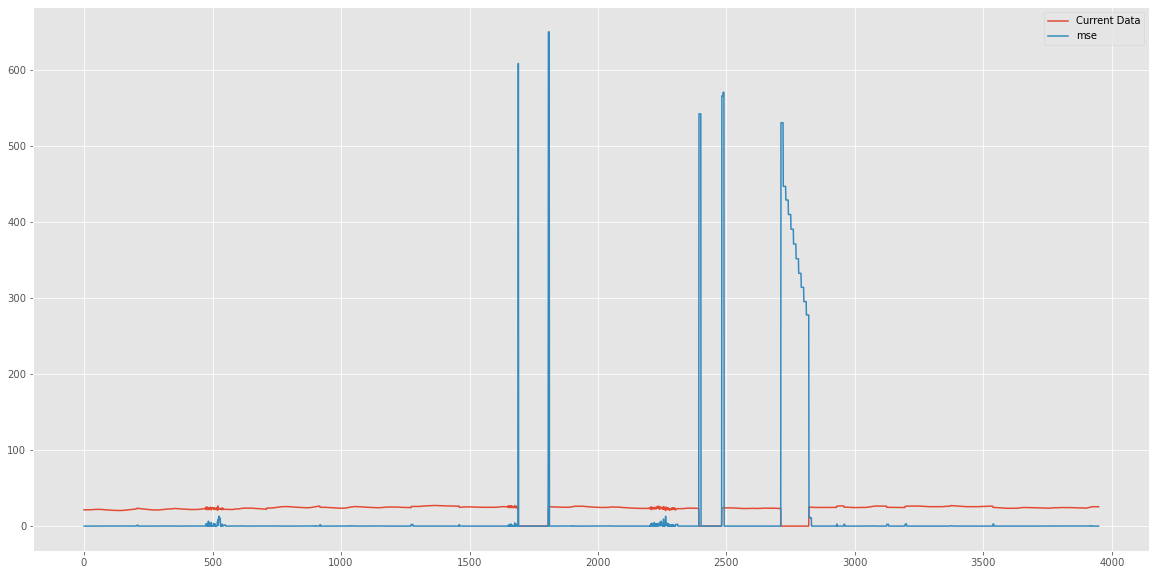

timestamp 3949
current_data 3949
mse_values_testing 3949
flag_testing 3949


In [31]:
# Plot graph: predicted VS actual
plt.figure()
plt.subplot(111)
plt.plot(current_data_testing, label='Current Data')
plt.plot(mse_values_testing, label='mse')	
plt.legend()
plt.show()

# Export data
mseExport = pd.DataFrame(mse_values_testing)
mseExport.to_csv('mseExport_test.csv')
#     pred_inv = pd.DataFrame(predicted_invalid)
#     pred_inv.to_csv("predicted_invalid_test.csv")

print("timestamp " + str(len(timestamps)))
print("current_data " + str(len(current_data_testing)))
print("mse_values_testing " + str(len(mse_values_testing)))
print("flag_testing " + str(len(flags_testing)))

data_export_vals = {
        'Date': timestamps,
        'T1': current_data_testing,
        'T1_e': mse_values_testing,
        'T1_c': flags_testing
    }
data_export = pd.DataFrame(data_export_vals)
data_export.to_csv("T1_report_final_test.csv", index=False)